<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/Deep-generative-models/blob/main/DGM_HW3_Normalizing_Flow_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = "alireza khaleghi anaghizi"
studentId = "99101462"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [2]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # you can change this if you like

In [6]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [7]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [8]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [9]:
class CouplingTransform(Transform):
    def __init__(self, mask, hidden_dims, s_net_f=None, t_net_f=None):
        """
        Args:
            mask: 1D tensor specifying which features are transformed.
            hidden_dims: Number of hidden units for the s and t networks.
            s_net_f: Function returning the neural network for scaling.
            t_net_f: Function returning the neural network for translation.
        """
        super(CouplingTransform, self).__init__()
        # Validate and register mask
        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1 or mask.numel() <= 0:
            raise ValueError("Mask must be a non-empty 1D tensor.")
        self.register_buffer('mask', mask)
        self.num_features = self.mask.numel()

        # Define scaling (s_net) and translation (t_net) networks
        self.s_net = s_net_f(self.num_features, self.num_features, hidden_dims)
        self.t_net = t_net_f(self.num_features, self.num_features, hidden_dims)

    def forward(self, inputs, context=None):
        # Split inputs based on the mask
        x1 = inputs * (1 - self.mask)
        # Compute scaling and translation
        s = self.s_net(x1)
        t = self.t_net(x1)
        # Apply transformation
        z = x1 + self.mask * (inputs * torch.exp(s) + t)
        # Log determinant of the Jacobian
        log_det_J = torch.sum(s * self.mask, dim=1)
        return z, log_det_J

    def inverse(self, inputs, context=None):
        # Split inputs based on the mask
        x1 = inputs * (1 - self.mask)
        # Compute scaling and translation
        s = self.s_net(x1)
        t = self.t_net(x1)
        # Apply inverse transformation
        z = x1 + self.mask * (inputs - t) * torch.exp(-s)
        return z


In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [10]:
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None):
        super(Flow, self).__init__()
        # Store transformations and set up base distribution
        self.transforms = nn.ModuleList(transforms).to(device)
        self.num_features = self.transforms[0].num_features
        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=device),
                covariance_matrix=torch.eye(self.num_features, device=device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x):
        # Apply all transformations in sequence
        log_det_J = 0
        for transform in self.transforms:
            x, ldj = transform(x)
            log_det_J += ldj
        return x, log_det_J

    def inverse(self, z):
        # Apply inverse of all transformations in reverse order
        for transform in reversed(self.transforms):
            z = transform.inverse(z)
        return z

    def log_prob(self, x):
        # Compute log probability of x
        z, log_det_J = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_J

    def sample(self, num_samples):
        # Sample from base distribution and apply inverse transformations
        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z)
        return x

    def sample_and_log_prob(self, num_samples):
        # Sample and compute log-probabilities
        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z)
        log_prob = self.base_distribution.log_prob(z)
        return x, log_prob


Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [11]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(i + j) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

In [12]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = 64
batch_size = 256
learning_rate = 1e-3
num_epochs = 500

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

MLP for scaling and translation.

In [15]:
def create_mlp(input_dim, output_dim, hidden_dim):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

masks = create_alternating_masks(num_features, num_layers)
transforms = []
for i in range(num_layers):
    transforms.append(
        CouplingTransform(
            mask=masks[i],
            hidden_dims=hidden_dims,
            s_net_f=create_mlp,
            t_net_f=create_mlp
        )
    )
    transforms.append(PermutationTransform(num_features))

# Initialize base distribution and Flow model
base_dist = D.MultivariateNormal(
    loc=torch.zeros(num_features, device=device),
    covariance_matrix=torch.eye(num_features, device=device)
)
flow = Flow(transforms=transforms, base_distribution=base_dist).to(device)


Epoch 1/500, Loss: 2.2193


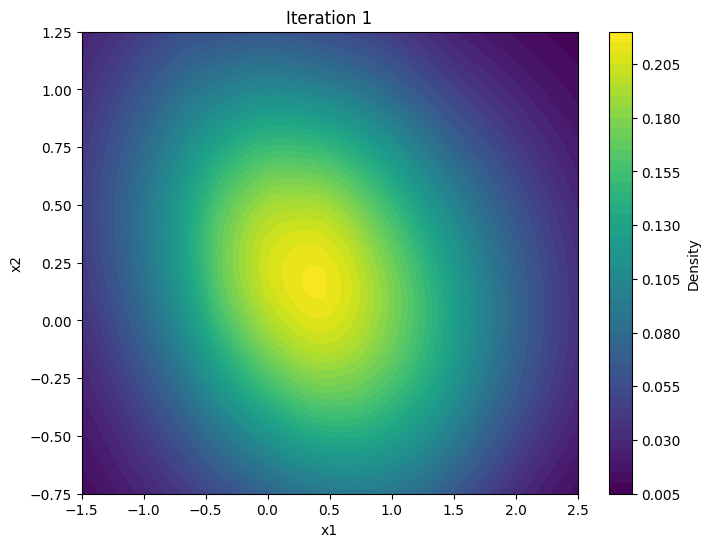

Epoch 200/500, Loss: 1.3897


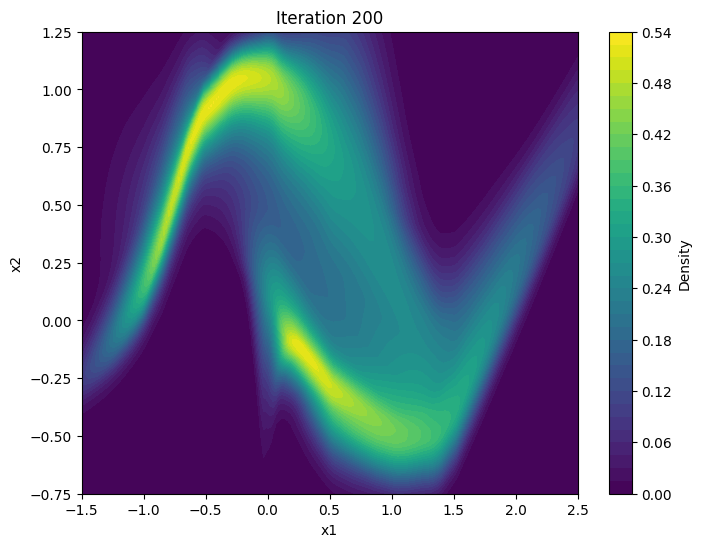

Epoch 400/500, Loss: 1.1474


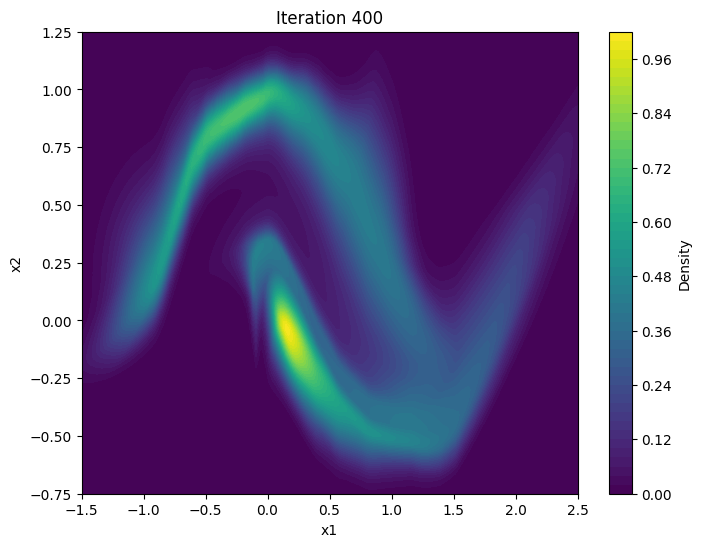

In [16]:
# Optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Generate batch data
    x, _ = make_moons(n_samples=batch_size, noise=0.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    optimizer.zero_grad()
    loss = -flow.log_prob(x).mean()
    loss.backward()
    optimizer.step()

    # Visualization
    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

        with torch.no_grad():
            xline = torch.linspace(-1.5, 2.5, 200, device=device)
            yline = torch.linspace(-0.75, 1.25, 200, device=device)
            xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1).to(device)
            log_prob_grid = flow.log_prob(xyinput).reshape(200, 200).cpu()
            zgrid = torch.exp(log_prob_grid)

        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Iteration {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()


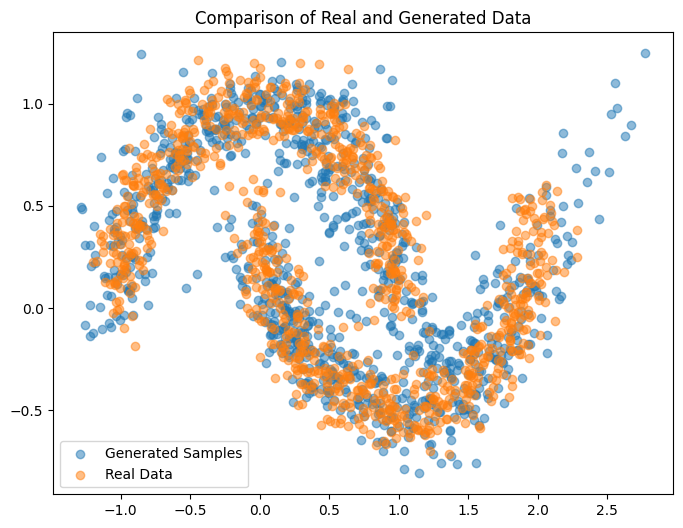

In [19]:
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()
    x_real, _ = make_moons(1000, noise=0.1)

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples')
    plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data')
    plt.legend()
    plt.title('Comparison of Real and Generated Data')
    plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.


In [48]:
!pip install normflows

In [49]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [50]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [51]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [52]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [53]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [54]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Use a for loop to automatically iterate over train_loader
for i in tqdm(range(max_iter)):
    # Get a batch of training data
    for x, _ in train_loader:
        x = x.to(device)

        # Forward pass and compute the KLD loss
        loss = model.forward_kld(x)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Optimization step
        optimizer.step()
        print(loss.detach().to('cpu').numpy())
        # Log the loss
        loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

        # Save checkpoint periodically
        if (i + 1) % save_every == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
            torch.save({
                'iteration': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_hist': loss_hist,
            }, checkpoint_path)
            print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')

        # Break after processing a single batch
        break


  0%|          | 2/10000 [00:00<29:00,  5.75it/s]

-256.48206
-290.94052


  0%|          | 4/10000 [00:00<24:07,  6.90it/s]

-386.0365
-425.55365


  0%|          | 6/10000 [00:00<22:09,  7.52it/s]

-448.36166
-496.71942


  0%|          | 8/10000 [00:01<21:27,  7.76it/s]

-536.9938
-578.6878


  0%|          | 10/10000 [00:01<22:03,  7.55it/s]

-607.11993
-640.823


  0%|          | 12/10000 [00:01<22:46,  7.31it/s]

-670.2141
-705.7928


  0%|          | 14/10000 [00:01<22:16,  7.47it/s]

-731.2072
-779.9811


  0%|          | 16/10000 [00:02<21:44,  7.65it/s]

-809.88794
-834.17847


  0%|          | 18/10000 [00:02<22:46,  7.30it/s]

-894.7417
-938.88715


  0%|          | 20/10000 [00:02<22:14,  7.48it/s]

-950.9751
-1013.06177


  0%|          | 22/10000 [00:02<21:44,  7.65it/s]

-1039.0386
-1075.0293


  0%|          | 24/10000 [00:03<21:27,  7.75it/s]

-1111.5322
-1141.7483


  0%|          | 26/10000 [00:03<22:32,  7.37it/s]

-1202.1256
-1220.2605


  0%|          | 28/10000 [00:03<21:58,  7.56it/s]

-1238.5293
-1308.3542


  0%|          | 30/10000 [00:04<21:43,  7.65it/s]

-1348.7078
-1348.2551


  0%|          | 32/10000 [00:04<21:40,  7.67it/s]

-1388.1292
-1452.1558


  0%|          | 34/10000 [00:04<22:06,  7.52it/s]

-1453.2949
-1478.4708


  0%|          | 36/10000 [00:04<21:40,  7.66it/s]

-1522.6802
-1542.3131


  0%|          | 38/10000 [00:05<21:29,  7.73it/s]

-1567.263
-1584.2665


  0%|          | 40/10000 [00:05<21:31,  7.71it/s]

-1633.1218
-1661.3699


  0%|          | 42/10000 [00:05<22:12,  7.47it/s]

-1658.9019
-1686.5112


  0%|          | 44/10000 [00:05<21:47,  7.61it/s]

-1689.2288
-1709.1787


  0%|          | 46/10000 [00:06<21:30,  7.71it/s]

-1705.5172
-1726.5819


  0%|          | 48/10000 [00:06<21:34,  7.69it/s]

-1758.2446
-1771.2948


  0%|          | 50/10000 [00:06<21:44,  7.62it/s]

-1802.2245
-1851.0751


  1%|          | 52/10000 [00:06<21:36,  7.67it/s]

-1838.1865
-1839.0729


  1%|          | 54/10000 [00:07<21:01,  7.88it/s]

-1875.121
-1877.6948


  1%|          | 56/10000 [00:07<21:45,  7.61it/s]

-1921.764
-1905.2764


  1%|          | 58/10000 [00:07<21:49,  7.59it/s]

-1885.0056
-1972.7026


  1%|          | 60/10000 [00:07<21:28,  7.72it/s]

-1969.0481
-1953.1559


  1%|          | 62/10000 [00:08<21:06,  7.85it/s]

-1969.5063
-2011.0225


  1%|          | 64/10000 [00:08<22:29,  7.36it/s]

-1999.1763
-1973.9895


  1%|          | 66/10000 [00:08<22:01,  7.52it/s]

-2021.9312
-1996.4957


  1%|          | 68/10000 [00:09<22:07,  7.48it/s]

-2070.817
-2113.1738


  1%|          | 70/10000 [00:09<21:47,  7.59it/s]

-2062.2905
-2078.6191


  1%|          | 72/10000 [00:09<23:13,  7.12it/s]

-2090.3687
-2098.8918


  1%|          | 74/10000 [00:09<22:40,  7.30it/s]

-2122.3525
-2123.4766


  1%|          | 76/10000 [00:10<26:46,  6.18it/s]

-2105.969
-2158.8716


  1%|          | 77/10000 [00:10<28:15,  5.85it/s]

-2149.7834


  1%|          | 78/10000 [00:10<30:00,  5.51it/s]

-2167.848
-2179.505


  1%|          | 81/10000 [00:11<29:14,  5.65it/s]

-2208.7083
-2245.4856


  1%|          | 82/10000 [00:11<29:42,  5.57it/s]

-2226.151


  1%|          | 83/10000 [00:11<31:34,  5.24it/s]

-2232.459
-2255.1526


  1%|          | 85/10000 [00:11<31:40,  5.22it/s]

-2256.0317


  1%|          | 86/10000 [00:12<33:18,  4.96it/s]

-2275.8677


  1%|          | 88/10000 [00:12<31:10,  5.30it/s]

-2230.6318
-2325.912


  1%|          | 90/10000 [00:12<26:34,  6.21it/s]

-2298.1726
-2312.17


  1%|          | 92/10000 [00:13<24:15,  6.81it/s]

-2272.41
-2309.577


  1%|          | 94/10000 [00:13<22:36,  7.30it/s]

-2330.1382
-2350.422


  1%|          | 96/10000 [00:13<22:36,  7.30it/s]

-2375.2285
-2309.3745


  1%|          | 98/10000 [00:13<22:58,  7.18it/s]

-2387.1594
-2362.858


  1%|          | 100/10000 [00:14<22:02,  7.49it/s]

-2354.2046
-2374.899


  1%|          | 102/10000 [00:14<22:05,  7.47it/s]

-2395.2397
-2384.08


  1%|          | 104/10000 [00:14<22:02,  7.48it/s]

-2407.0947
-2351.3445


  1%|          | 106/10000 [00:14<21:30,  7.66it/s]

-2209.3298
-2379.52


  1%|          | 108/10000 [00:15<21:43,  7.59it/s]

-2309.184
-2394.8667


  1%|          | 110/10000 [00:15<22:21,  7.37it/s]

-2318.0752
-2378.243


  1%|          | 112/10000 [00:15<22:23,  7.36it/s]

-2462.4946
-2356.7783


  1%|          | 114/10000 [00:16<22:01,  7.48it/s]

-2442.0908
-2421.0637


  1%|          | 116/10000 [00:16<21:53,  7.53it/s]

-2446.2988
-2442.4417


  1%|          | 118/10000 [00:16<22:04,  7.46it/s]

-2419.4697
-2441.484


  1%|          | 120/10000 [00:16<22:27,  7.33it/s]

-2490.4946
-2495.0535


  1%|          | 122/10000 [00:17<21:50,  7.54it/s]

-2520.2163
-2441.7183


  1%|          | 124/10000 [00:17<21:17,  7.73it/s]

-2511.104
-2482.2273


  1%|▏         | 126/10000 [00:17<21:43,  7.58it/s]

-2483.0361
-2564.6333


  1%|▏         | 128/10000 [00:17<21:54,  7.51it/s]

-2492.7935
-2514.9492


  1%|▏         | 130/10000 [00:18<21:12,  7.75it/s]

-2560.9636
-2532.8105


  1%|▏         | 132/10000 [00:18<21:43,  7.57it/s]

-2537.4202
-2594.941


  1%|▏         | 134/10000 [00:18<21:25,  7.67it/s]

-2583.0083
-2592.1423


  1%|▏         | 136/10000 [00:18<21:34,  7.62it/s]

-2549.6897
-2604.8037


  1%|▏         | 138/10000 [00:19<21:44,  7.56it/s]

-2588.4849
-2625.4185


  1%|▏         | 140/10000 [00:19<22:48,  7.20it/s]

-2603.4631
-2599.4363


  1%|▏         | 142/10000 [00:19<21:59,  7.47it/s]

-2595.085
-2623.715


  1%|▏         | 144/10000 [00:20<21:59,  7.47it/s]

-2591.2554
-2551.4058


  1%|▏         | 146/10000 [00:20<21:51,  7.51it/s]

-2639.3843
-2633.325


  1%|▏         | 148/10000 [00:20<22:17,  7.36it/s]

-2610.0293
-2597.3457


  2%|▏         | 150/10000 [00:20<21:59,  7.46it/s]

-2590.9045
-2605.0945


  2%|▏         | 152/10000 [00:21<21:41,  7.57it/s]

-2648.6611
-2698.9832


  2%|▏         | 154/10000 [00:21<21:30,  7.63it/s]

-2628.4307
-2684.6655


  2%|▏         | 156/10000 [00:21<22:24,  7.32it/s]

-2680.8452
-2643.2202


  2%|▏         | 158/10000 [00:21<22:17,  7.36it/s]

-2707.1245
-2612.2102


  2%|▏         | 160/10000 [00:22<21:49,  7.51it/s]

-2574.7354
-2688.0317


  2%|▏         | 162/10000 [00:22<22:23,  7.32it/s]

-2651.1738
-2649.6108


  2%|▏         | 164/10000 [00:22<27:36,  5.94it/s]

-2661.914
-2698.0361


  2%|▏         | 166/10000 [00:23<28:46,  5.70it/s]

-2676.957
-2664.667


  2%|▏         | 168/10000 [00:23<29:03,  5.64it/s]

-2714.9463
-2765.1055


  2%|▏         | 170/10000 [00:23<30:05,  5.45it/s]

-2765.159
-2720.17


  2%|▏         | 171/10000 [00:24<30:53,  5.30it/s]

-2733.4558


  2%|▏         | 172/10000 [00:24<31:52,  5.14it/s]

-2751.6094
-2734.2993


  2%|▏         | 175/10000 [00:24<31:15,  5.24it/s]

-2705.0078
-2717.227


  2%|▏         | 177/10000 [00:25<27:10,  6.03it/s]

-2744.195
-2732.079


  2%|▏         | 179/10000 [00:25<25:29,  6.42it/s]

-2736.9368
-2784.4006


  2%|▏         | 181/10000 [00:25<23:52,  6.86it/s]

-2747.9458
-2777.4016


  2%|▏         | 183/10000 [00:26<23:22,  7.00it/s]

-2742.957
-2728.4683


  2%|▏         | 185/10000 [00:26<22:31,  7.26it/s]

-2765.3616
-2792.4556


  2%|▏         | 187/10000 [00:26<22:12,  7.37it/s]

-2768.8726
-2708.2622


  2%|▏         | 189/10000 [00:26<21:54,  7.46it/s]

-2675.6646
-2711.9253


  2%|▏         | 191/10000 [00:27<21:37,  7.56it/s]

-2758.2808
-2643.0898


  2%|▏         | 193/10000 [00:27<21:09,  7.73it/s]

-2774.875
-2718.4585


  2%|▏         | 195/10000 [00:27<21:32,  7.58it/s]

-2773.565
-2749.7314


  2%|▏         | 197/10000 [00:27<21:16,  7.68it/s]

-2776.6777
-2768.6714


  2%|▏         | 199/10000 [00:28<21:21,  7.65it/s]

-2744.9263
-2783.3066


  2%|▏         | 201/10000 [00:28<21:55,  7.45it/s]

-2795.5142
-2795.6172


  2%|▏         | 203/10000 [00:28<21:46,  7.50it/s]

-2775.4268
-2765.1


  2%|▏         | 205/10000 [00:28<21:10,  7.71it/s]

-2746.0796
-2718.3667


  2%|▏         | 207/10000 [00:29<21:44,  7.50it/s]

-2762.9888
-2785.3718


  2%|▏         | 209/10000 [00:29<22:07,  7.38it/s]

-2745.5269
-2728.6965


  2%|▏         | 211/10000 [00:29<21:40,  7.52it/s]

-2699.084
-2748.8965


  2%|▏         | 213/10000 [00:30<21:37,  7.54it/s]

-2757.982
-2786.361


  2%|▏         | 215/10000 [00:30<22:01,  7.41it/s]

-2799.4937
-2812.418


  2%|▏         | 217/10000 [00:30<22:01,  7.40it/s]

-2803.848
-2786.893


  2%|▏         | 219/10000 [00:30<21:30,  7.58it/s]

-2808.6511
-2872.8364


  2%|▏         | 221/10000 [00:31<21:28,  7.59it/s]

-2836.7505
-2797.782


  2%|▏         | 223/10000 [00:31<21:29,  7.58it/s]

-2846.7485
-2811.7058


  2%|▏         | 225/10000 [00:31<22:11,  7.34it/s]

-2840.45
-2895.304


  2%|▏         | 227/10000 [00:31<21:43,  7.50it/s]

-2812.117
-2883.1743


  2%|▏         | 229/10000 [00:32<22:00,  7.40it/s]

-2875.1943
-2841.793


  2%|▏         | 231/10000 [00:32<21:56,  7.42it/s]

-2883.5347
-2842.4019


  2%|▏         | 233/10000 [00:32<21:33,  7.55it/s]

-2837.2124
-2910.2754


  2%|▏         | 235/10000 [00:32<21:38,  7.52it/s]

-2871.4565
-2864.2505


  2%|▏         | 237/10000 [00:33<21:58,  7.41it/s]

-2905.2432
-2854.6924


  2%|▏         | 239/10000 [00:33<22:26,  7.25it/s]

-2898.6665
-2878.077


  2%|▏         | 241/10000 [00:33<22:07,  7.35it/s]

-2883.8628
-2912.8882


  2%|▏         | 243/10000 [00:34<22:01,  7.38it/s]

-2915.976
-2895.5269


  2%|▏         | 245/10000 [00:34<21:49,  7.45it/s]

-2868.1675
-2869.6987


  2%|▏         | 247/10000 [00:34<22:01,  7.38it/s]

-2872.396
-2884.0996


  2%|▏         | 249/10000 [00:34<21:21,  7.61it/s]

-2917.1338
-2887.2986


  2%|▎         | 250/10000 [00:35<24:14,  6.71it/s]

-2889.7373


  3%|▎         | 252/10000 [00:35<28:06,  5.78it/s]

-2904.319
-2845.352


  3%|▎         | 254/10000 [00:35<27:59,  5.80it/s]

-2832.699
-2844.856


  3%|▎         | 256/10000 [00:36<28:12,  5.76it/s]

-2796.5483
-2836.976


  3%|▎         | 257/10000 [00:36<29:07,  5.57it/s]

-2921.4492


  3%|▎         | 258/10000 [00:36<31:05,  5.22it/s]

-2892.3013


  3%|▎         | 260/10000 [00:36<31:55,  5.09it/s]

-2860.1187
-2910.501


  3%|▎         | 261/10000 [00:37<31:38,  5.13it/s]

-2908.853


  3%|▎         | 262/10000 [00:37<32:07,  5.05it/s]

-2834.6377


  3%|▎         | 264/10000 [00:37<30:30,  5.32it/s]

-2886.8047
-2834.275


  3%|▎         | 266/10000 [00:38<25:48,  6.29it/s]

-2800.1064
-2737.6497


  3%|▎         | 268/10000 [00:38<23:49,  6.81it/s]

-2950.5361
-2774.8657


  3%|▎         | 270/10000 [00:38<23:10,  7.00it/s]

-2845.4014
-2916.9077


  3%|▎         | 272/10000 [00:38<22:03,  7.35it/s]

-2830.5327
-2878.872


  3%|▎         | 274/10000 [00:39<21:46,  7.45it/s]

-2808.723
-2906.6572


  3%|▎         | 276/10000 [00:39<21:43,  7.46it/s]

-2880.4385
-2890.9443


  3%|▎         | 278/10000 [00:39<22:23,  7.24it/s]

-2871.4106
-2915.0579


  3%|▎         | 280/10000 [00:39<22:03,  7.34it/s]

-2939.2263
-2888.8325


  3%|▎         | 282/10000 [00:40<21:37,  7.49it/s]

-2925.0674
-2964.3752


  3%|▎         | 284/10000 [00:40<22:32,  7.18it/s]

-2909.0002
-2929.7417


  3%|▎         | 286/10000 [00:40<22:05,  7.33it/s]

-2956.394
-2907.6719


  3%|▎         | 288/10000 [00:40<21:22,  7.57it/s]

-2959.7969
-2895.416


  3%|▎         | 290/10000 [00:41<21:04,  7.68it/s]

-2934.5562
-2955.3599


  3%|▎         | 292/10000 [00:41<22:29,  7.20it/s]

-2923.369
-2965.3965


  3%|▎         | 294/10000 [00:41<21:30,  7.52it/s]

-2958.4998
-2940.2803


  3%|▎         | 296/10000 [00:42<21:05,  7.67it/s]

-2950.3013
-2977.8398


  3%|▎         | 298/10000 [00:42<21:07,  7.66it/s]

-2941.5122
-2947.1802


  3%|▎         | 300/10000 [00:42<22:44,  7.11it/s]

-2952.6548
-2951.4233


  3%|▎         | 302/10000 [00:42<22:04,  7.32it/s]

-2958.6084
-2962.338


  3%|▎         | 304/10000 [00:43<21:38,  7.47it/s]

-2946.5586
-2972.449


  3%|▎         | 306/10000 [00:43<21:41,  7.45it/s]

-2969.0073
-2954.09


  3%|▎         | 308/10000 [00:43<22:21,  7.22it/s]

-3005.6265
-2956.6072


  3%|▎         | 310/10000 [00:43<21:46,  7.41it/s]

-2933.2876
-3012.3286


  3%|▎         | 312/10000 [00:44<21:19,  7.57it/s]

-2993.4067
-2976.2666


  3%|▎         | 314/10000 [00:44<22:31,  7.16it/s]

-3000.9658
-2972.6484


  3%|▎         | 316/10000 [00:44<22:06,  7.30it/s]

-2970.8337
-2966.461


  3%|▎         | 318/10000 [00:45<21:18,  7.57it/s]

-2906.4436
-2936.8208


  3%|▎         | 320/10000 [00:45<21:47,  7.41it/s]

-2945.2827
-2962.5923


  3%|▎         | 322/10000 [00:45<21:56,  7.35it/s]

-2980.1045
-2987.076


  3%|▎         | 324/10000 [00:45<21:39,  7.45it/s]

-2928.391
-2964.4854


  3%|▎         | 326/10000 [00:46<21:10,  7.61it/s]

-2976.458
-2961.1885


  3%|▎         | 328/10000 [00:46<21:20,  7.55it/s]

-2943.6418
-2933.5535


  3%|▎         | 330/10000 [00:46<21:22,  7.54it/s]

-3004.8547
-2942.725


  3%|▎         | 332/10000 [00:46<21:36,  7.45it/s]

-2917.212
-2963.864


  3%|▎         | 334/10000 [00:47<21:40,  7.43it/s]

-2947.4917
-2928.332


  3%|▎         | 336/10000 [00:47<22:06,  7.28it/s]

-2933.902
-2992.3618


  3%|▎         | 337/10000 [00:47<21:58,  7.33it/s]

-2990.158


  3%|▎         | 339/10000 [00:48<27:04,  5.95it/s]

-2998.4426
-2964.427


  3%|▎         | 341/10000 [00:48<28:30,  5.65it/s]

-2992.5303
-2984.607


  3%|▎         | 343/10000 [00:48<27:48,  5.79it/s]

-3004.7456
-3021.8652


  3%|▎         | 345/10000 [00:49<30:08,  5.34it/s]

-2956.7979
-3020.196


  3%|▎         | 347/10000 [00:49<31:06,  5.17it/s]

-2992.6797
-2960.6553


  3%|▎         | 349/10000 [00:49<31:58,  5.03it/s]

-2954.8555
-3005.44


  4%|▎         | 351/10000 [00:50<25:58,  6.19it/s]

-3016.238
-3045.15


  4%|▎         | 353/10000 [00:50<24:06,  6.67it/s]

-3000.236
-3023.0156


  4%|▎         | 355/10000 [00:50<22:37,  7.10it/s]

-3044.976
-3022.428


  4%|▎         | 357/10000 [00:50<21:37,  7.43it/s]

-3011.3674
-2989.1104


  4%|▎         | 359/10000 [00:51<21:28,  7.48it/s]

-2968.7607
-2974.8936


  4%|▎         | 361/10000 [00:51<22:07,  7.26it/s]

-3009.3013
-3043.1992


  4%|▎         | 363/10000 [00:51<21:39,  7.42it/s]

-3043.459
-3027.4788


  4%|▎         | 365/10000 [00:52<21:24,  7.50it/s]

-3008.6328
-3027.8179


  4%|▎         | 367/10000 [00:52<21:46,  7.37it/s]

-3023.5007
-2973.4932


  4%|▎         | 369/10000 [00:52<21:50,  7.35it/s]

-3034.1753
-2989.1257


  4%|▎         | 371/10000 [00:52<21:17,  7.54it/s]

-3002.9216
-3000.575


  4%|▎         | 373/10000 [00:53<21:46,  7.37it/s]

-2985.0156
-3025.0469


  4%|▍         | 375/10000 [00:53<21:58,  7.30it/s]

-3018.7454
-3011.8687


  4%|▍         | 377/10000 [00:53<22:02,  7.27it/s]

-3019.21
-3010.9456


  4%|▍         | 379/10000 [00:53<22:07,  7.25it/s]

-2950.1501
-2970.1016


  4%|▍         | 381/10000 [00:54<21:33,  7.44it/s]

-3015.6467
-2994.0222


  4%|▍         | 383/10000 [00:54<21:51,  7.33it/s]

-3026.9893
-3026.7183


  4%|▍         | 385/10000 [00:54<21:13,  7.55it/s]

-3021.5996
-3026.5688


  4%|▍         | 387/10000 [00:55<21:27,  7.47it/s]

-3028.5007
-3026.6885


  4%|▍         | 389/10000 [00:55<21:19,  7.51it/s]

-3013.1055
-3011.5889


  4%|▍         | 391/10000 [00:55<21:12,  7.55it/s]

-3041.9106
-3034.9697


  4%|▍         | 393/10000 [00:55<21:05,  7.59it/s]

-3062.129
-3039.4673


  4%|▍         | 395/10000 [00:56<21:15,  7.53it/s]

-3012.4316
-3031.6587


  4%|▍         | 397/10000 [00:56<21:17,  7.52it/s]

-3026.433
-3040.0146


  4%|▍         | 399/10000 [00:56<21:50,  7.33it/s]

-2985.9263
-3012.4329


  4%|▍         | 401/10000 [00:56<21:44,  7.36it/s]

-3021.006
-3057.588


  4%|▍         | 403/10000 [00:57<22:04,  7.24it/s]

-3022.9526
-3060.9438


  4%|▍         | 405/10000 [00:57<22:48,  7.01it/s]

-2984.71
-3018.745


  4%|▍         | 407/10000 [00:57<22:08,  7.22it/s]

-3046.9583
-3051.724


  4%|▍         | 409/10000 [00:58<21:40,  7.37it/s]

-3018.2324
-3024.2202


  4%|▍         | 411/10000 [00:58<21:51,  7.31it/s]

-2972.7344
-3023.2954


  4%|▍         | 413/10000 [00:58<21:59,  7.27it/s]

-3027.9248
-3068.2832


  4%|▍         | 415/10000 [00:58<21:45,  7.34it/s]

-3014.7822
-2979.3242


  4%|▍         | 417/10000 [00:59<22:04,  7.24it/s]

-3019.8926
-3008.5303


  4%|▍         | 419/10000 [00:59<22:30,  7.09it/s]

-2938.7212
-2922.941


  4%|▍         | 421/10000 [00:59<22:03,  7.24it/s]

-2950.7065
-2893.3652


  4%|▍         | 423/10000 [01:00<23:39,  6.75it/s]

-2993.5767
-2948.0537


  4%|▍         | 425/10000 [01:00<27:12,  5.86it/s]

-2963.0076
-3045.8777


  4%|▍         | 427/10000 [01:00<27:37,  5.77it/s]

-2925.835
-3006.2988


  4%|▍         | 429/10000 [01:01<26:47,  5.95it/s]

-2921.4146
-2994.9102


  4%|▍         | 430/10000 [01:01<28:35,  5.58it/s]

-2973.0696


  4%|▍         | 431/10000 [01:01<30:59,  5.15it/s]

-2914.5085


  4%|▍         | 433/10000 [01:01<30:44,  5.19it/s]

-2918.3682
-3018.273


  4%|▍         | 434/10000 [01:02<30:08,  5.29it/s]

-3002.0776


  4%|▍         | 435/10000 [01:02<31:36,  5.04it/s]

-2999.1562


  4%|▍         | 437/10000 [01:02<29:08,  5.47it/s]

-2993.0637
-2982.4783


  4%|▍         | 439/10000 [01:02<25:08,  6.34it/s]

-3009.5974
-3033.4355


  4%|▍         | 441/10000 [01:03<23:14,  6.85it/s]

-2960.3518
-3002.5466


  4%|▍         | 443/10000 [01:03<23:08,  6.88it/s]

-3063.488
-3068.102


  4%|▍         | 445/10000 [01:03<21:58,  7.25it/s]

-3005.5688
-3048.767


  4%|▍         | 447/10000 [01:04<21:25,  7.43it/s]

-3023.6365
-3020.2227


  4%|▍         | 449/10000 [01:04<20:48,  7.65it/s]

-3039.811
-3049.4377


  5%|▍         | 451/10000 [01:04<21:34,  7.38it/s]

-3071.9553
-3087.292


  5%|▍         | 453/10000 [01:04<21:07,  7.53it/s]

-3055.0278
-3073.211


  5%|▍         | 455/10000 [01:05<21:04,  7.55it/s]

-3052.8782
-3078.5625


  5%|▍         | 457/10000 [01:05<21:33,  7.38it/s]

-3037.8699
-3081.158


  5%|▍         | 459/10000 [01:05<21:49,  7.29it/s]

-3113.294
-3070.5493


  5%|▍         | 461/10000 [01:05<21:16,  7.47it/s]

-3118.3123
-3100.8281


  5%|▍         | 463/10000 [01:06<21:17,  7.46it/s]

-3056.9697
-3073.9211


  5%|▍         | 465/10000 [01:06<22:10,  7.17it/s]

-3047.8003
-3054.1724


  5%|▍         | 467/10000 [01:06<21:36,  7.35it/s]

-3049.2778
-3071.4521


  5%|▍         | 469/10000 [01:06<21:31,  7.38it/s]

-3072.2793
-3052.5928


  5%|▍         | 471/10000 [01:07<21:10,  7.50it/s]

-3063.789
-3044.896


  5%|▍         | 473/10000 [01:07<22:23,  7.09it/s]

-3104.1233
-3077.9128


  5%|▍         | 475/10000 [01:07<21:53,  7.25it/s]

-3052.6768
-3049.8682


  5%|▍         | 477/10000 [01:08<21:30,  7.38it/s]

-3059.4907
-3085.2656


  5%|▍         | 479/10000 [01:08<21:25,  7.41it/s]

-3006.7393
-3049.4517


  5%|▍         | 481/10000 [01:08<21:48,  7.28it/s]

-2995.479
-2969.1584


  5%|▍         | 483/10000 [01:08<21:19,  7.44it/s]

-2987.5
-3043.545


  5%|▍         | 485/10000 [01:09<21:14,  7.47it/s]

-2997.068
-2991.4346


  5%|▍         | 487/10000 [01:09<21:54,  7.24it/s]

-3049.7131
-3028.498


  5%|▍         | 489/10000 [01:09<21:32,  7.36it/s]

-3085.2463
-3049.8054


  5%|▍         | 491/10000 [01:10<21:34,  7.34it/s]

-3062.961
-3080.6887


  5%|▍         | 493/10000 [01:10<20:58,  7.55it/s]

-3032.8687
-3072.4106


  5%|▍         | 495/10000 [01:10<21:31,  7.36it/s]

-3081.3218
-3079.1748


  5%|▍         | 497/10000 [01:10<21:30,  7.36it/s]

-3056.2498
-3131.0195


  5%|▍         | 499/10000 [01:11<21:29,  7.37it/s]

-3061.857
-3085.5073


  5%|▌         | 501/10000 [01:11<20:58,  7.55it/s]

-3079.6714
-3099.03


  5%|▌         | 503/10000 [01:11<21:54,  7.23it/s]

-3080.6514
-3044.7913


  5%|▌         | 505/10000 [01:11<21:29,  7.36it/s]

-3081.2446
-3079.1855


  5%|▌         | 507/10000 [01:12<21:05,  7.50it/s]

-3092.006
-3070.4463


  5%|▌         | 509/10000 [01:12<21:24,  7.39it/s]

-3066.0796
-3092.1082


  5%|▌         | 510/10000 [01:12<22:34,  7.01it/s]

-3065.8926


  5%|▌         | 512/10000 [01:13<27:22,  5.78it/s]

-3090.3838
-3041.795


  5%|▌         | 514/10000 [01:13<27:27,  5.76it/s]

-3085.9084
-3053.6409


  5%|▌         | 516/10000 [01:13<28:03,  5.63it/s]

-3046.7346
-3074.6538


  5%|▌         | 518/10000 [01:14<28:08,  5.62it/s]

-3087.5186
-3080.644


  5%|▌         | 519/10000 [01:14<29:38,  5.33it/s]

-3063.5303


  5%|▌         | 520/10000 [01:14<31:08,  5.07it/s]

-3056.1204


  5%|▌         | 522/10000 [01:14<31:23,  5.03it/s]

-3068.6287
-3068.3164


  5%|▌         | 524/10000 [01:15<28:33,  5.53it/s]

-3065.5554
-3095.6719


  5%|▌         | 526/10000 [01:15<25:36,  6.17it/s]

-3084.2144
-3060.6948


  5%|▌         | 528/10000 [01:15<23:29,  6.72it/s]

-3091.245
-3078.7124


  5%|▌         | 530/10000 [01:16<22:08,  7.13it/s]

-3083.8928
-3083.98


  5%|▌         | 532/10000 [01:16<21:11,  7.45it/s]

-3092.0876
-3072.56


  5%|▌         | 534/10000 [01:16<20:56,  7.54it/s]

-3131.6907
-3115.2205


  5%|▌         | 536/10000 [01:16<21:00,  7.51it/s]

-3106.9517
-3085.464


  5%|▌         | 538/10000 [01:17<20:58,  7.52it/s]

-3071.2886
-3049.3164


  5%|▌         | 540/10000 [01:17<20:39,  7.63it/s]

-3100.8716
-3064.6167


  5%|▌         | 542/10000 [01:17<21:12,  7.43it/s]

-3082.6414
-3079.3494


  5%|▌         | 544/10000 [01:17<21:24,  7.36it/s]

-3088.7898
-3077.6138


  5%|▌         | 546/10000 [01:18<20:54,  7.54it/s]

-3078.3486
-3064.9321


  5%|▌         | 548/10000 [01:18<21:40,  7.27it/s]

-3052.2734
-3055.004


  6%|▌         | 550/10000 [01:18<21:21,  7.37it/s]

-3048.4946
-3126.1018


  6%|▌         | 552/10000 [01:19<21:44,  7.24it/s]

-3074.7988
-3068.6426


  6%|▌         | 554/10000 [01:19<21:34,  7.30it/s]

-3116.1802
-3060.9268


  6%|▌         | 556/10000 [01:19<21:57,  7.17it/s]

-3062.6694
-3115.385


  6%|▌         | 558/10000 [01:19<22:08,  7.11it/s]

-3002.5999
-3064.6973


  6%|▌         | 560/10000 [01:20<21:37,  7.28it/s]

-3010.7441
-3022.2998


  6%|▌         | 562/10000 [01:20<22:17,  7.05it/s]

-2981.7256
-3079.3062


  6%|▌         | 564/10000 [01:20<21:28,  7.32it/s]

-2973.5957
-2969.5417


  6%|▌         | 566/10000 [01:20<21:26,  7.34it/s]

-2895.2227
-3028.6758


  6%|▌         | 568/10000 [01:21<21:26,  7.33it/s]

-3043.7844
-3014.2563


  6%|▌         | 570/10000 [01:21<21:57,  7.16it/s]

-3043.077
-3034.801


  6%|▌         | 572/10000 [01:21<21:29,  7.31it/s]

-3011.7883
-3065.779


  6%|▌         | 574/10000 [01:22<21:28,  7.32it/s]

-3035.0408
-3026.1758


  6%|▌         | 576/10000 [01:22<21:31,  7.30it/s]

-3057.3582
-3041.8022


  6%|▌         | 578/10000 [01:22<21:22,  7.35it/s]

-3062.4617
-3073.6565


  6%|▌         | 580/10000 [01:22<21:15,  7.39it/s]

-3097.2578
-3094.585


  6%|▌         | 582/10000 [01:23<21:21,  7.35it/s]

-3114.665
-3092.5522


  6%|▌         | 584/10000 [01:23<21:30,  7.30it/s]

-3117.082
-3100.9248


  6%|▌         | 586/10000 [01:23<21:22,  7.34it/s]

-3088.037
-3077.5977


  6%|▌         | 588/10000 [01:24<21:37,  7.25it/s]

-3109.801
-3083.3774


  6%|▌         | 590/10000 [01:24<21:10,  7.41it/s]

-3096.9307
-3087.713


  6%|▌         | 592/10000 [01:24<21:51,  7.17it/s]

-3099.149
-3115.6716


  6%|▌         | 594/10000 [01:24<21:33,  7.27it/s]

-3129.2031
-3093.2866


  6%|▌         | 595/10000 [01:25<24:34,  6.38it/s]

-3087.8872


  6%|▌         | 596/10000 [01:25<28:07,  5.57it/s]

-3100.7664


  6%|▌         | 597/10000 [01:25<29:34,  5.30it/s]

-3069.6318


  6%|▌         | 598/10000 [01:25<31:06,  5.04it/s]

-3120.7263


  6%|▌         | 599/10000 [01:25<33:15,  4.71it/s]

-3128.7935


  6%|▌         | 600/10000 [01:26<35:36,  4.40it/s]

-3122.5889


  6%|▌         | 601/10000 [01:26<35:08,  4.46it/s]

-3113.7043


  6%|▌         | 602/10000 [01:26<35:04,  4.47it/s]

-3115.07


  6%|▌         | 604/10000 [01:27<33:14,  4.71it/s]

-3070.38
-3077.1763


  6%|▌         | 605/10000 [01:27<34:11,  4.58it/s]

-3166.4404


  6%|▌         | 606/10000 [01:27<35:46,  4.38it/s]

-3131.2773


  6%|▌         | 607/10000 [01:27<38:13,  4.10it/s]

-3074.1091


  6%|▌         | 608/10000 [01:28<38:30,  4.07it/s]

-3101.0405


  6%|▌         | 609/10000 [01:28<38:04,  4.11it/s]

-3114.9348


  6%|▌         | 611/10000 [01:28<33:58,  4.61it/s]

-3138.488
-3063.074


  6%|▌         | 613/10000 [01:29<30:27,  5.14it/s]

-3116.1672
-3105.276


  6%|▌         | 615/10000 [01:29<25:59,  6.02it/s]

-3107.4717
-3127.146


  6%|▌         | 617/10000 [01:29<23:42,  6.60it/s]

-3103.682
-3134.48


  6%|▌         | 619/10000 [01:29<21:57,  7.12it/s]

-3140.0393
-3095.8574


  6%|▌         | 621/10000 [01:30<21:32,  7.26it/s]

-3089.876
-3122.5137


  6%|▌         | 623/10000 [01:30<21:21,  7.32it/s]

-3111.6667
-3095.005


  6%|▋         | 625/10000 [01:30<21:40,  7.21it/s]

-3091.8271
-3036.2585


  6%|▋         | 627/10000 [01:30<21:14,  7.35it/s]

-2989.622
-3066.23


  6%|▋         | 629/10000 [01:31<20:53,  7.47it/s]

-3118.6167
-3069.4185


  6%|▋         | 631/10000 [01:31<21:51,  7.14it/s]

-3065.0645
-3101.4844


  6%|▋         | 633/10000 [01:31<21:16,  7.34it/s]

-3119.956
-3064.3875


  6%|▋         | 635/10000 [01:32<21:16,  7.34it/s]

-3101.0083
-3149.3518


  6%|▋         | 637/10000 [01:32<21:19,  7.32it/s]

-3112.8853
-3098.0552


  6%|▋         | 639/10000 [01:32<21:37,  7.21it/s]

-3112.8738
-3070.7937


  6%|▋         | 641/10000 [01:32<21:08,  7.38it/s]

-3108.7134
-3068.8623


  6%|▋         | 643/10000 [01:33<22:03,  7.07it/s]

-3089.3083
-3089.7585


  6%|▋         | 645/10000 [01:33<22:48,  6.84it/s]

-3078.7593
-3116.5698


  6%|▋         | 647/10000 [01:33<22:28,  6.93it/s]

-3094.4033
-3085.767


  6%|▋         | 649/10000 [01:34<21:58,  7.09it/s]

-3092.5762
-3092.585


  7%|▋         | 651/10000 [01:34<21:03,  7.40it/s]

-3064.6006
-3126.8662


  7%|▋         | 653/10000 [01:34<21:57,  7.09it/s]

-3097.8079
-3106.4004


  7%|▋         | 655/10000 [01:34<22:29,  6.93it/s]

-3124.215
-3106.7515


  7%|▋         | 657/10000 [01:35<21:35,  7.21it/s]

-3126.8672
-3132.3923


  7%|▋         | 659/10000 [01:35<22:09,  7.03it/s]

-3097.7212
-3139.8003


  7%|▋         | 661/10000 [01:35<21:36,  7.20it/s]

-3109.984
-3113.8032


  7%|▋         | 663/10000 [01:35<21:14,  7.32it/s]

-3134.1724
-3125.6396


  7%|▋         | 665/10000 [01:36<21:09,  7.35it/s]

-3073.4639
-3110.754


  7%|▋         | 667/10000 [01:36<21:51,  7.11it/s]

-3032.1226
-3122.3472


  7%|▋         | 669/10000 [01:36<20:58,  7.41it/s]

-3069.9216
-3049.5542


  7%|▋         | 671/10000 [01:37<21:01,  7.39it/s]

-3093.3591
-3088.188


  7%|▋         | 673/10000 [01:37<20:34,  7.56it/s]

-3116.3347
-3040.1724


  7%|▋         | 675/10000 [01:37<21:21,  7.27it/s]

-3025.2153
-2913.2153


  7%|▋         | 677/10000 [01:37<21:32,  7.21it/s]

-3008.0093
-3010.592


  7%|▋         | 679/10000 [01:38<20:51,  7.45it/s]

-3043.1797
-3035.7065


  7%|▋         | 681/10000 [01:38<20:44,  7.49it/s]

-3035.1523
-3054.4575


  7%|▋         | 683/10000 [01:38<21:15,  7.31it/s]

-3056.6802
-3067.772


  7%|▋         | 685/10000 [01:38<21:17,  7.29it/s]

-3024.8152
-2998.9932


  7%|▋         | 687/10000 [01:39<25:18,  6.13it/s]

-3060.1997
-3054.701


  7%|▋         | 689/10000 [01:39<27:10,  5.71it/s]

-3059.4653
-3038.0845


  7%|▋         | 691/10000 [01:40<27:31,  5.64it/s]

-3050.6802
-3085.1304


  7%|▋         | 692/10000 [01:40<28:24,  5.46it/s]

-3044.098


  7%|▋         | 693/10000 [01:40<30:00,  5.17it/s]

-3055.0654


  7%|▋         | 695/10000 [01:40<30:10,  5.14it/s]

-3106.8918
-3093.7905


  7%|▋         | 697/10000 [01:41<29:12,  5.31it/s]

-3078.595
-3102.257


  7%|▋         | 699/10000 [01:41<28:17,  5.48it/s]

-3145.898
-3100.735


  7%|▋         | 701/10000 [01:41<24:04,  6.44it/s]

-3092.51
-3102.6523


  7%|▋         | 703/10000 [01:42<22:13,  6.97it/s]

-3122.293
-3127.7686


  7%|▋         | 705/10000 [01:42<21:57,  7.05it/s]

-3094.25
-3139.1438


  7%|▋         | 707/10000 [01:42<21:45,  7.12it/s]

-3142.6255
-3132.41


  7%|▋         | 709/10000 [01:42<21:09,  7.32it/s]

-3179.4966
-3180.279


  7%|▋         | 711/10000 [01:43<21:31,  7.19it/s]

-3131.726
-3155.8188


  7%|▋         | 713/10000 [01:43<21:10,  7.31it/s]

-3143.6252
-3080.7524


  7%|▋         | 715/10000 [01:43<21:07,  7.32it/s]

-3155.7793
-3136.9446


  7%|▋         | 717/10000 [01:44<20:48,  7.43it/s]

-3150.3313
-3109.5874


  7%|▋         | 719/10000 [01:44<20:38,  7.49it/s]

-3101.3247
-3127.6724


  7%|▋         | 721/10000 [01:44<21:08,  7.32it/s]

-3130.199
-3140.7876


  7%|▋         | 723/10000 [01:44<21:38,  7.14it/s]

-3120.7822
-3136.4004


  7%|▋         | 725/10000 [01:45<21:07,  7.32it/s]

-3185.9575
-3121.5906


  7%|▋         | 727/10000 [01:45<21:40,  7.13it/s]

-3146.2595
-3170.1653


  7%|▋         | 729/10000 [01:45<21:30,  7.18it/s]

-3102.2915
-3087.7275


  7%|▋         | 731/10000 [01:46<20:49,  7.42it/s]

-3084.7837
-3137.8323


  7%|▋         | 733/10000 [01:46<20:55,  7.38it/s]

-3067.713
-3074.3027


  7%|▋         | 735/10000 [01:46<21:07,  7.31it/s]

-3050.83
-3118.322


  7%|▋         | 737/10000 [01:46<21:15,  7.26it/s]

-3150.1924
-3130.9434


  7%|▋         | 739/10000 [01:47<20:53,  7.39it/s]

-3128.3625
-3135.0615


  7%|▋         | 741/10000 [01:47<21:00,  7.35it/s]

-3200.62
-3113.936


  7%|▋         | 743/10000 [01:47<21:02,  7.33it/s]

-3128.9753
-3111.0996


  7%|▋         | 745/10000 [01:47<21:17,  7.25it/s]

-3118.4219
-3126.192


  7%|▋         | 747/10000 [01:48<20:47,  7.42it/s]

-3130.7168
-3164.1472


  7%|▋         | 749/10000 [01:48<21:40,  7.11it/s]

-3161.3638
-3084.0808


  8%|▊         | 751/10000 [01:48<21:26,  7.19it/s]

-3113.8127
-3083.6929


  8%|▊         | 753/10000 [01:49<21:06,  7.30it/s]

-3101.205
-3007.8967


  8%|▊         | 755/10000 [01:49<21:06,  7.30it/s]

-3074.0222
-3014.877


  8%|▊         | 757/10000 [01:49<21:34,  7.14it/s]

-3066.4653
-2946.3682


  8%|▊         | 759/10000 [01:49<21:43,  7.09it/s]

-2963.4517
-3071.949


  8%|▊         | 761/10000 [01:50<21:19,  7.22it/s]

-3021.56
-3008.5527


  8%|▊         | 763/10000 [01:50<21:19,  7.22it/s]

-3025.368
-3005.642


  8%|▊         | 765/10000 [01:50<20:48,  7.40it/s]

-3082.1216
-3047.8552


  8%|▊         | 767/10000 [01:50<20:38,  7.45it/s]

-3018.6284
-3080.5354


  8%|▊         | 769/10000 [01:51<20:30,  7.50it/s]

-3066.3772
-3081.5955


  8%|▊         | 771/10000 [01:51<21:52,  7.03it/s]

-3104.2366
-3091.7783


  8%|▊         | 773/10000 [01:51<25:20,  6.07it/s]

-3079.7876
-3119.2153


  8%|▊         | 775/10000 [01:52<26:07,  5.88it/s]

-3076.2168
-3108.6543


  8%|▊         | 777/10000 [01:52<26:56,  5.70it/s]

-3138.9683
-3118.9048


  8%|▊         | 778/10000 [01:52<27:39,  5.56it/s]

-3129.122


  8%|▊         | 780/10000 [01:53<29:13,  5.26it/s]

-3132.3613
-3166.9155


  8%|▊         | 781/10000 [01:53<29:50,  5.15it/s]

-3161.3691


  8%|▊         | 783/10000 [01:53<30:50,  4.98it/s]

-3131.9927
-3135.661


  8%|▊         | 785/10000 [01:54<25:40,  5.98it/s]

-3132.6182
-3102.5508


  8%|▊         | 787/10000 [01:54<23:09,  6.63it/s]

-3153.7935
-3118.543


  8%|▊         | 789/10000 [01:54<21:57,  6.99it/s]

-3136.3508
-3113.0154


  8%|▊         | 791/10000 [01:54<21:15,  7.22it/s]

-3142.6443
-3140.5923


  8%|▊         | 793/10000 [01:55<20:53,  7.34it/s]

-3149.9749
-3136.1743


  8%|▊         | 795/10000 [01:55<21:49,  7.03it/s]

-3157.0293
-3151.6128


  8%|▊         | 797/10000 [01:55<21:01,  7.30it/s]

-3151.9165
-3171.2546


  8%|▊         | 799/10000 [01:56<21:25,  7.16it/s]

-3168.3025
-3098.6313


  8%|▊         | 801/10000 [01:56<21:25,  7.16it/s]

-3154.8584
-3144.9


  8%|▊         | 803/10000 [01:56<21:33,  7.11it/s]

-3162.83
-3136.4094


  8%|▊         | 805/10000 [01:56<21:13,  7.22it/s]

-3158.0396
-3169.9912


  8%|▊         | 807/10000 [01:57<20:50,  7.35it/s]

-3120.1055
-3115.8457


  8%|▊         | 809/10000 [01:57<21:14,  7.21it/s]

-3134.052
-3145.8894


  8%|▊         | 811/10000 [01:57<21:04,  7.27it/s]

-3163.0264
-3177.0


  8%|▊         | 813/10000 [01:58<20:51,  7.34it/s]

-3150.4219
-3164.2905


  8%|▊         | 815/10000 [01:58<20:30,  7.46it/s]

-3181.9243
-3153.9387


  8%|▊         | 817/10000 [01:58<20:46,  7.37it/s]

-3134.6582
-3156.7146


  8%|▊         | 819/10000 [01:58<20:28,  7.47it/s]

-3114.0369
-3173.0332


  8%|▊         | 821/10000 [01:59<20:33,  7.44it/s]

-3127.0962
-3158.163


  8%|▊         | 823/10000 [01:59<20:53,  7.32it/s]

-3111.0713
-3149.5405


  8%|▊         | 825/10000 [01:59<21:07,  7.24it/s]

-3176.2344
-3143.4438


  8%|▊         | 827/10000 [01:59<20:39,  7.40it/s]

-3135.6433
-3137.6982


  8%|▊         | 829/10000 [02:00<21:12,  7.21it/s]

-3132.9146
-3135.9138


  8%|▊         | 831/10000 [02:00<21:39,  7.06it/s]

-3173.8733
-3139.8992


  8%|▊         | 833/10000 [02:00<21:09,  7.22it/s]

-3165.5693
-3131.2935


  8%|▊         | 835/10000 [02:01<20:51,  7.32it/s]

-3133.828
-3148.7378


  8%|▊         | 837/10000 [02:01<20:52,  7.32it/s]

-3140.8503
-3140.593


  8%|▊         | 839/10000 [02:01<21:25,  7.12it/s]

-3165.606
-3154.0115


  8%|▊         | 841/10000 [02:01<21:16,  7.17it/s]

-3158.003
-3163.1865


  8%|▊         | 843/10000 [02:02<20:58,  7.28it/s]

-3151.3176
-3124.48


  8%|▊         | 845/10000 [02:02<21:16,  7.17it/s]

-3150.8213
-3164.065


  8%|▊         | 847/10000 [02:02<21:02,  7.25it/s]

-3182.0034
-3194.7393


  8%|▊         | 849/10000 [02:02<20:43,  7.36it/s]

-3133.1646
-3156.9365


  9%|▊         | 851/10000 [02:03<21:07,  7.22it/s]

-3179.378
-3153.1108


  9%|▊         | 853/10000 [02:03<21:33,  7.07it/s]

-3195.0864
-3124.286


  9%|▊         | 855/10000 [02:03<21:02,  7.24it/s]

-3174.6475
-3154.4268


  9%|▊         | 857/10000 [02:04<25:40,  5.94it/s]

-3148.8398
-3196.2227


  9%|▊         | 859/10000 [02:04<27:13,  5.60it/s]

-3162.6108
-3134.838


  9%|▊         | 861/10000 [02:04<26:38,  5.72it/s]

-3193.8765
-3147.59


  9%|▊         | 862/10000 [02:05<27:14,  5.59it/s]

-3167.8433
-3148.758


  9%|▊         | 864/10000 [02:05<29:30,  5.16it/s]

-3195.0522


  9%|▊         | 865/10000 [02:05<30:15,  5.03it/s]

-3143.957


  9%|▊         | 866/10000 [02:05<31:15,  4.87it/s]

-3114.1848


  9%|▊         | 868/10000 [02:06<28:01,  5.43it/s]

-3156.0283
-3174.6802


  9%|▊         | 870/10000 [02:06<24:43,  6.15it/s]

-3196.245
-3117.1313


  9%|▊         | 872/10000 [02:06<22:36,  6.73it/s]

-3123.492
-3114.9336


  9%|▊         | 874/10000 [02:07<21:41,  7.01it/s]

-3096.7646
-3037.6904


  9%|▉         | 876/10000 [02:07<21:14,  7.16it/s]

-3083.2732
-3084.8242


  9%|▉         | 878/10000 [02:07<21:27,  7.09it/s]

-3062.0356
-3119.6167


  9%|▉         | 880/10000 [02:07<21:10,  7.18it/s]

-3095.233
-3130.0745


  9%|▉         | 882/10000 [02:08<20:50,  7.29it/s]

-3118.2734
-3109.122


  9%|▉         | 884/10000 [02:08<21:38,  7.02it/s]

-3114.1787
-3117.2273


  9%|▉         | 886/10000 [02:08<20:57,  7.25it/s]

-3055.1445
-3103.2979


  9%|▉         | 888/10000 [02:09<20:17,  7.49it/s]

-3061.1782
-3135.5469


  9%|▉         | 890/10000 [02:09<20:16,  7.49it/s]

-3076.6135
-3118.405


  9%|▉         | 892/10000 [02:09<21:09,  7.17it/s]

-3098.1538
-3148.2976


  9%|▉         | 894/10000 [02:09<20:29,  7.41it/s]

-3110.6006
-3110.1792


  9%|▉         | 896/10000 [02:10<20:15,  7.49it/s]

-3135.1
-3156.6792


  9%|▉         | 898/10000 [02:10<20:05,  7.55it/s]

-3106.9932
-3157.4185


  9%|▉         | 900/10000 [02:10<20:27,  7.41it/s]

-3157.146
-3116.9849


  9%|▉         | 902/10000 [02:10<20:10,  7.51it/s]

-3165.5479
-3167.9663


  9%|▉         | 904/10000 [02:11<20:15,  7.48it/s]

-3173.0078
-3177.6714


  9%|▉         | 906/10000 [02:11<20:59,  7.22it/s]

-3156.1306
-3161.7734


  9%|▉         | 908/10000 [02:11<20:46,  7.30it/s]

-3127.15
-3155.5283


  9%|▉         | 910/10000 [02:12<20:27,  7.41it/s]

-3141.7485
-3149.0476


  9%|▉         | 912/10000 [02:12<20:20,  7.44it/s]

-3140.9966
-3144.1453


  9%|▉         | 914/10000 [02:12<20:52,  7.26it/s]

-3150.083
-3203.037


  9%|▉         | 916/10000 [02:12<20:23,  7.43it/s]

-3147.8494
-3150.5854


  9%|▉         | 918/10000 [02:13<20:28,  7.39it/s]

-3189.4827
-3157.3945


  9%|▉         | 920/10000 [02:13<21:18,  7.10it/s]

-3131.948
-3168.731


  9%|▉         | 922/10000 [02:13<21:37,  7.00it/s]

-3133.9863
-3181.7742


  9%|▉         | 924/10000 [02:13<21:01,  7.19it/s]

-3105.5244
-3109.228


  9%|▉         | 926/10000 [02:14<20:31,  7.37it/s]

-3118.3376
-3180.5796


  9%|▉         | 928/10000 [02:14<20:50,  7.26it/s]

-3129.752
-3143.0015


  9%|▉         | 930/10000 [02:14<21:49,  6.92it/s]

-3090.4912
-3121.671


  9%|▉         | 932/10000 [02:15<21:07,  7.16it/s]

-3127.2036
-3173.6638


  9%|▉         | 934/10000 [02:15<20:42,  7.30it/s]

-3174.9949
-3089.509


  9%|▉         | 936/10000 [02:15<21:19,  7.09it/s]

-3079.83
-3117.6558


  9%|▉         | 938/10000 [02:15<20:53,  7.23it/s]

-3131.129
-3083.0488


  9%|▉         | 940/10000 [02:16<22:21,  6.75it/s]

-3151.6348
-3104.4814


  9%|▉         | 942/10000 [02:16<25:49,  5.85it/s]

-3093.4746
-3148.3774


  9%|▉         | 944/10000 [02:17<26:21,  5.73it/s]

-3168.4192
-3156.5686


  9%|▉         | 946/10000 [02:17<26:25,  5.71it/s]

-3126.539
-3187.8652


  9%|▉         | 947/10000 [02:17<28:25,  5.31it/s]

-3143.5566


  9%|▉         | 948/10000 [02:17<30:31,  4.94it/s]

-3144.109


  9%|▉         | 949/10000 [02:18<30:58,  4.87it/s]

-3187.832
-3182.0608


 10%|▉         | 951/10000 [02:18<31:48,  4.74it/s]

-3140.4253


 10%|▉         | 953/10000 [02:18<30:45,  4.90it/s]

-3135.9182
-3126.246


 10%|▉         | 955/10000 [02:19<25:22,  5.94it/s]

-3116.475
-3111.1206


 10%|▉         | 957/10000 [02:19<22:58,  6.56it/s]

-3118.5706
-3072.0454


 10%|▉         | 959/10000 [02:19<21:53,  6.88it/s]

-3143.3098
-3077.5884


 10%|▉         | 961/10000 [02:19<21:01,  7.17it/s]

-3063.5137
-3102.5564


 10%|▉         | 963/10000 [02:20<20:38,  7.30it/s]

-3141.0105
-3141.3652


 10%|▉         | 965/10000 [02:20<21:07,  7.13it/s]

-3107.9412
-3164.597


 10%|▉         | 967/10000 [02:20<20:32,  7.33it/s]

-3083.0352
-3155.2937


 10%|▉         | 969/10000 [02:21<20:29,  7.34it/s]

-3118.1938
-3106.837


 10%|▉         | 971/10000 [02:21<19:57,  7.54it/s]

-3151.9424
-3180.2234


 10%|▉         | 973/10000 [02:21<20:19,  7.40it/s]

-3154.707
-3186.561


 10%|▉         | 975/10000 [02:21<20:42,  7.26it/s]

-3148.456
-3162.1367


 10%|▉         | 977/10000 [02:22<20:12,  7.44it/s]

-3154.325
-3188.0186


 10%|▉         | 979/10000 [02:22<19:59,  7.52it/s]

-3138.8057
-3139.233


 10%|▉         | 981/10000 [02:22<20:27,  7.34it/s]

-3161.378
-3173.4858


 10%|▉         | 983/10000 [02:22<20:42,  7.26it/s]

-3159.4438
-3168.2266


 10%|▉         | 985/10000 [02:23<20:27,  7.34it/s]

-3190.0312
-3152.7559


 10%|▉         | 987/10000 [02:23<20:40,  7.26it/s]

-3164.2463
-3176.0317


 10%|▉         | 989/10000 [02:23<20:19,  7.39it/s]

-3174.9836
-3207.0127


 10%|▉         | 991/10000 [02:24<20:28,  7.34it/s]

-3167.8633
-3196.5942


 10%|▉         | 993/10000 [02:24<20:02,  7.49it/s]

-3168.9954
-3172.3528


 10%|▉         | 995/10000 [02:24<19:58,  7.51it/s]

-3201.623
-3156.2188


 10%|▉         | 997/10000 [02:24<20:33,  7.30it/s]

-3154.1172
-3190.0654


 10%|▉         | 999/10000 [02:25<20:24,  7.35it/s]

-3175.4795
-3188.0146


 10%|█         | 1001/10000 [02:25<19:50,  7.56it/s]

-3162.803
-3184.2134


 10%|█         | 1003/10000 [02:25<20:47,  7.21it/s]

-3140.5464
-3146.69


 10%|█         | 1005/10000 [02:25<20:28,  7.32it/s]

-3164.3638
-3216.4424


 10%|█         | 1007/10000 [02:26<20:12,  7.42it/s]

-3173.8289
-3177.5923


 10%|█         | 1009/10000 [02:26<20:41,  7.24it/s]

-3195.551
-3169.757


 10%|█         | 1011/10000 [02:26<20:14,  7.40it/s]

-3223.5103
-3187.442


 10%|█         | 1013/10000 [02:27<20:31,  7.30it/s]

-3186.5137
-3161.143


 10%|█         | 1015/10000 [02:27<20:19,  7.37it/s]

-3190.4233
-3179.8853


 10%|█         | 1017/10000 [02:27<20:06,  7.45it/s]

-3159.5361
-3192.6228


 10%|█         | 1019/10000 [02:27<20:05,  7.45it/s]

-3164.5186
-3172.9822


 10%|█         | 1021/10000 [02:28<20:45,  7.21it/s]

-3196.1924
-3185.3628


 10%|█         | 1023/10000 [02:28<20:25,  7.33it/s]

-3173.7883
-3173.857


 10%|█         | 1025/10000 [02:28<20:41,  7.23it/s]

-3183.019
-3201.7466


 10%|█         | 1026/10000 [02:28<21:27,  6.97it/s]

-3177.768


 10%|█         | 1027/10000 [02:29<24:32,  6.09it/s]

-3128.3398
-3150.939

 10%|█         | 1029/10000 [02:29<26:58,  5.54it/s]


-3212.6572


 10%|█         | 1031/10000 [02:29<27:11,  5.50it/s]

-3193.8916
-3141.6304


 10%|█         | 1032/10000 [02:29<26:56,  5.55it/s]

-3155.3618


 10%|█         | 1033/10000 [02:30<28:11,  5.30it/s]

-3173.653
-3139.906


 10%|█         | 1035/10000 [02:30<29:54,  5.00it/s]

-3101.3452


 10%|█         | 1036/10000 [02:30<31:11,  4.79it/s]

-3130.9185
-3074.5444


 10%|█         | 1039/10000 [02:31<28:50,  5.18it/s]

-3031.038
-3033.745


 10%|█         | 1041/10000 [02:31<24:43,  6.04it/s]

-3130.8176
-3096.1667


 10%|█         | 1043/10000 [02:31<22:48,  6.54it/s]

-3093.5352
-3116.829


 10%|█         | 1045/10000 [02:32<21:54,  6.81it/s]

-3094.1025
-3113.4229


 10%|█         | 1047/10000 [02:32<21:33,  6.92it/s]

-3098.3872
-3127.4688


 10%|█         | 1049/10000 [02:32<20:48,  7.17it/s]

-3124.4724
-3158.8452


 11%|█         | 1051/10000 [02:33<20:14,  7.37it/s]

-3130.87
-3133.5122


 11%|█         | 1053/10000 [02:33<20:43,  7.19it/s]

-3157.6519
-3167.8481


 11%|█         | 1055/10000 [02:33<20:43,  7.19it/s]

-3158.4102
-3185.0117


 11%|█         | 1057/10000 [02:33<20:34,  7.24it/s]

-3177.9048
-3173.5327


 11%|█         | 1059/10000 [02:34<20:26,  7.29it/s]

-3184.3794
-3153.3142


 11%|█         | 1061/10000 [02:34<20:51,  7.14it/s]

-3204.9846
-3160.8328


 11%|█         | 1063/10000 [02:34<20:24,  7.30it/s]

-3179.044
-3166.2117


 11%|█         | 1065/10000 [02:35<20:19,  7.33it/s]

-3150.137
-3172.5618


 11%|█         | 1067/10000 [02:35<20:11,  7.37it/s]

-3191.4192
-3191.7222


 11%|█         | 1069/10000 [02:35<20:29,  7.26it/s]

-3197.0046
-3172.166


 11%|█         | 1071/10000 [02:35<20:35,  7.23it/s]

-3171.3494
-3163.135


 11%|█         | 1073/10000 [02:36<20:10,  7.38it/s]

-3213.7268
-3192.9849


 11%|█         | 1075/10000 [02:36<20:47,  7.15it/s]

-3170.6956
-3148.4038


 11%|█         | 1077/10000 [02:36<20:31,  7.25it/s]

-3155.5947
-3167.2207


 11%|█         | 1079/10000 [02:36<20:11,  7.36it/s]

-3240.642
-3189.6855


 11%|█         | 1081/10000 [02:37<20:27,  7.27it/s]

-3218.2793
-3165.208


 11%|█         | 1083/10000 [02:37<21:06,  7.04it/s]

-3184.8135
-3213.1636


 11%|█         | 1085/10000 [02:37<20:25,  7.27it/s]

-3194.5588
-3198.6118


 11%|█         | 1087/10000 [02:38<20:26,  7.27it/s]

-3223.0293
-3198.6519


 11%|█         | 1089/10000 [02:38<20:06,  7.39it/s]

-3145.8557
-3169.5835


 11%|█         | 1091/10000 [02:38<20:41,  7.18it/s]

-3193.022
-3147.5254


 11%|█         | 1093/10000 [02:38<20:21,  7.29it/s]

-3190.9956
-3199.3657


 11%|█         | 1095/10000 [02:39<20:02,  7.40it/s]

-3197.2256
-3188.2476


 11%|█         | 1097/10000 [02:39<20:55,  7.09it/s]

-3202.2583
-3206.9458


 11%|█         | 1099/10000 [02:39<20:18,  7.30it/s]

-3186.0117
-3154.1296


 11%|█         | 1101/10000 [02:39<20:25,  7.26it/s]

-3150.5347
-3162.7737


 11%|█         | 1103/10000 [02:40<20:12,  7.34it/s]

-3174.1328
-3161.6248


 11%|█         | 1105/10000 [02:40<21:03,  7.04it/s]

-3179.2334
-3154.6963


 11%|█         | 1107/10000 [02:40<20:47,  7.13it/s]

-3089.5347
-3143.192


 11%|█         | 1109/10000 [02:41<21:01,  7.05it/s]

-3161.866
-3146.8347


 11%|█         | 1111/10000 [02:41<22:55,  6.46it/s]

-3145.5845
-3160.396


 11%|█         | 1113/10000 [02:41<26:14,  5.65it/s]

-3207.6104
-3169.0398


 11%|█         | 1115/10000 [02:42<26:48,  5.52it/s]

-3165.0244
-3164.7505


 11%|█         | 1116/10000 [02:42<27:35,  5.37it/s]

-3127.828


 11%|█         | 1118/10000 [02:42<28:12,  5.25it/s]

-3039.6982
-3059.0337


 11%|█         | 1119/10000 [02:43<28:43,  5.15it/s]

-3090.9785


 11%|█         | 1120/10000 [02:43<29:11,  5.07it/s]

-3102.8108


 11%|█         | 1121/10000 [02:43<29:53,  4.95it/s]

-3169.2485


 11%|█         | 1122/10000 [02:43<30:38,  4.83it/s]

-3125.729


 11%|█         | 1123/10000 [02:43<31:07,  4.75it/s]

-3139.3047


 11%|█▏        | 1125/10000 [02:44<28:13,  5.24it/s]

-3128.3352
-3153.9941


 11%|█▏        | 1127/10000 [02:44<24:36,  6.01it/s]

-3155.6335
-3152.7205


 11%|█▏        | 1129/10000 [02:44<22:30,  6.57it/s]

-3178.439
-3162.3071


 11%|█▏        | 1131/10000 [02:45<21:32,  6.86it/s]

-3168.542
-3077.6453


 11%|█▏        | 1133/10000 [02:45<20:34,  7.18it/s]

-3125.5796
-3144.9395


 11%|█▏        | 1135/10000 [02:45<21:08,  6.99it/s]

-3113.0962
-3137.9429


 11%|█▏        | 1137/10000 [02:45<20:42,  7.13it/s]

-3142.1482
-3155.5454


 11%|█▏        | 1139/10000 [02:46<20:22,  7.25it/s]

-3147.8865
-3193.7258


 11%|█▏        | 1141/10000 [02:46<20:48,  7.10it/s]

-3175.1614
-3188.0393


 11%|█▏        | 1143/10000 [02:46<20:42,  7.13it/s]

-3191.5374
-3162.1655


 11%|█▏        | 1145/10000 [02:47<20:04,  7.35it/s]

-3220.4688
-3210.293


 11%|█▏        | 1147/10000 [02:47<19:59,  7.38it/s]

-3204.413
-3167.9238


 11%|█▏        | 1149/10000 [02:47<19:50,  7.44it/s]

-3183.4634
-3169.1858


 12%|█▏        | 1151/10000 [02:47<19:58,  7.38it/s]

-3207.4756
-3161.8008


 12%|█▏        | 1153/10000 [02:48<20:09,  7.31it/s]

-3232.7107
-3189.2993


 12%|█▏        | 1155/10000 [02:48<19:48,  7.44it/s]

-3224.0571
-3187.7595


 12%|█▏        | 1157/10000 [02:48<20:13,  7.29it/s]

-3170.2634
-3184.083


 12%|█▏        | 1159/10000 [02:48<20:25,  7.21it/s]

-3206.7515
-3167.7336


 12%|█▏        | 1161/10000 [02:49<20:27,  7.20it/s]

-3184.73
-3152.9253


 12%|█▏        | 1163/10000 [02:49<20:36,  7.14it/s]

-3167.925
-3194.2253


 12%|█▏        | 1165/10000 [02:49<20:56,  7.03it/s]

-3235.839
-3212.6155


 12%|█▏        | 1167/10000 [02:50<20:15,  7.27it/s]

-3221.784
-3194.1528


 12%|█▏        | 1169/10000 [02:50<20:33,  7.16it/s]

-3175.351
-3194.8699


 12%|█▏        | 1171/10000 [02:50<20:19,  7.24it/s]

-3172.343
-3168.0317


 12%|█▏        | 1173/10000 [02:50<20:19,  7.24it/s]

-3127.023
-3162.3748


 12%|█▏        | 1175/10000 [02:51<20:02,  7.34it/s]

-3200.8477
-3194.8838


 12%|█▏        | 1177/10000 [02:51<20:12,  7.28it/s]

-3191.441
-3192.5156


 12%|█▏        | 1179/10000 [02:51<20:18,  7.24it/s]

-3186.829
-3222.0337


 12%|█▏        | 1181/10000 [02:51<20:18,  7.24it/s]

-3208.7495
-3216.7524


 12%|█▏        | 1183/10000 [02:52<20:11,  7.28it/s]

-3172.074
-3184.059


 12%|█▏        | 1185/10000 [02:52<20:41,  7.10it/s]

-3165.314
-3163.4236


 12%|█▏        | 1187/10000 [02:52<20:43,  7.09it/s]

-3232.7178
-3191.1348


 12%|█▏        | 1189/10000 [02:53<20:23,  7.20it/s]

-3185.1204
-3208.407


 12%|█▏        | 1191/10000 [02:53<20:54,  7.02it/s]

-3155.3247
-3215.878


 12%|█▏        | 1193/10000 [02:53<20:28,  7.17it/s]

-3185.8538
-3169.9905


 12%|█▏        | 1195/10000 [02:53<20:26,  7.18it/s]

-3182.2485
-3153.9875


 12%|█▏        | 1197/10000 [02:54<22:03,  6.65it/s]

-3178.6143
-3162.2188


 12%|█▏        | 1199/10000 [02:54<24:55,  5.89it/s]

-3199.594
-3200.9072


 12%|█▏        | 1201/10000 [02:55<25:54,  5.66it/s]

-3171.224
-3230.2466


 12%|█▏        | 1203/10000 [02:55<25:17,  5.80it/s]

-3195.5854
-3184.0315


 12%|█▏        | 1204/10000 [02:55<26:49,  5.46it/s]

-3174.5068
-3183.8892


 12%|█▏        | 1207/10000 [02:56<28:57,  5.06it/s]

-3166.788
-3202.6663


 12%|█▏        | 1208/10000 [02:56<30:07,  4.86it/s]

-3198.2842


 12%|█▏        | 1210/10000 [02:56<27:24,  5.35it/s]

-3170.985
-3165.9194


 12%|█▏        | 1212/10000 [02:57<24:13,  6.04it/s]

-3170.5586
-3174.425


 12%|█▏        | 1214/10000 [02:57<22:18,  6.56it/s]

-3164.7864
-3210.5703


 12%|█▏        | 1216/10000 [02:57<21:30,  6.81it/s]

-3157.7776
-3185.3936


 12%|█▏        | 1218/10000 [02:57<20:49,  7.03it/s]

-3230.566
-3173.3628


 12%|█▏        | 1220/10000 [02:58<20:54,  7.00it/s]

-3180.5508
-3190.8018


 12%|█▏        | 1222/10000 [02:58<21:14,  6.89it/s]

-3165.5913
-3227.7402


 12%|█▏        | 1224/10000 [02:58<20:44,  7.05it/s]

-3193.5303
-3166.5767


 12%|█▏        | 1226/10000 [02:59<20:47,  7.04it/s]

-3154.4614
-3111.326


 12%|█▏        | 1228/10000 [02:59<20:30,  7.13it/s]

-3164.9373
-3181.1555


 12%|█▏        | 1230/10000 [02:59<20:50,  7.01it/s]

-3191.8164
-3150.9905


 12%|█▏        | 1232/10000 [02:59<20:34,  7.10it/s]

-3173.608
-3168.3403


 12%|█▏        | 1234/10000 [03:00<20:37,  7.08it/s]

-3157.288
-3164.964


 12%|█▏        | 1236/10000 [03:00<20:42,  7.05it/s]

-3176.8774
-3142.9805


 12%|█▏        | 1238/10000 [03:00<20:11,  7.23it/s]

-3165.401
-3193.0518


 12%|█▏        | 1240/10000 [03:01<19:57,  7.32it/s]

-3173.612
-3101.963


 12%|█▏        | 1242/10000 [03:01<19:53,  7.34it/s]

-3203.2861
-3103.3901


 12%|█▏        | 1244/10000 [03:01<20:06,  7.26it/s]

-3048.7954
-3091.8877


 12%|█▏        | 1246/10000 [03:01<19:57,  7.31it/s]

-3097.027
-3165.224


 12%|█▏        | 1248/10000 [03:02<19:55,  7.32it/s]

-3095.3357
-3207.4895


 12%|█▎        | 1250/10000 [03:02<20:18,  7.18it/s]

-3115.5713
-3170.3303


 13%|█▎        | 1252/10000 [03:02<20:22,  7.16it/s]

-3148.7664
-3169.9346


 13%|█▎        | 1254/10000 [03:02<19:58,  7.30it/s]

-3179.0703
-3173.875


 13%|█▎        | 1256/10000 [03:03<20:14,  7.20it/s]

-3191.4175
-3173.6406


 13%|█▎        | 1258/10000 [03:03<20:39,  7.05it/s]

-3184.419
-3155.8848


 13%|█▎        | 1260/10000 [03:03<20:24,  7.14it/s]

-3232.5137
-3161.5132


 13%|█▎        | 1262/10000 [03:04<20:21,  7.15it/s]

-3186.846
-3230.272


 13%|█▎        | 1264/10000 [03:04<20:15,  7.19it/s]

-3183.641
-3239.152


 13%|█▎        | 1266/10000 [03:04<20:28,  7.11it/s]

-3157.1243
-3170.6543


 13%|█▎        | 1268/10000 [03:04<20:23,  7.14it/s]

-3205.2498
-3195.5344


 13%|█▎        | 1270/10000 [03:05<20:31,  7.09it/s]

-3228.9565
-3232.504


 13%|█▎        | 1272/10000 [03:05<20:30,  7.10it/s]

-3221.1694
-3186.2307


 13%|█▎        | 1274/10000 [03:05<20:48,  6.99it/s]

-3223.1938
-3197.5242


 13%|█▎        | 1276/10000 [03:06<20:49,  6.98it/s]

-3192.0317
-3188.9082


 13%|█▎        | 1278/10000 [03:06<20:41,  7.03it/s]

-3201.7915
-3207.2126


 13%|█▎        | 1280/10000 [03:06<20:37,  7.05it/s]

-3194.0547
-3197.8901


 13%|█▎        | 1282/10000 [03:07<24:31,  5.93it/s]

-3225.3762
-3233.812


 13%|█▎        | 1284/10000 [03:07<25:56,  5.60it/s]

-3199.2515
-3172.2085


 13%|█▎        | 1286/10000 [03:07<25:50,  5.62it/s]

-3189.3298
-3178.9275


 13%|█▎        | 1288/10000 [03:08<26:35,  5.46it/s]

-3233.8972
-3206.4688


 13%|█▎        | 1290/10000 [03:08<28:05,  5.17it/s]

-3202.789
-3224.4167


 13%|█▎        | 1291/10000 [03:08<28:12,  5.14it/s]

-3255.8044


 13%|█▎        | 1293/10000 [03:09<26:44,  5.43it/s]

-3216.6377
-3202.5698


 13%|█▎        | 1295/10000 [03:09<23:11,  6.25it/s]

-3133.0466
-3104.0576


 13%|█▎        | 1297/10000 [03:09<22:17,  6.51it/s]

-3140.7842
-3175.06


 13%|█▎        | 1299/10000 [03:09<20:52,  6.95it/s]

-3153.3682
-3165.8188


 13%|█▎        | 1301/10000 [03:10<20:23,  7.11it/s]

-3176.3926
-3152.8752


 13%|█▎        | 1303/10000 [03:10<20:58,  6.91it/s]

-3227.2988
-3215.6445


 13%|█▎        | 1305/10000 [03:10<20:25,  7.10it/s]

-3177.2048
-3197.8499


 13%|█▎        | 1307/10000 [03:11<20:54,  6.93it/s]

-3176.8687
-3117.3672


 13%|█▎        | 1309/10000 [03:11<20:28,  7.08it/s]

-3176.17
-3122.178


 13%|█▎        | 1311/10000 [03:11<20:58,  6.90it/s]

-3085.2327
-3040.3613


 13%|█▎        | 1313/10000 [03:11<20:21,  7.11it/s]

-3097.293
-3118.3318


 13%|█▎        | 1315/10000 [03:12<20:01,  7.23it/s]

-3170.3657
-3128.4844


 13%|█▎        | 1317/10000 [03:12<20:23,  7.10it/s]

-3133.7576
-3149.372


 13%|█▎        | 1319/10000 [03:12<20:46,  6.96it/s]

-3122.2314
-3176.374


 13%|█▎        | 1321/10000 [03:13<20:11,  7.16it/s]

-3170.1582
-3160.1567


 13%|█▎        | 1323/10000 [03:13<19:59,  7.24it/s]

-3192.6943
-3137.0747


 13%|█▎        | 1325/10000 [03:13<20:50,  6.94it/s]

-3166.2883
-3191.025


 13%|█▎        | 1327/10000 [03:13<20:15,  7.14it/s]

-3191.337
-3154.5444


 13%|█▎        | 1329/10000 [03:14<20:53,  6.92it/s]

-3191.496
-3183.3672


 13%|█▎        | 1331/10000 [03:14<20:53,  6.92it/s]

-3194.0605
-3228.7786


 13%|█▎        | 1333/10000 [03:14<20:29,  7.05it/s]

-3176.8726
-3190.8682


 13%|█▎        | 1335/10000 [03:15<20:19,  7.10it/s]

-3182.5212
-3160.3887


 13%|█▎        | 1337/10000 [03:15<20:10,  7.16it/s]

-3192.5547
-3205.8813


 13%|█▎        | 1339/10000 [03:15<20:59,  6.88it/s]

-3201.9524
-3182.0356


 13%|█▎        | 1341/10000 [03:15<20:27,  7.05it/s]

-3218.8442
-3184.7346


 13%|█▎        | 1343/10000 [03:16<20:12,  7.14it/s]

-3209.911
-3211.6367


 13%|█▎        | 1345/10000 [03:16<20:47,  6.94it/s]

-3212.089
-3224.3887


 13%|█▎        | 1347/10000 [03:16<20:23,  7.07it/s]

-3196.4514
-3214.2573


 13%|█▎        | 1349/10000 [03:17<19:46,  7.29it/s]

-3242.8184
-3220.2456


 14%|█▎        | 1351/10000 [03:17<19:44,  7.30it/s]

-3196.959
-3230.241


 14%|█▎        | 1353/10000 [03:17<19:52,  7.25it/s]

-3186.818
-3215.9233


 14%|█▎        | 1355/10000 [03:17<20:02,  7.19it/s]

-3204.9707
-3256.8567


 14%|█▎        | 1357/10000 [03:18<19:58,  7.21it/s]

-3214.6567
-3233.6511


 14%|█▎        | 1359/10000 [03:18<19:40,  7.32it/s]

-3198.1746
-3248.4285


 14%|█▎        | 1361/10000 [03:18<19:46,  7.28it/s]

-3231.642
-3194.92


 14%|█▎        | 1363/10000 [03:18<19:53,  7.23it/s]

-3256.5059
-3259.0625


 14%|█▎        | 1365/10000 [03:19<24:16,  5.93it/s]

-3219.5151
-3225.6787


 14%|█▎        | 1366/10000 [03:19<26:13,  5.49it/s]

-3208.7327


 14%|█▎        | 1368/10000 [03:19<26:36,  5.41it/s]

-3252.5664
-3256.751


 14%|█▎        | 1370/10000 [03:20<27:01,  5.32it/s]

-3238.8042
-3223.0796


 14%|█▎        | 1371/10000 [03:20<27:53,  5.16it/s]

-3211.3062
-3222.7534


 14%|█▎        | 1374/10000 [03:21<27:45,  5.18it/s]

-3215.2334
-3216.6548


 14%|█▍        | 1375/10000 [03:21<27:07,  5.30it/s]

-3236.962


 14%|█▍        | 1377/10000 [03:21<25:55,  5.54it/s]

-3252.2966
-3220.3738


 14%|█▍        | 1379/10000 [03:22<27:45,  5.18it/s]

-3214.2197
-3238.374


 14%|█▍        | 1381/10000 [03:22<23:29,  6.12it/s]

-3234.5664
-3245.753


 14%|█▍        | 1383/10000 [03:22<21:23,  6.71it/s]

-3213.8591
-3265.947


 14%|█▍        | 1385/10000 [03:22<20:46,  6.91it/s]

-3218.168
-3233.2866


 14%|█▍        | 1387/10000 [03:23<19:48,  7.25it/s]

-3231.3735
-3222.0427


 14%|█▍        | 1389/10000 [03:23<20:21,  7.05it/s]

-3219.6052
-3205.207


 14%|█▍        | 1391/10000 [03:23<19:45,  7.26it/s]

-3231.2368
-3229.3418


 14%|█▍        | 1393/10000 [03:24<19:46,  7.26it/s]

-3222.6128
-3240.5283


 14%|█▍        | 1395/10000 [03:24<19:38,  7.30it/s]

-3266.7363
-3266.079


 14%|█▍        | 1397/10000 [03:24<20:02,  7.15it/s]

-3270.7073
-3248.155


 14%|█▍        | 1399/10000 [03:24<19:48,  7.23it/s]

-3218.8096
-3225.7148


 14%|█▍        | 1401/10000 [03:25<20:33,  6.97it/s]

-3197.5708
-3193.6233


 14%|█▍        | 1403/10000 [03:25<20:35,  6.96it/s]

-3169.5388
-3211.2324


 14%|█▍        | 1405/10000 [03:25<20:19,  7.05it/s]

-3227.5642
-3170.777


 14%|█▍        | 1407/10000 [03:26<20:40,  6.93it/s]

-3225.6104
-3189.5483


 14%|█▍        | 1409/10000 [03:26<20:08,  7.11it/s]

-3233.1138
-3223.7266


 14%|█▍        | 1411/10000 [03:26<20:37,  6.94it/s]

-3208.5657
-3187.989


 14%|█▍        | 1413/10000 [03:26<20:04,  7.13it/s]

-3199.4478
-3211.5708


 14%|█▍        | 1415/10000 [03:27<20:40,  6.92it/s]

-3212.993
-3184.9292


 14%|█▍        | 1417/10000 [03:27<20:58,  6.82it/s]

-3219.3462
-3205.226


 14%|█▍        | 1419/10000 [03:27<20:49,  6.87it/s]

-3253.0884
-3243.044


 14%|█▍        | 1421/10000 [03:28<20:46,  6.88it/s]

-3219.565
-3244.7776


 14%|█▍        | 1423/10000 [03:28<20:10,  7.08it/s]

-3228.607
-3202.6184


 14%|█▍        | 1425/10000 [03:28<19:49,  7.21it/s]

-3239.9321
-3223.3926


 14%|█▍        | 1427/10000 [03:28<19:59,  7.15it/s]

-3261.953
-3217.6536


 14%|█▍        | 1429/10000 [03:29<19:45,  7.23it/s]

-3260.6055
-3217.1025


 14%|█▍        | 1431/10000 [03:29<20:04,  7.11it/s]

-3220.529
-3232.873


 14%|█▍        | 1433/10000 [03:29<19:46,  7.22it/s]

-3220.4663
-3220.3987


 14%|█▍        | 1435/10000 [03:30<19:40,  7.26it/s]

-3247.1597
-3236.715


 14%|█▍        | 1437/10000 [03:30<19:33,  7.29it/s]

-3228.9758
-3222.6865


 14%|█▍        | 1439/10000 [03:30<19:42,  7.24it/s]

-3234.0771
-3183.406


 14%|█▍        | 1441/10000 [03:30<19:37,  7.27it/s]

-3235.5088
-3204.3928


 14%|█▍        | 1443/10000 [03:31<19:59,  7.13it/s]

-3210.1804
-3263.516


 14%|█▍        | 1445/10000 [03:31<19:35,  7.28it/s]

-3205.8206
-3188.8628


 14%|█▍        | 1447/10000 [03:31<21:37,  6.59it/s]

-3224.1477
-3207.1768


 14%|█▍        | 1449/10000 [03:32<23:20,  6.11it/s]

-3235.4104
-3196.1987


 15%|█▍        | 1451/10000 [03:32<25:10,  5.66it/s]

-3229.8796
-3221.8667


 15%|█▍        | 1452/10000 [03:32<25:45,  5.53it/s]

-3262.5393
-3225.4058

 15%|█▍        | 1453/10000 [03:32<26:40,  5.34it/s]

 15%|█▍        | 1454/10000 [03:33<28:15,  5.04it/s]

-3198.2612


 15%|█▍        | 1455/10000 [03:33<30:00,  4.75it/s]

-3248.2563


 15%|█▍        | 1457/10000 [03:33<29:06,  4.89it/s]

-3271.9348
-3251.2788


 15%|█▍        | 1459/10000 [03:34<27:02,  5.26it/s]

-3224.5786
-3227.9834


 15%|█▍        | 1461/10000 [03:34<23:23,  6.09it/s]

-3212.127
-3216.1436


 15%|█▍        | 1463/10000 [03:34<21:21,  6.66it/s]

-3266.0977
-3240.2188


 15%|█▍        | 1465/10000 [03:34<20:15,  7.02it/s]

-3226.7148
-3247.1187


 15%|█▍        | 1467/10000 [03:35<19:42,  7.21it/s]

-3229.8867
-3219.0747


 15%|█▍        | 1469/10000 [03:35<20:29,  6.94it/s]

-3223.3074
-3230.0815


 15%|█▍        | 1471/10000 [03:35<19:49,  7.17it/s]

-3223.5327
-3209.8809


 15%|█▍        | 1473/10000 [03:36<19:40,  7.22it/s]

-3229.4126
-3208.7397


 15%|█▍        | 1475/10000 [03:36<19:30,  7.28it/s]

-3217.5107
-3218.2498


 15%|█▍        | 1477/10000 [03:36<20:10,  7.04it/s]

-3233.5444
-3232.4392


 15%|█▍        | 1479/10000 [03:36<19:33,  7.26it/s]

-3233.3853
-3212.1716


 15%|█▍        | 1481/10000 [03:37<19:21,  7.34it/s]

-3196.2173
-3229.3462


 15%|█▍        | 1483/10000 [03:37<19:56,  7.12it/s]

-3237.4653
-3197.2964


 15%|█▍        | 1485/10000 [03:37<19:53,  7.13it/s]

-3154.929
-3177.2861


 15%|█▍        | 1487/10000 [03:37<19:54,  7.12it/s]

-3198.9146
-3196.6235


 15%|█▍        | 1489/10000 [03:38<20:01,  7.08it/s]

-3169.649
-3236.1677


 15%|█▍        | 1491/10000 [03:38<20:18,  6.98it/s]

-3216.0576
-3234.2485


 15%|█▍        | 1493/10000 [03:38<20:26,  6.93it/s]

-3202.4536
-3210.1157


 15%|█▍        | 1495/10000 [03:39<20:30,  6.91it/s]

-3209.0796
-3222.684


 15%|█▍        | 1497/10000 [03:39<20:44,  6.84it/s]

-3205.6372
-3262.42


 15%|█▍        | 1499/10000 [03:39<20:09,  7.03it/s]

-3217.0015
-3223.3955


 15%|█▌        | 1501/10000 [03:39<19:58,  7.09it/s]

-3198.672
-3189.8794


 15%|█▌        | 1503/10000 [03:40<19:43,  7.18it/s]

-3223.6675
-3220.4368


 15%|█▌        | 1505/10000 [03:40<20:10,  7.02it/s]

-3244.166
-3231.2705


 15%|█▌        | 1507/10000 [03:40<19:52,  7.12it/s]

-3209.935
-3253.296


 15%|█▌        | 1509/10000 [03:41<19:39,  7.20it/s]

-3222.3198
-3190.5076


 15%|█▌        | 1511/10000 [03:41<19:34,  7.23it/s]

-3235.9175
-3200.7065


 15%|█▌        | 1513/10000 [03:41<19:56,  7.09it/s]

-3233.771
-3238.088


 15%|█▌        | 1515/10000 [03:41<19:43,  7.17it/s]

-3197.3284
-3206.2764


 15%|█▌        | 1517/10000 [03:42<19:17,  7.33it/s]

-3202.7908
-3207.502


 15%|█▌        | 1519/10000 [03:42<19:46,  7.15it/s]

-3199.8755
-3250.7188


 15%|█▌        | 1521/10000 [03:42<19:27,  7.26it/s]

-3250.3271
-3218.3623


 15%|█▌        | 1523/10000 [03:43<19:20,  7.31it/s]

-3235.415
-3249.9456


 15%|█▌        | 1525/10000 [03:43<19:12,  7.35it/s]

-3227.1943
-3240.5024


 15%|█▌        | 1527/10000 [03:43<20:09,  7.00it/s]

-3221.935
-3237.899


 15%|█▌        | 1529/10000 [03:43<19:26,  7.26it/s]

-3196.0781
-3211.8809


 15%|█▌        | 1530/10000 [03:44<20:39,  6.83it/s]

-3183.0137
-3075.8667


 15%|█▌        | 1533/10000 [03:44<25:57,  5.44it/s]

-3113.3342
-2993.436


 15%|█▌        | 1535/10000 [03:45<24:58,  5.65it/s]

-3187.9116
-3142.0422


 15%|█▌        | 1537/10000 [03:45<25:00,  5.64it/s]

-3134.043
-3169.5742


 15%|█▌        | 1538/10000 [03:45<26:28,  5.33it/s]

-3109.8389
-3134.0833


 15%|█▌        | 1541/10000 [03:46<27:20,  5.16it/s]

-3176.9348
-3166.5305


 15%|█▌        | 1542/10000 [03:46<27:48,  5.07it/s]

-3175.3484


 15%|█▌        | 1544/10000 [03:46<26:48,  5.26it/s]

-3143.3535
-3217.1333


 15%|█▌        | 1546/10000 [03:47<22:44,  6.20it/s]

-3222.8228
-3223.3613


 15%|█▌        | 1548/10000 [03:47<21:14,  6.63it/s]

-3231.8896
-3203.9897


 16%|█▌        | 1550/10000 [03:47<20:36,  6.83it/s]

-3201.5547
-3182.0732


 16%|█▌        | 1552/10000 [03:47<20:19,  6.93it/s]

-3189.7495
-3233.9949


 16%|█▌        | 1554/10000 [03:48<19:48,  7.11it/s]

-3181.8953
-3224.383


 16%|█▌        | 1556/10000 [03:48<19:49,  7.10it/s]

-3192.7227
-3174.3584


 16%|█▌        | 1558/10000 [03:48<19:29,  7.22it/s]

-3243.197
-3227.8252


 16%|█▌        | 1560/10000 [03:49<19:22,  7.26it/s]

-3236.6113
-3196.7432


 16%|█▌        | 1562/10000 [03:49<19:37,  7.17it/s]

-3220.6248
-3260.6882


 16%|█▌        | 1564/10000 [03:49<20:12,  6.96it/s]

-3198.5808
-3184.5815


 16%|█▌        | 1566/10000 [03:49<20:07,  6.98it/s]

-3196.2578
-3191.8838


 16%|█▌        | 1568/10000 [03:50<19:55,  7.05it/s]

-3191.5415
-3246.7017


 16%|█▌        | 1570/10000 [03:50<20:33,  6.83it/s]

-3195.2607
-3226.646


 16%|█▌        | 1572/10000 [03:50<19:51,  7.07it/s]

-3256.2126
-3239.576


 16%|█▌        | 1574/10000 [03:51<19:38,  7.15it/s]

-3220.501
-3250.4229


 16%|█▌        | 1576/10000 [03:51<19:22,  7.25it/s]

-3255.3064
-3254.786


 16%|█▌        | 1578/10000 [03:51<19:34,  7.17it/s]

-3236.252
-3249.9717


 16%|█▌        | 1580/10000 [03:51<19:51,  7.07it/s]

-3227.811
-3248.3691


 16%|█▌        | 1582/10000 [03:52<19:30,  7.19it/s]

-3234.9102
-3252.4958


 16%|█▌        | 1584/10000 [03:52<19:23,  7.23it/s]

-3264.3433
-3246.8606


 16%|█▌        | 1586/10000 [03:52<19:16,  7.27it/s]

-3268.5815
-3241.3833


 16%|█▌        | 1588/10000 [03:52<19:27,  7.20it/s]

-3276.404
-3232.8896


 16%|█▌        | 1590/10000 [03:53<19:21,  7.24it/s]

-3238.9575
-3252.9624


 16%|█▌        | 1592/10000 [03:53<20:02,  6.99it/s]

-3229.2727
-3233.1826


 16%|█▌        | 1594/10000 [03:53<19:49,  7.07it/s]

-3255.1099
-3231.442


 16%|█▌        | 1596/10000 [03:54<19:43,  7.10it/s]

-3236.1455
-3256.495


 16%|█▌        | 1598/10000 [03:54<19:42,  7.11it/s]

-3220.5405
-3221.941


 16%|█▌        | 1600/10000 [03:54<19:58,  7.01it/s]

-3236.0032
-3241.1436


 16%|█▌        | 1602/10000 [03:54<19:50,  7.06it/s]

-3222.2056
-3255.15


 16%|█▌        | 1604/10000 [03:55<19:57,  7.01it/s]

-3258.3955
-3248.609


 16%|█▌        | 1606/10000 [03:55<19:56,  7.01it/s]

-3281.9575
-3218.1104


 16%|█▌        | 1608/10000 [03:55<19:38,  7.12it/s]

-3272.1562
-3249.6235


 16%|█▌        | 1610/10000 [03:56<19:43,  7.09it/s]

-3246.8474
-3232.3853


 16%|█▌        | 1612/10000 [03:56<19:24,  7.20it/s]

-3202.6108
-3245.806


 16%|█▌        | 1614/10000 [03:56<19:43,  7.08it/s]

-3225.4526
-3236.8516


 16%|█▌        | 1615/10000 [03:56<22:03,  6.34it/s]

-3236.3452


 16%|█▌        | 1617/10000 [03:57<24:46,  5.64it/s]

-3259.144
-3261.7397


 16%|█▌        | 1619/10000 [03:57<25:06,  5.56it/s]

-3255.626
-3238.7622


 16%|█▌        | 1621/10000 [03:57<24:52,  5.62it/s]

-3235.4463
-3265.2583


 16%|█▌        | 1622/10000 [03:58<25:48,  5.41it/s]

-3267.0273


 16%|█▌        | 1623/10000 [03:58<26:44,  5.22it/s]

-3245.2363


 16%|█▋        | 1625/10000 [03:58<27:15,  5.12it/s]

-3293.87
-3250.1772


 16%|█▋        | 1627/10000 [03:59<27:03,  5.16it/s]

-3203.3057
-3183.388


 16%|█▋        | 1629/10000 [03:59<23:17,  5.99it/s]

-3132.271
-3216.8599


 16%|█▋        | 1631/10000 [03:59<21:13,  6.57it/s]

-3212.3809
-3235.921


 16%|█▋        | 1633/10000 [04:00<20:03,  6.95it/s]

-3174.311
-3215.651


 16%|█▋        | 1635/10000 [04:00<19:32,  7.14it/s]

-3217.9077
-3231.1128


 16%|█▋        | 1637/10000 [04:00<19:47,  7.04it/s]

-3270.0747
-3167.0427


 16%|█▋        | 1639/10000 [04:00<19:37,  7.10it/s]

-3165.197
-3199.677


 16%|█▋        | 1641/10000 [04:01<19:50,  7.02it/s]

-3077.2168
-3045.3086


 16%|█▋        | 1643/10000 [04:01<19:50,  7.02it/s]

-3131.1729
-3125.6404


 16%|█▋        | 1645/10000 [04:01<20:00,  6.96it/s]

-3155.2603
-3122.5698


 16%|█▋        | 1647/10000 [04:02<19:43,  7.06it/s]

-3136.5732
-3104.102


 16%|█▋        | 1649/10000 [04:02<19:41,  7.07it/s]

-3197.4546
-3204.0708


 17%|█▋        | 1651/10000 [04:02<19:18,  7.21it/s]

-3171.915
-3120.439


 17%|█▋        | 1653/10000 [04:02<19:22,  7.18it/s]

-3176.079
-3166.1377


 17%|█▋        | 1655/10000 [04:03<19:11,  7.25it/s]

-3231.096
-3175.3193


 17%|█▋        | 1657/10000 [04:03<19:37,  7.08it/s]

-3231.7668
-3253.7585


 17%|█▋        | 1659/10000 [04:03<19:36,  7.09it/s]

-3219.6064
-3205.0828


 17%|█▋        | 1661/10000 [04:03<19:01,  7.31it/s]

-3189.2012
-3222.9456


 17%|█▋        | 1663/10000 [04:04<19:03,  7.29it/s]

-3254.6255
-3214.3032


 17%|█▋        | 1665/10000 [04:04<19:30,  7.12it/s]

-3214.6394
-3226.3618


 17%|█▋        | 1667/10000 [04:04<19:06,  7.27it/s]

-3213.6826
-3248.421


 17%|█▋        | 1669/10000 [04:05<18:58,  7.32it/s]

-3220.692
-3234.9832


 17%|█▋        | 1671/10000 [04:05<19:30,  7.11it/s]

-3251.1182
-3207.99


 17%|█▋        | 1673/10000 [04:05<19:44,  7.03it/s]

-3233.2812
-3237.0354


 17%|█▋        | 1675/10000 [04:05<19:37,  7.07it/s]

-3248.227
-3251.463


 17%|█▋        | 1677/10000 [04:06<19:09,  7.24it/s]

-3265.644
-3234.419


 17%|█▋        | 1679/10000 [04:06<20:06,  6.90it/s]

-3254.1445
-3222.3696


 17%|█▋        | 1681/10000 [04:06<19:40,  7.05it/s]

-3246.9104
-3258.3823


 17%|█▋        | 1683/10000 [04:07<19:32,  7.09it/s]

-3219.5564
-3262.1064


 17%|█▋        | 1685/10000 [04:07<19:31,  7.10it/s]

-3259.174
-3263.2578


 17%|█▋        | 1687/10000 [04:07<19:57,  6.94it/s]

-3230.5527
-3222.0864


 17%|█▋        | 1689/10000 [04:07<19:25,  7.13it/s]

-3270.5713
-3242.5833


 17%|█▋        | 1691/10000 [04:08<19:24,  7.14it/s]

-3263.857
-3251.2803


 17%|█▋        | 1693/10000 [04:08<19:26,  7.12it/s]

-3243.6677
-3255.8374


 17%|█▋        | 1695/10000 [04:08<19:12,  7.20it/s]

-3258.246
-3258.2334


 17%|█▋        | 1697/10000 [04:09<19:09,  7.22it/s]

-3275.0874
-3236.8203


 17%|█▋        | 1698/10000 [04:09<20:29,  6.75it/s]

-3259.6978


 17%|█▋        | 1700/10000 [04:09<23:58,  5.77it/s]

-3217.7803
-3251.7017


 17%|█▋        | 1702/10000 [04:09<23:38,  5.85it/s]

-3278.2466
-3281.5283


 17%|█▋        | 1704/10000 [04:10<23:08,  5.98it/s]

-3286.6672
-3253.1956


 17%|█▋        | 1706/10000 [04:10<26:25,  5.23it/s]

-3241.5854
-3251.8762


 17%|█▋        | 1707/10000 [04:10<26:44,  5.17it/s]

-3249.2905


 17%|█▋        | 1708/10000 [04:11<27:18,  5.06it/s]

-3274.811
-3263.8984


 17%|█▋        | 1711/10000 [04:11<28:20,  4.88it/s]

-3259.1655
-3231.5625


 17%|█▋        | 1713/10000 [04:12<23:46,  5.81it/s]

-3247.3218
-3233.7805


 17%|█▋        | 1715/10000 [04:12<21:35,  6.39it/s]

-3265.601
-3301.1667


 17%|█▋        | 1717/10000 [04:12<21:28,  6.43it/s]

-3253.6523
-3228.4087


 17%|█▋        | 1719/10000 [04:12<20:28,  6.74it/s]

-3254.0645
-3264.023


 17%|█▋        | 1721/10000 [04:13<19:53,  6.94it/s]

-3242.7793
-3238.1926


 17%|█▋        | 1723/10000 [04:13<20:01,  6.89it/s]

-3239.7646
-3268.941


 17%|█▋        | 1725/10000 [04:13<19:52,  6.94it/s]

-3276.1758
-3232.1804


 17%|█▋        | 1727/10000 [04:14<19:10,  7.19it/s]

-3263.6687
-3250.7393


 17%|█▋        | 1729/10000 [04:14<19:08,  7.20it/s]

-3273.6838
-3245.2334


 17%|█▋        | 1731/10000 [04:14<19:48,  6.96it/s]

-3257.6965
-3271.8132


 17%|█▋        | 1733/10000 [04:14<19:44,  6.98it/s]

-3230.76
-3235.9521


 17%|█▋        | 1735/10000 [04:15<19:40,  7.00it/s]

-3270.749
-3248.8325


 17%|█▋        | 1737/10000 [04:15<19:29,  7.07it/s]

-3252.6365
-3264.646


 17%|█▋        | 1739/10000 [04:15<19:13,  7.16it/s]

-3256.725
-3259.2866


 17%|█▋        | 1741/10000 [04:16<19:00,  7.24it/s]

-3261.3599
-3280.688


 17%|█▋        | 1743/10000 [04:16<18:34,  7.41it/s]

-3278.692
-3221.1182


 17%|█▋        | 1745/10000 [04:16<19:12,  7.16it/s]

-3229.0352
-3262.8538


 17%|█▋        | 1747/10000 [04:16<19:11,  7.17it/s]

-3262.37
-3228.6626


 17%|█▋        | 1749/10000 [04:17<18:53,  7.28it/s]

-3254.8535
-3240.1543


 18%|█▊        | 1751/10000 [04:17<18:41,  7.36it/s]

-3233.416
-3277.855


 18%|█▊        | 1753/10000 [04:17<19:40,  6.99it/s]

-3264.7153
-3260.2788


 18%|█▊        | 1755/10000 [04:17<19:06,  7.19it/s]

-3235.6987
-3258.3958


 18%|█▊        | 1757/10000 [04:18<19:08,  7.18it/s]

-3258.211
-3281.2236


 18%|█▊        | 1759/10000 [04:18<19:27,  7.06it/s]

-3255.274
-3298.6165


 18%|█▊        | 1761/10000 [04:18<19:12,  7.15it/s]

-3254.3489
-3258.062


 18%|█▊        | 1763/10000 [04:19<19:19,  7.10it/s]

-3253.117
-3208.6597


 18%|█▊        | 1765/10000 [04:19<18:55,  7.25it/s]

-3237.2776
-3252.84


 18%|█▊        | 1767/10000 [04:19<19:12,  7.14it/s]

-3259.3281
-3225.4097


 18%|█▊        | 1769/10000 [04:19<19:38,  6.99it/s]

-3243.57
-3224.747


 18%|█▊        | 1771/10000 [04:20<19:11,  7.14it/s]

-3210.745
-3237.2522


 18%|█▊        | 1773/10000 [04:20<20:04,  6.83it/s]

-3262.4258
-3274.4536


 18%|█▊        | 1775/10000 [04:20<20:18,  6.75it/s]

-3238.6567
-3252.3481


 18%|█▊        | 1777/10000 [04:21<19:39,  6.97it/s]

-3266.7485
-3229.5513


 18%|█▊        | 1779/10000 [04:21<19:22,  7.07it/s]

-3231.1016
-3224.6196


 18%|█▊        | 1781/10000 [04:21<19:21,  7.08it/s]

-3220.078
-3166.1138


 18%|█▊        | 1782/10000 [04:21<21:53,  6.26it/s]

-3263.2095


 18%|█▊        | 1784/10000 [04:22<24:39,  5.55it/s]

-3204.339
-3089.3745


 18%|█▊        | 1786/10000 [04:22<24:57,  5.49it/s]

-3172.8252
-3166.463


 18%|█▊        | 1787/10000 [04:22<26:26,  5.18it/s]

-3210.459


 18%|█▊        | 1788/10000 [04:23<27:04,  5.06it/s]

-3200.142


 18%|█▊        | 1789/10000 [04:23<27:37,  4.95it/s]

-3177.421


 18%|█▊        | 1790/10000 [04:23<28:05,  4.87it/s]

-3223.8882


 18%|█▊        | 1791/10000 [04:23<28:50,  4.74it/s]

-3201.2844


 18%|█▊        | 1793/10000 [04:24<27:18,  5.01it/s]

-3198.2214
-3228.5393


 18%|█▊        | 1795/10000 [04:24<23:38,  5.79it/s]

-3230.3735
-3232.7427


 18%|█▊        | 1797/10000 [04:24<21:24,  6.39it/s]

-3190.5537
-3180.9258


 18%|█▊        | 1799/10000 [04:24<20:41,  6.61it/s]

-3229.726
-3233.164


 18%|█▊        | 1801/10000 [04:25<19:52,  6.88it/s]

-3269.4949
-3251.707


 18%|█▊        | 1803/10000 [04:25<19:24,  7.04it/s]

-3259.1396
-3222.2048


 18%|█▊        | 1805/10000 [04:25<19:12,  7.11it/s]

-3220.152
-3237.706


 18%|█▊        | 1807/10000 [04:26<19:21,  7.05it/s]

-3231.8213
-3228.8728


 18%|█▊        | 1809/10000 [04:26<18:44,  7.29it/s]

-3255.8945
-3265.4883


 18%|█▊        | 1811/10000 [04:26<19:16,  7.08it/s]

-3218.4268
-3250.4116


 18%|█▊        | 1813/10000 [04:26<18:56,  7.20it/s]

-3242.4487
-3266.2654


 18%|█▊        | 1815/10000 [04:27<19:04,  7.15it/s]

-3278.418
-3257.9995


 18%|█▊        | 1817/10000 [04:27<19:32,  6.98it/s]

-3226.8975
-3259.747


 18%|█▊        | 1819/10000 [04:27<19:04,  7.15it/s]

-3257.2368
-3276.4707


 18%|█▊        | 1821/10000 [04:28<19:17,  7.06it/s]

-3254.064
-3297.4604


 18%|█▊        | 1823/10000 [04:28<19:01,  7.16it/s]

-3246.715
-3239.629


 18%|█▊        | 1825/10000 [04:28<19:01,  7.16it/s]

-3243.1416
-3311.2961


 18%|█▊        | 1827/10000 [04:28<18:42,  7.28it/s]

-3215.6619
-3244.1267


 18%|█▊        | 1829/10000 [04:29<18:59,  7.17it/s]

-3256.9087
-3261.9355


 18%|█▊        | 1831/10000 [04:29<18:57,  7.18it/s]

-3276.9873
-3267.0513


 18%|█▊        | 1833/10000 [04:29<18:54,  7.20it/s]

-3266.8462
-3267.808


 18%|█▊        | 1835/10000 [04:30<18:47,  7.24it/s]

-3201.9878
-3230.0317


 18%|█▊        | 1837/10000 [04:30<18:43,  7.27it/s]

-3243.9717
-3205.794


 18%|█▊        | 1839/10000 [04:30<19:09,  7.10it/s]

-3193.0605
-3266.349


 18%|█▊        | 1841/10000 [04:30<18:38,  7.30it/s]

-3264.5825
-3259.9119


 18%|█▊        | 1843/10000 [04:31<18:56,  7.18it/s]

-3245.9648
-3189.5903


 18%|█▊        | 1845/10000 [04:31<18:52,  7.20it/s]

-3084.378
-3179.7583


 18%|█▊        | 1847/10000 [04:31<18:52,  7.20it/s]

-3155.0044
-3116.6487


 18%|█▊        | 1849/10000 [04:31<18:49,  7.22it/s]

-3144.15
-3166.1785


 19%|█▊        | 1851/10000 [04:32<19:00,  7.15it/s]

-3186.4385
-3154.4897


 19%|█▊        | 1853/10000 [04:32<18:51,  7.20it/s]

-3176.0747
-3187.2002


 19%|█▊        | 1855/10000 [04:32<18:48,  7.22it/s]

-3202.0337
-3187.2876


 19%|█▊        | 1857/10000 [04:33<18:51,  7.20it/s]

-3201.3926
-3224.4678


 19%|█▊        | 1859/10000 [04:33<19:01,  7.13it/s]

-3240.7158
-3205.7861


 19%|█▊        | 1861/10000 [04:33<19:28,  6.97it/s]

-3233.4507
-3238.4863


 19%|█▊        | 1863/10000 [04:33<19:07,  7.09it/s]

-3260.0151
-3239.5757


 19%|█▊        | 1865/10000 [04:34<22:51,  5.93it/s]

-3213.555
-3272.067


 19%|█▊        | 1866/10000 [04:34<24:31,  5.53it/s]

-3289.6265
-3230.5579

 19%|█▊        | 1868/10000 [04:34<25:32,  5.31it/s]


-3231.6462


 19%|█▊        | 1870/10000 [04:35<25:59,  5.21it/s]

-3204.3074
-3218.9297


 19%|█▊        | 1871/10000 [04:35<26:45,  5.06it/s]

-3279.399


 19%|█▊        | 1872/10000 [04:35<27:44,  4.88it/s]

-3240.8901


 19%|█▊        | 1873/10000 [04:36<28:41,  4.72it/s]

-3278.5225


 19%|█▊        | 1874/10000 [04:36<29:05,  4.65it/s]

-3212.672


 19%|█▉        | 1875/10000 [04:36<30:01,  4.51it/s]

-3265.133


 19%|█▉        | 1877/10000 [04:36<28:41,  4.72it/s]

-3232.9739
-3243.938


 19%|█▉        | 1879/10000 [04:37<23:53,  5.67it/s]

-3258.3042
-3288.3088


 19%|█▉        | 1881/10000 [04:37<21:56,  6.17it/s]

-3243.596
-3251.3647


 19%|█▉        | 1883/10000 [04:37<20:24,  6.63it/s]

-3248.023
-3234.8708


 19%|█▉        | 1885/10000 [04:38<19:34,  6.91it/s]

-3290.0798
-3260.6528


 19%|█▉        | 1887/10000 [04:38<18:59,  7.12it/s]

-3267.7817
-3284.33


 19%|█▉        | 1889/10000 [04:38<18:57,  7.13it/s]

-3296.9348
-3278.8477


 19%|█▉        | 1891/10000 [04:38<18:23,  7.35it/s]

-3267.324
-3255.3765


 19%|█▉        | 1893/10000 [04:39<18:28,  7.31it/s]

-3252.0789
-3257.7576


 19%|█▉        | 1895/10000 [04:39<18:06,  7.46it/s]

-3270.9941
-3255.9143


 19%|█▉        | 1897/10000 [04:39<19:08,  7.06it/s]

-3254.783
-3283.369


 19%|█▉        | 1899/10000 [04:39<19:14,  7.02it/s]

-3267.1548
-3241.707


 19%|█▉        | 1901/10000 [04:40<19:01,  7.10it/s]

-3267.645
-3265.019


 19%|█▉        | 1903/10000 [04:40<19:36,  6.88it/s]

-3282.0598
-3269.7847


 19%|█▉        | 1905/10000 [04:40<19:04,  7.07it/s]

-3267.1274
-3261.4888


 19%|█▉        | 1907/10000 [04:41<18:38,  7.23it/s]

-3282.4492
-3260.5732


 19%|█▉        | 1909/10000 [04:41<18:38,  7.24it/s]

-3273.3445
-3271.476


 19%|█▉        | 1911/10000 [04:41<18:59,  7.10it/s]

-3235.5195
-3254.853


 19%|█▉        | 1913/10000 [04:41<18:38,  7.23it/s]

-3266.2847
-3259.238


 19%|█▉        | 1915/10000 [04:42<18:38,  7.23it/s]

-3265.545
-3273.4502


 19%|█▉        | 1917/10000 [04:42<18:40,  7.21it/s]

-3280.5208
-3238.3733


 19%|█▉        | 1919/10000 [04:42<18:47,  7.16it/s]

-3271.4224
-3276.3357


 19%|█▉        | 1921/10000 [04:43<18:53,  7.13it/s]

-3270.9517
-3275.021


 19%|█▉        | 1923/10000 [04:43<18:47,  7.16it/s]

-3242.2031
-3241.775


 19%|█▉        | 1925/10000 [04:43<19:30,  6.90it/s]

-3280.026
-3247.794


 19%|█▉        | 1927/10000 [04:43<18:58,  7.09it/s]

-3247.941
-3254.7651


 19%|█▉        | 1929/10000 [04:44<18:35,  7.23it/s]

-3269.9312
-3270.1804


 19%|█▉        | 1931/10000 [04:44<19:05,  7.04it/s]

-3269.858
-3268.2627


 19%|█▉        | 1933/10000 [04:44<18:58,  7.09it/s]

-3291.7065
-3279.9


 19%|█▉        | 1935/10000 [04:45<19:18,  6.96it/s]

-3232.714
-3222.921


 19%|█▉        | 1937/10000 [04:45<19:16,  6.97it/s]

-3271.6353
-3267.456


 19%|█▉        | 1939/10000 [04:45<19:06,  7.03it/s]

-3275.898
-3283.4565


 19%|█▉        | 1941/10000 [04:45<18:39,  7.20it/s]

-3277.0322
-3298.2563


 19%|█▉        | 1943/10000 [04:46<18:40,  7.19it/s]

-3264.729
-3282.2773


 19%|█▉        | 1945/10000 [04:46<19:14,  6.98it/s]

-3248.136
-3289.0447


 19%|█▉        | 1947/10000 [04:46<19:40,  6.82it/s]

-3243.8862
-3295.0771


 19%|█▉        | 1948/10000 [04:46<20:51,  6.43it/s]

-3304.2524


 20%|█▉        | 1950/10000 [04:47<24:08,  5.56it/s]

-3282.2808
-3239.2827


 20%|█▉        | 1952/10000 [04:47<25:28,  5.27it/s]

-3254.936
-3279.335


 20%|█▉        | 1954/10000 [04:48<24:28,  5.48it/s]

-3267.3638
-3279.359


 20%|█▉        | 1955/10000 [04:48<25:01,  5.36it/s]

-3254.0388


 20%|█▉        | 1956/10000 [04:48<26:12,  5.11it/s]

-3285.7576


 20%|█▉        | 1958/10000 [04:48<26:55,  4.98it/s]

-3255.587
-3315.2217


 20%|█▉        | 1960/10000 [04:49<26:15,  5.10it/s]

-3277.4036
-3264.916


 20%|█▉        | 1962/10000 [04:49<22:36,  5.93it/s]

-3276.167
-3265.2695


 20%|█▉        | 1964/10000 [04:49<21:02,  6.36it/s]

-3260.021
-3255.3076


 20%|█▉        | 1966/10000 [04:50<19:39,  6.81it/s]

-3283.295
-3276.519


 20%|█▉        | 1968/10000 [04:50<19:29,  6.87it/s]

-3242.913
-3285.3965


 20%|█▉        | 1970/10000 [04:50<19:06,  7.00it/s]

-3236.0874
-3267.6624


 20%|█▉        | 1972/10000 [04:51<18:52,  7.09it/s]

-3305.295
-3263.4502


 20%|█▉        | 1974/10000 [04:51<18:48,  7.11it/s]

-3264.3936
-3283.2375


 20%|█▉        | 1976/10000 [04:51<18:53,  7.08it/s]

-3259.8257
-3279.515


 20%|█▉        | 1978/10000 [04:51<19:03,  7.01it/s]

-3242.3638
-3264.0146


 20%|█▉        | 1980/10000 [04:52<19:00,  7.03it/s]

-3248.105
-3225.5132


 20%|█▉        | 1982/10000 [04:52<19:51,  6.73it/s]

-3257.2834
-3275.767


 20%|█▉        | 1984/10000 [04:52<19:06,  6.99it/s]

-3202.6611
-3092.4795


 20%|█▉        | 1986/10000 [04:53<19:20,  6.90it/s]

-3154.3635
-3147.0488


 20%|█▉        | 1988/10000 [04:53<18:39,  7.16it/s]

-3204.8813
-3151.1074


 20%|█▉        | 1990/10000 [04:53<18:56,  7.05it/s]

-3226.613
-3223.2832


 20%|█▉        | 1992/10000 [04:53<19:00,  7.02it/s]

-3251.781
-3208.5886


 20%|█▉        | 1994/10000 [04:54<18:34,  7.19it/s]

-3235.8047
-3217.9053


 20%|█▉        | 1996/10000 [04:54<19:05,  6.99it/s]

-3266.6777
-3219.686


 20%|█▉        | 1998/10000 [04:54<18:56,  7.04it/s]

-3212.875
-3210.247


 20%|█▉        | 1999/10000 [04:54<18:43,  7.12it/s]

-3243.396
-3236.2812


 20%|██        | 2001/10000 [04:55<22:39,  5.88it/s]

Checkpoint saved at iteration 2000 to checkpoints/model_iter_2000.pth
-3254.0405


 20%|██        | 2003/10000 [04:55<20:36,  6.47it/s]

-3216.6787
-3258.5151


 20%|██        | 2005/10000 [04:55<19:37,  6.79it/s]

-3202.9246
-3288.1055


 20%|██        | 2007/10000 [04:56<19:27,  6.84it/s]

-3259.4297
-3262.0852


 20%|██        | 2009/10000 [04:56<19:37,  6.78it/s]

-3218.7266
-3292.4155


 20%|██        | 2011/10000 [04:56<19:02,  6.99it/s]

-3233.5393
-3266.0332


 20%|██        | 2013/10000 [04:57<19:10,  6.94it/s]

-3263.6836
-3285.1448


 20%|██        | 2015/10000 [04:57<18:36,  7.15it/s]

-3273.6743
-3245.416


 20%|██        | 2017/10000 [04:57<18:50,  7.06it/s]

-3287.5762
-3275.2341


 20%|██        | 2019/10000 [04:57<18:52,  7.05it/s]

-3275.9473
-3274.4216


 20%|██        | 2021/10000 [04:58<18:50,  7.06it/s]

-3322.9624
-3256.727


 20%|██        | 2023/10000 [04:58<19:19,  6.88it/s]

-3266.7336
-3284.2676


 20%|██        | 2025/10000 [04:58<19:13,  6.92it/s]

-3258.5269
-3270.1377


 20%|██        | 2027/10000 [04:59<19:08,  6.94it/s]

-3245.92
-3210.3887


 20%|██        | 2029/10000 [04:59<19:38,  6.77it/s]

-3253.1328
-3295.2424


 20%|██        | 2031/10000 [04:59<22:52,  5.80it/s]

-3260.9067
-3270.5005


 20%|██        | 2033/10000 [05:00<23:12,  5.72it/s]

-3260.3193
-3292.1943


 20%|██        | 2035/10000 [05:00<23:15,  5.71it/s]

-3276.5977
-3281.4387


 20%|██        | 2037/10000 [05:00<23:44,  5.59it/s]

-3267.014
-3273.0894


 20%|██        | 2038/10000 [05:01<25:05,  5.29it/s]

-3271.5977


 20%|██        | 2039/10000 [05:01<26:37,  4.98it/s]

-3266.4595


 20%|██        | 2040/10000 [05:01<28:09,  4.71it/s]

-3297.085


 20%|██        | 2042/10000 [05:01<27:09,  4.88it/s]

-3253.645
-3316.1113


 20%|██        | 2044/10000 [05:02<22:42,  5.84it/s]

-3301.3826
-3271.0312


 20%|██        | 2046/10000 [05:02<21:17,  6.23it/s]

-3294.904
-3286.163


 20%|██        | 2048/10000 [05:02<20:03,  6.61it/s]

-3287.744
-3233.7788


 20%|██        | 2050/10000 [05:03<19:16,  6.87it/s]

-3273.097
-3251.5854


 21%|██        | 2052/10000 [05:03<19:26,  6.82it/s]

-3271.0503
-3249.3604


 21%|██        | 2054/10000 [05:03<19:30,  6.79it/s]

-3295.5405
-3260.8955


 21%|██        | 2056/10000 [05:03<18:58,  6.98it/s]

-3270.231
-3263.5894


 21%|██        | 2058/10000 [05:04<18:29,  7.16it/s]

-3192.4673
-3252.4253


 21%|██        | 2060/10000 [05:04<19:01,  6.96it/s]

-3285.0723
-3270.0215


 21%|██        | 2062/10000 [05:04<18:37,  7.10it/s]

-3302.5366
-3256.3643


 21%|██        | 2064/10000 [05:05<18:16,  7.24it/s]

-3285.5884
-3284.7158


 21%|██        | 2066/10000 [05:05<18:48,  7.03it/s]

-3276.696
-3268.579


 21%|██        | 2068/10000 [05:05<19:01,  6.95it/s]

-3305.539
-3271.564


 21%|██        | 2070/10000 [05:05<18:34,  7.11it/s]

-3282.482
-3234.065


 21%|██        | 2072/10000 [05:06<18:20,  7.21it/s]

-3255.9238
-3259.3215


 21%|██        | 2074/10000 [05:06<18:36,  7.10it/s]

-3237.1638
-3260.0046


 21%|██        | 2076/10000 [05:06<18:32,  7.12it/s]

-3274.929
-3306.4927


 21%|██        | 2078/10000 [05:07<18:23,  7.18it/s]

-3286.96
-3292.7144


 21%|██        | 2080/10000 [05:07<18:04,  7.30it/s]

-3251.2446
-3257.1882


 21%|██        | 2082/10000 [05:07<18:42,  7.05it/s]

-3278.5537
-3236.7114


 21%|██        | 2084/10000 [05:07<18:37,  7.09it/s]

-3302.5837
-3294.6235


 21%|██        | 2086/10000 [05:08<18:10,  7.26it/s]

-3255.6963
-3275.7434


 21%|██        | 2088/10000 [05:08<18:59,  6.94it/s]

-3295.8672
-3266.2656


 21%|██        | 2090/10000 [05:08<18:35,  7.09it/s]

-3304.034
-3281.3994


 21%|██        | 2092/10000 [05:08<18:35,  7.09it/s]

-3280.5056
-3282.876


 21%|██        | 2094/10000 [05:09<18:38,  7.07it/s]

-3252.9297
-3277.727


 21%|██        | 2096/10000 [05:09<19:02,  6.92it/s]

-3288.7397
-3280.8542


 21%|██        | 2098/10000 [05:09<18:56,  6.95it/s]

-3297.044
-3281.562


 21%|██        | 2100/10000 [05:10<19:00,  6.93it/s]

-3271.4749
-3257.3125


 21%|██        | 2102/10000 [05:10<19:19,  6.81it/s]

-3257.5723
-3242.8699


 21%|██        | 2104/10000 [05:10<19:00,  6.92it/s]

-3266.1533
-3235.6104


 21%|██        | 2106/10000 [05:11<18:37,  7.07it/s]

-3231.4778
-3232.3442


 21%|██        | 2108/10000 [05:11<18:26,  7.14it/s]

-3260.5823
-3314.1091


 21%|██        | 2110/10000 [05:11<19:03,  6.90it/s]

-3274.12
-3246.9473


 21%|██        | 2112/10000 [05:11<19:15,  6.83it/s]

-3248.3774
-3280.0894


 21%|██        | 2114/10000 [05:12<22:06,  5.94it/s]

-3228.394
-3290.559


 21%|██        | 2116/10000 [05:12<23:35,  5.57it/s]

-3275.9956
-3247.3896


 21%|██        | 2118/10000 [05:13<23:12,  5.66it/s]

-3267.387
-3286.8577


 21%|██        | 2120/10000 [05:13<24:19,  5.40it/s]

-3254.369
-3285.564


 21%|██        | 2122/10000 [05:13<25:53,  5.07it/s]

-3277.1577
-3277.2397


 21%|██        | 2123/10000 [05:14<26:20,  4.98it/s]

-3260.2583


 21%|██▏       | 2125/10000 [05:14<23:54,  5.49it/s]

-3249.4873
-3261.355


 21%|██▏       | 2127/10000 [05:14<21:49,  6.01it/s]

-3309.6382
-3284.7297


 21%|██▏       | 2129/10000 [05:14<19:48,  6.62it/s]

-3294.544
-3283.2427


 21%|██▏       | 2131/10000 [05:15<19:01,  6.89it/s]

-3282.8167
-3293.0146


 21%|██▏       | 2133/10000 [05:15<19:38,  6.67it/s]

-3263.8335
-3293.9644


 21%|██▏       | 2135/10000 [05:15<19:24,  6.75it/s]

-3308.1655
-3280.6392


 21%|██▏       | 2137/10000 [05:16<19:01,  6.89it/s]

-3302.941
-3282.8171


 21%|██▏       | 2139/10000 [05:16<18:46,  6.98it/s]

-3256.7925
-3273.1016


 21%|██▏       | 2141/10000 [05:16<19:00,  6.89it/s]

-3247.0667
-3249.5117


 21%|██▏       | 2143/10000 [05:16<18:52,  6.94it/s]

-3277.4229
-3287.0596


 21%|██▏       | 2145/10000 [05:17<18:24,  7.11it/s]

-3252.063
-3258.2866


 21%|██▏       | 2147/10000 [05:17<18:43,  6.99it/s]

-3255.7585
-3285.2314


 21%|██▏       | 2149/10000 [05:17<18:40,  7.00it/s]

-3254.8447
-3260.0342


 22%|██▏       | 2151/10000 [05:18<18:17,  7.15it/s]

-3257.7551
-3320.2998


 22%|██▏       | 2153/10000 [05:18<18:17,  7.15it/s]

-3227.4907
-3285.5679


 22%|██▏       | 2155/10000 [05:18<18:10,  7.19it/s]

-3241.4824
-3224.9756


 22%|██▏       | 2157/10000 [05:18<18:29,  7.07it/s]

-3258.7466
-3278.8735


 22%|██▏       | 2159/10000 [05:19<18:29,  7.07it/s]

-3289.5076
-3311.8994


 22%|██▏       | 2161/10000 [05:19<18:53,  6.92it/s]

-3266.7634
-3269.883


 22%|██▏       | 2163/10000 [05:19<19:19,  6.76it/s]

-3293.9404
-3275.7354


 22%|██▏       | 2165/10000 [05:20<18:42,  6.98it/s]

-3300.481
-3272.4858


 22%|██▏       | 2167/10000 [05:20<18:18,  7.13it/s]

-3273.295
-3247.0986


 22%|██▏       | 2169/10000 [05:20<18:40,  6.99it/s]

-3283.41
-3258.3237


 22%|██▏       | 2171/10000 [05:20<18:58,  6.88it/s]

-3237.5798
-3218.2202


 22%|██▏       | 2173/10000 [05:21<18:24,  7.09it/s]

-3169.4075
-3299.0037


 22%|██▏       | 2175/10000 [05:21<18:47,  6.94it/s]

-3255.5457
-3209.588


 22%|██▏       | 2177/10000 [05:21<18:51,  6.91it/s]

-3238.9531
-3171.0706


 22%|██▏       | 2179/10000 [05:22<18:24,  7.08it/s]

-3233.0984
-3175.0781


 22%|██▏       | 2181/10000 [05:22<18:22,  7.09it/s]

-3261.557
-3226.625


 22%|██▏       | 2183/10000 [05:22<18:25,  7.07it/s]

-3189.5415
-3184.2188


 22%|██▏       | 2185/10000 [05:22<18:33,  7.02it/s]

-3261.7725
-3212.1887


 22%|██▏       | 2187/10000 [05:23<18:14,  7.14it/s]

-3217.3271
-3138.6904


 22%|██▏       | 2189/10000 [05:23<18:17,  7.12it/s]

-3262.4878
-3218.7554


 22%|██▏       | 2191/10000 [05:23<18:49,  6.92it/s]

-3257.6262
-3287.8267


 22%|██▏       | 2193/10000 [05:24<18:16,  7.12it/s]

-3204.8047
-3231.4976


 22%|██▏       | 2195/10000 [05:24<21:01,  6.19it/s]

-3217.2607
-3249.2837


 22%|██▏       | 2197/10000 [05:24<22:56,  5.67it/s]

-3262.3955
-3233.7964


 22%|██▏       | 2199/10000 [05:25<23:21,  5.57it/s]

-3290.4697
-3240.3906


 22%|██▏       | 2200/10000 [05:25<23:55,  5.43it/s]

-3264.123
-3283.6584


 22%|██▏       | 2202/10000 [05:25<25:14,  5.15it/s]

-3242.6606


 22%|██▏       | 2203/10000 [05:26<26:02,  4.99it/s]

-3274.4507
-3299.1616


 22%|██▏       | 2206/10000 [05:26<25:46,  5.04it/s]

-3265.8252
-3270.6738


 22%|██▏       | 2208/10000 [05:27<25:22,  5.12it/s]

-3286.7666
-3298.1753


 22%|██▏       | 2210/10000 [05:27<21:13,  6.12it/s]

-3269.3264
-3275.1077


 22%|██▏       | 2212/10000 [05:27<19:36,  6.62it/s]

-3289.9849
-3291.1694


 22%|██▏       | 2214/10000 [05:27<18:47,  6.90it/s]

-3278.9119
-3289.145


 22%|██▏       | 2216/10000 [05:28<18:28,  7.02it/s]

-3289.5134
-3255.212


 22%|██▏       | 2218/10000 [05:28<18:40,  6.95it/s]

-3252.5488
-3294.1143


 22%|██▏       | 2220/10000 [05:28<18:09,  7.14it/s]

-3268.267
-3297.5588


 22%|██▏       | 2222/10000 [05:28<18:00,  7.20it/s]

-3268.8174
-3249.9194


 22%|██▏       | 2224/10000 [05:29<18:16,  7.09it/s]

-3288.8096
-3253.212


 22%|██▏       | 2226/10000 [05:29<18:27,  7.02it/s]

-3268.74
-3270.6387


 22%|██▏       | 2228/10000 [05:29<18:06,  7.16it/s]

-3282.2725
-3305.0576


 22%|██▏       | 2230/10000 [05:30<18:28,  7.01it/s]

-3285.8782
-3300.9106


 22%|██▏       | 2232/10000 [05:30<18:16,  7.08it/s]

-3333.123
-3273.4917


 22%|██▏       | 2234/10000 [05:30<18:22,  7.04it/s]

-3268.0916
-3269.9297


 22%|██▏       | 2236/10000 [05:30<18:20,  7.05it/s]

-3269.633
-3303.2695


 22%|██▏       | 2238/10000 [05:31<18:21,  7.04it/s]

-3298.9473
-3297.4004


 22%|██▏       | 2240/10000 [05:31<18:34,  6.97it/s]

-3307.1409
-3269.5083


 22%|██▏       | 2242/10000 [05:31<18:35,  6.96it/s]

-3315.4697
-3266.901


 22%|██▏       | 2244/10000 [05:32<19:00,  6.80it/s]

-3286.1028
-3271.1165


 22%|██▏       | 2246/10000 [05:32<18:56,  6.82it/s]

-3248.0913
-3284.7583


 22%|██▏       | 2248/10000 [05:32<18:33,  6.96it/s]

-3305.1282
-3282.523


 22%|██▎       | 2250/10000 [05:33<18:50,  6.85it/s]

-3264.166
-3286.1528


 23%|██▎       | 2252/10000 [05:33<19:21,  6.67it/s]

-3251.462
-3288.7588


 23%|██▎       | 2254/10000 [05:33<19:14,  6.71it/s]

-3301.364
-3308.0498


 23%|██▎       | 2256/10000 [05:33<18:44,  6.89it/s]

-3314.5479
-3296.0156


 23%|██▎       | 2258/10000 [05:34<18:37,  6.93it/s]

-3298.4683
-3309.2134


 23%|██▎       | 2260/10000 [05:34<18:46,  6.87it/s]

-3293.524
-3329.9453


 23%|██▎       | 2262/10000 [05:34<18:25,  7.00it/s]

-3291.8994
-3264.5815


 23%|██▎       | 2264/10000 [05:35<18:06,  7.12it/s]

-3264.197
-3297.3125


 23%|██▎       | 2266/10000 [05:35<18:25,  6.99it/s]

-3277.192
-3262.5942


 23%|██▎       | 2268/10000 [05:35<18:34,  6.94it/s]

-3291.4604
-3268.2593


 23%|██▎       | 2270/10000 [05:35<18:06,  7.12it/s]

-3272.6602
-3286.9746


 23%|██▎       | 2272/10000 [05:36<18:01,  7.14it/s]

-3262.1953
-3256.3538


 23%|██▎       | 2274/10000 [05:36<18:36,  6.92it/s]

-3264.5513
-3261.2114


 23%|██▎       | 2276/10000 [05:36<18:01,  7.14it/s]

-3289.584
-3293.2734


 23%|██▎       | 2278/10000 [05:37<20:24,  6.30it/s]

-3306.837
-3253.3525


 23%|██▎       | 2280/10000 [05:37<22:47,  5.64it/s]

-3307.2053
-3257.9795


 23%|██▎       | 2282/10000 [05:37<22:13,  5.79it/s]

-3277.895
-3272.9885


 23%|██▎       | 2284/10000 [05:38<23:23,  5.50it/s]

-3252.9585
-3313.8555


 23%|██▎       | 2285/10000 [05:38<25:03,  5.13it/s]

-3265.754


 23%|██▎       | 2286/10000 [05:38<26:05,  4.93it/s]

-3267.3467


 23%|██▎       | 2288/10000 [05:39<25:23,  5.06it/s]

-3276.0159
-3253.1975


 23%|██▎       | 2289/10000 [05:39<25:03,  5.13it/s]

-3252.873


 23%|██▎       | 2291/10000 [05:39<24:36,  5.22it/s]

-3230.1592
-3280.9487


 23%|██▎       | 2293/10000 [05:39<21:29,  5.98it/s]

-3287.3523
-3260.6497


 23%|██▎       | 2295/10000 [05:40<19:39,  6.53it/s]

-3248.208
-3284.8123


 23%|██▎       | 2297/10000 [05:40<19:15,  6.67it/s]

-3260.9597
-3290.9775


 23%|██▎       | 2299/10000 [05:40<18:38,  6.89it/s]

-3300.3394
-3280.3271


 23%|██▎       | 2301/10000 [05:41<18:12,  7.05it/s]

-3301.8018
-3284.627


 23%|██▎       | 2303/10000 [05:41<17:58,  7.13it/s]

-3288.298
-3323.2405


 23%|██▎       | 2305/10000 [05:41<18:41,  6.86it/s]

-3279.0571
-3302.417


 23%|██▎       | 2307/10000 [05:41<18:04,  7.09it/s]

-3328.0874
-3313.1025


 23%|██▎       | 2309/10000 [05:42<17:51,  7.18it/s]

-3322.107
-3310.1055


 23%|██▎       | 2311/10000 [05:42<18:54,  6.78it/s]

-3294.2651
-3249.457


 23%|██▎       | 2313/10000 [05:42<18:12,  7.04it/s]

-3298.5403
-3279.9124


 23%|██▎       | 2315/10000 [05:43<18:07,  7.07it/s]

-3211.4277
-3238.9668


 23%|██▎       | 2317/10000 [05:43<18:22,  6.97it/s]

-3252.6743
-3247.4734


 23%|██▎       | 2319/10000 [05:43<18:49,  6.80it/s]

-3262.6567
-3244.8147


 23%|██▎       | 2321/10000 [05:43<18:38,  6.86it/s]

-3210.763
-3258.885


 23%|██▎       | 2323/10000 [05:44<18:21,  6.97it/s]

-3277.0032
-3289.146


 23%|██▎       | 2325/10000 [05:44<19:14,  6.65it/s]

-3232.734
-3275.6338


 23%|██▎       | 2327/10000 [05:44<18:30,  6.91it/s]

-3295.3882
-3285.0583


 23%|██▎       | 2329/10000 [05:45<18:27,  6.93it/s]

-3262.2979
-3260.5034


 23%|██▎       | 2331/10000 [05:45<18:29,  6.91it/s]

-3242.6592
-3241.83


 23%|██▎       | 2333/10000 [05:45<19:41,  6.49it/s]

-3249.3735
-3146.6565


 23%|██▎       | 2335/10000 [05:46<19:01,  6.72it/s]

-3271.2974
-3227.314


 23%|██▎       | 2337/10000 [05:46<18:33,  6.88it/s]

-3223.7495
-3276.873


 23%|██▎       | 2339/10000 [05:46<18:46,  6.80it/s]

-3245.5464
-3244.3787


 23%|██▎       | 2341/10000 [05:46<18:23,  6.94it/s]

-3307.6423
-3244.0486


 23%|██▎       | 2343/10000 [05:47<18:09,  7.03it/s]

-3208.6404
-3228.019


 23%|██▎       | 2345/10000 [05:47<18:18,  6.97it/s]

-3206.4465
-3258.2031


 23%|██▎       | 2347/10000 [05:47<18:19,  6.96it/s]

-3196.0947
-3261.4448


 23%|██▎       | 2349/10000 [05:48<17:58,  7.09it/s]

-3244.8413
-3232.9072


 24%|██▎       | 2351/10000 [05:48<17:46,  7.17it/s]

-3262.313
-3245.7124


 24%|██▎       | 2353/10000 [05:48<18:26,  6.91it/s]

-3266.3403
-3254.0762


 24%|██▎       | 2355/10000 [05:48<17:49,  7.15it/s]

-3272.1108
-3257.8813


 24%|██▎       | 2357/10000 [05:49<17:57,  7.09it/s]

-3287.3794
-3250.5708


 24%|██▎       | 2359/10000 [05:49<18:16,  6.97it/s]

-3268.4
-3298.4263


 24%|██▎       | 2361/10000 [05:49<21:24,  5.95it/s]

-3251.8135
-3279.7703


 24%|██▎       | 2363/10000 [05:50<21:51,  5.83it/s]

-3261.8188
-3279.7712


 24%|██▎       | 2365/10000 [05:50<21:51,  5.82it/s]

-3243.9146
-3247.9016


 24%|██▎       | 2367/10000 [05:50<22:17,  5.71it/s]

-3215.842
-3199.472


 24%|██▎       | 2368/10000 [05:51<23:03,  5.52it/s]

-3250.3115


 24%|██▎       | 2369/10000 [05:51<24:20,  5.22it/s]

-3312.7715


 24%|██▎       | 2371/10000 [05:51<25:20,  5.02it/s]

-3237.0933
-3252.4656


 24%|██▎       | 2373/10000 [05:52<24:29,  5.19it/s]

-3291.4138
-3259.163


 24%|██▍       | 2375/10000 [05:52<23:17,  5.45it/s]

-3237.4546
-3289.1394


 24%|██▍       | 2377/10000 [05:52<20:12,  6.29it/s]

-3252.101
-3242.8699


 24%|██▍       | 2379/10000 [05:53<18:51,  6.74it/s]

-3267.722
-3269.093


 24%|██▍       | 2381/10000 [05:53<18:25,  6.89it/s]

-3322.9814
-3260.295


 24%|██▍       | 2383/10000 [05:53<18:11,  6.98it/s]

-3308.437
-3330.249


 24%|██▍       | 2385/10000 [05:53<17:45,  7.15it/s]

-3313.6956
-3303.5967


 24%|██▍       | 2387/10000 [05:54<17:57,  7.07it/s]

-3299.614
-3294.1328


 24%|██▍       | 2389/10000 [05:54<18:12,  6.97it/s]

-3254.956
-3273.8677


 24%|██▍       | 2391/10000 [05:54<18:04,  7.02it/s]

-3274.9038
-3304.4336


 24%|██▍       | 2393/10000 [05:55<18:10,  6.98it/s]

-3326.9905
-3304.4043


 24%|██▍       | 2395/10000 [05:55<17:56,  7.07it/s]

-3305.2703
-3315.3506


 24%|██▍       | 2397/10000 [05:55<18:21,  6.90it/s]

-3294.2937
-3295.2522


 24%|██▍       | 2399/10000 [05:55<18:05,  7.00it/s]

-3273.8047
-3301.4573


 24%|██▍       | 2401/10000 [05:56<18:04,  7.01it/s]

-3295.77
-3288.1763


 24%|██▍       | 2403/10000 [05:56<18:25,  6.87it/s]

-3290.9004
-3301.0273


 24%|██▍       | 2405/10000 [05:56<18:13,  6.94it/s]

-3307.293
-3271.1055


 24%|██▍       | 2407/10000 [05:57<18:24,  6.87it/s]

-3300.5
-3324.1895


 24%|██▍       | 2409/10000 [05:57<18:26,  6.86it/s]

-3304.6294
-3298.349


 24%|██▍       | 2411/10000 [05:57<18:14,  6.93it/s]

-3278.363
-3281.1543


 24%|██▍       | 2413/10000 [05:57<18:11,  6.95it/s]

-3320.3286
-3274.6023


 24%|██▍       | 2415/10000 [05:58<18:17,  6.91it/s]

-3320.5237
-3288.9116


 24%|██▍       | 2417/10000 [05:58<18:50,  6.70it/s]

-3296.5374
-3305.0974


 24%|██▍       | 2419/10000 [05:58<18:14,  6.93it/s]

-3262.8657
-3298.892


 24%|██▍       | 2421/10000 [05:59<18:28,  6.84it/s]

-3313.927
-3259.189


 24%|██▍       | 2423/10000 [05:59<18:27,  6.84it/s]

-3283.0957
-3269.5896


 24%|██▍       | 2425/10000 [05:59<18:09,  6.95it/s]

-3274.0566
-3262.2441


 24%|██▍       | 2427/10000 [05:59<18:06,  6.97it/s]

-3281.1245
-3287.1284


 24%|██▍       | 2429/10000 [06:00<18:04,  6.98it/s]

-3287.9875
-3302.1992


 24%|██▍       | 2431/10000 [06:00<18:16,  6.91it/s]

-3298.058
-3299.3499


 24%|██▍       | 2433/10000 [06:00<17:57,  7.03it/s]

-3267.9175
-3243.9368


 24%|██▍       | 2435/10000 [06:01<18:26,  6.84it/s]

-3259.9836
-3275.7031


 24%|██▍       | 2437/10000 [06:01<17:55,  7.03it/s]

-3244.6682
-3297.54


 24%|██▍       | 2439/10000 [06:01<18:04,  6.97it/s]

-3289.6152
-3268.269


 24%|██▍       | 2441/10000 [06:01<17:43,  7.11it/s]

-3267.0415
-3243.3013


 24%|██▍       | 2443/10000 [06:02<17:51,  7.05it/s]

-3294.9937
-3295.0767


 24%|██▍       | 2445/10000 [06:02<20:00,  6.29it/s]

-3289.0276
-3300.4688


 24%|██▍       | 2447/10000 [06:02<21:09,  5.95it/s]

-3302.7905
-3288.1584


 24%|██▍       | 2449/10000 [06:03<21:42,  5.80it/s]

-3272.3728
-3262.489


 25%|██▍       | 2451/10000 [06:03<22:37,  5.56it/s]

-3294.8389
-3292.868


 25%|██▍       | 2452/10000 [06:03<23:39,  5.32it/s]

-3330.2424


 25%|██▍       | 2453/10000 [06:04<24:39,  5.10it/s]

-3280.7437


 25%|██▍       | 2454/10000 [06:04<24:48,  5.07it/s]

-3307.291


 25%|██▍       | 2455/10000 [06:04<25:49,  4.87it/s]

-3296.0728


 25%|██▍       | 2457/10000 [06:04<23:57,  5.25it/s]

-3310.1445
-3302.6313


 25%|██▍       | 2459/10000 [06:05<20:31,  6.13it/s]

-3278.524
-3303.2795


 25%|██▍       | 2461/10000 [06:05<19:49,  6.34it/s]

-3283.5007
-3329.959


 25%|██▍       | 2463/10000 [06:05<18:49,  6.67it/s]

-3272.2983
-3311.4888


 25%|██▍       | 2465/10000 [06:06<18:16,  6.87it/s]

-3264.4448
-3267.0068


 25%|██▍       | 2467/10000 [06:06<18:37,  6.74it/s]

-3262.7651
-3248.5093


 25%|██▍       | 2469/10000 [06:06<18:24,  6.82it/s]

-3278.5476
-3298.2595


 25%|██▍       | 2471/10000 [06:06<18:07,  6.92it/s]

-3256.69
-3259.5613


 25%|██▍       | 2473/10000 [06:07<18:20,  6.84it/s]

-3281.9038
-3297.0208


 25%|██▍       | 2475/10000 [06:07<18:23,  6.82it/s]

-3278.749
-3293.9973


 25%|██▍       | 2477/10000 [06:07<18:03,  6.94it/s]

-3320.352
-3325.6465


 25%|██▍       | 2479/10000 [06:08<18:04,  6.94it/s]

-3324.229
-3272.5842


 25%|██▍       | 2481/10000 [06:08<18:41,  6.70it/s]

-3302.8503
-3300.403


 25%|██▍       | 2483/10000 [06:08<18:33,  6.75it/s]

-3287.5269
-3300.7283


 25%|██▍       | 2485/10000 [06:09<18:07,  6.91it/s]

-3296.5527
-3296.928


 25%|██▍       | 2487/10000 [06:09<18:04,  6.93it/s]

-3319.7236
-3277.83


 25%|██▍       | 2489/10000 [06:09<18:12,  6.88it/s]

-3310.254
-3325.788


 25%|██▍       | 2491/10000 [06:09<17:50,  7.02it/s]

-3286.9014
-3287.6377


 25%|██▍       | 2493/10000 [06:10<17:40,  7.08it/s]

-3279.3071
-3282.0952


 25%|██▍       | 2495/10000 [06:10<18:17,  6.84it/s]

-3266.444
-3315.4512


 25%|██▍       | 2497/10000 [06:10<17:49,  7.01it/s]

-3316.5095
-3289.638


 25%|██▍       | 2499/10000 [06:11<17:39,  7.08it/s]

-3279.087
-3226.2053


 25%|██▌       | 2501/10000 [06:11<17:23,  7.19it/s]

-3257.4814
-3218.5889


 25%|██▌       | 2503/10000 [06:11<18:00,  6.94it/s]

-3255.455
-3302.3176


 25%|██▌       | 2505/10000 [06:11<17:54,  6.97it/s]

-3278.0771
-3227.0288


 25%|██▌       | 2507/10000 [06:12<17:42,  7.05it/s]

-3257.8838
-3286.3162


 25%|██▌       | 2509/10000 [06:12<17:53,  6.98it/s]

-3299.3882
-3303.9326


 25%|██▌       | 2511/10000 [06:12<18:08,  6.88it/s]

-3314.292
-3322.4182


 25%|██▌       | 2513/10000 [06:13<17:42,  7.04it/s]

-3283.033
-3274.3428


 25%|██▌       | 2515/10000 [06:13<17:48,  7.00it/s]

-3287.412
-3270.107


 25%|██▌       | 2517/10000 [06:13<18:09,  6.87it/s]

-3304.0186
-3263.0747


 25%|██▌       | 2519/10000 [06:13<17:47,  7.01it/s]

-3215.449
-3233.071


 25%|██▌       | 2521/10000 [06:14<17:40,  7.05it/s]

-3257.1914
-3252.2537


 25%|██▌       | 2523/10000 [06:14<17:43,  7.03it/s]

-3271.3372
-3282.2192


 25%|██▌       | 2525/10000 [06:14<17:59,  6.92it/s]

-3270.582
-3223.5654


 25%|██▌       | 2527/10000 [06:15<20:36,  6.04it/s]

-3299.1807
-3234.233


 25%|██▌       | 2529/10000 [06:15<21:56,  5.67it/s]

-3261.9321
-3282.4624


 25%|██▌       | 2531/10000 [06:15<23:05,  5.39it/s]

-3274.984
-3263.4783


 25%|██▌       | 2533/10000 [06:16<23:27,  5.31it/s]

-3272.9001
-3297.1616


 25%|██▌       | 2535/10000 [06:16<24:02,  5.17it/s]

-3272.7107
-3260.9138


 25%|██▌       | 2537/10000 [06:17<23:23,  5.32it/s]

-3266.6646
-3293.8745


 25%|██▌       | 2539/10000 [06:17<23:25,  5.31it/s]

-3257.4067
-3215.6138


 25%|██▌       | 2541/10000 [06:17<23:41,  5.25it/s]

-3244.8167
-3304.238


 25%|██▌       | 2543/10000 [06:18<20:28,  6.07it/s]

-3225.8584
-3245.5598


 25%|██▌       | 2545/10000 [06:18<19:09,  6.49it/s]

-3246.332
-3251.032


 25%|██▌       | 2547/10000 [06:18<18:49,  6.60it/s]

-3266.522
-3277.3503


 25%|██▌       | 2549/10000 [06:18<18:08,  6.85it/s]

-3273.5293
-3280.7043


 26%|██▌       | 2551/10000 [06:19<17:37,  7.04it/s]

-3271.3003
-3276.2312


 26%|██▌       | 2553/10000 [06:19<18:08,  6.84it/s]

-3290.6477
-3307.1816


 26%|██▌       | 2555/10000 [06:19<18:09,  6.83it/s]

-3322.874
-3283.5242


 26%|██▌       | 2557/10000 [06:20<17:36,  7.04it/s]

-3272.127
-3268.8743


 26%|██▌       | 2559/10000 [06:20<17:57,  6.91it/s]

-3309.1113
-3311.8804


 26%|██▌       | 2561/10000 [06:20<17:27,  7.10it/s]

-3332.8518
-3305.968


 26%|██▌       | 2563/10000 [06:20<18:13,  6.80it/s]

-3284.3945
-3295.9297


 26%|██▌       | 2565/10000 [06:21<17:29,  7.08it/s]

-3280.0518
-3256.5715


 26%|██▌       | 2567/10000 [06:21<17:39,  7.01it/s]

-3227.0977
-3264.8975


 26%|██▌       | 2569/10000 [06:21<17:50,  6.94it/s]

-3298.6694
-3281.7148


 26%|██▌       | 2571/10000 [06:22<17:24,  7.11it/s]

-3293.5417
-3296.5767


 26%|██▌       | 2573/10000 [06:22<17:09,  7.21it/s]

-3291.7173
-3304.7695


 26%|██▌       | 2575/10000 [06:22<17:14,  7.18it/s]

-3313.1753
-3298.0076


 26%|██▌       | 2577/10000 [06:22<17:38,  7.01it/s]

-3334.956
-3288.7686


 26%|██▌       | 2579/10000 [06:23<17:21,  7.12it/s]

-3270.3582
-3288.574


 26%|██▌       | 2581/10000 [06:23<17:34,  7.04it/s]

-3290.1733
-3305.7053


 26%|██▌       | 2583/10000 [06:23<17:21,  7.12it/s]

-3273.6873
-3314.3145


 26%|██▌       | 2585/10000 [06:24<17:20,  7.13it/s]

-3314.3086
-3311.1533


 26%|██▌       | 2587/10000 [06:24<17:10,  7.19it/s]

-3321.646
-3322.9106


 26%|██▌       | 2589/10000 [06:24<17:41,  6.98it/s]

-3314.841
-3290.627


 26%|██▌       | 2591/10000 [06:24<17:52,  6.91it/s]

-3284.235
-3332.6006


 26%|██▌       | 2593/10000 [06:25<17:19,  7.12it/s]

-3279.7456
-3309.63


 26%|██▌       | 2595/10000 [06:25<17:37,  7.00it/s]

-3294.864
-3328.4023


 26%|██▌       | 2597/10000 [06:25<17:35,  7.02it/s]

-3298.4653
-3339.797


 26%|██▌       | 2599/10000 [06:26<17:57,  6.87it/s]

-3277.974
-3302.3552


 26%|██▌       | 2601/10000 [06:26<18:04,  6.82it/s]

-3279.477
-3243.063


 26%|██▌       | 2603/10000 [06:26<17:54,  6.88it/s]

-3240.3667
-3248.5234


 26%|██▌       | 2605/10000 [06:27<18:06,  6.81it/s]

-3294.058
-3264.4795


 26%|██▌       | 2607/10000 [06:27<17:40,  6.97it/s]

-3234.8015
-3319.1702


 26%|██▌       | 2609/10000 [06:27<17:30,  7.03it/s]

-3322.5176
-3294.2012


 26%|██▌       | 2610/10000 [06:27<17:34,  7.01it/s]

-3284.6924


 26%|██▌       | 2611/10000 [06:27<20:03,  6.14it/s]

-3297.088
-3258.2302

 26%|██▌       | 2613/10000 [06:28<21:18,  5.78it/s]


-3271.9016


 26%|██▌       | 2615/10000 [06:28<22:32,  5.46it/s]

-3305.9163
-3278.6147


 26%|██▌       | 2617/10000 [06:29<22:43,  5.41it/s]

-3258.5688
-3277.5093


 26%|██▌       | 2618/10000 [06:29<23:00,  5.35it/s]

-3292.6997


 26%|██▌       | 2619/10000 [06:29<24:51,  4.95it/s]

-3349.3826
-3331.6665


 26%|██▌       | 2622/10000 [06:30<24:48,  4.96it/s]

-3293.6035
-3329.0269


 26%|██▌       | 2623/10000 [06:30<24:54,  4.94it/s]

-3295.0503
-3304.252


 26%|██▋       | 2626/10000 [06:30<22:02,  5.58it/s]

-3294.442
-3272.356


 26%|██▋       | 2628/10000 [06:31<19:40,  6.24it/s]

-3308.178
-3307.9583


 26%|██▋       | 2630/10000 [06:31<19:20,  6.35it/s]

-3306.0408
-3312.6074


 26%|██▋       | 2632/10000 [06:31<18:19,  6.70it/s]

-3266.9683
-3284.045


 26%|██▋       | 2634/10000 [06:32<18:01,  6.81it/s]

-3309.0596
-3295.0518


 26%|██▋       | 2636/10000 [06:32<17:49,  6.89it/s]

-3272.7915
-3304.755


 26%|██▋       | 2638/10000 [06:32<17:50,  6.87it/s]

-3295.659
-3290.9993


 26%|██▋       | 2640/10000 [06:32<17:21,  7.06it/s]

-3304.5166
-3309.414


 26%|██▋       | 2642/10000 [06:33<17:01,  7.21it/s]

-3286.3066
-3303.7104


 26%|██▋       | 2644/10000 [06:33<17:45,  6.90it/s]

-3280.6975
-3336.7751


 26%|██▋       | 2646/10000 [06:33<17:35,  6.97it/s]

-3303.3928
-3286.5166


 26%|██▋       | 2648/10000 [06:34<17:18,  7.08it/s]

-3302.249
-3300.1274


 26%|██▋       | 2650/10000 [06:34<17:25,  7.03it/s]

-3285.0815
-3302.4546


 27%|██▋       | 2652/10000 [06:34<17:24,  7.03it/s]

-3265.9922
-3306.9807


 27%|██▋       | 2654/10000 [06:34<17:02,  7.18it/s]

-3281.9905
-3289.3386


 27%|██▋       | 2656/10000 [06:35<17:01,  7.19it/s]

-3258.3438
-3273.731


 27%|██▋       | 2658/10000 [06:35<17:46,  6.88it/s]

-3269.5269
-3313.267


 27%|██▋       | 2660/10000 [06:35<19:29,  6.28it/s]

-3293.097
-3293.4475


 27%|██▋       | 2662/10000 [06:36<20:40,  5.91it/s]

-3287.956
-3265.4585


 27%|██▋       | 2664/10000 [06:36<22:14,  5.50it/s]

-3277.5989
-3174.7603


 27%|██▋       | 2666/10000 [06:36<22:17,  5.49it/s]

-3276.8877
-3309.3506


 27%|██▋       | 2667/10000 [06:37<23:04,  5.30it/s]

-3293.346


 27%|██▋       | 2668/10000 [06:37<23:52,  5.12it/s]

-3260.3938


 27%|██▋       | 2669/10000 [06:37<24:38,  4.96it/s]

-3299.147


 27%|██▋       | 2671/10000 [06:37<24:47,  4.93it/s]

-3325.6382
-3238.6792


 27%|██▋       | 2673/10000 [06:38<22:15,  5.49it/s]

-3272.836
-3307.0217


 27%|██▋       | 2675/10000 [06:38<19:53,  6.14it/s]

-3275.1218
-3313.3096


 27%|██▋       | 2677/10000 [06:38<18:34,  6.57it/s]

-3319.3726
-3320.6465


 27%|██▋       | 2679/10000 [06:39<17:45,  6.87it/s]

-3280.936
-3314.6492


 27%|██▋       | 2681/10000 [06:39<18:08,  6.72it/s]

-3297.479
-3293.4897


 27%|██▋       | 2683/10000 [06:39<18:04,  6.75it/s]

-3266.4463
-3200.3894


 27%|██▋       | 2685/10000 [06:40<17:30,  6.96it/s]

-3272.2358
-3283.328


 27%|██▋       | 2687/10000 [06:40<17:33,  6.94it/s]

-3336.42
-3267.4573


 27%|██▋       | 2689/10000 [06:40<18:12,  6.69it/s]

-3298.875
-3278.667


 27%|██▋       | 2690/10000 [06:40<19:48,  6.15it/s]

-3280.956


 27%|██▋       | 2692/10000 [06:41<22:09,  5.50it/s]

-3296.295
-3299.152


 27%|██▋       | 2693/10000 [06:41<23:38,  5.15it/s]

-3307.628


 27%|██▋       | 2695/10000 [06:41<23:51,  5.10it/s]

-3285.687
-3273.195


 27%|██▋       | 2696/10000 [06:42<24:57,  4.88it/s]

-3308.9749


 27%|██▋       | 2697/10000 [06:42<25:14,  4.82it/s]

-3277.107


 27%|██▋       | 2698/10000 [06:42<25:46,  4.72it/s]

-3284.8804


 27%|██▋       | 2699/10000 [06:42<26:59,  4.51it/s]

-3312.8032


 27%|██▋       | 2700/10000 [06:42<26:37,  4.57it/s]

-3316.2085


 27%|██▋       | 2702/10000 [06:43<25:39,  4.74it/s]

-3322.3398
-3337.3457


 27%|██▋       | 2704/10000 [06:43<22:13,  5.47it/s]

-3290.2424
-3293.2349


 27%|██▋       | 2706/10000 [06:43<19:27,  6.25it/s]

-3273.8875
-3296.355


 27%|██▋       | 2708/10000 [06:44<18:23,  6.61it/s]

-3278.5872
-3292.2458


 27%|██▋       | 2710/10000 [06:44<17:48,  6.82it/s]

-3314.1528
-3280.1208


 27%|██▋       | 2712/10000 [06:44<17:38,  6.89it/s]

-3288.3152
-3358.3389


 27%|██▋       | 2714/10000 [06:45<17:34,  6.91it/s]

-3292.3352
-3328.975


 27%|██▋       | 2716/10000 [06:45<17:14,  7.04it/s]

-3307.9785
-3328.5059


 27%|██▋       | 2718/10000 [06:45<17:50,  6.80it/s]

-3314.6968
-3290.8892


 27%|██▋       | 2720/10000 [06:45<17:27,  6.95it/s]

-3316.5906
-3334.1135


 27%|██▋       | 2722/10000 [06:46<18:12,  6.66it/s]

-3309.7725
-3344.0222


 27%|██▋       | 2724/10000 [06:46<17:50,  6.79it/s]

-3284.333
-3293.997


 27%|██▋       | 2726/10000 [06:46<17:33,  6.90it/s]

-3275.9658
-3298.96


 27%|██▋       | 2728/10000 [06:47<17:11,  7.05it/s]

-3299.6394
-3289.5132


 27%|██▋       | 2730/10000 [06:47<17:15,  7.02it/s]

-3287.793
-3312.459


 27%|██▋       | 2732/10000 [06:47<17:18,  7.00it/s]

-3356.7744
-3280.3381


 27%|██▋       | 2734/10000 [06:48<16:57,  7.14it/s]

-3284.392
-3334.9739


 27%|██▋       | 2736/10000 [06:48<17:04,  7.09it/s]

-3293.5288
-3316.8325


 27%|██▋       | 2738/10000 [06:48<17:11,  7.04it/s]

-3283.7915
-3298.4941


 27%|██▋       | 2740/10000 [06:48<17:15,  7.01it/s]

-3299.518
-3295.8337


 27%|██▋       | 2742/10000 [06:49<17:00,  7.11it/s]

-3295.226
-3297.6821


 27%|██▋       | 2744/10000 [06:49<17:01,  7.10it/s]

-3316.4697
-3325.018


 27%|██▋       | 2746/10000 [06:49<17:15,  7.00it/s]

-3282.2852
-3242.7554


 27%|██▋       | 2748/10000 [06:49<17:02,  7.09it/s]

-3236.5605
-3272.0967


 28%|██▊       | 2750/10000 [06:50<16:58,  7.12it/s]

-3281.4766
-3291.0903


 28%|██▊       | 2752/10000 [06:50<17:25,  6.93it/s]

-3293.882
-3271.3184


 28%|██▊       | 2754/10000 [06:50<17:33,  6.87it/s]

-3317.3328
-3308.3838


 28%|██▊       | 2756/10000 [06:51<17:14,  7.00it/s]

-3302.8188
-3285.214


 28%|██▊       | 2758/10000 [06:51<17:07,  7.05it/s]

-3291.3818
-3298.0015


 28%|██▊       | 2760/10000 [06:51<17:20,  6.96it/s]

-3316.6538
-3311.272


 28%|██▊       | 2762/10000 [06:52<17:32,  6.88it/s]

-3292.7542
-3270.267


 28%|██▊       | 2764/10000 [06:52<17:11,  7.01it/s]

-3302.7002
-3321.476


 28%|██▊       | 2766/10000 [06:52<17:53,  6.74it/s]

-3294.4253
-3309.925


 28%|██▊       | 2768/10000 [06:52<17:50,  6.76it/s]

-3332.4556
-3289.2961


 28%|██▊       | 2770/10000 [06:53<17:17,  6.97it/s]

-3318.7705
-3292.3093


 28%|██▊       | 2771/10000 [06:53<18:05,  6.66it/s]

-3292.749


 28%|██▊       | 2772/10000 [06:53<20:23,  5.91it/s]

-3323.667
-3317.224


 28%|██▊       | 2775/10000 [06:54<21:28,  5.61it/s]

-3311.9177
-3312.3816


 28%|██▊       | 2777/10000 [06:54<21:48,  5.52it/s]

-3294.4797
-3293.936


 28%|██▊       | 2779/10000 [06:54<23:32,  5.11it/s]

-3285.9175
-3292.3115


 28%|██▊       | 2780/10000 [06:55<25:09,  4.78it/s]

-3310.5374
-3275.6025


 28%|██▊       | 2783/10000 [06:55<24:01,  5.01it/s]

-3348.1467
-3298.0488


 28%|██▊       | 2784/10000 [06:55<24:12,  4.97it/s]

-3296.7798


 28%|██▊       | 2786/10000 [06:56<23:40,  5.08it/s]

-3301.0435
-3295.2344


 28%|██▊       | 2788/10000 [06:56<20:49,  5.77it/s]

-3274.8843
-3210.517


 28%|██▊       | 2790/10000 [06:56<18:42,  6.42it/s]

-3256.0068
-3260.517


 28%|██▊       | 2792/10000 [06:57<17:59,  6.68it/s]

-3272.6714
-3281.0112


 28%|██▊       | 2794/10000 [06:57<18:04,  6.64it/s]

-3237.8623
-3250.3503


 28%|██▊       | 2796/10000 [06:57<17:32,  6.84it/s]

-3295.107
-3259.8323


 28%|██▊       | 2798/10000 [06:58<17:26,  6.88it/s]

-3299.772
-3345.5994


 28%|██▊       | 2800/10000 [06:58<17:13,  6.97it/s]

-3280.5137
-3300.1213


 28%|██▊       | 2802/10000 [06:58<17:36,  6.81it/s]

-3325.8396
-3322.5266


 28%|██▊       | 2804/10000 [06:58<17:15,  6.95it/s]

-3290.2693
-3336.3032


 28%|██▊       | 2806/10000 [06:59<17:23,  6.89it/s]

-3308.6042
-3353.1577


 28%|██▊       | 2808/10000 [06:59<17:23,  6.89it/s]

-3308.5222
-3339.393


 28%|██▊       | 2810/10000 [06:59<17:07,  7.00it/s]

-3328.162
-3317.3652


 28%|██▊       | 2812/10000 [07:00<16:52,  7.10it/s]

-3291.2886
-3319.482


 28%|██▊       | 2814/10000 [07:00<17:04,  7.02it/s]

-3338.8918
-3329.3423


 28%|██▊       | 2816/10000 [07:00<17:09,  6.98it/s]

-3290.4644
-3315.6338


 28%|██▊       | 2818/10000 [07:00<16:51,  7.10it/s]

-3276.2993
-3316.174


 28%|██▊       | 2820/10000 [07:01<17:16,  6.93it/s]

-3284.293
-3293.686


 28%|██▊       | 2822/10000 [07:01<17:21,  6.89it/s]

-3306.4285
-3325.705


 28%|██▊       | 2824/10000 [07:01<17:36,  6.79it/s]

-3302.829
-3295.487


 28%|██▊       | 2826/10000 [07:02<17:01,  7.02it/s]

-3314.2058
-3312.5583


 28%|██▊       | 2828/10000 [07:02<17:05,  7.00it/s]

-3303.8442
-3302.2532


 28%|██▊       | 2830/10000 [07:02<17:09,  6.97it/s]

-3274.3938
-3295.4512


 28%|██▊       | 2832/10000 [07:03<17:01,  7.02it/s]

-3305.6416
-3289.8115


 28%|██▊       | 2834/10000 [07:03<17:13,  6.94it/s]

-3301.435
-3309.9287


 28%|██▊       | 2836/10000 [07:03<17:34,  6.79it/s]

-3294.8135
-3313.046


 28%|██▊       | 2838/10000 [07:03<17:19,  6.89it/s]

-3337.5217
-3284.303


 28%|██▊       | 2840/10000 [07:04<17:12,  6.93it/s]

-3332.1372
-3306.6965


 28%|██▊       | 2842/10000 [07:04<17:48,  6.70it/s]

-3294.5015
-3318.05


 28%|██▊       | 2844/10000 [07:04<17:32,  6.80it/s]

-3332.181
-3344.457


 28%|██▊       | 2846/10000 [07:05<17:01,  7.00it/s]

-3330.9756
-3330.7


 28%|██▊       | 2848/10000 [07:05<16:54,  7.05it/s]

-3333.0852
-3312.887


 28%|██▊       | 2850/10000 [07:05<17:05,  6.97it/s]

-3314.8738
-3320.913


 29%|██▊       | 2852/10000 [07:05<17:13,  6.92it/s]

-3302.154
-3329.3887


 29%|██▊       | 2854/10000 [07:06<17:01,  7.00it/s]

-3332.5928
-3328.3567


 29%|██▊       | 2855/10000 [07:06<19:15,  6.19it/s]

-3294.3452


 29%|██▊       | 2857/10000 [07:06<21:34,  5.52it/s]

-3302.8313
-3308.1753


 29%|██▊       | 2859/10000 [07:07<22:01,  5.40it/s]

-3262.6758
-3305.471


 29%|██▊       | 2860/10000 [07:07<23:03,  5.16it/s]

-3315.9084


 29%|██▊       | 2862/10000 [07:07<23:41,  5.02it/s]

-3301.035
-3278.564


 29%|██▊       | 2863/10000 [07:08<23:57,  4.96it/s]

-3251.7021


 29%|██▊       | 2864/10000 [07:08<24:25,  4.87it/s]

-3223.25
-3264.127


 29%|██▊       | 2866/10000 [07:08<24:02,  4.94it/s]

-3288.7263


 29%|██▊       | 2867/10000 [07:08<24:21,  4.88it/s]

-3286.756
-3304.7073


 29%|██▊       | 2870/10000 [07:09<20:12,  5.88it/s]

-3323.6812
-3256.1865


 29%|██▊       | 2872/10000 [07:09<19:24,  6.12it/s]

-3315.7612
-3279.211


 29%|██▊       | 2874/10000 [07:09<18:12,  6.52it/s]

-3312.3828
-3289.206


 29%|██▉       | 2876/10000 [07:10<17:30,  6.78it/s]

-3300.6348
-3313.5122


 29%|██▉       | 2878/10000 [07:10<17:35,  6.74it/s]

-3312.602
-3312.3738


 29%|██▉       | 2880/10000 [07:10<17:28,  6.79it/s]

-3322.0283
-3317.31


 29%|██▉       | 2882/10000 [07:11<17:15,  6.87it/s]

-3328.2612
-3321.7861


 29%|██▉       | 2884/10000 [07:11<16:59,  6.98it/s]

-3321.4539
-3301.8638


 29%|██▉       | 2886/10000 [07:11<17:42,  6.70it/s]

-3287.7427
-3263.1675


 29%|██▉       | 2888/10000 [07:11<17:18,  6.85it/s]

-3283.9536
-3278.6345


 29%|██▉       | 2890/10000 [07:12<16:46,  7.07it/s]

-3335.6235
-3308.141


 29%|██▉       | 2892/10000 [07:12<17:04,  6.94it/s]

-3320.7344
-3311.3218


 29%|██▉       | 2894/10000 [07:12<17:20,  6.83it/s]

-3302.4155
-3335.9712


 29%|██▉       | 2896/10000 [07:13<16:36,  7.13it/s]

-3292.8047
-3317.746


 29%|██▉       | 2898/10000 [07:13<16:43,  7.08it/s]

-3335.9578
-3326.0083


 29%|██▉       | 2900/10000 [07:13<17:22,  6.81it/s]

-3323.4934
-3309.399


 29%|██▉       | 2902/10000 [07:13<16:57,  6.98it/s]

-3326.1772
-3319.736


 29%|██▉       | 2904/10000 [07:14<16:45,  7.05it/s]

-3303.02
-3251.978


 29%|██▉       | 2906/10000 [07:14<16:54,  6.99it/s]

-3252.0242
-3279.004


 29%|██▉       | 2908/10000 [07:14<17:24,  6.79it/s]

-3299.3975
-3262.4858


 29%|██▉       | 2910/10000 [07:15<17:29,  6.75it/s]

-3247.9985
-3329.7205


 29%|██▉       | 2912/10000 [07:15<17:36,  6.71it/s]

-3281.6755
-3286.2183


 29%|██▉       | 2914/10000 [07:15<17:37,  6.70it/s]

-3293.0078
-3316.3486


 29%|██▉       | 2916/10000 [07:16<17:16,  6.83it/s]

-3312.403
-3341.3767


 29%|██▉       | 2918/10000 [07:16<16:50,  7.01it/s]

-3320.749
-3292.122


 29%|██▉       | 2920/10000 [07:16<18:01,  6.54it/s]

-3281.2075
-3319.0396


 29%|██▉       | 2922/10000 [07:16<17:31,  6.73it/s]

-3290.1377
-3286.3499


 29%|██▉       | 2924/10000 [07:17<17:06,  6.89it/s]

-3284.9724
-3278.6602


 29%|██▉       | 2926/10000 [07:17<17:06,  6.89it/s]

-3271.5981
-3296.8215


 29%|██▉       | 2928/10000 [07:17<17:13,  6.84it/s]

-3303.2832
-3314.167


 29%|██▉       | 2930/10000 [07:18<16:58,  6.94it/s]

-3314.49
-3314.0366


 29%|██▉       | 2932/10000 [07:18<16:55,  6.96it/s]

-3274.2532
-3287.1443


 29%|██▉       | 2934/10000 [07:18<17:00,  6.92it/s]

-3307.469
-3288.5186


 29%|██▉       | 2936/10000 [07:18<17:04,  6.89it/s]

-3301.8977
-3324.8188


 29%|██▉       | 2937/10000 [07:19<18:25,  6.39it/s]

-3323.9492
-3335.08


 29%|██▉       | 2940/10000 [07:19<21:00,  5.60it/s]

-3330.649
-3309.4697


 29%|██▉       | 2942/10000 [07:20<21:27,  5.48it/s]

-3321.8765
-3319.111


 29%|██▉       | 2944/10000 [07:20<21:45,  5.40it/s]

-3323.459
-3327.4377


 29%|██▉       | 2946/10000 [07:20<22:05,  5.32it/s]

-3311.1597
-3305.3809


 29%|██▉       | 2947/10000 [07:21<23:05,  5.09it/s]

-3304.3442


 29%|██▉       | 2948/10000 [07:21<24:55,  4.72it/s]

-3324.392


 30%|██▉       | 2950/10000 [07:21<22:59,  5.11it/s]

-3324.1204
-3297.6943


 30%|██▉       | 2951/10000 [07:21<21:25,  5.48it/s]

-3283.1848


 30%|██▉       | 2953/10000 [07:22<23:35,  4.98it/s]

-3277.1604
-3259.7285


 30%|██▉       | 2955/10000 [07:22<20:18,  5.78it/s]

-3214.1177
-3271.397


 30%|██▉       | 2957/10000 [07:22<18:47,  6.24it/s]

-3332.229
-3272.8486


 30%|██▉       | 2959/10000 [07:23<17:46,  6.60it/s]

-3216.9868
-3333.3555


 30%|██▉       | 2961/10000 [07:23<17:33,  6.68it/s]

-3255.999
-3299.9136


 30%|██▉       | 2963/10000 [07:23<17:03,  6.88it/s]

-3318.208
-3305.621


 30%|██▉       | 2965/10000 [07:24<17:30,  6.70it/s]

-3297.5142
-3301.9373


 30%|██▉       | 2967/10000 [07:24<16:58,  6.91it/s]

-3330.1157
-3296.824


 30%|██▉       | 2969/10000 [07:24<17:00,  6.89it/s]

-3306.4434
-3288.0576


 30%|██▉       | 2971/10000 [07:24<16:44,  7.00it/s]

-3271.4563
-3298.0957


 30%|██▉       | 2973/10000 [07:25<16:50,  6.95it/s]

-3326.2258
-3290.5269


 30%|██▉       | 2975/10000 [07:25<16:44,  6.99it/s]

-3294.5286
-3292.4348


 30%|██▉       | 2977/10000 [07:25<17:02,  6.87it/s]

-3300.8313
-3280.2424


 30%|██▉       | 2979/10000 [07:26<17:14,  6.79it/s]

-3324.1296
-3301.8708


 30%|██▉       | 2981/10000 [07:26<17:21,  6.74it/s]

-3329.388
-3303.1333


 30%|██▉       | 2983/10000 [07:26<17:12,  6.80it/s]

-3298.7642
-3328.9365


 30%|██▉       | 2985/10000 [07:27<17:07,  6.83it/s]

-3331.9744
-3315.6143


 30%|██▉       | 2987/10000 [07:27<17:25,  6.71it/s]

-3328.981
-3354.396


 30%|██▉       | 2989/10000 [07:27<17:01,  6.86it/s]

-3353.231
-3302.4255


 30%|██▉       | 2991/10000 [07:27<16:27,  7.09it/s]

-3298.4673
-3318.4136


 30%|██▉       | 2993/10000 [07:28<16:49,  6.94it/s]

-3325.4292
-3315.7273


 30%|██▉       | 2995/10000 [07:28<16:44,  6.97it/s]

-3306.9692
-3272.4766


 30%|██▉       | 2997/10000 [07:28<16:38,  7.01it/s]

-3293.148
-3274.462


 30%|██▉       | 2999/10000 [07:29<16:38,  7.01it/s]

-3290.0664
-3292.2925


 30%|███       | 3001/10000 [07:29<16:32,  7.05it/s]

-3319.2065
-3324.2002


 30%|███       | 3003/10000 [07:29<16:56,  6.88it/s]

-3297.7087
-3302.6084


 30%|███       | 3005/10000 [07:29<16:46,  6.95it/s]

-3294.6187
-3320.18


 30%|███       | 3007/10000 [07:30<16:59,  6.86it/s]

-3342.6218
-3312.6514


 30%|███       | 3009/10000 [07:30<17:07,  6.81it/s]

-3339.4204
-3275.6519


 30%|███       | 3011/10000 [07:30<16:39,  6.99it/s]

-3350.8135
-3322.9434


 30%|███       | 3013/10000 [07:31<16:32,  7.04it/s]

-3288.184
-3293.491


 30%|███       | 3015/10000 [07:31<16:43,  6.96it/s]

-3247.7122
-3336.9888


 30%|███       | 3017/10000 [07:31<18:35,  6.26it/s]

-3317.6128
-3295.6921


 30%|███       | 3019/10000 [07:32<20:26,  5.69it/s]

-3302.5024
-3337.1475


 30%|███       | 3021/10000 [07:32<21:30,  5.41it/s]

-3307.7085
-3304.274


 30%|███       | 3023/10000 [07:32<22:07,  5.26it/s]

-3279.2114
-3318.2444


 30%|███       | 3024/10000 [07:33<22:54,  5.07it/s]

-3306.9824


 30%|███       | 3025/10000 [07:33<23:26,  4.96it/s]

-3313.8706


 30%|███       | 3026/10000 [07:33<24:55,  4.66it/s]

-3323.3716
-3311.9321


 30%|███       | 3029/10000 [07:34<23:33,  4.93it/s]

-3282.9272
-3351.9585


 30%|███       | 3031/10000 [07:34<20:28,  5.67it/s]

-3287.0159
-3314.4065


 30%|███       | 3033/10000 [07:34<18:31,  6.27it/s]

-3334.9688
-3310.9014


 30%|███       | 3035/10000 [07:35<17:31,  6.63it/s]

-3287.0698
-3290.3389


 30%|███       | 3037/10000 [07:35<16:48,  6.91it/s]

-3324.7817
-3308.5215


 30%|███       | 3039/10000 [07:35<17:04,  6.79it/s]

-3342.37
-3324.4346


 30%|███       | 3041/10000 [07:35<16:40,  6.95it/s]

-3299.7266
-3310.437


 30%|███       | 3043/10000 [07:36<16:28,  7.04it/s]

-3292.89
-3306.7515


 30%|███       | 3045/10000 [07:36<17:07,  6.77it/s]

-3316.3457
-3306.6245


 30%|███       | 3047/10000 [07:36<16:53,  6.86it/s]

-3298.1523
-3304.6528


 30%|███       | 3049/10000 [07:37<16:35,  6.99it/s]

-3266.5718
-3258.0005


 31%|███       | 3051/10000 [07:37<16:44,  6.92it/s]

-3314.314
-3290.5278


 31%|███       | 3053/10000 [07:37<17:19,  6.69it/s]

-3291.0234
-3268.351


 31%|███       | 3055/10000 [07:37<17:03,  6.78it/s]

-3308.8286
-3312.6885


 31%|███       | 3057/10000 [07:38<16:52,  6.86it/s]

-3297.1387
-3360.588


 31%|███       | 3059/10000 [07:38<17:15,  6.70it/s]

-3318.4124
-3286.2158


 31%|███       | 3061/10000 [07:38<16:56,  6.83it/s]

-3342.2383
-3324.9648


 31%|███       | 3063/10000 [07:39<16:37,  6.95it/s]

-3325.58
-3312.9722


 31%|███       | 3065/10000 [07:39<16:38,  6.94it/s]

-3321.4683
-3300.52


 31%|███       | 3067/10000 [07:39<16:44,  6.90it/s]

-3325.961
-3326.3687


 31%|███       | 3069/10000 [07:39<16:27,  7.02it/s]

-3354.3027
-3343.1719


 31%|███       | 3071/10000 [07:40<16:26,  7.02it/s]

-3333.0718
-3310.5698


 31%|███       | 3073/10000 [07:40<16:48,  6.87it/s]

-3338.1592
-3337.9512


 31%|███       | 3075/10000 [07:40<16:21,  7.06it/s]

-3343.0881
-3353.1162


 31%|███       | 3077/10000 [07:41<16:15,  7.10it/s]

-3309.9026
-3309.6401


 31%|███       | 3079/10000 [07:41<16:28,  7.00it/s]

-3340.5286
-3329.29


 31%|███       | 3081/10000 [07:41<16:37,  6.94it/s]

-3289.748
-3340.6968


 31%|███       | 3083/10000 [07:42<16:27,  7.01it/s]

-3320.4038
-3306.7537


 31%|███       | 3085/10000 [07:42<16:12,  7.11it/s]

-3282.2244
-3271.1948


 31%|███       | 3087/10000 [07:42<16:18,  7.06it/s]

-3314.4868
-3339.407


 31%|███       | 3089/10000 [07:42<16:40,  6.91it/s]

-3296.6443
-3326.13


 31%|███       | 3091/10000 [07:43<16:25,  7.01it/s]

-3340.3032
-3282.982


 31%|███       | 3093/10000 [07:43<16:45,  6.87it/s]

-3322.6577
-3306.269


 31%|███       | 3095/10000 [07:43<16:59,  6.77it/s]

-3326.8003
-3311.3633


 31%|███       | 3097/10000 [07:44<16:42,  6.88it/s]

-3315.0295
-3289.3875


 31%|███       | 3098/10000 [07:44<18:46,  6.13it/s]

-3249.2112


 31%|███       | 3100/10000 [07:44<20:49,  5.52it/s]

-3266.3906
-3311.1572


 31%|███       | 3102/10000 [07:45<20:58,  5.48it/s]

-3316.4143
-3303.2256


 31%|███       | 3104/10000 [07:45<19:48,  5.80it/s]

-3316.879
-3330.0923


 31%|███       | 3105/10000 [07:45<20:52,  5.50it/s]

-3305.651


 31%|███       | 3106/10000 [07:45<21:42,  5.29it/s]

-3252.6846


 31%|███       | 3108/10000 [07:46<22:18,  5.15it/s]

-3326.0195
-3278.1626


 31%|███       | 3110/10000 [07:46<22:54,  5.01it/s]

-3292.871
-3291.5264


 31%|███       | 3112/10000 [07:46<20:21,  5.64it/s]

-3291.3792
-3339.1235


 31%|███       | 3114/10000 [07:47<18:09,  6.32it/s]

-3321.5122
-3296.757


 31%|███       | 3116/10000 [07:47<17:31,  6.55it/s]

-3321.6516
-3320.7214


 31%|███       | 3118/10000 [07:47<16:40,  6.88it/s]

-3328.5547
-3314.271


 31%|███       | 3120/10000 [07:48<16:43,  6.86it/s]

-3342.1902
-3288.0222


 31%|███       | 3122/10000 [07:48<16:26,  6.97it/s]

-3289.0564
-3293.5845


 31%|███       | 3124/10000 [07:48<16:36,  6.90it/s]

-3340.4624
-3334.5637


 31%|███▏      | 3126/10000 [07:48<16:48,  6.82it/s]

-3315.609
-3286.5366


 31%|███▏      | 3128/10000 [07:49<16:34,  6.91it/s]

-3318.6643
-3367.1108


 31%|███▏      | 3130/10000 [07:49<16:52,  6.79it/s]

-3322.3735
-3335.6067


 31%|███▏      | 3132/10000 [07:49<16:48,  6.81it/s]

-3318.0469
-3334.5076


 31%|███▏      | 3134/10000 [07:50<17:02,  6.71it/s]

-3338.2114
-3296.9604


 31%|███▏      | 3136/10000 [07:50<16:55,  6.76it/s]

-3324.3577
-3333.5835


 31%|███▏      | 3138/10000 [07:50<16:47,  6.81it/s]

-3340.3086
-3330.2603


 31%|███▏      | 3140/10000 [07:50<17:03,  6.70it/s]

-3335.6753
-3305.0583


 31%|███▏      | 3142/10000 [07:51<16:45,  6.82it/s]

-3327.9084
-3332.762


 31%|███▏      | 3144/10000 [07:51<16:48,  6.80it/s]

-3300.5479
-3325.2925


 31%|███▏      | 3146/10000 [07:51<16:45,  6.82it/s]

-3338.2026
-3320.6638


 31%|███▏      | 3148/10000 [07:52<17:02,  6.70it/s]

-3346.0845
-3336.1138


 32%|███▏      | 3150/10000 [07:52<17:14,  6.62it/s]

-3367.986
-3347.1165


 32%|███▏      | 3152/10000 [07:52<17:07,  6.66it/s]

-3313.7505
-3312.6387


 32%|███▏      | 3154/10000 [07:53<17:09,  6.65it/s]

-3342.5693
-3326.749


 32%|███▏      | 3156/10000 [07:53<16:52,  6.76it/s]

-3362.6343
-3341.5059


 32%|███▏      | 3158/10000 [07:53<16:55,  6.74it/s]

-3309.6995
-3301.838


 32%|███▏      | 3160/10000 [07:53<16:30,  6.90it/s]

-3289.1768
-3332.2986


 32%|███▏      | 3162/10000 [07:54<16:38,  6.85it/s]

-3332.2505
-3324.6543


 32%|███▏      | 3164/10000 [07:54<16:43,  6.81it/s]

-3348.6038
-3338.7456


 32%|███▏      | 3166/10000 [07:54<16:25,  6.93it/s]

-3336.5166
-3378.3464


 32%|███▏      | 3168/10000 [07:55<16:41,  6.82it/s]

-3356.0981
-3347.6704


 32%|███▏      | 3170/10000 [07:55<16:27,  6.91it/s]

-3340.2344
-3342.3271


 32%|███▏      | 3172/10000 [07:55<16:21,  6.96it/s]

-3314.7485
-3312.0354


 32%|███▏      | 3174/10000 [07:55<16:16,  6.99it/s]

-3323.5786
-3366.103


 32%|███▏      | 3176/10000 [07:56<16:25,  6.92it/s]

-3325.225
-3350.7446


 32%|███▏      | 3178/10000 [07:56<17:39,  6.44it/s]

-3349.5674
-3327.8872


 32%|███▏      | 3180/10000 [07:56<19:29,  5.83it/s]

-3312.3462
-3254.5254


 32%|███▏      | 3182/10000 [07:57<21:14,  5.35it/s]

-3251.0195
-3331.734


 32%|███▏      | 3184/10000 [07:57<20:42,  5.48it/s]

-3286.141
-3275.9126


 32%|███▏      | 3185/10000 [07:57<21:33,  5.27it/s]

-3293.7153


 32%|███▏      | 3186/10000 [07:58<22:11,  5.12it/s]

-3320.7837


 32%|███▏      | 3187/10000 [07:58<23:14,  4.89it/s]

-3292.5505
-3345.3188

 32%|███▏      | 3189/10000 [07:58<22:42,  5.00it/s]


-3352.3455


 32%|███▏      | 3191/10000 [07:59<21:48,  5.20it/s]

-3291.2402
-3339.7476


 32%|███▏      | 3192/10000 [07:59<22:43,  4.99it/s]

-3314.0435


 32%|███▏      | 3194/10000 [07:59<21:07,  5.37it/s]

-3324.3271
-3321.2983


 32%|███▏      | 3196/10000 [08:00<18:35,  6.10it/s]

-3360.842
-3338.2747


 32%|███▏      | 3198/10000 [08:00<17:51,  6.35it/s]

-3318.392
-3315.6628


 32%|███▏      | 3200/10000 [08:00<17:07,  6.62it/s]

-3353.945
-3274.3164


 32%|███▏      | 3202/10000 [08:00<16:56,  6.69it/s]

-3287.9258
-3332.7012


 32%|███▏      | 3204/10000 [08:01<16:52,  6.71it/s]

-3294.7988
-3304.4766


 32%|███▏      | 3206/10000 [08:01<16:55,  6.69it/s]

-3340.142
-3344.6301


 32%|███▏      | 3208/10000 [08:01<16:46,  6.75it/s]

-3324.1272
-3293.4553


 32%|███▏      | 3210/10000 [08:02<16:31,  6.85it/s]

-3306.8665
-3316.4385


 32%|███▏      | 3212/10000 [08:02<16:28,  6.87it/s]

-3278.724
-3330.4446


 32%|███▏      | 3214/10000 [08:02<16:26,  6.88it/s]

-3307.343
-3326.145


 32%|███▏      | 3216/10000 [08:02<16:17,  6.94it/s]

-3307.6855
-3309.806


 32%|███▏      | 3218/10000 [08:03<16:07,  7.01it/s]

-3292.7354
-3319.307


 32%|███▏      | 3220/10000 [08:03<16:55,  6.67it/s]

-3351.2441
-3312.143


 32%|███▏      | 3222/10000 [08:03<16:41,  6.77it/s]

-3334.0889
-3303.5398


 32%|███▏      | 3224/10000 [08:04<16:10,  6.98it/s]

-3363.981
-3344.8928


 32%|███▏      | 3226/10000 [08:04<17:02,  6.63it/s]

-3342.691
-3347.5093


 32%|███▏      | 3228/10000 [08:04<16:29,  6.84it/s]

-3331.3027
-3307.834


 32%|███▏      | 3230/10000 [08:05<16:30,  6.83it/s]

-3334.5894
-3305.6846


 32%|███▏      | 3232/10000 [08:05<16:27,  6.85it/s]

-3334.477
-3326.162


 32%|███▏      | 3234/10000 [08:05<16:56,  6.66it/s]

-3348.9006
-3347.3633


 32%|███▏      | 3236/10000 [08:05<16:27,  6.85it/s]

-3340.5264
-3301.0337


 32%|███▏      | 3238/10000 [08:06<16:25,  6.86it/s]

-3304.2183
-3348.334


 32%|███▏      | 3240/10000 [08:06<16:51,  6.68it/s]

-3329.0747
-3330.7065


 32%|███▏      | 3242/10000 [08:06<16:31,  6.81it/s]

-3307.0078
-3277.82


 32%|███▏      | 3244/10000 [08:07<16:21,  6.88it/s]

-3291.1562
-3308.5955


 32%|███▏      | 3246/10000 [08:07<16:34,  6.79it/s]

-3308.8809
-3308.6055


 32%|███▏      | 3248/10000 [08:07<16:52,  6.67it/s]

-3316.2188
-3281.451


 32%|███▎      | 3250/10000 [08:08<16:35,  6.78it/s]

-3323.5664
-3311.3792


 33%|███▎      | 3252/10000 [08:08<16:29,  6.82it/s]

-3282.5715
-3316.8596


 33%|███▎      | 3254/10000 [08:08<16:39,  6.75it/s]

-3332.8525
-3331.9976


 33%|███▎      | 3256/10000 [08:08<16:17,  6.90it/s]

-3340.0127
-3303.0789


 33%|███▎      | 3258/10000 [08:09<15:57,  7.04it/s]

-3339.7078
-3332.2974


 33%|███▎      | 3260/10000 [08:09<16:08,  6.96it/s]

-3335.5254
-3320.9282


 33%|███▎      | 3262/10000 [08:09<18:52,  5.95it/s]

-3303.8398
-3306.3894


 33%|███▎      | 3264/10000 [08:10<19:10,  5.86it/s]

-3297.4048
-3320.2395


 33%|███▎      | 3266/10000 [08:10<20:31,  5.47it/s]

-3322.8784
-3329.816


 33%|███▎      | 3268/10000 [08:11<21:18,  5.27it/s]

-3310.37
-3322.0674


 33%|███▎      | 3269/10000 [08:11<21:38,  5.18it/s]

-3308.9863


 33%|███▎      | 3270/10000 [08:11<22:30,  4.99it/s]

-3308.1323


 33%|███▎      | 3271/10000 [08:11<22:44,  4.93it/s]

-3342.0918


 33%|███▎      | 3272/10000 [08:11<22:53,  4.90it/s]

-3330.7312
-3332.0098


 33%|███▎      | 3274/10000 [08:12<22:52,  4.90it/s]

-3331.9038


 33%|███▎      | 3276/10000 [08:12<23:09,  4.84it/s]

-3344.3389
-3340.3816


 33%|███▎      | 3278/10000 [08:12<19:55,  5.62it/s]

-3339.8672
-3330.56


 33%|███▎      | 3280/10000 [08:13<17:54,  6.25it/s]

-3312.3057
-3293.012


 33%|███▎      | 3282/10000 [08:13<17:13,  6.50it/s]

-3315.4097
-3311.167


 33%|███▎      | 3284/10000 [08:13<16:57,  6.60it/s]

-3300.5298
-3318.5754


 33%|███▎      | 3286/10000 [08:14<16:19,  6.85it/s]

-3315.943
-3324.6055


 33%|███▎      | 3288/10000 [08:14<16:35,  6.74it/s]

-3357.3
-3340.539


 33%|███▎      | 3290/10000 [08:14<16:01,  6.98it/s]

-3321.7078
-3336.8115


 33%|███▎      | 3292/10000 [08:15<16:15,  6.87it/s]

-3351.853
-3353.2126


 33%|███▎      | 3294/10000 [08:15<16:02,  6.97it/s]

-3315.3345
-3378.2026


 33%|███▎      | 3296/10000 [08:15<16:13,  6.89it/s]

-3320.821
-3325.334


 33%|███▎      | 3298/10000 [08:15<16:36,  6.73it/s]

-3260.587
-3195.1035


 33%|███▎      | 3300/10000 [08:16<16:48,  6.64it/s]

-3303.9917
-3224.2495


 33%|███▎      | 3302/10000 [08:16<17:00,  6.57it/s]

-3271.7397
-3266.0366


 33%|███▎      | 3304/10000 [08:16<16:22,  6.82it/s]

-3315.0195
-3251.9504


 33%|███▎      | 3306/10000 [08:17<16:09,  6.90it/s]

-3268.8186
-3295.2275


 33%|███▎      | 3308/10000 [08:17<17:03,  6.54it/s]

-3278.3525
-3299.8777


 33%|███▎      | 3310/10000 [08:17<16:25,  6.79it/s]

-3285.252
-3296.3167


 33%|███▎      | 3312/10000 [08:17<16:32,  6.74it/s]

-3293.1091
-3340.2026


 33%|███▎      | 3314/10000 [08:18<16:17,  6.84it/s]

-3303.6323
-3291.8462


 33%|███▎      | 3316/10000 [08:18<16:14,  6.86it/s]

-3319.7664
-3300.6135


 33%|███▎      | 3318/10000 [08:18<16:18,  6.83it/s]

-3325.222
-3338.267


 33%|███▎      | 3320/10000 [08:19<16:35,  6.71it/s]

-3320.2524
-3355.0042


 33%|███▎      | 3322/10000 [08:19<16:44,  6.65it/s]

-3319.2466
-3328.1357


 33%|███▎      | 3324/10000 [08:19<16:22,  6.79it/s]

-3374.1055
-3337.273


 33%|███▎      | 3326/10000 [08:20<16:35,  6.70it/s]

-3343.2024
-3346.6372


 33%|███▎      | 3328/10000 [08:20<16:11,  6.87it/s]

-3304.2656
-3355.8494


 33%|███▎      | 3330/10000 [08:20<16:17,  6.82it/s]

-3319.1348
-3346.5276


 33%|███▎      | 3332/10000 [08:20<15:49,  7.02it/s]

-3300.1587
-3355.0007


 33%|███▎      | 3334/10000 [08:21<16:40,  6.66it/s]

-3334.1968
-3326.3027


 33%|███▎      | 3336/10000 [08:21<16:40,  6.66it/s]

-3334.769
-3328.6387


 33%|███▎      | 3338/10000 [08:21<16:16,  6.82it/s]

-3286.9194
-3247.7512


 33%|███▎      | 3340/10000 [08:22<16:14,  6.83it/s]

-3267.5151
-3322.1665


 33%|███▎      | 3342/10000 [08:22<16:04,  6.91it/s]

-3317.5605
-3279.6128


 33%|███▎      | 3344/10000 [08:22<17:19,  6.41it/s]

-3297.9263
-3329.984


 33%|███▎      | 3345/10000 [08:22<18:41,  5.94it/s]

-3341.5762


 33%|███▎      | 3347/10000 [08:23<20:46,  5.34it/s]

-3350.344
-3321.2124


 33%|███▎      | 3349/10000 [08:23<21:29,  5.16it/s]

-3350.2852
-3316.4297


 34%|███▎      | 3350/10000 [08:23<20:54,  5.30it/s]

-3331.065
-3349.0427


 34%|███▎      | 3353/10000 [08:24<21:36,  5.13it/s]

-3332.7085
-3367.0674


 34%|███▎      | 3355/10000 [08:24<22:14,  4.98it/s]

-3351.2012
-3348.893


 34%|███▎      | 3356/10000 [08:25<22:25,  4.94it/s]

-3347.0618


 34%|███▎      | 3357/10000 [08:25<22:35,  4.90it/s]

-3329.202
-3329.8137


 34%|███▎      | 3360/10000 [08:25<19:02,  5.81it/s]

-3314.6575
-3335.6836


 34%|███▎      | 3362/10000 [08:26<17:04,  6.48it/s]

-3335.2573
-3342.5178


 34%|███▎      | 3364/10000 [08:26<16:47,  6.59it/s]

-3339.7998
-3331.9043


 34%|███▎      | 3366/10000 [08:26<16:15,  6.80it/s]

-3335.3606
-3334.2832


 34%|███▎      | 3368/10000 [08:27<15:58,  6.92it/s]

-3373.7183
-3322.974


 34%|███▎      | 3370/10000 [08:27<16:01,  6.90it/s]

-3329.7646
-3320.7046


 34%|███▎      | 3372/10000 [08:27<16:06,  6.86it/s]

-3336.5713
-3328.565


 34%|███▎      | 3374/10000 [08:27<15:46,  7.00it/s]

-3335.7368
-3322.9963


 34%|███▍      | 3376/10000 [08:28<15:55,  6.93it/s]

-3329.4688
-3328.3098


 34%|███▍      | 3378/10000 [08:28<16:11,  6.82it/s]

-3316.3044
-3347.7222


 34%|███▍      | 3380/10000 [08:28<15:43,  7.02it/s]

-3303.1147
-3328.1382


 34%|███▍      | 3382/10000 [08:29<16:02,  6.88it/s]

-3280.0923
-3277.209


 34%|███▍      | 3384/10000 [08:29<15:40,  7.03it/s]

-3290.5117
-3342.5386


 34%|███▍      | 3386/10000 [08:29<15:55,  6.92it/s]

-3307.2783
-3309.6387


 34%|███▍      | 3388/10000 [08:29<15:50,  6.96it/s]

-3319.378
-3354.4272


 34%|███▍      | 3390/10000 [08:30<15:33,  7.08it/s]

-3330.9395
-3325.214


 34%|███▍      | 3392/10000 [08:30<16:27,  6.69it/s]

-3350.7798
-3347.039


 34%|███▍      | 3394/10000 [08:30<16:02,  6.87it/s]

-3344.7183
-3333.4832


 34%|███▍      | 3396/10000 [08:31<15:55,  6.91it/s]

-3316.1047
-3320.833


 34%|███▍      | 3398/10000 [08:31<16:08,  6.82it/s]

-3347.8037
-3348.2441


 34%|███▍      | 3400/10000 [08:31<16:20,  6.73it/s]

-3365.8762
-3340.424


 34%|███▍      | 3402/10000 [08:31<16:05,  6.83it/s]

-3324.9492
-3356.2053


 34%|███▍      | 3404/10000 [08:32<16:04,  6.84it/s]

-3339.363
-3349.9214


 34%|███▍      | 3406/10000 [08:32<16:22,  6.71it/s]

-3349.042
-3315.5227


 34%|███▍      | 3408/10000 [08:32<15:58,  6.87it/s]

-3350.8096
-3313.2075


 34%|███▍      | 3410/10000 [08:33<15:54,  6.90it/s]

-3334.5542
-3341.7864


 34%|███▍      | 3412/10000 [08:33<16:32,  6.64it/s]

-3316.4663
-3342.5234


 34%|███▍      | 3414/10000 [08:33<16:24,  6.69it/s]

-3334.921
-3342.546


 34%|███▍      | 3416/10000 [08:34<16:01,  6.85it/s]

-3312.9207
-3338.8804


 34%|███▍      | 3418/10000 [08:34<16:03,  6.83it/s]

-3302.0356
-3321.6484


 34%|███▍      | 3420/10000 [08:34<16:25,  6.67it/s]

-3307.1462
-3335.5747


 34%|███▍      | 3422/10000 [08:34<16:08,  6.79it/s]

-3319.7424
-3389.1746


 34%|███▍      | 3424/10000 [08:35<16:07,  6.80it/s]

-3349.1357
-3353.6963


 34%|███▍      | 3426/10000 [08:35<17:03,  6.42it/s]

-3323.5315
-3314.7656


 34%|███▍      | 3427/10000 [08:35<18:28,  5.93it/s]

-3319.5352


 34%|███▍      | 3429/10000 [08:36<19:19,  5.67it/s]

-3320.1294
-3325.6548


 34%|███▍      | 3431/10000 [08:36<19:41,  5.56it/s]

-3321.122
-3345.1091


 34%|███▍      | 3433/10000 [08:36<19:11,  5.70it/s]

-3307.865
-3342.3826


 34%|███▍      | 3435/10000 [08:37<19:38,  5.57it/s]

-3320.3604
-3326.379


 34%|███▍      | 3436/10000 [08:37<21:33,  5.08it/s]

-3338.874


 34%|███▍      | 3438/10000 [08:37<21:48,  5.02it/s]

-3327.0854
-3330.245


 34%|███▍      | 3440/10000 [08:38<21:26,  5.10it/s]

-3299.9456
-3331.8901


 34%|███▍      | 3442/10000 [08:38<18:35,  5.88it/s]

-3345.3877
-3330.275


 34%|███▍      | 3444/10000 [08:38<17:20,  6.30it/s]

-3372.7793
-3355.2937


 34%|███▍      | 3446/10000 [08:39<16:45,  6.52it/s]

-3309.9333
-3346.0547


 34%|███▍      | 3448/10000 [08:39<16:22,  6.67it/s]

-3316.0767
-3319.255


 34%|███▍      | 3450/10000 [08:39<16:26,  6.64it/s]

-3337.6514
-3361.3342


 35%|███▍      | 3452/10000 [08:40<15:51,  6.88it/s]

-3355.7783
-3329.3872


 35%|███▍      | 3454/10000 [08:40<15:38,  6.97it/s]

-3342.1252
-3340.2224


 35%|███▍      | 3456/10000 [08:40<16:01,  6.80it/s]

-3337.0303
-3336.1533


 35%|███▍      | 3458/10000 [08:40<15:56,  6.84it/s]

-3348.3303
-3342.0283


 35%|███▍      | 3460/10000 [08:41<15:51,  6.87it/s]

-3306.2358
-3364.0613


 35%|███▍      | 3462/10000 [08:41<16:02,  6.79it/s]

-3330.3186
-3356.2583


 35%|███▍      | 3464/10000 [08:41<15:58,  6.82it/s]

-3353.0115
-3303.734


 35%|███▍      | 3466/10000 [08:42<15:51,  6.86it/s]

-3308.7422
-3339.8943


 35%|███▍      | 3468/10000 [08:42<15:23,  7.07it/s]

-3346.7275
-3344.2117


 35%|███▍      | 3470/10000 [08:42<15:41,  6.93it/s]

-3314.1216
-3367.2495


 35%|███▍      | 3472/10000 [08:42<15:56,  6.83it/s]

-3346.8872
-3319.0942


 35%|███▍      | 3474/10000 [08:43<15:41,  6.93it/s]

-3350.3794
-3359.8318


 35%|███▍      | 3476/10000 [08:43<15:52,  6.85it/s]

-3322.52
-3347.1326


 35%|███▍      | 3478/10000 [08:43<15:58,  6.81it/s]

-3348.1562
-3349.664


 35%|███▍      | 3480/10000 [08:44<15:41,  6.93it/s]

-3340.7285
-3359.1045


 35%|███▍      | 3482/10000 [08:44<15:56,  6.82it/s]

-3364.1958
-3338.185


 35%|███▍      | 3484/10000 [08:44<15:36,  6.96it/s]

-3334.6963
-3343.3384


 35%|███▍      | 3486/10000 [08:45<15:43,  6.90it/s]

-3354.5278
-3297.0137


 35%|███▍      | 3488/10000 [08:45<15:34,  6.97it/s]

-3342.6086
-3339.4666


 35%|███▍      | 3490/10000 [08:45<16:01,  6.77it/s]

-3313.0674
-3327.517


 35%|███▍      | 3492/10000 [08:45<16:22,  6.62it/s]

-3302.8628
-3279.2712


 35%|███▍      | 3494/10000 [08:46<15:43,  6.90it/s]

-3345.8428
-3329.8237


 35%|███▍      | 3496/10000 [08:46<16:06,  6.73it/s]

-3353.1091
-3341.8198


 35%|███▍      | 3498/10000 [08:46<16:03,  6.75it/s]

-3341.936
-3371.1943


 35%|███▌      | 3500/10000 [08:47<16:01,  6.76it/s]

-3362.5576
-3336.8008


 35%|███▌      | 3502/10000 [08:47<16:04,  6.74it/s]

-3375.9072
-3371.2175


 35%|███▌      | 3504/10000 [08:47<16:43,  6.47it/s]

-3361.2422
-3360.0498


 35%|███▌      | 3506/10000 [08:48<16:31,  6.55it/s]

-3335.494
-3330.1003


 35%|███▌      | 3507/10000 [08:48<16:18,  6.64it/s]

-3358.4165


 35%|███▌      | 3508/10000 [08:48<18:22,  5.89it/s]

-3320.7063


 35%|███▌      | 3510/10000 [08:48<19:27,  5.56it/s]

-3301.0063
-3261.9785


 35%|███▌      | 3512/10000 [08:49<19:56,  5.42it/s]

-3247.8955
-3300.7754


 35%|███▌      | 3514/10000 [08:49<19:37,  5.51it/s]

-3324.2537
-3284.2322


 35%|███▌      | 3516/10000 [08:49<19:51,  5.44it/s]

-3328.397
-3327.956


 35%|███▌      | 3517/10000 [08:50<20:41,  5.22it/s]

-3308.644


 35%|███▌      | 3518/10000 [08:50<21:35,  5.00it/s]

-3343.771


 35%|███▌      | 3520/10000 [08:50<21:08,  5.11it/s]

-3329.482
-3327.5796


 35%|███▌      | 3521/10000 [08:50<20:55,  5.16it/s]

-3344.8896


 35%|███▌      | 3522/10000 [08:51<21:13,  5.09it/s]

-3336.5361


 35%|███▌      | 3524/10000 [08:51<20:49,  5.18it/s]

-3326.8923
-3325.1162


 35%|███▌      | 3526/10000 [08:51<17:59,  6.00it/s]

-3336.9436
-3310.9702


 35%|███▌      | 3528/10000 [08:52<16:51,  6.40it/s]

-3313.5808
-3365.3926


 35%|███▌      | 3530/10000 [08:52<16:11,  6.66it/s]

-3322.2996
-3319.1611


 35%|███▌      | 3532/10000 [08:52<16:15,  6.63it/s]

-3343.0786
-3297.4238


 35%|███▌      | 3534/10000 [08:52<15:46,  6.83it/s]

-3336.749
-3260.808


 35%|███▌      | 3536/10000 [08:53<15:58,  6.74it/s]

-3328.6138
-3330.4863


 35%|███▌      | 3538/10000 [08:53<15:49,  6.81it/s]

-3300.9988
-3323.6265


 35%|███▌      | 3540/10000 [08:53<15:43,  6.85it/s]

-3339.0156
-3262.472


 35%|███▌      | 3542/10000 [08:54<15:18,  7.03it/s]

-3322.2173
-3306.9692


 35%|███▌      | 3544/10000 [08:54<15:49,  6.80it/s]

-3310.8765
-3371.7495


 35%|███▌      | 3546/10000 [08:54<15:25,  6.97it/s]

-3321.2341
-3293.671


 35%|███▌      | 3548/10000 [08:54<15:32,  6.92it/s]

-3345.1616
-3282.3008


 36%|███▌      | 3550/10000 [08:55<15:40,  6.86it/s]

-3316.7434
-3328.4302


 36%|███▌      | 3552/10000 [08:55<15:37,  6.88it/s]

-3351.4575
-3318.1306


 36%|███▌      | 3554/10000 [08:55<15:39,  6.86it/s]

-3340.7212
-3338.8894


 36%|███▌      | 3556/10000 [08:56<15:12,  7.06it/s]

-3313.4893
-3345.8228


 36%|███▌      | 3558/10000 [08:56<15:46,  6.81it/s]

-3318.0703
-3366.208


 36%|███▌      | 3560/10000 [08:56<15:37,  6.87it/s]

-3333.7224
-3315.5532


 36%|███▌      | 3562/10000 [08:57<15:51,  6.77it/s]

-3353.1396
-3333.1135


 36%|███▌      | 3564/10000 [08:57<15:55,  6.73it/s]

-3319.1177
-3325.0486


 36%|███▌      | 3566/10000 [08:57<16:15,  6.60it/s]

-3337.787
-3326.2573


 36%|███▌      | 3568/10000 [08:57<15:59,  6.70it/s]

-3339.3667
-3348.9985


 36%|███▌      | 3570/10000 [08:58<15:56,  6.72it/s]

-3360.4365
-3368.644


 36%|███▌      | 3572/10000 [08:58<15:50,  6.76it/s]

-3363.2754
-3375.1506


 36%|███▌      | 3574/10000 [08:58<15:29,  6.91it/s]

-3360.9946
-3370.4556


 36%|███▌      | 3576/10000 [08:59<15:13,  7.03it/s]

-3346.7244
-3327.272


 36%|███▌      | 3578/10000 [08:59<15:25,  6.94it/s]

-3351.9126
-3354.4414


 36%|███▌      | 3580/10000 [08:59<15:40,  6.83it/s]

-3326.4355
-3325.0928


 36%|███▌      | 3582/10000 [08:59<15:30,  6.90it/s]

-3306.212
-3332.7068


 36%|███▌      | 3584/10000 [09:00<15:09,  7.05it/s]

-3272.3452
-3340.867


 36%|███▌      | 3586/10000 [09:00<15:56,  6.71it/s]

-3304.764
-3263.9414


 36%|███▌      | 3588/10000 [09:00<15:35,  6.85it/s]

-3327.9624
-3310.4775


 36%|███▌      | 3590/10000 [09:01<15:36,  6.85it/s]

-3283.0376
-3319.796


 36%|███▌      | 3591/10000 [09:01<15:47,  6.76it/s]

-3321.3887


 36%|███▌      | 3592/10000 [09:01<18:18,  5.83it/s]

-3339.373


 36%|███▌      | 3593/10000 [09:01<19:58,  5.35it/s]

-3293.709


 36%|███▌      | 3594/10000 [09:02<21:08,  5.05it/s]

-3310.973
-3311.615


 36%|███▌      | 3597/10000 [09:02<20:11,  5.28it/s]

-3311.5298
-3317.98


 36%|███▌      | 3599/10000 [09:02<20:59,  5.08it/s]

-3361.87
-3312.4478


 36%|███▌      | 3600/10000 [09:03<21:43,  4.91it/s]

-3329.0972


 36%|███▌      | 3601/10000 [09:03<21:58,  4.85it/s]

-3346.5725


 36%|███▌      | 3603/10000 [09:03<21:39,  4.92it/s]

-3342.636
-3326.3628


 36%|███▌      | 3604/10000 [09:03<20:56,  5.09it/s]

-3349.0076


 36%|███▌      | 3606/10000 [09:04<21:05,  5.05it/s]

-3300.6362
-3323.3704


 36%|███▌      | 3608/10000 [09:04<18:25,  5.78it/s]

-3284.1396
-3329.3723


 36%|███▌      | 3610/10000 [09:04<16:49,  6.33it/s]

-3303.0056
-3351.0127


 36%|███▌      | 3612/10000 [09:05<15:55,  6.69it/s]

-3322.901
-3349.411


 36%|███▌      | 3614/10000 [09:05<15:40,  6.79it/s]

-3315.0898
-3334.8833


 36%|███▌      | 3616/10000 [09:05<15:39,  6.80it/s]

-3365.4033
-3328.345


 36%|███▌      | 3618/10000 [09:06<15:29,  6.87it/s]

-3349.8413
-3336.444


 36%|███▌      | 3620/10000 [09:06<15:14,  6.98it/s]

-3324.998
-3365.4246


 36%|███▌      | 3622/10000 [09:06<15:36,  6.81it/s]

-3353.6533
-3333.8296


 36%|███▌      | 3624/10000 [09:07<15:15,  6.97it/s]

-3348.9092
-3324.2842


 36%|███▋      | 3626/10000 [09:07<15:19,  6.93it/s]

-3355.7285
-3360.2434


 36%|███▋      | 3628/10000 [09:07<15:31,  6.84it/s]

-3350.4775
-3334.9624


 36%|███▋      | 3630/10000 [09:07<15:34,  6.82it/s]

-3352.9092
-3338.2944


 36%|███▋      | 3632/10000 [09:08<15:32,  6.83it/s]

-3325.1118
-3374.715


 36%|███▋      | 3634/10000 [09:08<15:54,  6.67it/s]

-3326.6938
-3361.0266


 36%|███▋      | 3636/10000 [09:08<16:08,  6.57it/s]

-3361.2695
-3331.2393


 36%|███▋      | 3638/10000 [09:09<15:51,  6.69it/s]

-3360.5562
-3329.7856


 36%|███▋      | 3640/10000 [09:09<15:41,  6.75it/s]

-3342.6714
-3327.0925


 36%|███▋      | 3642/10000 [09:09<15:59,  6.62it/s]

-3339.134
-3343.216


 36%|███▋      | 3644/10000 [09:10<15:44,  6.73it/s]

-3309.3264
-3339.8936


 36%|███▋      | 3646/10000 [09:10<15:20,  6.90it/s]

-3371.981
-3320.1921


 36%|███▋      | 3648/10000 [09:10<15:30,  6.83it/s]

-3325.0884
-3318.9824


 36%|███▋      | 3650/10000 [09:10<15:26,  6.85it/s]

-3373.986
-3366.2974


 37%|███▋      | 3652/10000 [09:11<15:26,  6.85it/s]

-3325.4922
-3356.3645


 37%|███▋      | 3654/10000 [09:11<15:36,  6.78it/s]

-3372.052
-3363.1086


 37%|███▋      | 3656/10000 [09:11<15:32,  6.80it/s]

-3326.5261
-3360.0317


 37%|███▋      | 3658/10000 [09:12<15:30,  6.82it/s]

-3343.0447
-3381.754


 37%|███▋      | 3660/10000 [09:12<15:14,  6.94it/s]

-3335.325
-3347.6626


 37%|███▋      | 3662/10000 [09:12<15:17,  6.91it/s]

-3357.5073
-3342.9094


 37%|███▋      | 3664/10000 [09:12<15:35,  6.77it/s]

-3378.865
-3313.5986


 37%|███▋      | 3666/10000 [09:13<15:17,  6.90it/s]

-3361.2698
-3336.722


 37%|███▋      | 3668/10000 [09:13<16:02,  6.58it/s]

-3352.2983
-3383.147


 37%|███▋      | 3670/10000 [09:13<16:05,  6.56it/s]

-3345.6965
-3355.0051


 37%|███▋      | 3672/10000 [09:14<15:35,  6.77it/s]

-3333.8896
-3327.6182


 37%|███▋      | 3673/10000 [09:14<15:48,  6.67it/s]

-3336.1514


 37%|███▋      | 3675/10000 [09:14<18:25,  5.72it/s]

-3321.7456
-3296.6777


 37%|███▋      | 3677/10000 [09:15<20:04,  5.25it/s]

-3333.235
-3364.6782


 37%|███▋      | 3679/10000 [09:15<19:53,  5.29it/s]

-3359.1746
-3337.626


 37%|███▋      | 3681/10000 [09:15<19:50,  5.31it/s]

-3332.511
-3376.4233


 37%|███▋      | 3682/10000 [09:16<20:47,  5.07it/s]

-3354.58


 37%|███▋      | 3683/10000 [09:16<21:36,  4.87it/s]

-3333.5835


 37%|███▋      | 3685/10000 [09:16<21:32,  4.89it/s]

-3367.7979
-3349.8887


 37%|███▋      | 3687/10000 [09:17<22:17,  4.72it/s]

-3364.583
-3336.496


 37%|███▋      | 3689/10000 [09:17<18:49,  5.59it/s]

-3321.232
-3352.811


 37%|███▋      | 3691/10000 [09:17<16:45,  6.27it/s]

-3347.9966
-3353.9824


 37%|███▋      | 3693/10000 [09:18<16:40,  6.30it/s]

-3355.4233
-3336.684


 37%|███▋      | 3695/10000 [09:18<15:44,  6.68it/s]

-3365.3481
-3354.5283


 37%|███▋      | 3697/10000 [09:18<15:33,  6.75it/s]

-3337.377
-3340.3608


 37%|███▋      | 3699/10000 [09:18<15:34,  6.74it/s]

-3390.6523
-3337.9634


 37%|███▋      | 3701/10000 [09:19<15:30,  6.77it/s]

-3371.3374
-3360.4324


 37%|███▋      | 3703/10000 [09:19<15:44,  6.67it/s]

-3366.7812
-3288.8892


 37%|███▋      | 3705/10000 [09:19<15:34,  6.74it/s]

-3249.808
-3251.2673


 37%|███▋      | 3707/10000 [09:20<15:41,  6.68it/s]

-3349.4082
-3294.4614


 37%|███▋      | 3709/10000 [09:20<15:51,  6.61it/s]

-3291.247
-3345.8718


 37%|███▋      | 3711/10000 [09:20<15:33,  6.74it/s]

-3301.3599
-3306.4038


 37%|███▋      | 3713/10000 [09:21<15:24,  6.80it/s]

-3298.168
-3359.3687


 37%|███▋      | 3715/10000 [09:21<15:29,  6.76it/s]

-3314.307
-3311.7847


 37%|███▋      | 3717/10000 [09:21<15:23,  6.80it/s]

-3323.1665
-3332.164


 37%|███▋      | 3719/10000 [09:21<15:15,  6.86it/s]

-3323.5508
-3286.1294


 37%|███▋      | 3721/10000 [09:22<15:27,  6.77it/s]

-3296.4556
-3336.8364


 37%|███▋      | 3723/10000 [09:22<15:31,  6.74it/s]

-3286.725
-3325.6711


 37%|███▋      | 3725/10000 [09:22<15:15,  6.85it/s]

-3323.2847
-3257.6816


 37%|███▋      | 3727/10000 [09:23<15:05,  6.93it/s]

-3258.6865
-3334.8496


 37%|███▋      | 3729/10000 [09:23<15:03,  6.94it/s]

-3307.1096
-3333.3203


 37%|███▋      | 3731/10000 [09:23<15:18,  6.82it/s]

-3344.105
-3311.5798


 37%|███▋      | 3733/10000 [09:23<15:14,  6.85it/s]

-3334.4736
-3347.6057


 37%|███▋      | 3735/10000 [09:24<15:17,  6.83it/s]

-3316.4663
-3343.084


 37%|███▋      | 3737/10000 [09:24<15:28,  6.74it/s]

-3319.5967
-3317.0154


 37%|███▋      | 3739/10000 [09:24<15:05,  6.91it/s]

-3345.5498
-3331.8535


 37%|███▋      | 3741/10000 [09:25<15:18,  6.82it/s]

-3331.0854
-3352.976


 37%|███▋      | 3743/10000 [09:25<15:41,  6.65it/s]

-3348.4863
-3351.9058


 37%|███▋      | 3745/10000 [09:25<15:17,  6.81it/s]

-3345.769
-3330.277


 37%|███▋      | 3747/10000 [09:26<15:20,  6.79it/s]

-3335.3843
-3392.4138


 37%|███▋      | 3749/10000 [09:26<15:06,  6.90it/s]

-3345.2988
-3333.81


 38%|███▊      | 3751/10000 [09:26<15:16,  6.82it/s]

-3312.351
-3333.1016


 38%|███▊      | 3753/10000 [09:26<14:51,  7.01it/s]

-3357.6191
-3362.8726


 38%|███▊      | 3755/10000 [09:27<15:26,  6.74it/s]

-3329.9294
-3371.394


 38%|███▊      | 3756/10000 [09:27<17:38,  5.90it/s]

-3345.8755


 38%|███▊      | 3758/10000 [09:27<19:18,  5.39it/s]

-3381.3074
-3357.191


 38%|███▊      | 3760/10000 [09:28<19:27,  5.35it/s]

-3373.077
-3371.585


 38%|███▊      | 3761/10000 [09:28<20:40,  5.03it/s]

-3365.2764
-3376.8962


 38%|███▊      | 3763/10000 [09:28<21:16,  4.89it/s]

-3348.6777


 38%|███▊      | 3765/10000 [09:29<21:14,  4.89it/s]

-3367.1868
-3365.2954


 38%|███▊      | 3766/10000 [09:29<21:06,  4.92it/s]

-3374.5244


 38%|███▊      | 3768/10000 [09:29<20:21,  5.10it/s]

-3338.7769
-3323.857


 38%|███▊      | 3770/10000 [09:30<17:36,  5.90it/s]

-3365.505
-3345.6418


 38%|███▊      | 3772/10000 [09:30<17:00,  6.10it/s]

-3328.479
-3345.7542


 38%|███▊      | 3774/10000 [09:30<16:02,  6.47it/s]

-3358.8564
-3369.9238


 38%|███▊      | 3776/10000 [09:31<15:45,  6.58it/s]

-3332.474
-3389.386


 38%|███▊      | 3778/10000 [09:31<15:27,  6.71it/s]

-3350.347
-3353.4077


 38%|███▊      | 3780/10000 [09:31<16:00,  6.48it/s]

-3347.5837
-3339.7505


 38%|███▊      | 3782/10000 [09:32<15:44,  6.58it/s]

-3315.348
-3306.7334


 38%|███▊      | 3784/10000 [09:32<15:27,  6.70it/s]

-3271.5073
-3360.8486


 38%|███▊      | 3786/10000 [09:32<15:34,  6.65it/s]

-3360.9053
-3327.5344


 38%|███▊      | 3788/10000 [09:32<15:12,  6.81it/s]

-3326.8896
-3328.56


 38%|███▊      | 3790/10000 [09:33<14:53,  6.95it/s]

-3341.9558
-3360.3887


 38%|███▊      | 3792/10000 [09:33<15:16,  6.78it/s]

-3344.787
-3314.729


 38%|███▊      | 3794/10000 [09:33<15:09,  6.82it/s]

-3354.0105
-3336.4922


 38%|███▊      | 3796/10000 [09:34<15:02,  6.88it/s]

-3334.5278
-3360.561


 38%|███▊      | 3798/10000 [09:34<14:56,  6.92it/s]

-3354.7634
-3389.2


 38%|███▊      | 3800/10000 [09:34<15:17,  6.76it/s]

-3346.1365
-3375.0212


 38%|███▊      | 3802/10000 [09:34<14:58,  6.90it/s]

-3339.052
-3353.7485


 38%|███▊      | 3804/10000 [09:35<15:05,  6.84it/s]

-3364.7722
-3357.867


 38%|███▊      | 3806/10000 [09:35<15:18,  6.75it/s]

-3341.1924
-3354.324


 38%|███▊      | 3808/10000 [09:35<15:14,  6.77it/s]

-3368.1167
-3358.638


 38%|███▊      | 3810/10000 [09:36<15:06,  6.83it/s]

-3341.996
-3313.8281


 38%|███▊      | 3812/10000 [09:36<14:49,  6.95it/s]

-3353.8574
-3368.91


 38%|███▊      | 3814/10000 [09:36<15:12,  6.78it/s]

-3343.8486
-3358.736


 38%|███▊      | 3816/10000 [09:37<14:58,  6.88it/s]

-3378.307
-3337.367


 38%|███▊      | 3818/10000 [09:37<14:51,  6.93it/s]

-3397.526
-3363.3281


 38%|███▊      | 3820/10000 [09:37<15:01,  6.86it/s]

-3347.808
-3375.359


 38%|███▊      | 3822/10000 [09:37<14:47,  6.96it/s]

-3354.3032
-3349.841


 38%|███▊      | 3824/10000 [09:38<14:49,  6.94it/s]

-3370.2783
-3383.23


 38%|███▊      | 3826/10000 [09:38<14:59,  6.86it/s]

-3358.7153
-3351.7676


 38%|███▊      | 3828/10000 [09:38<14:57,  6.87it/s]

-3356.6177
-3386.9272


 38%|███▊      | 3830/10000 [09:39<14:52,  6.92it/s]

-3342.391
-3386.4375


 38%|███▊      | 3832/10000 [09:39<14:37,  7.03it/s]

-3333.4602
-3373.9155


 38%|███▊      | 3834/10000 [09:39<14:42,  6.99it/s]

-3364.6396
-3330.2869


 38%|███▊      | 3836/10000 [09:39<16:42,  6.15it/s]

-3360.3677
-3347.1304


 38%|███▊      | 3838/10000 [09:40<18:33,  5.53it/s]

-3354.5073
-3364.4043


 38%|███▊      | 3840/10000 [09:40<19:20,  5.31it/s]

-3363.707
-3343.056


 38%|███▊      | 3842/10000 [09:41<20:00,  5.13it/s]

-3352.8892
-3367.688


 38%|███▊      | 3843/10000 [09:41<19:55,  5.15it/s]

-3382.8975


 38%|███▊      | 3844/10000 [09:41<21:11,  4.84it/s]

-3353.3506


 38%|███▊      | 3845/10000 [09:41<22:10,  4.63it/s]

-3365.068


 38%|███▊      | 3846/10000 [09:42<23:12,  4.42it/s]

-3351.3755


 38%|███▊      | 3848/10000 [09:42<21:17,  4.82it/s]

-3342.2131
-3294.475


 38%|███▊      | 3850/10000 [09:42<18:03,  5.68it/s]

-3347.8418
-3304.107


 39%|███▊      | 3852/10000 [09:43<17:02,  6.01it/s]

-3331.859
-3319.7637


 39%|███▊      | 3854/10000 [09:43<16:03,  6.38it/s]

-3278.6187
-3277.7158


 39%|███▊      | 3856/10000 [09:43<15:45,  6.49it/s]

-3322.8857
-3369.2866


 39%|███▊      | 3858/10000 [09:43<15:24,  6.64it/s]

-3309.9563
-3344.5322


 39%|███▊      | 3860/10000 [09:44<15:12,  6.73it/s]

-3354.4473
-3332.909


 39%|███▊      | 3862/10000 [09:44<15:04,  6.79it/s]

-3323.6233
-3345.9014


 39%|███▊      | 3864/10000 [09:44<14:52,  6.88it/s]

-3350.2651
-3305.7034


 39%|███▊      | 3866/10000 [09:45<14:56,  6.84it/s]

-3334.414
-3343.161


 39%|███▊      | 3868/10000 [09:45<15:12,  6.72it/s]

-3343.3447
-3345.1335


 39%|███▊      | 3870/10000 [09:45<15:01,  6.80it/s]

-3364.921
-3345.283


 39%|███▊      | 3872/10000 [09:46<15:16,  6.68it/s]

-3333.1133
-3325.1743


 39%|███▊      | 3874/10000 [09:46<14:49,  6.89it/s]

-3392.967
-3387.705


 39%|███▉      | 3876/10000 [09:46<15:01,  6.80it/s]

-3331.485
-3338.8247


 39%|███▉      | 3878/10000 [09:46<14:50,  6.87it/s]

-3397.5464
-3375.584


 39%|███▉      | 3880/10000 [09:47<14:33,  7.00it/s]

-3343.128
-3316.6855


 39%|███▉      | 3882/10000 [09:47<14:57,  6.82it/s]

-3350.2314
-3382.4702


 39%|███▉      | 3884/10000 [09:47<14:37,  6.97it/s]

-3339.7393
-3355.4326


 39%|███▉      | 3886/10000 [09:48<16:03,  6.35it/s]

-3348.5056
-3352.2732


 39%|███▉      | 3888/10000 [09:48<15:26,  6.59it/s]

-3348.0068
-3323.9404


 39%|███▉      | 3890/10000 [09:48<14:56,  6.82it/s]

-3366.5293
-3369.1438


 39%|███▉      | 3892/10000 [09:49<15:13,  6.69it/s]

-3358.746
-3353.0366


 39%|███▉      | 3894/10000 [09:49<14:51,  6.85it/s]

-3340.3442
-3342.9429


 39%|███▉      | 3896/10000 [09:49<14:56,  6.81it/s]

-3367.106
-3357.798


 39%|███▉      | 3898/10000 [09:49<14:45,  6.89it/s]

-3350.8271
-3337.7905


 39%|███▉      | 3900/10000 [09:50<14:36,  6.96it/s]

-3335.1719
-3362.3613


 39%|███▉      | 3902/10000 [09:50<15:02,  6.76it/s]

-3387.1743
-3329.5308


 39%|███▉      | 3904/10000 [09:50<14:33,  6.98it/s]

-3361.0293
-3393.8706


 39%|███▉      | 3906/10000 [09:51<14:49,  6.85it/s]

-3353.9536
-3327.9248


 39%|███▉      | 3908/10000 [09:51<14:46,  6.87it/s]

-3336.565
-3345.857


 39%|███▉      | 3910/10000 [09:51<14:48,  6.86it/s]

-3366.0476
-3381.5078


 39%|███▉      | 3912/10000 [09:51<14:38,  6.93it/s]

-3380.2393
-3379.4116


 39%|███▉      | 3914/10000 [09:52<14:52,  6.82it/s]

-3358.3347
-3361.7825


 39%|███▉      | 3915/10000 [09:52<16:02,  6.32it/s]

-3389.0566


 39%|███▉      | 3917/10000 [09:52<17:51,  5.68it/s]

-3354.9292
-3339.8174


 39%|███▉      | 3919/10000 [09:53<18:06,  5.59it/s]

-3356.8318
-3362.6838


 39%|███▉      | 3921/10000 [09:53<17:38,  5.74it/s]

-3359.1157
-3385.3901


 39%|███▉      | 3923/10000 [09:53<18:02,  5.61it/s]

-3339.204
-3343.961


 39%|███▉      | 3924/10000 [09:54<18:20,  5.52it/s]

-3355.0063


 39%|███▉      | 3925/10000 [09:54<20:18,  4.99it/s]

-3331.2205


 39%|███▉      | 3926/10000 [09:54<20:30,  4.94it/s]

-3311.2754


 39%|███▉      | 3928/10000 [09:54<20:57,  4.83it/s]

-3273.7427
-3273.3882


 39%|███▉      | 3930/10000 [09:55<18:36,  5.43it/s]

-3363.2148
-3321.239


 39%|███▉      | 3932/10000 [09:55<16:44,  6.04it/s]

-3325.7056
-3339.067


 39%|███▉      | 3934/10000 [09:55<15:43,  6.43it/s]

-3335.086
-3299.976


 39%|███▉      | 3936/10000 [09:56<15:05,  6.69it/s]

-3348.905
-3333.3374


 39%|███▉      | 3938/10000 [09:56<15:30,  6.51it/s]

-3325.4956
-3306.3218


 39%|███▉      | 3940/10000 [09:56<15:14,  6.63it/s]

-3349.4297
-3335.5872


 39%|███▉      | 3942/10000 [09:57<14:48,  6.82it/s]

-3319.8237
-3342.4736


 39%|███▉      | 3944/10000 [09:57<15:01,  6.72it/s]

-3321.9785
-3330.7153


 39%|███▉      | 3946/10000 [09:57<14:53,  6.78it/s]

-3344.7407
-3365.569


 39%|███▉      | 3948/10000 [09:57<14:48,  6.81it/s]

-3337.378
-3339.9534


 40%|███▉      | 3950/10000 [09:58<14:51,  6.78it/s]

-3346.711
-3322.6992


 40%|███▉      | 3952/10000 [09:58<15:14,  6.61it/s]

-3331.5767
-3351.3752


 40%|███▉      | 3954/10000 [09:58<14:49,  6.80it/s]

-3354.507
-3329.4683


 40%|███▉      | 3956/10000 [09:59<14:47,  6.81it/s]

-3346.16
-3387.375


 40%|███▉      | 3958/10000 [09:59<15:36,  6.45it/s]

-3359.5
-3346.4653


 40%|███▉      | 3960/10000 [09:59<15:25,  6.53it/s]

-3343.34
-3368.874


 40%|███▉      | 3962/10000 [10:00<14:59,  6.71it/s]

-3376.4985
-3374.4832


 40%|███▉      | 3964/10000 [10:00<15:15,  6.59it/s]

-3347.2507
-3346.878


 40%|███▉      | 3966/10000 [10:00<15:04,  6.67it/s]

-3339.27
-3360.1367


 40%|███▉      | 3968/10000 [10:00<14:43,  6.83it/s]

-3372.017
-3341.046


 40%|███▉      | 3970/10000 [10:01<14:43,  6.82it/s]

-3356.0369
-3406.1243


 40%|███▉      | 3972/10000 [10:01<15:05,  6.66it/s]

-3339.7646
-3347.7964


 40%|███▉      | 3974/10000 [10:01<14:49,  6.78it/s]

-3366.2686
-3346.1064


 40%|███▉      | 3976/10000 [10:02<14:38,  6.86it/s]

-3324.2983
-3350.7253


 40%|███▉      | 3978/10000 [10:02<14:58,  6.70it/s]

-3363.179
-3336.745


 40%|███▉      | 3980/10000 [10:02<14:48,  6.78it/s]

-3361.3867
-3375.5


 40%|███▉      | 3982/10000 [10:03<14:26,  6.95it/s]

-3385.27
-3392.766


 40%|███▉      | 3984/10000 [10:03<14:25,  6.95it/s]

-3332.9214
-3318.5813


 40%|███▉      | 3986/10000 [10:03<15:00,  6.68it/s]

-3302.6792
-3291.5137


 40%|███▉      | 3988/10000 [10:03<14:41,  6.82it/s]

-3376.8354
-3347.8887


 40%|███▉      | 3990/10000 [10:04<14:26,  6.94it/s]

-3333.3955
-3333.8428


 40%|███▉      | 3992/10000 [10:04<14:57,  6.69it/s]

-3355.1409
-3363.6099


 40%|███▉      | 3994/10000 [10:04<14:25,  6.94it/s]

-3355.6733
-3374.6528


 40%|███▉      | 3996/10000 [10:05<14:51,  6.73it/s]

-3361.227
-3358.2385


 40%|███▉      | 3997/10000 [10:05<16:43,  5.98it/s]

-3376.8833


 40%|███▉      | 3998/10000 [10:05<18:10,  5.50it/s]

-3367.4297


 40%|███▉      | 3999/10000 [10:05<19:10,  5.22it/s]

-3348.919
-3371.5842


 40%|████      | 4001/10000 [10:06<22:36,  4.42it/s]

Checkpoint saved at iteration 4000 to checkpoints/model_iter_4000.pth
-3338.5117


 40%|████      | 4003/10000 [10:06<21:33,  4.64it/s]

-3347.2817
-3383.2288


 40%|████      | 4004/10000 [10:06<21:12,  4.71it/s]

-3358.851


 40%|████      | 4005/10000 [10:07<21:28,  4.65it/s]

-3329.4229
-3318.4978


 40%|████      | 4007/10000 [10:07<20:27,  4.88it/s]

-3314.2078


 40%|████      | 4008/10000 [10:07<20:28,  4.88it/s]

-3315.3506


 40%|████      | 4010/10000 [10:08<19:08,  5.21it/s]

-3317.1611
-3346.6511


 40%|████      | 4012/10000 [10:08<16:56,  5.89it/s]

-3313.4885
-3382.543


 40%|████      | 4014/10000 [10:08<15:38,  6.38it/s]

-3350.1665
-3356.925


 40%|████      | 4016/10000 [10:09<15:19,  6.51it/s]

-3341.1758
-3353.753


 40%|████      | 4018/10000 [10:09<14:46,  6.75it/s]

-3352.6665
-3347.8896


 40%|████      | 4020/10000 [10:09<14:58,  6.66it/s]

-3372.3198
-3344.4575


 40%|████      | 4022/10000 [10:09<14:50,  6.72it/s]

-3354.621
-3393.723


 40%|████      | 4024/10000 [10:10<14:49,  6.71it/s]

-3383.8577
-3346.4736


 40%|████      | 4026/10000 [10:10<15:10,  6.56it/s]

-3383.4763
-3366.7087


 40%|████      | 4028/10000 [10:10<15:17,  6.51it/s]

-3375.872
-3343.9546


 40%|████      | 4030/10000 [10:11<14:44,  6.75it/s]

-3361.4604
-3356.743


 40%|████      | 4032/10000 [10:11<14:49,  6.71it/s]

-3342.5952
-3301.8784


 40%|████      | 4034/10000 [10:11<14:34,  6.82it/s]

-3327.5923
-3326.482


 40%|████      | 4036/10000 [10:12<14:43,  6.75it/s]

-3359.5288
-3361.7036


 40%|████      | 4038/10000 [10:12<14:21,  6.92it/s]

-3349.2827
-3352.4863


 40%|████      | 4040/10000 [10:12<14:35,  6.81it/s]

-3374.9355
-3347.6216


 40%|████      | 4042/10000 [10:12<14:48,  6.70it/s]

-3361.4236
-3330.3591


 40%|████      | 4044/10000 [10:13<14:42,  6.75it/s]

-3342.1997
-3320.7012


 40%|████      | 4046/10000 [10:13<14:39,  6.77it/s]

-3340.6072
-3323.5781


 40%|████      | 4048/10000 [10:13<14:25,  6.88it/s]

-3351.0269
-3345.071


 40%|████      | 4050/10000 [10:14<14:24,  6.88it/s]

-3362.1018
-3360.081


 41%|████      | 4052/10000 [10:14<14:23,  6.89it/s]

-3352.9893
-3387.5212


 41%|████      | 4054/10000 [10:14<14:30,  6.83it/s]

-3372.95
-3362.9956


 41%|████      | 4056/10000 [10:14<14:36,  6.78it/s]

-3355.8467
-3363.94


 41%|████      | 4058/10000 [10:15<14:27,  6.85it/s]

-3341.4568
-3375.372


 41%|████      | 4060/10000 [10:15<14:32,  6.81it/s]

-3384.9907
-3362.178


 41%|████      | 4062/10000 [10:15<14:38,  6.76it/s]

-3384.6255
-3360.404


 41%|████      | 4064/10000 [10:16<14:33,  6.80it/s]

-3339.6626
-3339.919


 41%|████      | 4066/10000 [10:16<14:24,  6.86it/s]

-3340.1978
-3407.6704


 41%|████      | 4068/10000 [10:16<14:32,  6.80it/s]

-3378.178
-3360.85


 41%|████      | 4070/10000 [10:17<14:41,  6.73it/s]

-3370.5447
-3347.6667


 41%|████      | 4072/10000 [10:17<14:29,  6.82it/s]

-3309.4678
-3231.128


 41%|████      | 4074/10000 [10:17<14:52,  6.64it/s]

-3289.8203
-3361.537


 41%|████      | 4076/10000 [10:17<14:35,  6.76it/s]

-3296.7583
-3360.2886


 41%|████      | 4078/10000 [10:18<17:17,  5.71it/s]

-3367.6145
-3340.6772


 41%|████      | 4080/10000 [10:18<18:28,  5.34it/s]

-3344.9526
-3310.146


 41%|████      | 4082/10000 [10:19<18:36,  5.30it/s]

-3338.7737
-3319.3232


 41%|████      | 4083/10000 [10:19<19:19,  5.10it/s]

-3342.3618


 41%|████      | 4084/10000 [10:19<19:52,  4.96it/s]

-3352.1177


 41%|████      | 4086/10000 [10:19<19:28,  5.06it/s]

-3367.4597
-3358.419


 41%|████      | 4088/10000 [10:20<20:24,  4.83it/s]

-3338.1143
-3346.2786


 41%|████      | 4090/10000 [10:20<18:34,  5.30it/s]

-3336.03
-3313.7305


 41%|████      | 4092/10000 [10:21<16:23,  6.01it/s]

-3360.6064
-3327.0933


 41%|████      | 4094/10000 [10:21<15:29,  6.35it/s]

-3353.9724
-3370.0325


 41%|████      | 4096/10000 [10:21<15:02,  6.54it/s]

-3357.3179
-3350.867


 41%|████      | 4098/10000 [10:21<14:42,  6.69it/s]

-3375.9177
-3348.839


 41%|████      | 4100/10000 [10:22<15:01,  6.55it/s]

-3335.843
-3353.645


 41%|████      | 4102/10000 [10:22<14:53,  6.60it/s]

-3327.379
-3349.4478


 41%|████      | 4104/10000 [10:22<14:39,  6.71it/s]

-3362.27
-3365.9478


 41%|████      | 4106/10000 [10:23<14:44,  6.66it/s]

-3350.4062
-3357.813


 41%|████      | 4108/10000 [10:23<15:05,  6.51it/s]

-3351.224
-3340.4


 41%|████      | 4110/10000 [10:23<14:36,  6.72it/s]

-3394.1606
-3386.5837


 41%|████      | 4112/10000 [10:24<14:22,  6.83it/s]

-3335.4385
-3317.706


 41%|████      | 4114/10000 [10:24<14:50,  6.61it/s]

-3334.1606
-3353.6724


 41%|████      | 4116/10000 [10:24<14:41,  6.68it/s]

-3383.944
-3339.7056


 41%|████      | 4118/10000 [10:24<14:35,  6.72it/s]

-3344.5867
-3321.4585


 41%|████      | 4120/10000 [10:25<14:25,  6.80it/s]

-3351.3477
-3344.2217


 41%|████      | 4122/10000 [10:25<14:48,  6.62it/s]

-3401.5112
-3353.9238


 41%|████      | 4124/10000 [10:25<14:27,  6.77it/s]

-3368.996
-3353.1724


 41%|████▏     | 4126/10000 [10:26<14:23,  6.81it/s]

-3346.7446
-3343.9182


 41%|████▏     | 4128/10000 [10:26<14:48,  6.61it/s]

-3368.9426
-3367.5193


 41%|████▏     | 4130/10000 [10:26<14:43,  6.64it/s]

-3359.7354
-3353.5017


 41%|████▏     | 4132/10000 [10:27<14:21,  6.81it/s]

-3354.2935
-3359.4624


 41%|████▏     | 4134/10000 [10:27<14:11,  6.89it/s]

-3380.733
-3383.9966


 41%|████▏     | 4136/10000 [10:27<14:28,  6.75it/s]

-3370.066
-3380.1646


 41%|████▏     | 4138/10000 [10:27<14:07,  6.91it/s]

-3369.9907
-3353.9639


 41%|████▏     | 4140/10000 [10:28<14:22,  6.79it/s]

-3350.6123
-3342.1436


 41%|████▏     | 4142/10000 [10:28<14:35,  6.69it/s]

-3366.711
-3332.8008


 41%|████▏     | 4144/10000 [10:28<14:24,  6.77it/s]

-3327.131
-3365.7676


 41%|████▏     | 4146/10000 [10:29<14:30,  6.73it/s]

-3337.7944
-3366.7961


 41%|████▏     | 4148/10000 [10:29<14:41,  6.64it/s]

-3359.4219
-3364.8296


 42%|████▏     | 4150/10000 [10:29<14:32,  6.71it/s]

-3314.9492
-3330.7153


 42%|████▏     | 4152/10000 [10:30<14:09,  6.88it/s]

-3359.392
-3356.8674


 42%|████▏     | 4154/10000 [10:30<13:56,  6.99it/s]

-3366.8281
-3375.5708


 42%|████▏     | 4156/10000 [10:30<14:31,  6.71it/s]

-3347.4573
-3338.3582


 42%|████▏     | 4158/10000 [10:30<16:38,  5.85it/s]

-3372.644
-3365.8628


 42%|████▏     | 4160/10000 [10:31<17:11,  5.66it/s]

-3353.809
-3339.6157


 42%|████▏     | 4162/10000 [10:31<17:32,  5.55it/s]

-3361.0603
-3356.568


 42%|████▏     | 4163/10000 [10:31<18:03,  5.39it/s]

-3367.947
-3357.6646


 42%|████▏     | 4165/10000 [10:32<18:44,  5.19it/s]

-3360.1177


 42%|████▏     | 4166/10000 [10:32<19:12,  5.06it/s]

-3323.7324


 42%|████▏     | 4167/10000 [10:32<19:51,  4.89it/s]

-3320.0513
-3367.8455

 42%|████▏     | 4169/10000 [10:33<19:13,  5.05it/s]


-3323.7664


 42%|████▏     | 4170/10000 [10:33<19:11,  5.06it/s]

-3341.8735


 42%|████▏     | 4171/10000 [10:33<19:28,  4.99it/s]

-3355.0454


 42%|████▏     | 4173/10000 [10:33<18:37,  5.22it/s]

-3384.7075
-3359.3389


 42%|████▏     | 4175/10000 [10:34<16:18,  5.95it/s]

-3378.3093
-3347.3926


 42%|████▏     | 4177/10000 [10:34<15:41,  6.18it/s]

-3337.9487
-3334.8633


 42%|████▏     | 4179/10000 [10:34<14:58,  6.48it/s]

-3377.9622
-3359.9119


 42%|████▏     | 4181/10000 [10:35<14:39,  6.62it/s]

-3396.0166
-3369.3345


 42%|████▏     | 4183/10000 [10:35<14:20,  6.76it/s]

-3366.5637
-3343.4348


 42%|████▏     | 4185/10000 [10:35<14:28,  6.69it/s]

-3355.971
-3361.8032


 42%|████▏     | 4187/10000 [10:36<14:14,  6.80it/s]

-3344.6555
-3341.6968


 42%|████▏     | 4189/10000 [10:36<14:07,  6.85it/s]

-3352.167
-3361.6514


 42%|████▏     | 4191/10000 [10:36<14:28,  6.69it/s]

-3328.8557
-3346.8276


 42%|████▏     | 4193/10000 [10:36<14:38,  6.61it/s]

-3342.9106
-3375.874


 42%|████▏     | 4195/10000 [10:37<14:22,  6.73it/s]

-3345.0088
-3365.5771


 42%|████▏     | 4197/10000 [10:37<14:48,  6.53it/s]

-3370.7039
-3353.087


 42%|████▏     | 4199/10000 [10:37<14:50,  6.51it/s]

-3360.8757
-3375.8638


 42%|████▏     | 4201/10000 [10:38<14:34,  6.63it/s]

-3326.6504
-3353.058


 42%|████▏     | 4203/10000 [10:38<14:45,  6.55it/s]

-3361.7686
-3340.482


 42%|████▏     | 4205/10000 [10:38<14:27,  6.68it/s]

-3313.5295
-3346.0532


 42%|████▏     | 4207/10000 [10:39<14:42,  6.56it/s]

-3343.7104
-3371.3374


 42%|████▏     | 4209/10000 [10:39<14:29,  6.66it/s]

-3375.1978
-3381.8933


 42%|████▏     | 4211/10000 [10:39<14:56,  6.46it/s]

-3352.7441
-3355.0215


 42%|████▏     | 4213/10000 [10:39<14:54,  6.47it/s]

-3339.537
-3343.8794


 42%|████▏     | 4215/10000 [10:40<14:37,  6.60it/s]

-3361.2058
-3373.5432


 42%|████▏     | 4217/10000 [10:40<14:39,  6.58it/s]

-3334.4434
-3391.526


 42%|████▏     | 4219/10000 [10:40<14:45,  6.53it/s]

-3353.9028
-3390.593


 42%|████▏     | 4221/10000 [10:41<14:22,  6.70it/s]

-3395.3408
-3355.1572


 42%|████▏     | 4223/10000 [10:41<14:31,  6.63it/s]

-3369.233
-3375.4878


 42%|████▏     | 4225/10000 [10:41<14:05,  6.83it/s]

-3336.4243
-3284.147


 42%|████▏     | 4227/10000 [10:42<14:18,  6.73it/s]

-3298.0762
-3316.8857


 42%|████▏     | 4229/10000 [10:42<14:05,  6.83it/s]

-3315.441
-3316.7305


 42%|████▏     | 4231/10000 [10:42<14:10,  6.78it/s]

-3300.1414
-3337.125


 42%|████▏     | 4233/10000 [10:42<14:17,  6.72it/s]

-3333.9033
-3314.936


 42%|████▏     | 4235/10000 [10:43<14:20,  6.70it/s]

-3354.2576
-3351.1084


 42%|████▏     | 4237/10000 [10:43<14:22,  6.68it/s]

-3357.879
-3349.2861


 42%|████▏     | 4238/10000 [10:43<14:28,  6.63it/s]

-3374.955


 42%|████▏     | 4240/10000 [10:44<16:50,  5.70it/s]

-3356.14
-3371.526


 42%|████▏     | 4242/10000 [10:44<17:16,  5.55it/s]

-3349.1284
-3367.225


 42%|████▏     | 4244/10000 [10:44<16:59,  5.64it/s]

-3398.0952
-3350.6255


 42%|████▏     | 4245/10000 [10:45<17:59,  5.33it/s]

-3356.437


 42%|████▏     | 4247/10000 [10:45<18:50,  5.09it/s]

-3361.655
-3321.0889


 42%|████▏     | 4248/10000 [10:45<19:29,  4.92it/s]

-3409.4458


 42%|████▏     | 4249/10000 [10:45<19:41,  4.87it/s]

-3337.538


 42%|████▎     | 4250/10000 [10:46<19:37,  4.88it/s]

-3397.6558


 43%|████▎     | 4251/10000 [10:46<19:49,  4.83it/s]

-3355.6382


 43%|████▎     | 4252/10000 [10:46<19:48,  4.83it/s]

-3361.495


 43%|████▎     | 4254/10000 [10:46<18:04,  5.30it/s]

-3382.7222
-3365.2844


 43%|████▎     | 4256/10000 [10:47<16:03,  5.96it/s]

-3369.4434
-3382.796


 43%|████▎     | 4258/10000 [10:47<15:14,  6.28it/s]

-3370.1714
-3367.2551


 43%|████▎     | 4260/10000 [10:47<14:34,  6.56it/s]

-3403.232
-3367.5864


 43%|████▎     | 4262/10000 [10:48<14:07,  6.77it/s]

-3395.98
-3382.73


 43%|████▎     | 4264/10000 [10:48<14:08,  6.76it/s]

-3378.9023
-3376.5752


 43%|████▎     | 4266/10000 [10:48<13:58,  6.84it/s]

-3360.4854
-3384.399


 43%|████▎     | 4268/10000 [10:48<14:17,  6.69it/s]

-3393.604
-3373.144


 43%|████▎     | 4270/10000 [10:49<14:17,  6.68it/s]

-3323.3298
-3330.5835


 43%|████▎     | 4272/10000 [10:49<14:08,  6.75it/s]

-3271.0361
-3232.354


 43%|████▎     | 4274/10000 [10:49<13:57,  6.83it/s]

-3317.8818
-3322.5125


 43%|████▎     | 4276/10000 [10:50<13:43,  6.95it/s]

-3313.0764
-3337.0137


 43%|████▎     | 4278/10000 [10:50<14:28,  6.59it/s]

-3302.2576
-3323.5767


 43%|████▎     | 4280/10000 [10:50<14:06,  6.75it/s]

-3326.4082
-3334.602


 43%|████▎     | 4282/10000 [10:51<14:11,  6.72it/s]

-3316.9526
-3375.053


 43%|████▎     | 4284/10000 [10:51<14:37,  6.52it/s]

-3340.6487
-3348.6394


 43%|████▎     | 4286/10000 [10:51<14:39,  6.49it/s]

-3336.6782
-3365.154


 43%|████▎     | 4288/10000 [10:51<14:24,  6.61it/s]

-3379.0854
-3377.4424


 43%|████▎     | 4290/10000 [10:52<14:29,  6.57it/s]

-3339.7595
-3359.6938


 43%|████▎     | 4292/10000 [10:52<14:39,  6.49it/s]

-3358.4766
-3369.2163


 43%|████▎     | 4294/10000 [10:52<14:17,  6.66it/s]

-3369.8135
-3366.7166


 43%|████▎     | 4296/10000 [10:53<13:55,  6.83it/s]

-3369.8916
-3381.592


 43%|████▎     | 4298/10000 [10:53<14:16,  6.65it/s]

-3384.46
-3388.332


 43%|████▎     | 4300/10000 [10:53<14:03,  6.76it/s]

-3359.5073
-3371.186


 43%|████▎     | 4302/10000 [10:54<13:58,  6.80it/s]

-3339.3535
-3384.625


 43%|████▎     | 4304/10000 [10:54<14:29,  6.55it/s]

-3404.0273
-3393.6372


 43%|████▎     | 4306/10000 [10:54<14:15,  6.65it/s]

-3349.3916
-3407.367


 43%|████▎     | 4308/10000 [10:55<14:04,  6.74it/s]

-3373.025
-3369.0674


 43%|████▎     | 4310/10000 [10:55<13:51,  6.84it/s]

-3349.826
-3374.5947


 43%|████▎     | 4312/10000 [10:55<14:03,  6.74it/s]

-3331.307
-3381.6357


 43%|████▎     | 4314/10000 [10:55<13:50,  6.84it/s]

-3382.4917
-3369.0894


 43%|████▎     | 4316/10000 [10:56<13:49,  6.85it/s]

-3360.2698
-3355.9304


 43%|████▎     | 4318/10000 [10:56<14:15,  6.64it/s]

-3370.8667
-3366.3503


 43%|████▎     | 4320/10000 [10:56<14:45,  6.42it/s]

-3321.412
-3328.6865


 43%|████▎     | 4322/10000 [10:57<16:31,  5.73it/s]

-3369.9985
-3382.8008


 43%|████▎     | 4323/10000 [10:57<17:34,  5.38it/s]

-3418.442


 43%|████▎     | 4325/10000 [10:57<18:10,  5.20it/s]

-3368.053
-3351.972


 43%|████▎     | 4327/10000 [10:58<17:40,  5.35it/s]

-3387.8237
-3375.7727


 43%|████▎     | 4328/10000 [10:58<18:06,  5.22it/s]

-3398.3438


 43%|████▎     | 4329/10000 [10:58<18:43,  5.05it/s]

-3393.5977
-3385.1348


 43%|████▎     | 4331/10000 [10:58<18:49,  5.02it/s]

-3380.3687


 43%|████▎     | 4332/10000 [10:59<19:42,  4.79it/s]

-3379.4949
-3372.7397


 43%|████▎     | 4335/10000 [10:59<17:12,  5.49it/s]

-3375.5068
-3373.1948


 43%|████▎     | 4337/10000 [11:00<15:45,  5.99it/s]

-3371.1182
-3373.8308


 43%|████▎     | 4339/10000 [11:00<14:30,  6.50it/s]

-3379.086
-3376.3237


 43%|████▎     | 4341/10000 [11:00<14:30,  6.50it/s]

-3393.0044
-3387.1626


 43%|████▎     | 4343/10000 [11:00<13:56,  6.76it/s]

-3390.5898
-3353.0999


 43%|████▎     | 4345/10000 [11:01<13:42,  6.88it/s]

-3364.1172
-3341.8108


 43%|████▎     | 4347/10000 [11:01<14:06,  6.68it/s]

-3331.6787
-3389.3416


 43%|████▎     | 4349/10000 [11:01<14:15,  6.61it/s]

-3371.6206
-3403.505


 44%|████▎     | 4351/10000 [11:02<13:59,  6.73it/s]

-3367.101
-3320.524


 44%|████▎     | 4353/10000 [11:02<14:13,  6.61it/s]

-3344.2307
-3357.876


 44%|████▎     | 4355/10000 [11:02<14:08,  6.66it/s]

-3390.6367
-3405.2346


 44%|████▎     | 4357/10000 [11:03<13:57,  6.74it/s]

-3362.5667
-3382.6838


 44%|████▎     | 4359/10000 [11:03<13:51,  6.79it/s]

-3326.1658
-3332.0022


 44%|████▎     | 4361/10000 [11:03<14:06,  6.66it/s]

-3338.65
-3334.705


 44%|████▎     | 4363/10000 [11:03<14:14,  6.60it/s]

-3387.7869
-3371.7886


 44%|████▎     | 4365/10000 [11:04<13:41,  6.86it/s]

-3380.752
-3372.7402


 44%|████▎     | 4367/10000 [11:04<13:54,  6.75it/s]

-3358.9233
-3383.4585


 44%|████▎     | 4369/10000 [11:04<13:44,  6.83it/s]

-3343.283
-3361.4966


 44%|████▎     | 4371/10000 [11:05<13:34,  6.91it/s]

-3346.997
-3391.996


 44%|████▎     | 4373/10000 [11:05<13:49,  6.78it/s]

-3338.6028
-3352.7905


 44%|████▍     | 4375/10000 [11:05<13:46,  6.80it/s]

-3395.7021
-3376.4443


 44%|████▍     | 4377/10000 [11:06<14:09,  6.62it/s]

-3372.0312
-3374.086


 44%|████▍     | 4379/10000 [11:06<13:48,  6.78it/s]

-3367.1226
-3359.365


 44%|████▍     | 4381/10000 [11:06<14:06,  6.63it/s]

-3363.2197
-3332.7087


 44%|████▍     | 4383/10000 [11:06<13:57,  6.71it/s]

-3324.5166
-3353.272


 44%|████▍     | 4385/10000 [11:07<13:44,  6.81it/s]

-3348.2588
-3343.05


 44%|████▍     | 4387/10000 [11:07<13:53,  6.73it/s]

-3351.7476
-3359.5322


 44%|████▍     | 4389/10000 [11:07<13:51,  6.75it/s]

-3334.6252
-3346.4905


 44%|████▍     | 4391/10000 [11:08<13:43,  6.81it/s]

-3314.3762
-3347.5076


 44%|████▍     | 4393/10000 [11:08<13:43,  6.81it/s]

-3304.3784
-3397.8704


 44%|████▍     | 4395/10000 [11:08<13:52,  6.73it/s]

-3333.3862
-3362.0757


 44%|████▍     | 4397/10000 [11:09<14:00,  6.67it/s]

-3381.338
-3373.736


 44%|████▍     | 4399/10000 [11:09<13:45,  6.78it/s]

-3361.3599
-3331.3994


 44%|████▍     | 4401/10000 [11:09<14:36,  6.39it/s]

-3382.9797
-3387.1504


 44%|████▍     | 4403/10000 [11:10<16:58,  5.50it/s]

-3365.0986
-3390.704


 44%|████▍     | 4404/10000 [11:10<16:47,  5.55it/s]

-3361.8875


 44%|████▍     | 4406/10000 [11:10<17:52,  5.22it/s]

-3367.7463
-3365.1074


 44%|████▍     | 4407/10000 [11:10<17:29,  5.33it/s]

-3352.2563


 44%|████▍     | 4409/10000 [11:11<17:49,  5.23it/s]

-3350.205
-3384.5679


 44%|████▍     | 4410/10000 [11:11<19:03,  4.89it/s]

-3353.7026


 44%|████▍     | 4412/10000 [11:11<18:59,  4.90it/s]

-3379.2512
-3373.8667


 44%|████▍     | 4414/10000 [11:12<18:52,  4.93it/s]

-3402.7288
-3388.0637


 44%|████▍     | 4416/10000 [11:12<16:03,  5.80it/s]

-3396.4832
-3385.174


 44%|████▍     | 4418/10000 [11:12<14:41,  6.34it/s]

-3370.029
-3365.0757


 44%|████▍     | 4420/10000 [11:13<14:14,  6.53it/s]

-3370.8376
-3400.8757


 44%|████▍     | 4422/10000 [11:13<13:58,  6.65it/s]

-3349.0469
-3367.9526


 44%|████▍     | 4424/10000 [11:13<13:56,  6.66it/s]

-3382.9944
-3355.5334


 44%|████▍     | 4426/10000 [11:14<13:50,  6.72it/s]

-3365.3557
-3329.7183


 44%|████▍     | 4428/10000 [11:14<13:53,  6.69it/s]

-3306.377
-3261.0244


 44%|████▍     | 4430/10000 [11:14<14:09,  6.56it/s]

-3304.0005
-3351.4563


 44%|████▍     | 4432/10000 [11:14<14:00,  6.63it/s]

-3334.146
-3340.5874


 44%|████▍     | 4434/10000 [11:15<13:48,  6.71it/s]

-3373.1326
-3349.7515


 44%|████▍     | 4436/10000 [11:15<13:37,  6.80it/s]

-3365.3696
-3389.8062


 44%|████▍     | 4438/10000 [11:15<13:27,  6.89it/s]

-3348.9556
-3384.5088


 44%|████▍     | 4440/10000 [11:16<13:31,  6.85it/s]

-3390.3086
-3391.7656


 44%|████▍     | 4442/10000 [11:16<13:30,  6.85it/s]

-3354.437
-3352.224


 44%|████▍     | 4444/10000 [11:16<13:22,  6.93it/s]

-3392.9543
-3341.7026


 44%|████▍     | 4446/10000 [11:17<13:16,  6.98it/s]

-3376.3884
-3363.0146


 44%|████▍     | 4448/10000 [11:17<13:19,  6.94it/s]

-3354.8716
-3355.9385


 44%|████▍     | 4450/10000 [11:17<13:38,  6.78it/s]

-3352.469
-3370.9531


 45%|████▍     | 4452/10000 [11:17<13:33,  6.82it/s]

-3340.188
-3341.398


 45%|████▍     | 4454/10000 [11:18<13:34,  6.81it/s]

-3352.8633
-3393.0718


 45%|████▍     | 4456/10000 [11:18<14:19,  6.45it/s]

-3385.2195
-3353.157


 45%|████▍     | 4458/10000 [11:18<14:08,  6.53it/s]

-3351.6758
-3344.4656


 45%|████▍     | 4460/10000 [11:19<14:49,  6.23it/s]

-3378.313
-3332.9653


 45%|████▍     | 4462/10000 [11:19<14:42,  6.28it/s]

-3357.358
-3351.5652


 45%|████▍     | 4464/10000 [11:19<14:06,  6.54it/s]

-3340.4956
-3386.8364


 45%|████▍     | 4466/10000 [11:20<14:02,  6.57it/s]

-3358.3835
-3361.2375


 45%|████▍     | 4468/10000 [11:20<13:57,  6.61it/s]

-3361.3472
-3383.142


 45%|████▍     | 4470/10000 [11:20<13:56,  6.61it/s]

-3385.9233
-3382.817


 45%|████▍     | 4472/10000 [11:20<13:38,  6.75it/s]

-3389.2231
-3378.0645


 45%|████▍     | 4474/10000 [11:21<13:41,  6.73it/s]

-3348.8906
-3324.358


 45%|████▍     | 4476/10000 [11:21<14:27,  6.36it/s]

-3372.7954
-3396.5334


 45%|████▍     | 4478/10000 [11:21<13:59,  6.58it/s]

-3348.751
-3360.7815


 45%|████▍     | 4480/10000 [11:22<13:59,  6.58it/s]

-3337.0615
-3386.251


 45%|████▍     | 4481/10000 [11:22<16:09,  5.69it/s]

-3379.3384


 45%|████▍     | 4483/10000 [11:22<17:20,  5.30it/s]

-3385.0754
-3358.3655


 45%|████▍     | 4485/10000 [11:23<17:36,  5.22it/s]

-3406.4927
-3403.603


 45%|████▍     | 4487/10000 [11:23<17:12,  5.34it/s]

-3361.6123
-3368.4575


 45%|████▍     | 4489/10000 [11:23<17:17,  5.31it/s]

-3373.4927
-3378.7305


 45%|████▍     | 4490/10000 [11:24<18:02,  5.09it/s]

-3343.509


 45%|████▍     | 4492/10000 [11:24<18:38,  4.93it/s]

-3320.277
-3319.5635


 45%|████▍     | 4493/10000 [11:24<18:39,  4.92it/s]

-3355.9988


 45%|████▍     | 4494/10000 [11:25<18:58,  4.84it/s]

-3368.0422


 45%|████▍     | 4496/10000 [11:25<17:53,  5.13it/s]

-3366.0732
-3359.7803


 45%|████▍     | 4498/10000 [11:25<15:57,  5.74it/s]

-3376.789
-3349.7227


 45%|████▌     | 4500/10000 [11:26<14:53,  6.15it/s]

-3379.414
-3419.4338


 45%|████▌     | 4502/10000 [11:26<14:14,  6.43it/s]

-3372.48
-3390.563


 45%|████▌     | 4504/10000 [11:26<14:11,  6.45it/s]

-3355.8076
-3386.8633


 45%|████▌     | 4506/10000 [11:26<13:38,  6.71it/s]

-3378.8254
-3362.0415


 45%|████▌     | 4508/10000 [11:27<13:09,  6.96it/s]

-3383.7317
-3362.9863


 45%|████▌     | 4510/10000 [11:27<13:26,  6.80it/s]

-3391.025
-3392.3516


 45%|████▌     | 4512/10000 [11:27<13:33,  6.74it/s]

-3357.4614
-3371.4626


 45%|████▌     | 4514/10000 [11:28<13:30,  6.76it/s]

-3376.5225
-3375.6099


 45%|████▌     | 4516/10000 [11:28<13:41,  6.67it/s]

-3366.908
-3334.0767


 45%|████▌     | 4518/10000 [11:28<13:41,  6.67it/s]

-3351.5662
-3336.649


 45%|████▌     | 4520/10000 [11:29<13:26,  6.80it/s]

-3322.1553
-3343.435


 45%|████▌     | 4522/10000 [11:29<13:25,  6.80it/s]

-3337.0903
-3366.5488


 45%|████▌     | 4524/10000 [11:29<13:29,  6.76it/s]

-3375.5254
-3358.3135


 45%|████▌     | 4526/10000 [11:29<13:41,  6.66it/s]

-3322.8406
-3372.4976


 45%|████▌     | 4528/10000 [11:30<13:25,  6.79it/s]

-3351.6108
-3370.014


 45%|████▌     | 4530/10000 [11:30<13:38,  6.69it/s]

-3382.9697
-3340.2559


 45%|████▌     | 4532/10000 [11:30<13:44,  6.63it/s]

-3381.2686
-3388.4233


 45%|████▌     | 4534/10000 [11:31<13:23,  6.80it/s]

-3360.2715
-3360.5576


 45%|████▌     | 4536/10000 [11:31<13:31,  6.74it/s]

-3355.448
-3367.442


 45%|████▌     | 4538/10000 [11:31<13:33,  6.71it/s]

-3347.074
-3364.458


 45%|████▌     | 4540/10000 [11:32<13:47,  6.60it/s]

-3365.6663
-3382.8247


 45%|████▌     | 4542/10000 [11:32<13:30,  6.74it/s]

-3410.5554
-3372.7808


 45%|████▌     | 4544/10000 [11:32<13:29,  6.74it/s]

-3381.0
-3409.188


 45%|████▌     | 4546/10000 [11:32<13:27,  6.75it/s]

-3407.819
-3405.8657


 45%|████▌     | 4548/10000 [11:33<13:19,  6.82it/s]

-3390.1929
-3339.3171


 46%|████▌     | 4550/10000 [11:33<13:39,  6.65it/s]

-3406.32
-3380.2227


 46%|████▌     | 4552/10000 [11:33<13:55,  6.52it/s]

-3369.7627
-3352.4827


 46%|████▌     | 4554/10000 [11:34<13:30,  6.72it/s]

-3347.285
-3317.6165


 46%|████▌     | 4556/10000 [11:34<13:43,  6.61it/s]

-3350.2876
-3337.4614


 46%|████▌     | 4558/10000 [11:34<13:44,  6.60it/s]

-3349.2087
-3340.38


 46%|████▌     | 4560/10000 [11:35<13:44,  6.60it/s]

-3339.7102
-3364.8604


 46%|████▌     | 4561/10000 [11:35<14:00,  6.47it/s]

-3390.142


 46%|████▌     | 4562/10000 [11:35<15:39,  5.79it/s]

-3345.2883


 46%|████▌     | 4564/10000 [11:35<16:56,  5.35it/s]

-3361.4468
-3402.599


 46%|████▌     | 4566/10000 [11:36<18:01,  5.02it/s]

-3363.3623
-3334.4365


 46%|████▌     | 4568/10000 [11:36<17:39,  5.13it/s]

-3396.849
-3341.975


 46%|████▌     | 4570/10000 [11:37<17:55,  5.05it/s]

-3343.8477
-3372.8525


 46%|████▌     | 4571/10000 [11:37<18:39,  4.85it/s]

-3383.7324


 46%|████▌     | 4573/10000 [11:37<18:33,  4.87it/s]

-3340.793
-3358.125


 46%|████▌     | 4575/10000 [11:38<17:38,  5.13it/s]

-3348.715
-3355.113


 46%|████▌     | 4576/10000 [11:38<17:23,  5.20it/s]

-3384.2417


 46%|████▌     | 4578/10000 [11:38<17:36,  5.13it/s]

-3405.949
-3370.6104


 46%|████▌     | 4580/10000 [11:38<15:10,  5.95it/s]

-3363.9873
-3377.496


 46%|████▌     | 4582/10000 [11:39<14:09,  6.38it/s]

-3375.7017
-3375.0884


 46%|████▌     | 4584/10000 [11:39<13:52,  6.50it/s]

-3376.3843
-3375.704


 46%|████▌     | 4586/10000 [11:39<13:22,  6.74it/s]

-3416.8218
-3399.4954


 46%|████▌     | 4588/10000 [11:40<13:58,  6.46it/s]

-3382.4075
-3352.6108


 46%|████▌     | 4589/10000 [11:40<14:02,  6.42it/s]

-3365.7874


 46%|████▌     | 4591/10000 [11:40<16:58,  5.31it/s]

-3336.9775
-3312.9321


 46%|████▌     | 4593/10000 [11:41<14:44,  6.12it/s]

-3354.3438
-3356.3086


 46%|████▌     | 4595/10000 [11:41<14:14,  6.32it/s]

-3359.7988
-3357.3157


 46%|████▌     | 4597/10000 [11:41<14:00,  6.43it/s]

-3345.1917
-3354.2573


 46%|████▌     | 4599/10000 [11:41<13:24,  6.71it/s]

-3362.1758
-3383.1543


 46%|████▌     | 4601/10000 [11:42<13:21,  6.73it/s]

-3364.1309
-3364.7842


 46%|████▌     | 4603/10000 [11:42<13:05,  6.87it/s]

-3346.6897
-3343.9214


 46%|████▌     | 4605/10000 [11:42<12:51,  6.99it/s]

-3332.8213
-3350.2979


 46%|████▌     | 4607/10000 [11:43<13:02,  6.89it/s]

-3349.9417
-3339.6296


 46%|████▌     | 4609/10000 [11:43<13:16,  6.77it/s]

-3350.3398
-3347.362


 46%|████▌     | 4611/10000 [11:43<13:25,  6.69it/s]

-3344.914
-3397.3237


 46%|████▌     | 4613/10000 [11:44<13:12,  6.79it/s]

-3382.3506
-3367.3296


 46%|████▌     | 4615/10000 [11:44<13:21,  6.71it/s]

-3359.3657
-3386.6758


 46%|████▌     | 4617/10000 [11:44<13:50,  6.48it/s]

-3382.207
-3377.1875


 46%|████▌     | 4619/10000 [11:44<13:16,  6.75it/s]

-3347.53
-3352.5723


 46%|████▌     | 4621/10000 [11:45<13:17,  6.74it/s]

-3356.5825
-3338.3755


 46%|████▌     | 4623/10000 [11:45<13:30,  6.63it/s]

-3337.0159
-3347.516


 46%|████▋     | 4625/10000 [11:45<13:09,  6.81it/s]

-3359.8
-3396.3826


 46%|████▋     | 4627/10000 [11:46<13:19,  6.72it/s]

-3385.4224
-3382.5752


 46%|████▋     | 4629/10000 [11:46<14:47,  6.05it/s]

-3401.131
-3355.8696


 46%|████▋     | 4631/10000 [11:46<15:50,  5.65it/s]

-3369.2441
-3418.5728


 46%|████▋     | 4633/10000 [11:47<16:31,  5.41it/s]

-3382.7642
-3392.517


 46%|████▋     | 4634/10000 [11:47<16:53,  5.29it/s]

-3386.0034


 46%|████▋     | 4635/10000 [11:47<17:42,  5.05it/s]

-3376.441


 46%|████▋     | 4637/10000 [11:48<18:03,  4.95it/s]

-3361.5195
-3341.0103


 46%|████▋     | 4638/10000 [11:48<19:15,  4.64it/s]

-3330.1143


 46%|████▋     | 4639/10000 [11:48<20:37,  4.33it/s]

-3337.1467


 46%|████▋     | 4640/10000 [11:48<20:14,  4.41it/s]

-3325.2256


 46%|████▋     | 4641/10000 [11:49<20:24,  4.38it/s]

-3372.1753


 46%|████▋     | 4642/10000 [11:49<22:05,  4.04it/s]

-3337.5056


 46%|████▋     | 4644/10000 [11:49<21:21,  4.18it/s]

-3343.5264
-3332.7002


 46%|████▋     | 4646/10000 [11:50<18:24,  4.85it/s]

-3391.7456
-3340.1194


 46%|████▋     | 4648/10000 [11:50<17:41,  5.04it/s]

-3336.1802
-3387.2979


 46%|████▋     | 4650/10000 [11:50<17:03,  5.23it/s]

-3331.696
-3333.4067


 47%|████▋     | 4651/10000 [11:51<17:18,  5.15it/s]

-3366.608


 47%|████▋     | 4652/10000 [11:51<17:58,  4.96it/s]

-3392.2217


 47%|████▋     | 4653/10000 [11:51<18:05,  4.93it/s]

-3381.2268


 47%|████▋     | 4655/10000 [11:51<17:16,  5.16it/s]

-3383.3137
-3389.5352


 47%|████▋     | 4657/10000 [11:52<17:16,  5.16it/s]

-3382.3584
-3363.4336


 47%|████▋     | 4659/10000 [11:52<16:59,  5.24it/s]

-3353.7554
-3417.6343


 47%|████▋     | 4661/10000 [11:53<14:52,  5.98it/s]

-3358.3516
-3396.5195


 47%|████▋     | 4663/10000 [11:53<13:46,  6.45it/s]

-3355.0403
-3364.416


 47%|████▋     | 4665/10000 [11:53<13:37,  6.53it/s]

-3398.0051
-3391.0374


 47%|████▋     | 4667/10000 [11:53<13:27,  6.61it/s]

-3379.27
-3338.6758


 47%|████▋     | 4669/10000 [11:54<13:11,  6.74it/s]

-3373.053
-3353.2388


 47%|████▋     | 4671/10000 [11:54<13:39,  6.51it/s]

-3334.793
-3346.106


 47%|████▋     | 4673/10000 [11:54<13:28,  6.59it/s]

-3326.5522
-3334.9277


 47%|████▋     | 4675/10000 [11:55<13:02,  6.80it/s]

-3330.9146
-3371.4307


 47%|████▋     | 4677/10000 [11:55<13:01,  6.81it/s]

-3359.5576
-3377.8325


 47%|████▋     | 4679/10000 [11:55<13:08,  6.75it/s]

-3335.3364
-3401.042


 47%|████▋     | 4681/10000 [11:56<13:32,  6.55it/s]

-3366.8958
-3358.701


 47%|████▋     | 4683/10000 [11:56<13:10,  6.73it/s]

-3375.7444
-3371.1829


 47%|████▋     | 4685/10000 [11:56<13:06,  6.76it/s]

-3347.3726
-3380.7744


 47%|████▋     | 4687/10000 [11:56<13:22,  6.62it/s]

-3390.022
-3402.894


 47%|████▋     | 4689/10000 [11:57<13:00,  6.81it/s]

-3370.7732
-3371.6248


 47%|████▋     | 4691/10000 [11:57<13:06,  6.75it/s]

-3383.1064
-3383.3213


 47%|████▋     | 4693/10000 [11:57<13:00,  6.80it/s]

-3360.809
-3379.2373


 47%|████▋     | 4695/10000 [11:58<13:00,  6.80it/s]

-3357.477
-3387.5337


 47%|████▋     | 4697/10000 [11:58<12:59,  6.80it/s]

-3367.782
-3408.705


 47%|████▋     | 4699/10000 [11:58<13:07,  6.73it/s]

-3363.992
-3392.7925


 47%|████▋     | 4701/10000 [11:58<12:56,  6.83it/s]

-3392.3535
-3383.433


 47%|████▋     | 4703/10000 [11:59<13:01,  6.77it/s]

-3351.3813
-3396.2524


 47%|████▋     | 4705/10000 [11:59<13:12,  6.68it/s]

-3387.2944
-3384.3213


 47%|████▋     | 4707/10000 [11:59<13:26,  6.56it/s]

-3381.0674
-3370.6396


 47%|████▋     | 4709/10000 [12:00<13:20,  6.61it/s]

-3381.2173
-3401.3843


 47%|████▋     | 4711/10000 [12:00<13:26,  6.56it/s]

-3372.8152
-3370.7727


 47%|████▋     | 4713/10000 [12:00<13:06,  6.72it/s]

-3334.6694
-3284.7444


 47%|████▋     | 4715/10000 [12:01<13:11,  6.68it/s]

-3297.4902
-3346.9968


 47%|████▋     | 4717/10000 [12:01<13:02,  6.75it/s]

-3350.59
-3296.336


 47%|████▋     | 4719/10000 [12:01<13:24,  6.56it/s]

-3367.1655
-3331.2817


 47%|████▋     | 4721/10000 [12:02<13:25,  6.56it/s]

-3306.1677
-3338.311


 47%|████▋     | 4723/10000 [12:02<13:09,  6.69it/s]

-3319.6865
-3369.083


 47%|████▋     | 4725/10000 [12:02<14:16,  6.16it/s]

-3376.815
-3359.4624


 47%|████▋     | 4727/10000 [12:03<16:24,  5.35it/s]

-3332.1035
-3399.9558


 47%|████▋     | 4729/10000 [12:03<16:12,  5.42it/s]

-3350.4463
-3370.2725


 47%|████▋     | 4731/10000 [12:03<17:10,  5.11it/s]

-3380.546
-3372.975


 47%|████▋     | 4733/10000 [12:04<17:33,  5.00it/s]

-3368.724
-3355.9963


 47%|████▋     | 4734/10000 [12:04<18:42,  4.69it/s]

-3362.4575


 47%|████▋     | 4735/10000 [12:04<18:46,  4.67it/s]

-3372.2893


 47%|████▋     | 4736/10000 [12:04<19:31,  4.49it/s]

-3350.1602


 47%|████▋     | 4738/10000 [12:05<18:05,  4.85it/s]

-3412.873
-3347.4087


 47%|████▋     | 4740/10000 [12:05<15:34,  5.63it/s]

-3393.9456
-3348.2876


 47%|████▋     | 4742/10000 [12:05<14:23,  6.09it/s]

-3365.2173
-3402.566


 47%|████▋     | 4744/10000 [12:06<13:37,  6.43it/s]

-3374.1084
-3404.0815


 47%|████▋     | 4746/10000 [12:06<13:23,  6.54it/s]

-3407.8975
-3373.68


 47%|████▋     | 4748/10000 [12:06<13:03,  6.71it/s]

-3394.2937
-3405.3389


 48%|████▊     | 4750/10000 [12:07<13:21,  6.55it/s]

-3371.5767
-3337.6677


 48%|████▊     | 4752/10000 [12:07<13:17,  6.58it/s]

-3414.077
-3355.5732


 48%|████▊     | 4754/10000 [12:07<13:09,  6.65it/s]

-3393.9192
-3356.1567


 48%|████▊     | 4756/10000 [12:08<12:52,  6.79it/s]

-3340.85
-3320.5066


 48%|████▊     | 4758/10000 [12:08<12:55,  6.76it/s]

-3289.208
-3305.1343


 48%|████▊     | 4760/10000 [12:08<12:53,  6.77it/s]

-3395.7393
-3398.8872


 48%|████▊     | 4762/10000 [12:08<12:46,  6.84it/s]

-3365.6826
-3374.667


 48%|████▊     | 4764/10000 [12:09<12:56,  6.74it/s]

-3355.9507
-3387.9102


 48%|████▊     | 4766/10000 [12:09<13:01,  6.70it/s]

-3393.9282
-3386.958


 48%|████▊     | 4768/10000 [12:09<12:51,  6.78it/s]

-3370.6453
-3376.4136


 48%|████▊     | 4770/10000 [12:10<12:43,  6.85it/s]

-3403.5967
-3363.2014


 48%|████▊     | 4772/10000 [12:10<13:17,  6.56it/s]

-3380.481
-3369.0847


 48%|████▊     | 4774/10000 [12:10<13:00,  6.69it/s]

-3357.3662
-3372.9937


 48%|████▊     | 4776/10000 [12:11<12:48,  6.80it/s]

-3377.9604
-3367.188


 48%|████▊     | 4778/10000 [12:11<12:58,  6.71it/s]

-3387.6812
-3364.3623


 48%|████▊     | 4780/10000 [12:11<12:59,  6.70it/s]

-3383.0845
-3376.4978


 48%|████▊     | 4782/10000 [12:11<12:48,  6.79it/s]

-3348.6938
-3406.7747


 48%|████▊     | 4784/10000 [12:12<12:34,  6.91it/s]

-3387.4048
-3363.5967


 48%|████▊     | 4786/10000 [12:12<13:02,  6.66it/s]

-3402.6372
-3387.7554


 48%|████▊     | 4788/10000 [12:12<12:50,  6.76it/s]

-3386.466
-3385.7266


 48%|████▊     | 4790/10000 [12:13<12:36,  6.89it/s]

-3365.2588
-3378.0308


 48%|████▊     | 4792/10000 [12:13<13:02,  6.65it/s]

-3365.0356
-3368.7104


 48%|████▊     | 4794/10000 [12:13<13:02,  6.65it/s]

-3370.9053
-3343.7502


 48%|████▊     | 4796/10000 [12:14<12:54,  6.72it/s]

-3348.819
-3299.7668


 48%|████▊     | 4798/10000 [12:14<12:53,  6.72it/s]

-3332.7878
-3338.2441


 48%|████▊     | 4800/10000 [12:14<12:59,  6.67it/s]

-3371.787
-3390.266


 48%|████▊     | 4802/10000 [12:14<12:51,  6.73it/s]

-3339.9868
-3350.1594


 48%|████▊     | 4804/10000 [12:15<12:41,  6.83it/s]

-3374.6409
-3338.538


 48%|████▊     | 4805/10000 [12:15<14:20,  6.04it/s]

-3402.0195


 48%|████▊     | 4807/10000 [12:15<15:17,  5.66it/s]

-3335.518
-3349.5571


 48%|████▊     | 4809/10000 [12:16<15:43,  5.50it/s]

-3369.6455
-3338.1694


 48%|████▊     | 4811/10000 [12:16<16:07,  5.36it/s]

-3383.155
-3363.6692


 48%|████▊     | 4812/10000 [12:16<16:20,  5.29it/s]

-3414.1482
-3378.3489

 48%|████▊     | 4814/10000 [12:17<16:26,  5.26it/s]


-3393.631


 48%|████▊     | 4815/10000 [12:17<17:09,  5.03it/s]

-3394.4128


 48%|████▊     | 4816/10000 [12:17<18:40,  4.62it/s]

-3366.243


 48%|████▊     | 4817/10000 [12:17<18:24,  4.69it/s]

-3397.5312
-3377.737


 48%|████▊     | 4819/10000 [12:18<17:45,  4.86it/s]

-3376.1172


 48%|████▊     | 4821/10000 [12:18<17:12,  5.01it/s]

-3390.1343
-3372.206


 48%|████▊     | 4823/10000 [12:18<14:57,  5.77it/s]

-3366.4795
-3402.0886


 48%|████▊     | 4825/10000 [12:19<13:41,  6.30it/s]

-3371.5186
-3348.6553


 48%|████▊     | 4827/10000 [12:19<13:19,  6.47it/s]

-3367.4058
-3359.9392


 48%|████▊     | 4829/10000 [12:19<12:51,  6.70it/s]

-3401.5566
-3414.97


 48%|████▊     | 4831/10000 [12:20<12:44,  6.77it/s]

-3355.4028
-3371.0193


 48%|████▊     | 4833/10000 [12:20<13:26,  6.40it/s]

-3392.7083
-3332.8286


 48%|████▊     | 4835/10000 [12:20<13:20,  6.45it/s]

-3366.3433
-3361.23


 48%|████▊     | 4837/10000 [12:21<13:01,  6.60it/s]

-3362.4336
-3389.6104


 48%|████▊     | 4839/10000 [12:21<12:55,  6.65it/s]

-3386.367
-3394.877


 48%|████▊     | 4841/10000 [12:21<13:21,  6.44it/s]

-3381.731
-3373.406


 48%|████▊     | 4843/10000 [12:22<13:04,  6.57it/s]

-3389.5342
-3385.6255


 48%|████▊     | 4845/10000 [12:22<12:53,  6.67it/s]

-3388.838
-3383.2134


 48%|████▊     | 4847/10000 [12:22<12:56,  6.64it/s]

-3389.0024
-3348.0708


 48%|████▊     | 4849/10000 [12:22<13:09,  6.52it/s]

-3367.8325
-3379.247


 49%|████▊     | 4851/10000 [12:23<13:00,  6.60it/s]

-3346.2761
-3358.0771


 49%|████▊     | 4853/10000 [12:23<12:45,  6.72it/s]

-3349.3542
-3359.8374


 49%|████▊     | 4855/10000 [12:23<12:45,  6.72it/s]

-3346.575
-3384.266


 49%|████▊     | 4857/10000 [12:24<12:43,  6.73it/s]

-3360.207
-3409.6538


 49%|████▊     | 4859/10000 [12:24<12:52,  6.66it/s]

-3374.1748
-3373.0542


 49%|████▊     | 4861/10000 [12:24<12:35,  6.80it/s]

-3400.536
-3389.2368


 49%|████▊     | 4863/10000 [12:25<12:44,  6.72it/s]

-3406.9463
-3379.367


 49%|████▊     | 4865/10000 [12:25<12:33,  6.81it/s]

-3367.727
-3398.6733


 49%|████▊     | 4867/10000 [12:25<12:51,  6.66it/s]

-3366.441
-3394.0972


 49%|████▊     | 4869/10000 [12:25<12:49,  6.67it/s]

-3383.5376
-3369.5178


 49%|████▊     | 4871/10000 [12:26<12:31,  6.83it/s]

-3328.4956
-3375.2476


 49%|████▊     | 4873/10000 [12:26<13:03,  6.54it/s]

-3380.7234
-3398.8662


 49%|████▉     | 4875/10000 [12:26<12:52,  6.64it/s]

-3367.3096
-3383.5059


 49%|████▉     | 4877/10000 [12:27<12:36,  6.77it/s]

-3396.6128
-3407.4302


 49%|████▉     | 4879/10000 [12:27<12:41,  6.72it/s]

-3373.3064
-3375.6152


 49%|████▉     | 4881/10000 [12:27<12:30,  6.83it/s]

-3425.4773
-3376.2961


 49%|████▉     | 4883/10000 [12:28<12:55,  6.60it/s]

-3391.2827
-3365.0674


 49%|████▉     | 4885/10000 [12:28<12:37,  6.75it/s]

-3355.519
-3418.5117


 49%|████▉     | 4887/10000 [12:28<14:00,  6.08it/s]

-3391.2148
-3398.846


 49%|████▉     | 4889/10000 [12:29<15:20,  5.55it/s]

-3391.6287
-3410.5974


 49%|████▉     | 4890/10000 [12:29<15:43,  5.41it/s]

-3372.9868


 49%|████▉     | 4892/10000 [12:29<16:40,  5.11it/s]

-3369.9724
-3379.2302


 49%|████▉     | 4893/10000 [12:29<16:18,  5.22it/s]

-3383.7039


 49%|████▉     | 4894/10000 [12:30<17:18,  4.92it/s]

-3396.1245


 49%|████▉     | 4895/10000 [12:30<17:23,  4.89it/s]

-3386.5317


 49%|████▉     | 4896/10000 [12:30<17:54,  4.75it/s]

-3353.0122


 49%|████▉     | 4897/10000 [12:30<18:00,  4.72it/s]

-3322.3628


 49%|████▉     | 4899/10000 [12:31<17:43,  4.80it/s]

-3277.5684
-3314.5647


 49%|████▉     | 4900/10000 [12:31<17:15,  4.92it/s]

-3370.6707


 49%|████▉     | 4902/10000 [12:31<17:27,  4.87it/s]

-3336.6445
-3322.3481


 49%|████▉     | 4904/10000 [12:32<15:27,  5.49it/s]

-3359.014
-3287.2126


 49%|████▉     | 4906/10000 [12:32<14:11,  5.98it/s]

-3367.2964
-3339.143


 49%|████▉     | 4908/10000 [12:32<13:24,  6.33it/s]

-3397.718
-3345.5537


 49%|████▉     | 4910/10000 [12:33<12:46,  6.64it/s]

-3349.2126
-3360.6016


 49%|████▉     | 4912/10000 [12:33<13:00,  6.52it/s]

-3371.9585
-3371.5723


 49%|████▉     | 4914/10000 [12:33<13:09,  6.45it/s]

-3344.671
-3358.565


 49%|████▉     | 4916/10000 [12:33<12:40,  6.68it/s]

-3369.1853
-3378.1287


 49%|████▉     | 4918/10000 [12:34<13:06,  6.46it/s]

-3358.4263
-3375.7405


 49%|████▉     | 4920/10000 [12:34<13:02,  6.50it/s]

-3392.1147
-3396.3452


 49%|████▉     | 4922/10000 [12:34<12:43,  6.65it/s]

-3383.0596
-3379.2659


 49%|████▉     | 4924/10000 [12:35<12:23,  6.83it/s]

-3387.0522
-3373.58


 49%|████▉     | 4926/10000 [12:35<12:42,  6.65it/s]

-3347.8655
-3410.2854


 49%|████▉     | 4928/10000 [12:35<12:32,  6.74it/s]

-3412.5752
-3404.1877


 49%|████▉     | 4930/10000 [12:36<12:33,  6.73it/s]

-3390.9253
-3381.468


 49%|████▉     | 4932/10000 [12:36<12:35,  6.71it/s]

-3393.4302
-3377.7012


 49%|████▉     | 4934/10000 [12:36<12:42,  6.64it/s]

-3379.1567
-3388.5698


 49%|████▉     | 4936/10000 [12:36<12:30,  6.75it/s]

-3393.5916
-3381.4158


 49%|████▉     | 4938/10000 [12:37<12:45,  6.61it/s]

-3368.3848
-3386.9395


 49%|████▉     | 4940/10000 [12:37<12:37,  6.68it/s]

-3371.1191
-3389.2388


 49%|████▉     | 4942/10000 [12:37<12:31,  6.73it/s]

-3390.1392
-3394.1973


 49%|████▉     | 4944/10000 [12:38<12:24,  6.79it/s]

-3406.6306
-3364.752


 49%|████▉     | 4946/10000 [12:38<12:47,  6.58it/s]

-3401.542
-3367.4365


 49%|████▉     | 4948/10000 [12:38<12:25,  6.78it/s]

-3367.1602
-3353.2761


 50%|████▉     | 4950/10000 [12:39<12:29,  6.74it/s]

-3371.7573
-3376.8145


 50%|████▉     | 4952/10000 [12:39<12:51,  6.54it/s]

-3382.3071
-3411.6636


 50%|████▉     | 4954/10000 [12:39<12:53,  6.52it/s]

-3389.0635
-3393.5088


 50%|████▉     | 4956/10000 [12:39<12:30,  6.72it/s]

-3396.4438
-3350.192


 50%|████▉     | 4958/10000 [12:40<12:30,  6.72it/s]

-3391.7134
-3375.8696


 50%|████▉     | 4960/10000 [12:40<12:34,  6.68it/s]

-3409.5664
-3362.1118


 50%|████▉     | 4962/10000 [12:40<12:26,  6.75it/s]

-3396.0442
-3383.9155


 50%|████▉     | 4964/10000 [12:41<12:24,  6.76it/s]

-3362.7197
-3370.458


 50%|████▉     | 4966/10000 [12:41<13:07,  6.39it/s]

-3330.9004
-3306.6423


 50%|████▉     | 4968/10000 [12:41<13:57,  6.01it/s]

-3374.5544
-3353.0083


 50%|████▉     | 4970/10000 [12:42<15:26,  5.43it/s]

-3382.2246
-3380.644


 50%|████▉     | 4972/10000 [12:42<15:21,  5.46it/s]

-3386.83
-3316.572


 50%|████▉     | 4974/10000 [12:42<15:07,  5.54it/s]

-3354.3743
-3337.4343


 50%|████▉     | 4976/10000 [12:43<15:15,  5.49it/s]

-3376.9297
-3363.2144


 50%|████▉     | 4977/10000 [12:43<15:52,  5.27it/s]

-3323.9382


 50%|████▉     | 4979/10000 [12:43<16:26,  5.09it/s]

-3381.5178
-3373.5508


 50%|████▉     | 4980/10000 [12:44<16:41,  5.01it/s]

-3352.0767


 50%|████▉     | 4981/10000 [12:44<18:10,  4.60it/s]

-3350.4385


 50%|████▉     | 4983/10000 [12:44<16:56,  4.93it/s]

-3386.5884
-3386.8494


 50%|████▉     | 4985/10000 [12:45<14:48,  5.65it/s]

-3361.062
-3414.2588


 50%|████▉     | 4987/10000 [12:45<13:43,  6.08it/s]

-3342.5454
-3403.8188


 50%|████▉     | 4989/10000 [12:45<13:24,  6.23it/s]

-3369.2422
-3362.7764


 50%|████▉     | 4991/10000 [12:46<12:55,  6.46it/s]

-3408.1787
-3418.8555


 50%|████▉     | 4993/10000 [12:46<12:34,  6.64it/s]

-3396.7495
-3385.829


 50%|████▉     | 4995/10000 [12:46<13:01,  6.41it/s]

-3399.794
-3409.123


 50%|████▉     | 4997/10000 [12:46<12:37,  6.60it/s]

-3375.4053
-3374.02


 50%|████▉     | 4999/10000 [12:47<12:33,  6.64it/s]

-3347.0217
-3378.4275


 50%|█████     | 5001/10000 [12:47<12:32,  6.65it/s]

-3384.9585
-3408.6562


 50%|█████     | 5003/10000 [12:47<12:31,  6.65it/s]

-3385.8862
-3379.3755


 50%|█████     | 5005/10000 [12:48<12:23,  6.72it/s]

-3370.5781
-3370.2249


 50%|█████     | 5007/10000 [12:48<12:34,  6.62it/s]

-3362.509
-3346.4355


 50%|█████     | 5009/10000 [12:48<12:40,  6.57it/s]

-3322.5032
-3321.625


 50%|█████     | 5011/10000 [12:49<12:18,  6.76it/s]

-3339.8904
-3377.8184


 50%|█████     | 5013/10000 [12:49<12:16,  6.77it/s]

-3381.6616
-3358.6118


 50%|█████     | 5015/10000 [12:49<12:32,  6.62it/s]

-3360.3457
-3409.008


 50%|█████     | 5017/10000 [12:49<12:26,  6.67it/s]

-3386.376
-3389.542


 50%|█████     | 5019/10000 [12:50<12:17,  6.75it/s]

-3365.9072
-3358.676


 50%|█████     | 5021/10000 [12:50<12:23,  6.70it/s]

-3387.013
-3392.359


 50%|█████     | 5023/10000 [12:50<12:56,  6.41it/s]

-3377.8853
-3372.3064


 50%|█████     | 5025/10000 [12:51<12:32,  6.61it/s]

-3406.3228
-3337.6262


 50%|█████     | 5027/10000 [12:51<12:35,  6.58it/s]

-3387.415
-3362.396


 50%|█████     | 5029/10000 [12:51<12:28,  6.64it/s]

-3379.171
-3405.4917


 50%|█████     | 5031/10000 [12:52<12:23,  6.68it/s]

-3374.42
-3399.5146


 50%|█████     | 5033/10000 [12:52<12:11,  6.79it/s]

-3368.7256
-3330.6035


 50%|█████     | 5035/10000 [12:52<12:25,  6.66it/s]

-3407.3347
-3368.568


 50%|█████     | 5037/10000 [12:52<12:19,  6.71it/s]

-3411.6826
-3352.0186


 50%|█████     | 5039/10000 [12:53<12:06,  6.83it/s]

-3377.871
-3393.9612


 50%|█████     | 5041/10000 [12:53<12:26,  6.64it/s]

-3386.1099
-3407.9634


 50%|█████     | 5043/10000 [12:53<12:33,  6.57it/s]

-3402.1514
-3391.3608


 50%|█████     | 5045/10000 [12:54<12:37,  6.55it/s]

-3388.1736
-3373.1943


 50%|█████     | 5047/10000 [12:54<12:41,  6.50it/s]

-3390.4302
-3400.647


 50%|█████     | 5048/10000 [12:54<13:14,  6.23it/s]

-3383.3845


 50%|█████     | 5050/10000 [12:55<14:49,  5.57it/s]

-3366.5818
-3419.186


 51%|█████     | 5052/10000 [12:55<15:34,  5.30it/s]

-3377.8857
-3373.8235


 51%|█████     | 5054/10000 [12:55<15:13,  5.41it/s]

-3399.5356
-3352.2754


 51%|█████     | 5055/10000 [12:56<15:24,  5.35it/s]

-3408.4487


 51%|█████     | 5056/10000 [12:56<15:52,  5.19it/s]

-3369.205


 51%|█████     | 5057/10000 [12:56<17:30,  4.70it/s]

-3347.0623


 51%|█████     | 5058/10000 [12:56<18:14,  4.51it/s]

-3270.675


 51%|█████     | 5059/10000 [12:57<19:09,  4.30it/s]

-3322.8115


 51%|█████     | 5061/10000 [12:57<18:15,  4.51it/s]

-3367.743
-3373.0962


 51%|█████     | 5063/10000 [12:57<15:12,  5.41it/s]

-3304.8079
-3352.8826


 51%|█████     | 5065/10000 [12:58<13:42,  6.00it/s]

-3385.6787
-3364.1702


 51%|█████     | 5067/10000 [12:58<12:57,  6.35it/s]

-3334.9414
-3351.4854


 51%|█████     | 5069/10000 [12:58<12:49,  6.41it/s]

-3385.3772
-3336.2493


 51%|█████     | 5071/10000 [12:58<12:36,  6.52it/s]

-3356.773
-3384.379


 51%|█████     | 5073/10000 [12:59<12:29,  6.57it/s]

-3317.3057
-3369.7573


 51%|█████     | 5075/10000 [12:59<12:39,  6.49it/s]

-3367.063
-3364.9978


 51%|█████     | 5077/10000 [12:59<12:25,  6.61it/s]

-3394.6196
-3354.1177


 51%|█████     | 5079/10000 [13:00<12:23,  6.62it/s]

-3373.2754
-3379.9985


 51%|█████     | 5081/10000 [13:00<12:34,  6.52it/s]

-3412.019
-3381.6348


 51%|█████     | 5083/10000 [13:00<12:23,  6.61it/s]

-3414.1404
-3396.663


 51%|█████     | 5085/10000 [13:01<12:18,  6.65it/s]

-3373.5278
-3362.9883


 51%|█████     | 5087/10000 [13:01<12:39,  6.47it/s]

-3368.928
-3409.483


 51%|█████     | 5089/10000 [13:01<12:41,  6.45it/s]

-3379.3154
-3386.371


 51%|█████     | 5091/10000 [13:02<12:39,  6.46it/s]

-3361.7588
-3385.957


 51%|█████     | 5093/10000 [13:02<12:26,  6.57it/s]

-3380.143
-3382.5955


 51%|█████     | 5095/10000 [13:02<12:44,  6.42it/s]

-3363.5117
-3381.6191


 51%|█████     | 5097/10000 [13:02<12:22,  6.60it/s]

-3373.087
-3364.6816


 51%|█████     | 5099/10000 [13:03<12:21,  6.61it/s]

-3383.143
-3381.2502


 51%|█████     | 5101/10000 [13:03<12:15,  6.67it/s]

-3391.2378
-3394.6367


 51%|█████     | 5103/10000 [13:03<12:12,  6.69it/s]

-3361.6152
-3380.1348


 51%|█████     | 5105/10000 [13:04<11:59,  6.81it/s]

-3412.2534
-3363.4346


 51%|█████     | 5107/10000 [13:04<12:23,  6.58it/s]

-3379.0251
-3382.8457


 51%|█████     | 5109/10000 [13:04<12:25,  6.56it/s]

-3379.7988
-3398.8613


 51%|█████     | 5111/10000 [13:05<12:18,  6.62it/s]

-3384.8044
-3396.766


 51%|█████     | 5113/10000 [13:05<12:20,  6.60it/s]

-3377.7446
-3377.8735


 51%|█████     | 5115/10000 [13:05<12:26,  6.54it/s]

-3360.435
-3364.2075


 51%|█████     | 5117/10000 [13:06<12:21,  6.59it/s]

-3326.3442
-3363.445


 51%|█████     | 5119/10000 [13:06<12:03,  6.75it/s]

-3360.0625
-3362.311


 51%|█████     | 5121/10000 [13:06<12:35,  6.45it/s]

-3368.712
-3387.5908


 51%|█████     | 5123/10000 [13:06<12:12,  6.66it/s]

-3327.4272
-3350.8208


 51%|█████▏    | 5125/10000 [13:07<11:57,  6.79it/s]

-3378.3167
-3371.6208


 51%|█████▏    | 5126/10000 [13:07<12:48,  6.34it/s]

-3407.6812


 51%|█████▏    | 5127/10000 [13:07<14:01,  5.79it/s]

-3391.8296
-3374.7012


 51%|█████▏    | 5130/10000 [13:08<15:11,  5.34it/s]

-3389.8994
-3392.7847


 51%|█████▏    | 5132/10000 [13:08<15:31,  5.22it/s]

-3353.4573
-3362.5059


 51%|█████▏    | 5133/10000 [13:08<16:05,  5.04it/s]

-3372.358


 51%|█████▏    | 5135/10000 [13:09<16:05,  5.04it/s]

-3354.0835
-3381.4102


 51%|█████▏    | 5136/10000 [13:09<16:49,  4.82it/s]

-3323.9863


 51%|█████▏    | 5138/10000 [13:09<16:57,  4.78it/s]

-3387.7178
-3366.2505


 51%|█████▏    | 5140/10000 [13:10<16:13,  4.99it/s]

-3364.3394
-3382.6797


 51%|█████▏    | 5142/10000 [13:10<15:32,  5.21it/s]

-3369.162
-3393.116


 51%|█████▏    | 5144/10000 [13:10<13:38,  5.93it/s]

-3361.441
-3378.0642


 51%|█████▏    | 5146/10000 [13:11<12:53,  6.28it/s]

-3393.7617
-3384.4028


 51%|█████▏    | 5148/10000 [13:11<12:33,  6.44it/s]

-3345.533
-3359.6416


 52%|█████▏    | 5150/10000 [13:11<12:37,  6.40it/s]

-3395.9658
-3393.493


 52%|█████▏    | 5152/10000 [13:12<12:18,  6.57it/s]

-3392.0366
-3351.1704


 52%|█████▏    | 5154/10000 [13:12<12:30,  6.46it/s]

-3387.7043
-3382.7314


 52%|█████▏    | 5156/10000 [13:12<12:32,  6.44it/s]

-3373.5361
-3356.5154


 52%|█████▏    | 5158/10000 [13:13<12:09,  6.64it/s]

-3381.7087
-3375.2693


 52%|█████▏    | 5160/10000 [13:13<11:51,  6.80it/s]

-3373.6736
-3406.3945


 52%|█████▏    | 5162/10000 [13:13<12:10,  6.62it/s]

-3395.9604
-3388.9678


 52%|█████▏    | 5164/10000 [13:13<11:56,  6.75it/s]

-3385.4924
-3402.2324


 52%|█████▏    | 5166/10000 [13:14<11:51,  6.80it/s]

-3400.5024
-3399.9773


 52%|█████▏    | 5168/10000 [13:14<12:06,  6.65it/s]

-3371.1892
-3372.505


 52%|█████▏    | 5170/10000 [13:14<12:05,  6.66it/s]

-3397.8364
-3366.0732


 52%|█████▏    | 5172/10000 [13:15<12:03,  6.68it/s]

-3383.5994
-3375.724


 52%|█████▏    | 5174/10000 [13:15<12:11,  6.60it/s]

-3387.352
-3400.7622


 52%|█████▏    | 5176/10000 [13:15<12:08,  6.62it/s]

-3385.2534
-3377.182


 52%|█████▏    | 5178/10000 [13:16<11:58,  6.71it/s]

-3393.1243
-3418.7651


 52%|█████▏    | 5180/10000 [13:16<11:44,  6.84it/s]

-3386.308
-3377.5159


 52%|█████▏    | 5182/10000 [13:16<12:05,  6.64it/s]

-3398.6416
-3381.18


 52%|█████▏    | 5184/10000 [13:16<12:07,  6.62it/s]

-3372.7866
-3357.0645


 52%|█████▏    | 5186/10000 [13:17<11:56,  6.71it/s]

-3359.9846
-3375.837


 52%|█████▏    | 5188/10000 [13:17<12:09,  6.60it/s]

-3362.5737
-3398.3655


 52%|█████▏    | 5190/10000 [13:17<11:59,  6.69it/s]

-3397.4226
-3372.0369


 52%|█████▏    | 5192/10000 [13:18<11:51,  6.76it/s]

-3402.974
-3384.7407


 52%|█████▏    | 5194/10000 [13:18<11:58,  6.69it/s]

-3374.6226
-3366.2227


 52%|█████▏    | 5196/10000 [13:18<11:55,  6.72it/s]

-3337.001
-3354.3843


 52%|█████▏    | 5198/10000 [13:19<12:14,  6.54it/s]

-3368.7769
-3391.2715


 52%|█████▏    | 5200/10000 [13:19<12:01,  6.65it/s]

-3363.9023
-3374.3745


 52%|█████▏    | 5202/10000 [13:19<12:14,  6.53it/s]

-3364.3057
-3341.2112


 52%|█████▏    | 5204/10000 [13:20<12:22,  6.46it/s]

-3365.8105
-3389.9536


 52%|█████▏    | 5206/10000 [13:20<11:51,  6.73it/s]

-3391.2925
-3423.9038


 52%|█████▏    | 5208/10000 [13:20<13:14,  6.03it/s]

-3373.392
-3366.56


 52%|█████▏    | 5210/10000 [13:21<14:20,  5.57it/s]

-3387.102
-3360.2651


 52%|█████▏    | 5212/10000 [13:21<14:56,  5.34it/s]

-3349.3613
-3422.8845


 52%|█████▏    | 5214/10000 [13:21<14:13,  5.61it/s]

-3386.5566
-3366.278


 52%|█████▏    | 5216/10000 [13:22<14:29,  5.50it/s]

-3391.8699
-3391.684


 52%|█████▏    | 5217/10000 [13:22<14:54,  5.35it/s]

-3390.561


 52%|█████▏    | 5219/10000 [13:22<15:23,  5.18it/s]

-3386.9824
-3390.2622


 52%|█████▏    | 5221/10000 [13:23<15:17,  5.21it/s]

-3342.2063
-3369.6953


 52%|█████▏    | 5223/10000 [13:23<15:09,  5.25it/s]

-3366.3208
-3366.3535


 52%|█████▏    | 5225/10000 [13:23<15:02,  5.29it/s]

-3411.3584
-3387.3855


 52%|█████▏    | 5227/10000 [13:24<14:34,  5.46it/s]

-3378.8071
-3424.1099


 52%|█████▏    | 5229/10000 [13:24<13:10,  6.03it/s]

-3395.7
-3389.1196


 52%|█████▏    | 5231/10000 [13:24<12:19,  6.45it/s]

-3373.859
-3353.7993


 52%|█████▏    | 5233/10000 [13:25<12:02,  6.60it/s]

-3376.5176
-3365.8867


 52%|█████▏    | 5235/10000 [13:25<12:16,  6.47it/s]

-3391.2854
-3350.2673


 52%|█████▏    | 5237/10000 [13:25<12:13,  6.49it/s]

-3349.5083
-3324.602


 52%|█████▏    | 5239/10000 [13:26<11:58,  6.62it/s]

-3409.5388
-3405.632


 52%|█████▏    | 5241/10000 [13:26<11:59,  6.62it/s]

-3390.079
-3372.3132


 52%|█████▏    | 5243/10000 [13:26<12:39,  6.27it/s]

-3358.3806
-3356.725


 52%|█████▏    | 5245/10000 [13:27<12:13,  6.48it/s]

-3340.1646
-3346.5342


 52%|█████▏    | 5247/10000 [13:27<12:14,  6.47it/s]

-3374.5596
-3416.074


 52%|█████▏    | 5249/10000 [13:27<12:09,  6.52it/s]

-3376.8682
-3405.461


 53%|█████▎    | 5251/10000 [13:27<11:53,  6.66it/s]

-3381.9033
-3379.5166


 53%|█████▎    | 5253/10000 [13:28<11:44,  6.74it/s]

-3388.419
-3393.772


 53%|█████▎    | 5255/10000 [13:28<11:57,  6.61it/s]

-3373.0361
-3368.003


 53%|█████▎    | 5257/10000 [13:28<11:46,  6.71it/s]

-3392.1455
-3387.2012


 53%|█████▎    | 5259/10000 [13:29<11:44,  6.73it/s]

-3395.4307
-3371.5864


 53%|█████▎    | 5261/10000 [13:29<12:16,  6.44it/s]

-3416.9468
-3375.147


 53%|█████▎    | 5263/10000 [13:29<11:54,  6.63it/s]

-3349.916
-3387.3555


 53%|█████▎    | 5265/10000 [13:30<11:37,  6.79it/s]

-3395.9082
-3383.3066


 53%|█████▎    | 5267/10000 [13:30<11:48,  6.68it/s]

-3382.4624
-3370.4875


 53%|█████▎    | 5269/10000 [13:30<12:04,  6.53it/s]

-3371.984
-3373.0566


 53%|█████▎    | 5271/10000 [13:30<11:44,  6.71it/s]

-3353.043
-3361.7925


 53%|█████▎    | 5273/10000 [13:31<11:44,  6.71it/s]

-3360.227
-3366.6147


 53%|█████▎    | 5275/10000 [13:31<12:19,  6.39it/s]

-3379.254
-3382.5168


 53%|█████▎    | 5277/10000 [13:31<12:09,  6.48it/s]

-3380.738
-3362.3206


 53%|█████▎    | 5279/10000 [13:32<11:47,  6.67it/s]

-3390.7974
-3371.146


 53%|█████▎    | 5281/10000 [13:32<12:17,  6.40it/s]

-3388.7808
-3365.851


 53%|█████▎    | 5283/10000 [13:32<11:58,  6.57it/s]

-3400.459
-3384.1365


 53%|█████▎    | 5285/10000 [13:33<11:33,  6.80it/s]

-3327.839
-3359.9082


 53%|█████▎    | 5287/10000 [13:33<11:21,  6.91it/s]

-3416.4473
-3401.4434


 53%|█████▎    | 5289/10000 [13:33<11:39,  6.73it/s]

-3420.7065
-3367.9058


 53%|█████▎    | 5291/10000 [13:33<11:26,  6.86it/s]

-3374.2915
-3371.4614


 53%|█████▎    | 5292/10000 [13:34<12:27,  6.30it/s]

-3395.2705


 53%|█████▎    | 5294/10000 [13:34<14:06,  5.56it/s]

-3393.2153
-3392.4478


 53%|█████▎    | 5296/10000 [13:34<13:40,  5.73it/s]

-3391.477
-3394.976


 53%|█████▎    | 5298/10000 [13:35<14:06,  5.55it/s]

-3382.2534
-3408.3008


 53%|█████▎    | 5299/10000 [13:35<14:57,  5.24it/s]

-3403.5635
-3371.3616


 53%|█████▎    | 5301/10000 [13:35<15:34,  5.03it/s]

-3385.9111


 53%|█████▎    | 5303/10000 [13:36<15:33,  5.03it/s]

-3354.101
-3386.9043


 53%|█████▎    | 5304/10000 [13:36<16:22,  4.78it/s]

-3362.6062


 53%|█████▎    | 5306/10000 [13:36<14:47,  5.29it/s]

-3369.7207
-3370.4863


 53%|█████▎    | 5308/10000 [13:37<12:57,  6.03it/s]

-3368.2476
-3380.2314


 53%|█████▎    | 5310/10000 [13:37<12:28,  6.27it/s]

-3374.4526
-3330.3074


 53%|█████▎    | 5312/10000 [13:37<11:58,  6.53it/s]

-3272.2046
-3277.703


 53%|█████▎    | 5314/10000 [13:38<11:35,  6.74it/s]

-3344.7034
-3303.686


 53%|█████▎    | 5316/10000 [13:38<11:26,  6.82it/s]

-3377.274
-3350.592


 53%|█████▎    | 5318/10000 [13:38<11:57,  6.53it/s]

-3360.19
-3349.245


 53%|█████▎    | 5320/10000 [13:38<11:37,  6.71it/s]

-3361.8936
-3348.5063


 53%|█████▎    | 5322/10000 [13:39<11:27,  6.81it/s]

-3344.7244
-3364.717


 53%|█████▎    | 5324/10000 [13:39<11:39,  6.68it/s]

-3367.6174
-3382.1216


 53%|█████▎    | 5326/10000 [13:39<11:47,  6.60it/s]

-3348.188
-3353.4705


 53%|█████▎    | 5328/10000 [13:40<11:42,  6.65it/s]

-3375.63
-3337.3599


 53%|█████▎    | 5330/10000 [13:40<11:50,  6.58it/s]

-3415.4565
-3391.9893


 53%|█████▎    | 5332/10000 [13:40<11:49,  6.58it/s]

-3379.1052
-3367.2227


 53%|█████▎    | 5334/10000 [13:41<11:37,  6.69it/s]

-3376.068
-3382.3794


 53%|█████▎    | 5336/10000 [13:41<11:43,  6.63it/s]

-3409.3398
-3401.8555


 53%|█████▎    | 5338/10000 [13:41<11:39,  6.67it/s]

-3406.3872
-3371.1406


 53%|█████▎    | 5340/10000 [13:42<11:53,  6.53it/s]

-3360.3594
-3397.976


 53%|█████▎    | 5342/10000 [13:42<11:43,  6.63it/s]

-3370.728
-3364.5396


 53%|█████▎    | 5344/10000 [13:42<11:53,  6.53it/s]

-3406.153
-3396.1597


 53%|█████▎    | 5346/10000 [13:42<11:59,  6.46it/s]

-3394.1396
-3396.124


 53%|█████▎    | 5348/10000 [13:43<11:36,  6.68it/s]

-3362.333
-3403.6309


 54%|█████▎    | 5350/10000 [13:43<11:35,  6.68it/s]

-3403.1284
-3380.5972


 54%|█████▎    | 5352/10000 [13:43<11:40,  6.64it/s]

-3403.1877
-3401.3357


 54%|█████▎    | 5354/10000 [13:44<11:27,  6.76it/s]

-3424.1772
-3396.4575


 54%|█████▎    | 5356/10000 [13:44<11:42,  6.61it/s]

-3426.2349
-3383.4849


 54%|█████▎    | 5358/10000 [13:44<11:32,  6.71it/s]

-3360.6616
-3356.4233


 54%|█████▎    | 5360/10000 [13:45<11:41,  6.61it/s]

-3375.7725
-3362.0469


 54%|█████▎    | 5362/10000 [13:45<11:33,  6.69it/s]

-3320.733
-3376.8936


 54%|█████▎    | 5364/10000 [13:45<11:39,  6.63it/s]

-3384.2378
-3395.5059


 54%|█████▎    | 5366/10000 [13:46<11:50,  6.52it/s]

-3357.4468
-3375.189


 54%|█████▎    | 5368/10000 [13:46<11:32,  6.69it/s]

-3367.8198
-3396.7344


 54%|█████▎    | 5370/10000 [13:46<11:32,  6.68it/s]

-3364.4932
-3380.1128


 54%|█████▎    | 5371/10000 [13:46<12:13,  6.31it/s]

-3393.4502
-3373.2869


 54%|█████▎    | 5374/10000 [13:47<13:28,  5.72it/s]

-3409.934
-3361.2786


 54%|█████▍    | 5376/10000 [13:47<14:39,  5.26it/s]

-3375.3457
-3385.051


 54%|█████▍    | 5378/10000 [13:48<14:10,  5.44it/s]

-3400.553
-3380.0168


 54%|█████▍    | 5379/10000 [13:48<14:36,  5.27it/s]

-3412.0322


 54%|█████▍    | 5380/10000 [13:48<15:27,  4.98it/s]

-3356.29
-3383.3481

 54%|█████▍    | 5381/10000 [13:48<15:30,  4.97it/s]


-3371.801

 54%|█████▍    | 5382/10000 [13:48<15:30,  4.96it/s]

 54%|█████▍    | 5384/10000 [13:49<14:52,  5.17it/s]

-3387.366
-3424.4126


 54%|█████▍    | 5386/10000 [13:49<14:32,  5.29it/s]

-3393.023
-3416.5225


 54%|█████▍    | 5388/10000 [13:50<14:38,  5.25it/s]

-3393.8604
-3389.2786


 54%|█████▍    | 5390/10000 [13:50<13:06,  5.86it/s]

-3422.8032
-3396.4072


 54%|█████▍    | 5392/10000 [13:50<12:20,  6.22it/s]

-3413.2205
-3426.2974


 54%|█████▍    | 5394/10000 [13:50<11:50,  6.48it/s]

-3388.6133
-3418.8352


 54%|█████▍    | 5396/10000 [13:51<11:55,  6.44it/s]

-3400.1433
-3405.6528


 54%|█████▍    | 5398/10000 [13:51<11:46,  6.51it/s]

-3395.3232
-3384.8623


 54%|█████▍    | 5400/10000 [13:51<11:24,  6.72it/s]

-3391.9336
-3408.4456


 54%|█████▍    | 5402/10000 [13:52<12:00,  6.38it/s]

-3388.9277
-3367.131


 54%|█████▍    | 5404/10000 [13:52<11:41,  6.55it/s]

-3358.0151
-3389.6409


 54%|█████▍    | 5406/10000 [13:52<11:26,  6.69it/s]

-3327.671
-3361.4897


 54%|█████▍    | 5408/10000 [13:53<11:27,  6.68it/s]

-3356.6506
-3414.4575


 54%|█████▍    | 5410/10000 [13:53<11:37,  6.58it/s]

-3372.5
-3366.4868


 54%|█████▍    | 5412/10000 [13:53<11:49,  6.47it/s]

-3405.3179
-3385.9775


 54%|█████▍    | 5414/10000 [13:54<11:33,  6.61it/s]

-3421.7104
-3398.8252


 54%|█████▍    | 5416/10000 [13:54<11:43,  6.51it/s]

-3414.716
-3398.259


 54%|█████▍    | 5418/10000 [13:54<11:48,  6.47it/s]

-3384.8916
-3403.8018


 54%|█████▍    | 5420/10000 [13:54<11:35,  6.58it/s]

-3393.7952
-3359.993


 54%|█████▍    | 5422/10000 [13:55<11:36,  6.57it/s]

-3416.3325
-3410.5894


 54%|█████▍    | 5424/10000 [13:55<11:47,  6.47it/s]

-3393.7534
-3412.8245


 54%|█████▍    | 5426/10000 [13:55<11:40,  6.53it/s]

-3378.4512
-3374.9272


 54%|█████▍    | 5428/10000 [13:56<11:25,  6.67it/s]

-3380.287
-3354.7134


 54%|█████▍    | 5430/10000 [13:56<11:45,  6.47it/s]

-3340.7935
-3383.616


 54%|█████▍    | 5432/10000 [13:56<11:38,  6.54it/s]

-3384.6987
-3374.1914


 54%|█████▍    | 5434/10000 [13:57<11:18,  6.73it/s]

-3376.5718
-3393.5884


 54%|█████▍    | 5436/10000 [13:57<11:47,  6.45it/s]

-3385.929
-3370.776


 54%|█████▍    | 5438/10000 [13:57<11:24,  6.66it/s]

-3412.639
-3358.4185


 54%|█████▍    | 5440/10000 [13:58<11:18,  6.72it/s]

-3365.9316
-3418.1958


 54%|█████▍    | 5442/10000 [13:58<11:13,  6.76it/s]

-3401.1743
-3369.1572


 54%|█████▍    | 5444/10000 [13:58<11:16,  6.74it/s]

-3379.9814
-3391.3418


 54%|█████▍    | 5446/10000 [13:58<11:32,  6.57it/s]

-3382.9927
-3380.9841


 54%|█████▍    | 5448/10000 [13:59<11:16,  6.73it/s]

-3396.2725
-3368.9116


 55%|█████▍    | 5450/10000 [13:59<11:21,  6.68it/s]

-3389.526
-3383.6895


 55%|█████▍    | 5452/10000 [13:59<11:17,  6.71it/s]

-3410.5
-3408.3877


 55%|█████▍    | 5454/10000 [14:00<12:24,  6.10it/s]

-3403.4126
-3384.689


 55%|█████▍    | 5456/10000 [14:00<13:58,  5.42it/s]

-3362.9858
-3383.4878


 55%|█████▍    | 5458/10000 [14:00<13:39,  5.55it/s]

-3404.5757
-3374.5806


 55%|█████▍    | 5460/10000 [14:01<14:02,  5.39it/s]

-3391.3406
-3395.4688


 55%|█████▍    | 5461/10000 [14:01<13:59,  5.40it/s]

-3412.9812


 55%|█████▍    | 5463/10000 [14:01<14:28,  5.22it/s]

-3405.3433
-3395.9773


 55%|█████▍    | 5464/10000 [14:02<15:02,  5.03it/s]

-3423.887


 55%|█████▍    | 5465/10000 [14:02<15:26,  4.90it/s]

-3384.3303


 55%|█████▍    | 5467/10000 [14:02<15:32,  4.86it/s]

-3388.855
-3390.1494


 55%|█████▍    | 5469/10000 [14:03<14:46,  5.11it/s]

-3386.9014
-3356.3237


 55%|█████▍    | 5471/10000 [14:03<13:55,  5.42it/s]

-3356.685
-3344.2354


 55%|█████▍    | 5473/10000 [14:03<12:41,  5.94it/s]

-3366.0322
-3402.6963


 55%|█████▍    | 5475/10000 [14:04<11:44,  6.43it/s]

-3398.3643
-3386.8887


 55%|█████▍    | 5477/10000 [14:04<11:42,  6.44it/s]

-3396.875
-3385.736


 55%|█████▍    | 5479/10000 [14:04<11:35,  6.50it/s]

-3364.2295
-3383.9387


 55%|█████▍    | 5481/10000 [14:05<11:21,  6.63it/s]

-3435.8174
-3416.2505


 55%|█████▍    | 5483/10000 [14:05<11:20,  6.64it/s]

-3394.8755
-3391.1572


 55%|█████▍    | 5485/10000 [14:05<11:30,  6.54it/s]

-3378.0928
-3319.9634


 55%|█████▍    | 5487/10000 [14:05<11:36,  6.48it/s]

-3408.5664
-3406.3228


 55%|█████▍    | 5489/10000 [14:06<11:18,  6.65it/s]

-3383.6128
-3417.108


 55%|█████▍    | 5491/10000 [14:06<11:13,  6.70it/s]

-3423.056
-3408.5059


 55%|█████▍    | 5493/10000 [14:06<11:18,  6.64it/s]

-3371.4692
-3381.244


 55%|█████▍    | 5495/10000 [14:07<11:04,  6.78it/s]

-3414.4512
-3390.336


 55%|█████▍    | 5497/10000 [14:07<11:22,  6.60it/s]

-3374.2236
-3424.8252


 55%|█████▍    | 5499/10000 [14:07<11:10,  6.71it/s]

-3410.3826
-3419.287


 55%|█████▌    | 5501/10000 [14:08<11:20,  6.61it/s]

-3423.8599
-3392.2183


 55%|█████▌    | 5503/10000 [14:08<11:07,  6.74it/s]

-3405.3877
-3407.546


 55%|█████▌    | 5505/10000 [14:08<11:12,  6.68it/s]

-3377.87
-3400.6787


 55%|█████▌    | 5507/10000 [14:08<11:26,  6.55it/s]

-3398.6465
-3384.9016


 55%|█████▌    | 5509/10000 [14:09<11:15,  6.65it/s]

-3381.2466
-3403.5063


 55%|█████▌    | 5511/10000 [14:09<11:19,  6.60it/s]

-3402.0168
-3390.8728


 55%|█████▌    | 5513/10000 [14:09<11:26,  6.54it/s]

-3385.8547
-3371.5234


 55%|█████▌    | 5515/10000 [14:10<11:13,  6.66it/s]

-3365.3342
-3318.2825


 55%|█████▌    | 5517/10000 [14:10<11:33,  6.46it/s]

-3359.3535
-3392.6062


 55%|█████▌    | 5519/10000 [14:10<11:22,  6.57it/s]

-3356.1143
-3367.9453


 55%|█████▌    | 5521/10000 [14:11<11:23,  6.55it/s]

-3375.8906
-3380.959


 55%|█████▌    | 5523/10000 [14:11<11:37,  6.42it/s]

-3382.228
-3381.2925


 55%|█████▌    | 5525/10000 [14:11<11:17,  6.61it/s]

-3393.2039
-3395.1284


 55%|█████▌    | 5527/10000 [14:12<11:13,  6.64it/s]

-3369.8274
-3391.0613


 55%|█████▌    | 5529/10000 [14:12<10:59,  6.77it/s]

-3386.8137
-3371.5088


 55%|█████▌    | 5531/10000 [14:12<10:58,  6.79it/s]

-3408.8545
-3386.4714


 55%|█████▌    | 5533/10000 [14:12<11:06,  6.70it/s]

-3389.3633
-3366.4731


 55%|█████▌    | 5535/10000 [14:13<11:05,  6.71it/s]

-3342.7065
-3384.0835


 55%|█████▌    | 5536/10000 [14:13<12:02,  6.18it/s]

-3369.2146


 55%|█████▌    | 5538/10000 [14:13<13:05,  5.68it/s]

-3362.477
-3371.8442


 55%|█████▌    | 5540/10000 [14:14<13:55,  5.34it/s]

-3361.9917
-3400.9812


 55%|█████▌    | 5542/10000 [14:14<13:45,  5.40it/s]

-3423.353
-3401.0913


 55%|█████▌    | 5544/10000 [14:14<13:37,  5.45it/s]

-3356.917
-3396.3574


 55%|█████▌    | 5545/10000 [14:15<15:03,  4.93it/s]

-3414.5479


 55%|█████▌    | 5547/10000 [14:15<14:50,  5.00it/s]

-3416.5398
-3409.973


 55%|█████▌    | 5548/10000 [14:15<14:40,  5.06it/s]

-3426.3162


 55%|█████▌    | 5549/10000 [14:16<14:59,  4.95it/s]

-3407.1973


 56%|█████▌    | 5551/10000 [14:16<14:53,  4.98it/s]

-3394.6592
-3403.8481


 56%|█████▌    | 5553/10000 [14:16<12:56,  5.72it/s]

-3399.6106
-3421.0938


 56%|█████▌    | 5555/10000 [14:17<12:00,  6.17it/s]

-3405.1023
-3384.021


 56%|█████▌    | 5557/10000 [14:17<11:31,  6.42it/s]

-3358.3682
-3378.6724


 56%|█████▌    | 5559/10000 [14:17<11:29,  6.44it/s]

-3402.4595
-3419.6301


 56%|█████▌    | 5561/10000 [14:17<11:06,  6.66it/s]

-3398.4463
-3384.4583


 56%|█████▌    | 5563/10000 [14:18<11:12,  6.59it/s]

-3398.0107
-3396.3335


 56%|█████▌    | 5565/10000 [14:18<11:08,  6.63it/s]

-3396.1318
-3335.4146


 56%|█████▌    | 5567/10000 [14:18<11:01,  6.70it/s]

-3346.678
-3385.9844


 56%|█████▌    | 5569/10000 [14:19<11:00,  6.71it/s]

-3391.965
-3366.977


 56%|█████▌    | 5571/10000 [14:19<11:15,  6.56it/s]

-3350.382
-3394.7515


 56%|█████▌    | 5573/10000 [14:19<11:00,  6.70it/s]

-3377.102
-3377.2969


 56%|█████▌    | 5575/10000 [14:20<11:00,  6.70it/s]

-3378.9268
-3390.246


 56%|█████▌    | 5577/10000 [14:20<11:13,  6.57it/s]

-3382.408
-3366.3267


 56%|█████▌    | 5579/10000 [14:20<11:08,  6.61it/s]

-3383.028
-3388.62


 56%|█████▌    | 5581/10000 [14:20<10:51,  6.78it/s]

-3380.6367
-3387.6765


 56%|█████▌    | 5583/10000 [14:21<10:51,  6.77it/s]

-3389.0083
-3378.2568


 56%|█████▌    | 5585/10000 [14:21<11:05,  6.64it/s]

-3381.8333
-3365.946


 56%|█████▌    | 5587/10000 [14:21<11:22,  6.47it/s]

-3378.5977
-3413.1387


 56%|█████▌    | 5589/10000 [14:22<11:20,  6.48it/s]

-3400.0693
-3372.024


 56%|█████▌    | 5591/10000 [14:22<11:51,  6.20it/s]

-3377.8606
-3406.238


 56%|█████▌    | 5593/10000 [14:22<11:27,  6.41it/s]

-3370.1711
-3380.3677


 56%|█████▌    | 5595/10000 [14:23<11:10,  6.57it/s]

-3386.8257
-3393.973


 56%|█████▌    | 5597/10000 [14:23<11:37,  6.31it/s]

-3417.0706
-3418.979


 56%|█████▌    | 5599/10000 [14:23<11:13,  6.54it/s]

-3385.8025
-3389.5374


 56%|█████▌    | 5601/10000 [14:24<10:55,  6.71it/s]

-3382.535
-3385.9543


 56%|█████▌    | 5603/10000 [14:24<10:52,  6.73it/s]

-3370.9565
-3433.8853


 56%|█████▌    | 5605/10000 [14:24<11:15,  6.51it/s]

-3390.0625
-3399.7646


 56%|█████▌    | 5607/10000 [14:24<10:59,  6.66it/s]

-3372.7588
-3378.1875


 56%|█████▌    | 5609/10000 [14:25<11:02,  6.63it/s]

-3392.116
-3341.1318


 56%|█████▌    | 5611/10000 [14:25<11:11,  6.53it/s]

-3395.5642
-3388.668


 56%|█████▌    | 5613/10000 [14:25<10:56,  6.69it/s]

-3382.8362
-3411.3118


 56%|█████▌    | 5615/10000 [14:26<10:51,  6.73it/s]

-3355.6584
-3353.3354


 56%|█████▌    | 5616/10000 [14:26<11:01,  6.62it/s]

-3374.9404


 56%|█████▌    | 5617/10000 [14:26<12:39,  5.77it/s]

-3395.0615
-3432.9836


 56%|█████▌    | 5620/10000 [14:27<13:08,  5.55it/s]

-3413.0317
-3399.392


 56%|█████▌    | 5621/10000 [14:27<13:16,  5.50it/s]

-3387.7476


 56%|█████▌    | 5622/10000 [14:27<14:32,  5.02it/s]

-3369.8208


 56%|█████▌    | 5623/10000 [14:27<14:52,  4.91it/s]

-3426.6348


 56%|█████▌    | 5624/10000 [14:28<15:33,  4.69it/s]

-3405.8796


 56%|█████▋    | 5625/10000 [14:28<15:24,  4.73it/s]

-3392.9036


 56%|█████▋    | 5626/10000 [14:28<16:02,  4.54it/s]

-3403.1587


 56%|█████▋    | 5628/10000 [14:28<14:59,  4.86it/s]

-3368.7942
-3385.9429


 56%|█████▋    | 5630/10000 [14:29<14:56,  4.87it/s]

-3393.1294
-3380.4902


 56%|█████▋    | 5632/10000 [14:29<12:42,  5.73it/s]

-3395.4316
-3382.2148


 56%|█████▋    | 5634/10000 [14:29<11:55,  6.10it/s]

-3397.1084
-3401.4329


 56%|█████▋    | 5636/10000 [14:30<11:16,  6.45it/s]

-3363.0793
-3391.6953


 56%|█████▋    | 5638/10000 [14:30<11:10,  6.50it/s]

-3352.6536
-3388.7183


 56%|█████▋    | 5640/10000 [14:30<11:16,  6.45it/s]

-3369.8887
-3416.9766


 56%|█████▋    | 5642/10000 [14:31<10:51,  6.69it/s]

-3379.1445
-3380.435


 56%|█████▋    | 5644/10000 [14:31<10:58,  6.61it/s]

-3389.467
-3370.4912


 56%|█████▋    | 5646/10000 [14:31<11:05,  6.54it/s]

-3402.5469
-3391.9214


 56%|█████▋    | 5648/10000 [14:32<11:08,  6.51it/s]

-3401.3638
-3399.0884


 56%|█████▋    | 5650/10000 [14:32<10:48,  6.71it/s]

-3382.7568
-3391.666


 57%|█████▋    | 5652/10000 [14:32<10:51,  6.67it/s]

-3403.703
-3400.255


 57%|█████▋    | 5654/10000 [14:32<10:53,  6.65it/s]

-3365.4077
-3373.063


 57%|█████▋    | 5656/10000 [14:33<10:43,  6.75it/s]

-3367.5356
-3375.2825


 57%|█████▋    | 5658/10000 [14:33<10:59,  6.58it/s]

-3374.8574
-3364.8318


 57%|█████▋    | 5660/10000 [14:33<11:00,  6.57it/s]

-3322.164
-3402.2603


 57%|█████▋    | 5662/10000 [14:34<10:49,  6.68it/s]

-3371.744
-3341.7612


 57%|█████▋    | 5664/10000 [14:34<11:04,  6.53it/s]

-3385.1606
-3353.1128


 57%|█████▋    | 5666/10000 [14:34<10:47,  6.69it/s]

-3373.8557
-3380.662


 57%|█████▋    | 5668/10000 [14:35<10:57,  6.58it/s]

-3380.0176
-3348.3853


 57%|█████▋    | 5670/10000 [14:35<10:48,  6.68it/s]

-3411.7188
-3349.9004


 57%|█████▋    | 5672/10000 [14:35<10:53,  6.62it/s]

-3349.7258
-3341.6912


 57%|█████▋    | 5674/10000 [14:35<11:12,  6.44it/s]

-3406.55
-3365.7915


 57%|█████▋    | 5676/10000 [14:36<10:54,  6.61it/s]

-3363.887
-3370.6836


 57%|█████▋    | 5678/10000 [14:36<10:59,  6.56it/s]

-3379.7617
-3395.0488


 57%|█████▋    | 5680/10000 [14:36<11:02,  6.52it/s]

-3411.5234
-3392.2256


 57%|█████▋    | 5682/10000 [14:37<10:53,  6.61it/s]

-3369.855
-3401.548


 57%|█████▋    | 5684/10000 [14:37<11:02,  6.51it/s]

-3426.094
-3379.4136


 57%|█████▋    | 5686/10000 [14:37<10:46,  6.67it/s]

-3368.5117
-3391.6448


 57%|█████▋    | 5688/10000 [14:38<10:47,  6.66it/s]

-3374.747
-3367.4082


 57%|█████▋    | 5690/10000 [14:38<10:56,  6.57it/s]

-3384.5288
-3424.934


 57%|█████▋    | 5692/10000 [14:38<11:01,  6.52it/s]

-3402.3599
-3396.8364


 57%|█████▋    | 5694/10000 [14:39<11:10,  6.42it/s]

-3386.1655
-3398.5967


 57%|█████▋    | 5695/10000 [14:39<11:08,  6.44it/s]

-3400.593


 57%|█████▋    | 5697/10000 [14:39<13:13,  5.43it/s]

-3393.487
-3408.6096


 57%|█████▋    | 5698/10000 [14:39<13:25,  5.34it/s]

-3393.626


 57%|█████▋    | 5700/10000 [14:40<13:30,  5.31it/s]

-3379.1904
-3391.5906


 57%|█████▋    | 5702/10000 [14:40<13:26,  5.33it/s]

-3424.8647
-3374.0544


 57%|█████▋    | 5704/10000 [14:40<13:36,  5.26it/s]

-3395.6406
-3385.392


 57%|█████▋    | 5705/10000 [14:41<14:04,  5.08it/s]

-3378.8853


 57%|█████▋    | 5706/10000 [14:41<14:31,  4.93it/s]

-3352.7603


 57%|█████▋    | 5708/10000 [14:41<14:27,  4.95it/s]

-3336.276
-3334.6677


 57%|█████▋    | 5709/10000 [14:41<13:59,  5.11it/s]

-3361.9482


 57%|█████▋    | 5710/10000 [14:42<14:45,  4.84it/s]

-3361.5393


 57%|█████▋    | 5712/10000 [14:42<13:46,  5.19it/s]

-3356.161
-3352.9136


 57%|█████▋    | 5714/10000 [14:42<12:04,  5.91it/s]

-3397.9866
-3391.3262


 57%|█████▋    | 5716/10000 [14:43<11:22,  6.27it/s]

-3393.1128
-3393.609


 57%|█████▋    | 5718/10000 [14:43<11:10,  6.39it/s]

-3401.046
-3418.6035


 57%|█████▋    | 5720/10000 [14:43<11:00,  6.48it/s]

-3401.4329
-3395.0664


 57%|█████▋    | 5722/10000 [14:44<10:39,  6.69it/s]

-3411.128
-3378.5493


 57%|█████▋    | 5724/10000 [14:44<10:45,  6.62it/s]

-3412.768
-3385.7139


 57%|█████▋    | 5726/10000 [14:44<10:41,  6.66it/s]

-3372.4412
-3401.3955


 57%|█████▋    | 5728/10000 [14:44<10:31,  6.77it/s]

-3383.3687
-3428.958


 57%|█████▋    | 5730/10000 [14:45<10:44,  6.62it/s]

-3415.765
-3393.2148


 57%|█████▋    | 5732/10000 [14:45<10:52,  6.54it/s]

-3386.9985
-3408.8625


 57%|█████▋    | 5734/10000 [14:45<10:41,  6.65it/s]

-3413.4612
-3385.1768


 57%|█████▋    | 5736/10000 [14:46<10:34,  6.72it/s]

-3379.2812
-3394.5576


 57%|█████▋    | 5738/10000 [14:46<10:55,  6.50it/s]

-3376.4497
-3414.1743


 57%|█████▋    | 5740/10000 [14:46<10:50,  6.55it/s]

-3406.3
-3402.1648


 57%|█████▋    | 5742/10000 [14:47<10:29,  6.77it/s]

-3370.7085
-3348.9292


 57%|█████▋    | 5744/10000 [14:47<10:38,  6.66it/s]

-3396.732
-3381.5605


 57%|█████▋    | 5746/10000 [14:47<10:37,  6.68it/s]

-3396.3906
-3369.94


 57%|█████▋    | 5748/10000 [14:48<10:39,  6.65it/s]

-3400.5596
-3371.0945


 57%|█████▊    | 5750/10000 [14:48<10:42,  6.62it/s]

-3391.1895
-3407.3833


 58%|█████▊    | 5752/10000 [14:48<10:50,  6.53it/s]

-3415.5317
-3408.6167


 58%|█████▊    | 5754/10000 [14:48<10:45,  6.58it/s]

-3372.1284
-3375.3801


 58%|█████▊    | 5756/10000 [14:49<10:34,  6.69it/s]

-3374.995
-3377.4814


 58%|█████▊    | 5758/10000 [14:49<10:50,  6.52it/s]

-3371.6084
-3397.5107


 58%|█████▊    | 5760/10000 [14:49<10:45,  6.57it/s]

-3382.786
-3382.602


 58%|█████▊    | 5762/10000 [14:50<10:42,  6.59it/s]

-3406.2422
-3359.6738


 58%|█████▊    | 5764/10000 [14:50<10:58,  6.43it/s]

-3368.156
-3385.1526


 58%|█████▊    | 5766/10000 [14:50<10:55,  6.46it/s]

-3423.0725
-3452.5654


 58%|█████▊    | 5768/10000 [14:51<10:49,  6.52it/s]

-3407.3247
-3404.964


 58%|█████▊    | 5770/10000 [14:51<10:58,  6.42it/s]

-3396.7744
-3386.8347


 58%|█████▊    | 5772/10000 [14:51<10:45,  6.55it/s]

-3413.358
-3397.196


 58%|█████▊    | 5774/10000 [14:52<10:40,  6.60it/s]

-3428.1626
-3396.25


 58%|█████▊    | 5776/10000 [14:52<10:37,  6.63it/s]

-3404.2727
-3389.9834


 58%|█████▊    | 5777/10000 [14:52<12:19,  5.71it/s]

-3445.276


 58%|█████▊    | 5778/10000 [14:52<13:32,  5.19it/s]

-3418.862
-3424.896


 58%|█████▊    | 5781/10000 [14:53<13:49,  5.09it/s]

-3397.8184
-3378.7874


 58%|█████▊    | 5783/10000 [14:53<13:06,  5.36it/s]

-3346.7375
-3333.5054


 58%|█████▊    | 5785/10000 [14:54<13:01,  5.39it/s]

-3349.9966
-3406.9563


 58%|█████▊    | 5786/10000 [14:54<13:14,  5.30it/s]

-3391.7852


 58%|█████▊    | 5787/10000 [14:54<14:21,  4.89it/s]

-3374.1396


 58%|█████▊    | 5789/10000 [14:54<14:11,  4.94it/s]

-3360.5415
-3358.8975


 58%|█████▊    | 5791/10000 [14:55<14:36,  4.80it/s]

-3366.0867
-3416.3918


 58%|█████▊    | 5793/10000 [14:55<12:27,  5.63it/s]

-3376.5505
-3407.5674


 58%|█████▊    | 5795/10000 [14:56<11:27,  6.12it/s]

-3415.628
-3400.1553


 58%|█████▊    | 5797/10000 [14:56<10:46,  6.50it/s]

-3391.7856
-3404.6152


 58%|█████▊    | 5799/10000 [14:56<10:36,  6.60it/s]

-3389.1763
-3379.0


 58%|█████▊    | 5801/10000 [14:56<10:35,  6.60it/s]

-3394.7925
-3409.9866


 58%|█████▊    | 5803/10000 [14:57<10:18,  6.78it/s]

-3410.686
-3414.825


 58%|█████▊    | 5805/10000 [14:57<10:33,  6.62it/s]

-3363.7708
-3421.721


 58%|█████▊    | 5807/10000 [14:57<10:46,  6.49it/s]

-3389.6816
-3411.917


 58%|█████▊    | 5809/10000 [14:58<10:30,  6.65it/s]

-3408.9194
-3412.3438


 58%|█████▊    | 5811/10000 [14:58<10:18,  6.78it/s]

-3385.125
-3397.0679


 58%|█████▊    | 5813/10000 [14:58<10:12,  6.84it/s]

-3406.518
-3401.8696


 58%|█████▊    | 5815/10000 [14:59<10:23,  6.72it/s]

-3383.852
-3423.0295


 58%|█████▊    | 5817/10000 [14:59<10:18,  6.76it/s]

-3409.196
-3384.3174


 58%|█████▊    | 5819/10000 [14:59<10:26,  6.67it/s]

-3400.788
-3424.487


 58%|█████▊    | 5821/10000 [14:59<10:50,  6.43it/s]

-3402.7407
-3411.6406


 58%|█████▊    | 5823/10000 [15:00<10:27,  6.65it/s]

-3391.4595
-3389.9146


 58%|█████▊    | 5825/10000 [15:00<10:34,  6.58it/s]

-3421.992
-3387.0166


 58%|█████▊    | 5827/10000 [15:00<10:27,  6.65it/s]

-3393.6274
-3412.1235


 58%|█████▊    | 5829/10000 [15:01<10:28,  6.63it/s]

-3437.0938
-3405.3108


 58%|█████▊    | 5831/10000 [15:01<10:56,  6.35it/s]

-3383.1812
-3382.9587


 58%|█████▊    | 5833/10000 [15:01<10:46,  6.44it/s]

-3390.386
-3356.5413


 58%|█████▊    | 5835/10000 [15:02<10:44,  6.47it/s]

-3397.8523
-3373.26


 58%|█████▊    | 5837/10000 [15:02<10:38,  6.52it/s]

-3347.645
-3336.0808


 58%|█████▊    | 5839/10000 [15:02<10:27,  6.64it/s]

-3401.9243
-3373.413


 58%|█████▊    | 5841/10000 [15:03<10:38,  6.51it/s]

-3362.1194
-3387.7578


 58%|█████▊    | 5843/10000 [15:03<10:12,  6.79it/s]

-3390.7925
-3393.9753


 58%|█████▊    | 5845/10000 [15:03<10:27,  6.62it/s]

-3401.2544
-3365.2368


 58%|█████▊    | 5847/10000 [15:03<10:24,  6.65it/s]

-3372.479
-3393.7988


 58%|█████▊    | 5849/10000 [15:04<10:27,  6.61it/s]

-3415.9404
-3389.8784


 59%|█████▊    | 5851/10000 [15:04<10:42,  6.45it/s]

-3395.3843
-3402.2053


 59%|█████▊    | 5853/10000 [15:04<10:30,  6.58it/s]

-3397.0698
-3435.245


 59%|█████▊    | 5855/10000 [15:05<10:26,  6.62it/s]

-3420.418
-3389.8696


 59%|█████▊    | 5857/10000 [15:05<11:13,  6.15it/s]

-3428.9744
-3395.0815


 59%|█████▊    | 5859/10000 [15:05<12:40,  5.44it/s]

-3421.256
-3387.4963


 59%|█████▊    | 5860/10000 [15:06<13:48,  5.00it/s]

-3391.7607


 59%|█████▊    | 5861/10000 [15:06<13:53,  4.96it/s]

-3410.7456


 59%|█████▊    | 5863/10000 [15:06<13:31,  5.10it/s]

-3396.85
-3380.5713


 59%|█████▊    | 5864/10000 [15:06<14:07,  4.88it/s]

-3403.1028


 59%|█████▊    | 5865/10000 [15:07<14:08,  4.87it/s]

-3372.9004


 59%|█████▊    | 5866/10000 [15:07<14:25,  4.77it/s]

-3417.279


 59%|█████▊    | 5867/10000 [15:07<15:01,  4.59it/s]

-3416.2925


 59%|█████▊    | 5868/10000 [15:07<14:55,  4.62it/s]

-3385.994


 59%|█████▊    | 5869/10000 [15:08<15:18,  4.50it/s]

-3424.2754


 59%|█████▊    | 5871/10000 [15:08<14:08,  4.86it/s]

-3376.7646
-3401.9858


 59%|█████▊    | 5873/10000 [15:08<11:57,  5.75it/s]

-3413.1274
-3368.2747


 59%|█████▉    | 5875/10000 [15:09<11:13,  6.13it/s]

-3410.0015
-3385.101


 59%|█████▉    | 5877/10000 [15:09<10:46,  6.38it/s]

-3396.13
-3374.4844


 59%|█████▉    | 5879/10000 [15:09<10:36,  6.47it/s]

-3375.6665
-3342.8843


 59%|█████▉    | 5881/10000 [15:09<10:25,  6.58it/s]

-3368.2148
-3358.2354


 59%|█████▉    | 5883/10000 [15:10<10:28,  6.55it/s]

-3380.1895
-3423.2043


 59%|█████▉    | 5885/10000 [15:10<10:23,  6.60it/s]

-3397.734
-3392.7598


 59%|█████▉    | 5887/10000 [15:10<10:17,  6.66it/s]

-3404.299
-3376.445


 59%|█████▉    | 5889/10000 [15:11<10:13,  6.70it/s]

-3400.3755
-3379.897


 59%|█████▉    | 5891/10000 [15:11<10:43,  6.39it/s]

-3407.372
-3392.9583


 59%|█████▉    | 5893/10000 [15:11<10:29,  6.52it/s]

-3379.4968
-3410.9844


 59%|█████▉    | 5895/10000 [15:12<10:24,  6.58it/s]

-3415.4336
-3385.3828


 59%|█████▉    | 5897/10000 [15:12<10:32,  6.48it/s]

-3424.8862
-3374.9102


 59%|█████▉    | 5899/10000 [15:12<10:26,  6.55it/s]

-3430.9688
-3397.2412


 59%|█████▉    | 5901/10000 [15:13<10:21,  6.59it/s]

-3420.106
-3394.55


 59%|█████▉    | 5903/10000 [15:13<10:25,  6.55it/s]

-3382.107
-3410.066


 59%|█████▉    | 5905/10000 [15:13<10:29,  6.50it/s]

-3389.0146
-3398.4492


 59%|█████▉    | 5907/10000 [15:13<10:25,  6.55it/s]

-3404.82
-3387.954


 59%|█████▉    | 5909/10000 [15:14<10:13,  6.67it/s]

-3369.9614
-3362.9272


 59%|█████▉    | 5911/10000 [15:14<10:19,  6.60it/s]

-3389.8804
-3388.822


 59%|█████▉    | 5913/10000 [15:14<10:09,  6.70it/s]

-3394.066
-3364.609


 59%|█████▉    | 5915/10000 [15:15<10:07,  6.72it/s]

-3368.9836
-3376.316


 59%|█████▉    | 5917/10000 [15:15<10:28,  6.50it/s]

-3385.926
-3410.9927


 59%|█████▉    | 5919/10000 [15:15<10:11,  6.68it/s]

-3387.1719
-3390.0283


 59%|█████▉    | 5921/10000 [15:16<10:19,  6.59it/s]

-3403.207
-3405.1736


 59%|█████▉    | 5923/10000 [15:16<10:18,  6.59it/s]

-3425.8489
-3405.3325


 59%|█████▉    | 5925/10000 [15:16<10:20,  6.57it/s]

-3417.8638
-3402.7278


 59%|█████▉    | 5927/10000 [15:17<10:19,  6.57it/s]

-3400.7627
-3394.8086


 59%|█████▉    | 5929/10000 [15:17<10:14,  6.63it/s]

-3386.9258
-3418.6602


 59%|█████▉    | 5931/10000 [15:17<10:34,  6.41it/s]

-3373.5972
-3403.7527


 59%|█████▉    | 5933/10000 [15:17<10:19,  6.57it/s]

-3385.0889
-3362.2822


 59%|█████▉    | 5935/10000 [15:18<10:14,  6.62it/s]

-3384.5647
-3374.8896


 59%|█████▉    | 5936/10000 [15:18<11:55,  5.68it/s]

-3405.4631


 59%|█████▉    | 5937/10000 [15:18<12:33,  5.39it/s]

-3377.0947
-3334.1672


 59%|█████▉    | 5940/10000 [15:19<13:02,  5.19it/s]

-3378.5518
-3383.0193


 59%|█████▉    | 5942/10000 [15:19<12:54,  5.24it/s]

-3381.9443
-3378.4146


 59%|█████▉    | 5943/10000 [15:19<12:48,  5.28it/s]

-3391.9128
-3345.3083


 59%|█████▉    | 5945/10000 [15:20<14:04,  4.80it/s]

-3384.3914


 59%|█████▉    | 5946/10000 [15:20<14:13,  4.75it/s]

-3414.3823


 59%|█████▉    | 5947/10000 [15:20<14:32,  4.65it/s]

-3403.2393


 59%|█████▉    | 5949/10000 [15:21<13:59,  4.83it/s]

-3379.9512
-3371.8955


 60%|█████▉    | 5950/10000 [15:21<13:40,  4.94it/s]

-3397.6094
-3400.6245


 60%|█████▉    | 5953/10000 [15:21<12:21,  5.46it/s]

-3386.1577
-3418.7095


 60%|█████▉    | 5955/10000 [15:22<11:32,  5.84it/s]

-3410.409
-3428.6018


 60%|█████▉    | 5957/10000 [15:22<10:57,  6.15it/s]

-3387.455
-3394.523


 60%|█████▉    | 5959/10000 [15:22<10:40,  6.31it/s]

-3387.6313
-3385.1343


 60%|█████▉    | 5961/10000 [15:23<10:45,  6.26it/s]

-3393.1646
-3385.1853


 60%|█████▉    | 5963/10000 [15:23<10:45,  6.26it/s]

-3378.5962
-3422.7317


 60%|█████▉    | 5965/10000 [15:23<10:34,  6.35it/s]

-3401.0928
-3420.9814


 60%|█████▉    | 5967/10000 [15:24<10:31,  6.38it/s]

-3372.1995
-3402.1484


 60%|█████▉    | 5969/10000 [15:24<10:23,  6.46it/s]

-3401.0903
-3431.2988


 60%|█████▉    | 5971/10000 [15:24<10:21,  6.49it/s]

-3405.998
-3393.2861


 60%|█████▉    | 5973/10000 [15:25<10:32,  6.36it/s]

-3382.266
-3397.9243


 60%|█████▉    | 5975/10000 [15:25<10:31,  6.37it/s]

-3371.6807
-3385.6633


 60%|█████▉    | 5977/10000 [15:25<10:22,  6.47it/s]

-3402.4995
-3371.3342


 60%|█████▉    | 5979/10000 [15:25<10:19,  6.49it/s]

-3382.7922
-3393.9905


 60%|█████▉    | 5981/10000 [15:26<10:04,  6.65it/s]

-3419.935
-3394.957


 60%|█████▉    | 5983/10000 [15:26<10:00,  6.68it/s]

-3400.4211
-3395.7812


 60%|█████▉    | 5985/10000 [15:26<10:19,  6.48it/s]

-3394.4097
-3403.3267


 60%|█████▉    | 5987/10000 [15:27<10:01,  6.67it/s]

-3411.2598
-3409.998


 60%|█████▉    | 5989/10000 [15:27<10:16,  6.51it/s]

-3395.192
-3415.1582


 60%|█████▉    | 5991/10000 [15:27<09:59,  6.68it/s]

-3438.7349
-3454.7183


 60%|█████▉    | 5993/10000 [15:28<10:10,  6.56it/s]

-3429.901
-3404.7344


 60%|█████▉    | 5995/10000 [15:28<10:13,  6.53it/s]

-3388.4795
-3380.627


 60%|█████▉    | 5997/10000 [15:28<10:08,  6.58it/s]

-3352.8738
-3370.4426


 60%|█████▉    | 5999/10000 [15:29<10:03,  6.63it/s]

-3357.3984
-3433.7017


 60%|██████    | 6000/10000 [15:29<12:46,  5.22it/s]

-3399.3452
Checkpoint saved at iteration 6000 to checkpoints/model_iter_6000.pth


 60%|██████    | 6002/10000 [15:29<11:28,  5.81it/s]

-3407.02
-3445.4526


 60%|██████    | 6004/10000 [15:29<10:58,  6.07it/s]

-3399.4707
-3399.3906


 60%|██████    | 6006/10000 [15:30<10:25,  6.38it/s]

-3384.5938
-3405.0608


 60%|██████    | 6008/10000 [15:30<10:21,  6.43it/s]

-3409.038
-3399.38


 60%|██████    | 6010/10000 [15:30<10:01,  6.64it/s]

-3398.4065
-3405.151


 60%|██████    | 6012/10000 [15:31<10:10,  6.53it/s]

-3415.4502
-3407.2275


 60%|██████    | 6014/10000 [15:31<10:16,  6.46it/s]

-3349.1084
-3372.8855


 60%|██████    | 6016/10000 [15:31<10:53,  6.09it/s]

-3310.284
-3386.806


 60%|██████    | 6017/10000 [15:32<12:32,  5.29it/s]

-3369.9531


 60%|██████    | 6018/10000 [15:32<13:09,  5.04it/s]

-3351.1877


 60%|██████    | 6020/10000 [15:32<13:24,  4.95it/s]

-3410.6294
-3346.1826


 60%|██████    | 6021/10000 [15:32<13:07,  5.05it/s]

-3402.9863


 60%|██████    | 6022/10000 [15:33<13:56,  4.76it/s]

-3374.6606


 60%|██████    | 6023/10000 [15:33<14:09,  4.68it/s]

-3394.9062


 60%|██████    | 6024/10000 [15:33<14:25,  4.60it/s]

-3380.853


 60%|██████    | 6026/10000 [15:33<13:46,  4.81it/s]

-3397.1624
-3409.0542


 60%|██████    | 6027/10000 [15:34<14:10,  4.67it/s]

-3393.5713


 60%|██████    | 6029/10000 [15:34<13:41,  4.83it/s]

-3401.2227
-3384.4912


 60%|██████    | 6031/10000 [15:34<12:51,  5.14it/s]

-3405.8772
-3393.799


 60%|██████    | 6033/10000 [15:35<11:29,  5.75it/s]

-3425.9893
-3375.0444


 60%|██████    | 6035/10000 [15:35<11:06,  5.95it/s]

-3413.9688
-3400.775


 60%|██████    | 6037/10000 [15:35<10:26,  6.32it/s]

-3389.3643
-3392.0642


 60%|██████    | 6039/10000 [15:36<10:28,  6.30it/s]

-3404.8843
-3386.5059


 60%|██████    | 6041/10000 [15:36<10:20,  6.38it/s]

-3400.9556
-3418.7065


 60%|██████    | 6043/10000 [15:36<10:08,  6.50it/s]

-3392.2915
-3399.483


 60%|██████    | 6045/10000 [15:37<10:05,  6.53it/s]

-3438.7183
-3406.4937


 60%|██████    | 6047/10000 [15:37<10:21,  6.36it/s]

-3389.5793
-3411.3923


 60%|██████    | 6049/10000 [15:37<10:10,  6.47it/s]

-3399.4731
-3379.3228


 61%|██████    | 6051/10000 [15:38<09:56,  6.62it/s]

-3374.0698
-3425.8174


 61%|██████    | 6053/10000 [15:38<10:00,  6.57it/s]

-3412.9558
-3397.6067


 61%|██████    | 6055/10000 [15:38<09:54,  6.64it/s]

-3390.1934
-3421.0994


 61%|██████    | 6057/10000 [15:38<09:44,  6.74it/s]

-3412.6982
-3425.9658


 61%|██████    | 6059/10000 [15:39<09:53,  6.64it/s]

-3411.7126
-3457.292


 61%|██████    | 6061/10000 [15:39<10:01,  6.55it/s]

-3433.9224
-3440.3613


 61%|██████    | 6063/10000 [15:39<09:48,  6.69it/s]

-3412.0037
-3416.9595


 61%|██████    | 6065/10000 [15:40<10:02,  6.53it/s]

-3436.455
-3387.4902


 61%|██████    | 6067/10000 [15:40<10:05,  6.50it/s]

-3404.3567
-3361.3706


 61%|██████    | 6069/10000 [15:40<09:55,  6.61it/s]

-3387.544
-3387.6997


 61%|██████    | 6071/10000 [15:41<09:43,  6.73it/s]

-3386.5518
-3412.478


 61%|██████    | 6073/10000 [15:41<10:13,  6.40it/s]

-3405.787
-3378.3691


 61%|██████    | 6075/10000 [15:41<09:52,  6.62it/s]

-3397.1333
-3363.9258


 61%|██████    | 6077/10000 [15:42<09:38,  6.78it/s]

-3370.766
-3409.7026


 61%|██████    | 6079/10000 [15:42<09:43,  6.73it/s]

-3413.4036
-3423.7097


 61%|██████    | 6081/10000 [15:42<10:06,  6.46it/s]

-3419.1567
-3426.2004


 61%|██████    | 6083/10000 [15:42<10:02,  6.50it/s]

-3392.1133
-3425.1763


 61%|██████    | 6085/10000 [15:43<10:06,  6.46it/s]

-3390.7263
-3380.26


 61%|██████    | 6087/10000 [15:43<10:01,  6.50it/s]

-3401.6938
-3384.5757


 61%|██████    | 6089/10000 [15:43<09:58,  6.54it/s]

-3425.747
-3390.5547


 61%|██████    | 6091/10000 [15:44<09:39,  6.74it/s]

-3380.8208
-3433.2212


 61%|██████    | 6093/10000 [15:44<10:09,  6.41it/s]

-3385.3843
-3432.735


 61%|██████    | 6095/10000 [15:44<09:51,  6.60it/s]

-3401.661
-3376.1987


 61%|██████    | 6097/10000 [15:45<11:18,  5.76it/s]

-3421.037
-3380.9556


 61%|██████    | 6098/10000 [15:45<12:53,  5.04it/s]

-3414.4707


 61%|██████    | 6100/10000 [15:45<13:10,  4.93it/s]

-3392.3696
-3398.502


 61%|██████    | 6101/10000 [15:46<13:12,  4.92it/s]

-3404.834


 61%|██████    | 6102/10000 [15:46<13:22,  4.86it/s]

-3405.422


 61%|██████    | 6103/10000 [15:46<13:38,  4.76it/s]

-3402.316


 61%|██████    | 6104/10000 [15:46<14:56,  4.34it/s]

-3380.574


 61%|██████    | 6105/10000 [15:47<15:22,  4.22it/s]

-3373.8848


 61%|██████    | 6106/10000 [15:47<14:51,  4.37it/s]

-3356.79


 61%|██████    | 6107/10000 [15:47<14:35,  4.45it/s]

-3308.1445


 61%|██████    | 6109/10000 [15:47<13:37,  4.76it/s]

-3403.818
-3399.87


 61%|██████    | 6110/10000 [15:48<13:24,  4.83it/s]

-3406.0962


 61%|██████    | 6112/10000 [15:48<12:53,  5.02it/s]

-3400.284
-3402.662


 61%|██████    | 6114/10000 [15:48<11:40,  5.55it/s]

-3383.7046
-3377.3818


 61%|██████    | 6116/10000 [15:49<10:31,  6.15it/s]

-3379.9282
-3413.7314


 61%|██████    | 6118/10000 [15:49<10:09,  6.37it/s]

-3385.5146
-3375.3252


 61%|██████    | 6120/10000 [15:49<10:15,  6.31it/s]

-3383.9458
-3370.3982


 61%|██████    | 6122/10000 [15:50<09:58,  6.48it/s]

-3395.6897
-3402.927


 61%|██████    | 6124/10000 [15:50<09:51,  6.56it/s]

-3394.077
-3385.541


 61%|██████▏   | 6126/10000 [15:50<10:00,  6.45it/s]

-3418.37
-3368.4624


 61%|██████▏   | 6128/10000 [15:50<09:54,  6.51it/s]

-3412.838
-3396.017


 61%|██████▏   | 6130/10000 [15:51<09:37,  6.70it/s]

-3406.026
-3366.0535


 61%|██████▏   | 6132/10000 [15:51<09:40,  6.66it/s]

-3392.9187
-3388.6194


 61%|██████▏   | 6134/10000 [15:51<09:49,  6.56it/s]

-3419.166
-3392.3848


 61%|██████▏   | 6136/10000 [15:52<09:43,  6.62it/s]

-3399.2256
-3408.8608


 61%|██████▏   | 6138/10000 [15:52<09:55,  6.48it/s]

-3392.3792
-3408.4102


 61%|██████▏   | 6140/10000 [15:52<09:40,  6.65it/s]

-3419.1472
-3417.3418


 61%|██████▏   | 6142/10000 [15:53<09:46,  6.58it/s]

-3414.101
-3421.2988


 61%|██████▏   | 6144/10000 [15:53<09:51,  6.52it/s]

-3413.7852
-3413.6099


 61%|██████▏   | 6146/10000 [15:53<09:47,  6.56it/s]

-3388.476
-3401.1377


 61%|██████▏   | 6148/10000 [15:54<09:42,  6.62it/s]

-3407.0164
-3415.6414


 62%|██████▏   | 6150/10000 [15:54<09:37,  6.67it/s]

-3410.9004
-3382.3994


 62%|██████▏   | 6152/10000 [15:54<09:45,  6.57it/s]

-3375.2686
-3318.5566


 62%|██████▏   | 6154/10000 [15:54<09:54,  6.47it/s]

-3364.6104
-3391.5496


 62%|██████▏   | 6155/10000 [15:55<09:51,  6.50it/s]

-3353.9036


 62%|██████▏   | 6157/10000 [15:55<11:57,  5.35it/s]

-3362.3271
-3364.003


 62%|██████▏   | 6159/10000 [15:55<10:44,  5.96it/s]

-3403.929
-3402.6567


 62%|██████▏   | 6161/10000 [15:56<10:13,  6.26it/s]

-3400.2012
-3400.2227


 62%|██████▏   | 6163/10000 [15:56<10:07,  6.32it/s]

-3407.1914
-3403.8027


 62%|██████▏   | 6165/10000 [15:56<09:51,  6.49it/s]

-3373.7017
-3387.2415


 62%|██████▏   | 6167/10000 [15:57<09:45,  6.54it/s]

-3351.5894
-3417.47


 62%|██████▏   | 6169/10000 [15:57<09:41,  6.59it/s]

-3401.8792
-3398.161


 62%|██████▏   | 6171/10000 [15:57<09:42,  6.57it/s]

-3422.1196
-3393.9082


 62%|██████▏   | 6173/10000 [15:58<09:49,  6.49it/s]

-3425.2783
-3393.5986


 62%|██████▏   | 6175/10000 [15:58<09:42,  6.56it/s]

-3424.4985
-3415.2957


 62%|██████▏   | 6177/10000 [15:58<11:21,  5.61it/s]

-3400.1396
-3390.09


 62%|██████▏   | 6178/10000 [15:58<11:45,  5.42it/s]

-3401.4695


 62%|██████▏   | 6179/10000 [15:59<12:14,  5.20it/s]

-3371.9624


 62%|██████▏   | 6180/10000 [15:59<13:08,  4.85it/s]

-3432.2476


 62%|██████▏   | 6181/10000 [15:59<13:17,  4.79it/s]

-3423.8123


 62%|██████▏   | 6182/10000 [15:59<13:23,  4.75it/s]

-3402.7563
-3419.1792

 62%|██████▏   | 6183/10000 [16:00<13:14,  4.80it/s]

 62%|██████▏   | 6184/10000 [16:00<13:10,  4.83it/s]

-3416.7554


 62%|██████▏   | 6185/10000 [16:00<13:31,  4.70it/s]

-3400.106


 62%|██████▏   | 6186/10000 [16:00<13:50,  4.59it/s]

-3409.9756


 62%|██████▏   | 6188/10000 [16:01<13:28,  4.72it/s]

-3403.5469
-3437.4539


 62%|██████▏   | 6189/10000 [16:01<13:47,  4.61it/s]

-3386.5508


 62%|██████▏   | 6191/10000 [16:01<12:33,  5.05it/s]

-3426.8188
-3409.1865


 62%|██████▏   | 6193/10000 [16:01<10:48,  5.87it/s]

-3394.3374
-3408.8489


 62%|██████▏   | 6195/10000 [16:02<10:23,  6.11it/s]

-3407.683
-3407.7373


 62%|██████▏   | 6197/10000 [16:02<10:08,  6.25it/s]

-3367.061
-3423.7212


 62%|██████▏   | 6199/10000 [16:02<09:47,  6.47it/s]

-3388.4326
-3420.9385


 62%|██████▏   | 6201/10000 [16:03<09:41,  6.54it/s]

-3446.4888
-3398.6216


 62%|██████▏   | 6203/10000 [16:03<09:51,  6.42it/s]

-3351.7896
-3391.986


 62%|██████▏   | 6205/10000 [16:03<09:31,  6.64it/s]

-3425.3472
-3383.7363


 62%|██████▏   | 6207/10000 [16:04<09:24,  6.72it/s]

-3376.1323
-3401.248


 62%|██████▏   | 6209/10000 [16:04<09:35,  6.58it/s]

-3411.1333
-3354.2485


 62%|██████▏   | 6211/10000 [16:04<09:31,  6.63it/s]

-3375.241
-3403.139


 62%|██████▏   | 6213/10000 [16:05<09:30,  6.64it/s]

-3392.9062
-3408.4702


 62%|██████▏   | 6215/10000 [16:05<09:33,  6.60it/s]

-3415.3308
-3402.2822


 62%|██████▏   | 6217/10000 [16:05<09:37,  6.55it/s]

-3375.0762
-3385.7915


 62%|██████▏   | 6219/10000 [16:05<09:21,  6.74it/s]

-3423.962
-3406.9385


 62%|██████▏   | 6221/10000 [16:06<09:20,  6.74it/s]

-3405.1113
-3371.071


 62%|██████▏   | 6223/10000 [16:06<09:31,  6.61it/s]

-3443.4426
-3397.024


 62%|██████▏   | 6225/10000 [16:06<09:23,  6.70it/s]

-3397.6738
-3398.6553


 62%|██████▏   | 6227/10000 [16:07<09:16,  6.78it/s]

-3357.5474
-3420.059


 62%|██████▏   | 6229/10000 [16:07<09:34,  6.56it/s]

-3393.8774
-3400.2227


 62%|██████▏   | 6231/10000 [16:07<09:30,  6.61it/s]

-3421.2646
-3418.0735


 62%|██████▏   | 6233/10000 [16:08<09:21,  6.70it/s]

-3416.8665
-3420.4778


 62%|██████▏   | 6235/10000 [16:08<09:11,  6.83it/s]

-3420.3262
-3397.4043


 62%|██████▏   | 6237/10000 [16:08<09:43,  6.45it/s]

-3391.491
-3365.8774


 62%|██████▏   | 6239/10000 [16:08<09:38,  6.50it/s]

-3374.4338
-3351.3718


 62%|██████▏   | 6241/10000 [16:09<09:23,  6.66it/s]

-3390.5603
-3387.4817


 62%|██████▏   | 6243/10000 [16:09<09:47,  6.40it/s]

-3371.6724
-3421.8093


 62%|██████▏   | 6245/10000 [16:09<09:39,  6.48it/s]

-3404.7537
-3379.2256


 62%|██████▏   | 6247/10000 [16:10<09:35,  6.52it/s]

-3401.8933
-3424.6


 62%|██████▏   | 6249/10000 [16:10<09:55,  6.30it/s]

-3394.6807
-3396.3413


 63%|██████▎   | 6251/10000 [16:10<09:45,  6.40it/s]

-3392.3962
-3412.9663


 63%|██████▎   | 6253/10000 [16:11<09:33,  6.53it/s]

-3381.6902
-3389.2488


 63%|██████▎   | 6255/10000 [16:11<09:34,  6.51it/s]

-3365.786
-3401.0764


 63%|██████▎   | 6257/10000 [16:11<11:13,  5.56it/s]

-3380.6035
-3392.879


 63%|██████▎   | 6259/10000 [16:12<12:00,  5.20it/s]

-3368.5278
-3386.4683


 63%|██████▎   | 6260/10000 [16:12<12:03,  5.17it/s]

-3400.52


 63%|██████▎   | 6262/10000 [16:12<11:56,  5.21it/s]

-3395.5317
-3368.0757


 63%|██████▎   | 6264/10000 [16:13<12:00,  5.19it/s]

-3399.2488
-3390.3838


 63%|██████▎   | 6265/10000 [16:13<12:31,  4.97it/s]

-3392.6592


 63%|██████▎   | 6266/10000 [16:13<12:37,  4.93it/s]

-3376.7554


 63%|██████▎   | 6268/10000 [16:14<12:25,  5.01it/s]

-3346.956
-3398.2527


 63%|██████▎   | 6269/10000 [16:14<12:28,  4.99it/s]

-3366.1982


 63%|██████▎   | 6270/10000 [16:14<13:05,  4.75it/s]

-3402.967


 63%|██████▎   | 6272/10000 [16:14<12:31,  4.96it/s]

-3409.417
-3392.2312


 63%|██████▎   | 6274/10000 [16:15<10:48,  5.74it/s]

-3422.3696
-3391.5327


 63%|██████▎   | 6276/10000 [16:15<10:13,  6.07it/s]

-3398.126
-3420.0718


 63%|██████▎   | 6278/10000 [16:15<09:48,  6.32it/s]

-3409.1858
-3380.462


 63%|██████▎   | 6280/10000 [16:16<09:34,  6.47it/s]

-3381.6973
-3411.7031


 63%|██████▎   | 6282/10000 [16:16<09:37,  6.44it/s]

-3388.8523
-3397.436


 63%|██████▎   | 6284/10000 [16:16<09:40,  6.40it/s]

-3392.8992
-3431.5469


 63%|██████▎   | 6286/10000 [16:17<09:39,  6.41it/s]

-3355.1177
-3381.0974


 63%|██████▎   | 6288/10000 [16:17<09:35,  6.45it/s]

-3393.9946
-3388.0762


 63%|██████▎   | 6290/10000 [16:17<09:34,  6.46it/s]

-3392.2231
-3406.8342


 63%|██████▎   | 6292/10000 [16:18<09:33,  6.47it/s]

-3371.923
-3412.0952


 63%|██████▎   | 6294/10000 [16:18<09:19,  6.63it/s]

-3378.4995
-3407.004


 63%|██████▎   | 6296/10000 [16:18<09:35,  6.43it/s]

-3412.503
-3384.8254


 63%|██████▎   | 6298/10000 [16:18<09:26,  6.53it/s]

-3378.2122
-3408.396


 63%|██████▎   | 6300/10000 [16:19<09:20,  6.60it/s]

-3407.879
-3370.563


 63%|██████▎   | 6302/10000 [16:19<09:23,  6.57it/s]

-3392.7273
-3402.263


 63%|██████▎   | 6304/10000 [16:19<09:37,  6.40it/s]

-3428.3438
-3400.7505


 63%|██████▎   | 6306/10000 [16:20<09:23,  6.55it/s]

-3420.9915
-3422.5479


 63%|██████▎   | 6308/10000 [16:20<09:28,  6.50it/s]

-3408.588
-3410.5205


 63%|██████▎   | 6310/10000 [16:20<09:30,  6.46it/s]

-3410.1382
-3389.1226


 63%|██████▎   | 6312/10000 [16:21<09:33,  6.43it/s]

-3327.8408
-3303.3953


 63%|██████▎   | 6314/10000 [16:21<09:36,  6.40it/s]

-3337.0232
-3416.3164


 63%|██████▎   | 6316/10000 [16:21<09:31,  6.45it/s]

-3344.1167
-3397.7266


 63%|██████▎   | 6318/10000 [16:22<09:37,  6.37it/s]

-3352.525
-3401.2139


 63%|██████▎   | 6320/10000 [16:22<09:42,  6.31it/s]

-3336.4727
-3399.4395


 63%|██████▎   | 6322/10000 [16:22<09:30,  6.44it/s]

-3340.5352
-3373.4458


 63%|██████▎   | 6324/10000 [16:23<09:28,  6.47it/s]

-3381.4478
-3386.482


 63%|██████▎   | 6326/10000 [16:23<09:27,  6.47it/s]

-3382.8655
-3398.625


 63%|██████▎   | 6328/10000 [16:23<09:49,  6.23it/s]

-3386.4749
-3390.2778


 63%|██████▎   | 6330/10000 [16:23<09:26,  6.47it/s]

-3392.2646
-3427.6494


 63%|██████▎   | 6332/10000 [16:24<09:11,  6.66it/s]

-3385.3823
-3392.6487


 63%|██████▎   | 6334/10000 [16:24<09:07,  6.70it/s]

-3382.207
-3404.7012


 63%|██████▎   | 6336/10000 [16:24<09:53,  6.18it/s]

-3407.7751
-3391.085


 63%|██████▎   | 6338/10000 [16:25<11:07,  5.49it/s]

-3415.9543
-3439.3225


 63%|██████▎   | 6340/10000 [16:25<11:16,  5.41it/s]

-3400.7612
-3421.9292


 63%|██████▎   | 6342/10000 [16:26<11:24,  5.34it/s]

-3394.3784
-3416.5957


 63%|██████▎   | 6343/10000 [16:26<11:04,  5.51it/s]

-3411.9023


 63%|██████▎   | 6345/10000 [16:26<11:49,  5.15it/s]

-3408.4873
-3400.0217


 63%|██████▎   | 6346/10000 [16:26<12:10,  5.00it/s]

-3442.0435


 63%|██████▎   | 6348/10000 [16:27<12:21,  4.93it/s]

-3416.1072
-3442.5483


 64%|██████▎   | 6350/10000 [16:27<12:12,  4.98it/s]

-3407.0063
-3403.057


 64%|██████▎   | 6352/10000 [16:28<11:54,  5.10it/s]

-3410.21
-3402.042


 64%|██████▎   | 6354/10000 [16:28<11:45,  5.17it/s]

-3408.0718
-3437.0786


 64%|██████▎   | 6356/10000 [16:28<10:26,  5.82it/s]

-3409.566
-3411.02


 64%|██████▎   | 6358/10000 [16:29<09:49,  6.18it/s]

-3429.5554
-3383.8313


 64%|██████▎   | 6360/10000 [16:29<09:50,  6.16it/s]

-3386.1
-3424.5264


 64%|██████▎   | 6362/10000 [16:29<09:29,  6.39it/s]

-3404.2056
-3426.9924


 64%|██████▎   | 6364/10000 [16:30<09:19,  6.50it/s]

-3421.811
-3435.788


 64%|██████▎   | 6366/10000 [16:30<09:28,  6.40it/s]

-3414.7803
-3437.6934


 64%|██████▎   | 6368/10000 [16:30<09:19,  6.49it/s]

-3439.8071
-3423.9065


 64%|██████▎   | 6370/10000 [16:30<09:23,  6.44it/s]

-3402.2852
-3445.6729


 64%|██████▎   | 6372/10000 [16:31<09:16,  6.52it/s]

-3418.7842
-3411.939


 64%|██████▎   | 6374/10000 [16:31<09:34,  6.32it/s]

-3407.8315
-3388.0786


 64%|██████▍   | 6376/10000 [16:31<09:37,  6.27it/s]

-3415.8118
-3407.7249


 64%|██████▍   | 6378/10000 [16:32<09:25,  6.41it/s]

-3403.087
-3392.292


 64%|██████▍   | 6380/10000 [16:32<09:42,  6.21it/s]

-3418.224
-3410.8218


 64%|██████▍   | 6382/10000 [16:32<09:27,  6.37it/s]

-3412.5435
-3400.1113


 64%|██████▍   | 6384/10000 [16:33<09:18,  6.47it/s]

-3411.6958
-3421.7273


 64%|██████▍   | 6386/10000 [16:33<09:46,  6.17it/s]

-3449.7134
-3417.831


 64%|██████▍   | 6388/10000 [16:33<09:21,  6.44it/s]

-3426.0952
-3430.0222


 64%|██████▍   | 6390/10000 [16:34<09:14,  6.51it/s]

-3410.9216
-3420.1553


 64%|██████▍   | 6392/10000 [16:34<09:25,  6.38it/s]

-3440.426
-3434.957


 64%|██████▍   | 6394/10000 [16:34<09:07,  6.59it/s]

-3451.958
-3417.5525


 64%|██████▍   | 6396/10000 [16:35<08:59,  6.68it/s]

-3421.766
-3410.556


 64%|██████▍   | 6398/10000 [16:35<08:54,  6.74it/s]

-3417.0098
-3429.3926


 64%|██████▍   | 6400/10000 [16:35<09:10,  6.53it/s]

-3418.4727
-3381.9028


 64%|██████▍   | 6402/10000 [16:35<09:06,  6.58it/s]

-3336.9968
-3342.1948


 64%|██████▍   | 6404/10000 [16:36<08:55,  6.72it/s]

-3357.6357
-3352.6343


 64%|██████▍   | 6406/10000 [16:36<09:16,  6.46it/s]

-3382.8098
-3381.3145


 64%|██████▍   | 6408/10000 [16:36<09:03,  6.61it/s]

-3346.2234
-3394.6323


 64%|██████▍   | 6410/10000 [16:37<09:01,  6.63it/s]

-3390.245
-3352.1118


 64%|██████▍   | 6412/10000 [16:37<09:11,  6.50it/s]

-3387.0825
-3404.8687


 64%|██████▍   | 6414/10000 [16:37<09:10,  6.51it/s]

-3403.5059
-3390.435


 64%|██████▍   | 6416/10000 [16:38<08:56,  6.69it/s]

-3376.712
-3398.1323


 64%|██████▍   | 6418/10000 [16:38<09:07,  6.54it/s]

-3414.566
-3437.394


 64%|██████▍   | 6419/10000 [16:38<10:32,  5.66it/s]

-3395.395


 64%|██████▍   | 6421/10000 [16:39<10:46,  5.54it/s]

-3420.2637
-3416.0232


 64%|██████▍   | 6422/10000 [16:39<10:32,  5.66it/s]

-3408.2136


 64%|██████▍   | 6423/10000 [16:39<11:16,  5.28it/s]

-3407.5361


 64%|██████▍   | 6424/10000 [16:39<11:57,  4.98it/s]

-3390.6968


 64%|██████▍   | 6425/10000 [16:39<12:47,  4.66it/s]

-3409.375


 64%|██████▍   | 6427/10000 [16:40<12:20,  4.82it/s]

-3402.673
-3384.042


 64%|██████▍   | 6428/10000 [16:40<12:31,  4.76it/s]

-3400.6091


 64%|██████▍   | 6430/10000 [16:40<12:18,  4.83it/s]

-3445.466
-3414.9463


 64%|██████▍   | 6432/10000 [16:41<12:11,  4.88it/s]

-3418.1475
-3439.3464


 64%|██████▍   | 6434/10000 [16:41<10:38,  5.58it/s]

-3391.9238
-3399.455


 64%|██████▍   | 6436/10000 [16:41<09:59,  5.95it/s]

-3404.6782
-3411.8926


 64%|██████▍   | 6438/10000 [16:42<09:30,  6.24it/s]

-3406.075
-3436.9692


 64%|██████▍   | 6440/10000 [16:42<09:23,  6.32it/s]

-3410.1455
-3441.1802


 64%|██████▍   | 6442/10000 [16:42<09:19,  6.36it/s]

-3421.7397
-3411.5337


 64%|██████▍   | 6444/10000 [16:43<09:05,  6.51it/s]

-3438.4995
-3431.4438


 64%|██████▍   | 6446/10000 [16:43<09:07,  6.49it/s]

-3409.879
-3407.3533


 64%|██████▍   | 6448/10000 [16:43<09:19,  6.34it/s]

-3386.5085
-3410.398


 64%|██████▍   | 6450/10000 [16:44<09:17,  6.36it/s]

-3415.08
-3433.4487


 65%|██████▍   | 6452/10000 [16:44<09:24,  6.28it/s]

-3412.4963
-3402.205


 65%|██████▍   | 6454/10000 [16:44<09:22,  6.30it/s]

-3391.2363
-3435.07


 65%|██████▍   | 6456/10000 [16:45<09:20,  6.33it/s]

-3373.7686
-3382.4717


 65%|██████▍   | 6458/10000 [16:45<09:22,  6.30it/s]

-3404.894
-3387.4517


 65%|██████▍   | 6460/10000 [16:45<09:12,  6.41it/s]

-3393.8804
-3403.6118


 65%|██████▍   | 6462/10000 [16:46<09:00,  6.54it/s]

-3429.6167
-3414.833


 65%|██████▍   | 6464/10000 [16:46<08:51,  6.66it/s]

-3391.6477
-3424.348


 65%|██████▍   | 6466/10000 [16:46<08:57,  6.58it/s]

-3384.3818
-3430.8105


 65%|██████▍   | 6468/10000 [16:46<09:04,  6.48it/s]

-3425.0405
-3444.2473


 65%|██████▍   | 6470/10000 [16:47<08:56,  6.58it/s]

-3423.6123
-3412.0544


 65%|██████▍   | 6472/10000 [16:47<09:04,  6.48it/s]

-3456.122
-3390.2288


 65%|██████▍   | 6474/10000 [16:47<08:56,  6.58it/s]

-3415.8848
-3412.719


 65%|██████▍   | 6476/10000 [16:48<08:59,  6.54it/s]

-3422.301
-3420.8816


 65%|██████▍   | 6478/10000 [16:48<08:57,  6.55it/s]

-3405.8662
-3408.9258


 65%|██████▍   | 6480/10000 [16:48<08:54,  6.58it/s]

-3417.7505
-3415.918


 65%|██████▍   | 6482/10000 [16:49<08:46,  6.68it/s]

-3428.4976
-3407.0046


 65%|██████▍   | 6484/10000 [16:49<08:53,  6.59it/s]

-3425.2449
-3401.878


 65%|██████▍   | 6486/10000 [16:49<08:46,  6.67it/s]

-3406.2314
-3416.916


 65%|██████▍   | 6488/10000 [16:50<08:55,  6.55it/s]

-3419.2427
-3431.6433


 65%|██████▍   | 6490/10000 [16:50<08:57,  6.53it/s]

-3431.4075
-3421.1172


 65%|██████▍   | 6492/10000 [16:50<08:55,  6.56it/s]

-3425.97
-3444.8054


 65%|██████▍   | 6494/10000 [16:50<08:51,  6.60it/s]

-3412.212
-3409.9724


 65%|██████▍   | 6496/10000 [16:51<08:56,  6.53it/s]

-3423.0688
-3402.873


 65%|██████▍   | 6497/10000 [16:51<10:10,  5.74it/s]

-3424.4822


 65%|██████▍   | 6499/10000 [16:51<10:38,  5.49it/s]

-3417.4963
-3392.2837


 65%|██████▌   | 6501/10000 [16:52<11:15,  5.18it/s]

-3424.2305
-3392.6282


 65%|██████▌   | 6503/10000 [16:52<11:45,  4.95it/s]

-3425.8699
-3400.6292


 65%|██████▌   | 6505/10000 [16:53<11:25,  5.10it/s]

-3418.5684
-3431.3853


 65%|██████▌   | 6506/10000 [16:53<11:45,  4.95it/s]

-3383.6287


 65%|██████▌   | 6508/10000 [16:53<11:39,  4.99it/s]

-3393.9604
-3423.9836


 65%|██████▌   | 6510/10000 [16:54<11:37,  5.00it/s]

-3407.4517
-3419.3076


 65%|██████▌   | 6511/10000 [16:54<11:37,  5.00it/s]

-3400.9202


 65%|██████▌   | 6512/10000 [16:54<11:41,  4.97it/s]

-3392.097


 65%|██████▌   | 6514/10000 [16:54<10:57,  5.30it/s]

-3390.4238
-3396.5366


 65%|██████▌   | 6516/10000 [16:55<09:52,  5.88it/s]

-3405.151
-3398.3105


 65%|██████▌   | 6518/10000 [16:55<09:50,  5.90it/s]

-3389.4717
-3419.2976


 65%|██████▌   | 6520/10000 [16:55<09:25,  6.15it/s]

-3402.0864
-3388.331


 65%|██████▌   | 6522/10000 [16:56<09:17,  6.23it/s]

-3417.5195
-3396.835


 65%|██████▌   | 6524/10000 [16:56<09:32,  6.07it/s]

-3432.4336
-3417.0625


 65%|██████▌   | 6526/10000 [16:56<09:12,  6.28it/s]

-3386.7957
-3424.8013


 65%|██████▌   | 6528/10000 [16:57<08:55,  6.48it/s]

-3394.0615
-3414.2786


 65%|██████▌   | 6530/10000 [16:57<09:23,  6.16it/s]

-3433.706
-3464.9246


 65%|██████▌   | 6532/10000 [16:57<09:00,  6.41it/s]

-3397.56
-3410.3413


 65%|██████▌   | 6534/10000 [16:58<09:00,  6.41it/s]

-3423.1462
-3410.9092


 65%|██████▌   | 6536/10000 [16:58<09:04,  6.36it/s]

-3434.1619
-3402.8125


 65%|██████▌   | 6538/10000 [16:58<08:59,  6.42it/s]

-3384.4316
-3384.529


 65%|██████▌   | 6540/10000 [16:59<08:54,  6.47it/s]

-3357.5342
-3402.017


 65%|██████▌   | 6542/10000 [16:59<08:55,  6.45it/s]

-3375.0596
-3356.7202


 65%|██████▌   | 6544/10000 [16:59<10:42,  5.38it/s]

-3375.1648
-3392.6602


 65%|██████▌   | 6546/10000 [17:00<10:56,  5.26it/s]

-3409.3606
-3417.9336


 65%|██████▌   | 6548/10000 [17:00<11:20,  5.08it/s]

-3390.763
-3422.836


 66%|██████▌   | 6550/10000 [17:00<10:58,  5.24it/s]

-3418.7942
-3374.6245


 66%|██████▌   | 6551/10000 [17:01<10:55,  5.26it/s]

-3406.1353


 66%|██████▌   | 6552/10000 [17:01<11:26,  5.03it/s]

-3391.912


 66%|██████▌   | 6554/10000 [17:01<11:43,  4.90it/s]

-3401.7114
-3407.8152


 66%|██████▌   | 6555/10000 [17:02<12:20,  4.66it/s]

-3432.3853


 66%|██████▌   | 6557/10000 [17:02<11:48,  4.86it/s]

-3371.5498
-3415.6199


 66%|██████▌   | 6559/10000 [17:02<10:25,  5.50it/s]

-3406.2021
-3402.4204


 66%|██████▌   | 6561/10000 [17:03<09:24,  6.10it/s]

-3386.3687
-3425.896


 66%|██████▌   | 6563/10000 [17:03<09:06,  6.29it/s]

-3411.645
-3389.8508


 66%|██████▌   | 6565/10000 [17:03<08:58,  6.38it/s]

-3389.609
-3426.1318


 66%|██████▌   | 6567/10000 [17:03<08:46,  6.52it/s]

-3429.8203
-3416.6213


 66%|██████▌   | 6569/10000 [17:04<08:49,  6.48it/s]

-3443.4702
-3426.9521


 66%|██████▌   | 6571/10000 [17:04<08:45,  6.53it/s]

-3433.2935
-3430.7646


 66%|██████▌   | 6572/10000 [17:04<09:01,  6.33it/s]

-3426.269


 66%|██████▌   | 6573/10000 [17:04<09:57,  5.74it/s]

-3429.118


 66%|██████▌   | 6575/10000 [17:05<10:31,  5.43it/s]

-3415.6592
-3414.421


 66%|██████▌   | 6577/10000 [17:05<11:09,  5.11it/s]

-3377.7349
-3407.616


 66%|██████▌   | 6579/10000 [17:06<10:24,  5.47it/s]

-3404.9517
-3424.836


 66%|██████▌   | 6580/10000 [17:06<10:36,  5.37it/s]

-3382.7378


 66%|██████▌   | 6581/10000 [17:06<11:20,  5.03it/s]

-3406.7607


 66%|██████▌   | 6582/10000 [17:06<12:17,  4.64it/s]

-3436.1982


 66%|██████▌   | 6583/10000 [17:07<12:42,  4.48it/s]

-3419.3442


 66%|██████▌   | 6584/10000 [17:07<12:55,  4.40it/s]

-3396.7969


 66%|██████▌   | 6585/10000 [17:07<12:44,  4.46it/s]

-3384.5576


 66%|██████▌   | 6586/10000 [17:07<12:30,  4.55it/s]

-3315.2122
-3307.2793


 66%|██████▌   | 6589/10000 [17:08<11:54,  4.78it/s]

-3329.4165
-3421.0845


 66%|██████▌   | 6591/10000 [17:08<10:17,  5.52it/s]

-3338.2275
-3396.9246


 66%|██████▌   | 6593/10000 [17:08<09:28,  5.99it/s]

-3381.376
-3391.4204


 66%|██████▌   | 6595/10000 [17:09<09:03,  6.26it/s]

-3393.689
-3385.4458


 66%|██████▌   | 6597/10000 [17:09<08:53,  6.38it/s]

-3382.188
-3389.9778


 66%|██████▌   | 6599/10000 [17:09<08:40,  6.53it/s]

-3403.191
-3397.878


 66%|██████▌   | 6601/10000 [17:10<08:56,  6.33it/s]

-3375.8086
-3338.344


 66%|██████▌   | 6603/10000 [17:10<09:02,  6.27it/s]

-3388.4014
-3400.7925


 66%|██████▌   | 6605/10000 [17:10<08:49,  6.41it/s]

-3402.67
-3365.4438


 66%|██████▌   | 6607/10000 [17:11<08:47,  6.43it/s]

-3406.79
-3391.4136


 66%|██████▌   | 6609/10000 [17:11<08:50,  6.39it/s]

-3421.8975
-3429.28


 66%|██████▌   | 6611/10000 [17:11<08:34,  6.59it/s]

-3437.4644
-3435.8496


 66%|██████▌   | 6613/10000 [17:12<08:39,  6.52it/s]

-3383.0881
-3444.6226


 66%|██████▌   | 6615/10000 [17:12<08:26,  6.68it/s]

-3422.376
-3415.2979


 66%|██████▌   | 6617/10000 [17:12<08:34,  6.57it/s]

-3429.852
-3399.1821


 66%|██████▌   | 6619/10000 [17:12<08:32,  6.60it/s]

-3432.0173
-3398.8296


 66%|██████▌   | 6621/10000 [17:13<08:33,  6.58it/s]

-3402.8928
-3410.8381


 66%|██████▌   | 6623/10000 [17:13<08:40,  6.49it/s]

-3420.9602
-3418.4243


 66%|██████▋   | 6625/10000 [17:13<08:38,  6.51it/s]

-3426.3596
-3410.2996


 66%|██████▋   | 6627/10000 [17:14<08:47,  6.40it/s]

-3408.6963
-3402.954


 66%|██████▋   | 6629/10000 [17:14<08:41,  6.47it/s]

-3426.0442
-3394.7126


 66%|██████▋   | 6631/10000 [17:14<08:32,  6.58it/s]

-3414.103
-3413.1802


 66%|██████▋   | 6633/10000 [17:15<08:23,  6.68it/s]

-3429.5642
-3390.1875


 66%|██████▋   | 6635/10000 [17:15<08:42,  6.44it/s]

-3426.4045
-3407.0225


 66%|██████▋   | 6637/10000 [17:15<08:36,  6.51it/s]

-3404.4243
-3450.5498


 66%|██████▋   | 6639/10000 [17:16<08:29,  6.59it/s]

-3454.8489
-3402.3438


 66%|██████▋   | 6641/10000 [17:16<08:22,  6.69it/s]

-3422.5503
-3415.3203


 66%|██████▋   | 6643/10000 [17:16<08:33,  6.54it/s]

-3412.635
-3403.8677


 66%|██████▋   | 6645/10000 [17:16<08:26,  6.62it/s]

-3399.7163
-3377.354


 66%|██████▋   | 6647/10000 [17:17<08:37,  6.47it/s]

-3425.903
-3430.334


 66%|██████▋   | 6649/10000 [17:17<08:35,  6.50it/s]

-3406.6836
-3383.6914


 67%|██████▋   | 6651/10000 [17:17<08:27,  6.60it/s]

-3412.0645
-3403.7112


 67%|██████▋   | 6653/10000 [17:18<08:36,  6.48it/s]

-3437.683
-3419.7751


 67%|██████▋   | 6655/10000 [17:18<10:11,  5.47it/s]

-3434.8135
-3422.644


 67%|██████▋   | 6656/10000 [17:18<10:40,  5.22it/s]

-3439.5835


 67%|██████▋   | 6657/10000 [17:19<11:08,  5.00it/s]

-3423.9546


 67%|██████▋   | 6658/10000 [17:19<11:58,  4.65it/s]

-3403.53


 67%|██████▋   | 6659/10000 [17:19<11:56,  4.66it/s]

-3391.1157
-3411.4683


 67%|██████▋   | 6662/10000 [17:20<11:31,  4.83it/s]

-3404.1052
-3402.2593


 67%|██████▋   | 6663/10000 [17:20<12:12,  4.56it/s]

-3431.376


 67%|██████▋   | 6664/10000 [17:20<12:17,  4.52it/s]

-3426.3806


 67%|██████▋   | 6666/10000 [17:21<11:41,  4.76it/s]

-3417.978
-3423.5623


 67%|██████▋   | 6668/10000 [17:21<11:34,  4.80it/s]

-3407.1753
-3437.8945


 67%|██████▋   | 6670/10000 [17:21<10:07,  5.48it/s]

-3410.7703
-3423.705


 67%|██████▋   | 6672/10000 [17:22<09:05,  6.10it/s]

-3401.4346
-3443.58


 67%|██████▋   | 6674/10000 [17:22<09:03,  6.12it/s]

-3384.559
-3409.4072


 67%|██████▋   | 6676/10000 [17:22<08:59,  6.16it/s]

-3422.9878
-3373.1807


 67%|██████▋   | 6678/10000 [17:23<08:34,  6.46it/s]

-3394.9287
-3418.1711


 67%|██████▋   | 6680/10000 [17:23<08:21,  6.62it/s]

-3408.4336
-3401.8333


 67%|██████▋   | 6682/10000 [17:23<08:40,  6.37it/s]

-3393.8481
-3429.553


 67%|██████▋   | 6684/10000 [17:23<08:28,  6.52it/s]

-3394.3115
-3408.9456


 67%|██████▋   | 6686/10000 [17:24<08:56,  6.18it/s]

-3446.607
-3407.274


 67%|██████▋   | 6688/10000 [17:24<09:04,  6.08it/s]

-3441.5503
-3417.4192


 67%|██████▋   | 6690/10000 [17:24<08:42,  6.33it/s]

-3424.183
-3415.5364


 67%|██████▋   | 6692/10000 [17:25<08:30,  6.48it/s]

-3383.8816
-3420.828


 67%|██████▋   | 6694/10000 [17:25<08:30,  6.47it/s]

-3418.4946
-3414.7866


 67%|██████▋   | 6696/10000 [17:25<08:43,  6.31it/s]

-3411.3406
-3445.6238


 67%|██████▋   | 6698/10000 [17:26<08:27,  6.51it/s]

-3384.0781
-3410.615


 67%|██████▋   | 6700/10000 [17:26<08:43,  6.30it/s]

-3426.0347
-3388.0735


 67%|██████▋   | 6702/10000 [17:26<08:40,  6.33it/s]

-3423.8613
-3395.4263


 67%|██████▋   | 6704/10000 [17:27<08:26,  6.50it/s]

-3434.3887
-3404.6384


 67%|██████▋   | 6706/10000 [17:27<08:35,  6.39it/s]

-3432.4414
-3412.067


 67%|██████▋   | 6708/10000 [17:27<08:30,  6.45it/s]

-3396.2764
-3428.6023


 67%|██████▋   | 6710/10000 [17:28<08:22,  6.54it/s]

-3409.5022
-3413.3345


 67%|██████▋   | 6712/10000 [17:28<08:17,  6.62it/s]

-3409.2886
-3396.837


 67%|██████▋   | 6714/10000 [17:28<08:28,  6.46it/s]

-3419.6228
-3409.5474


 67%|██████▋   | 6716/10000 [17:29<08:23,  6.52it/s]

-3400.3025
-3378.3472


 67%|██████▋   | 6718/10000 [17:29<08:11,  6.68it/s]

-3401.5413
-3353.6743


 67%|██████▋   | 6720/10000 [17:29<08:31,  6.41it/s]

-3337.6204
-3399.7888


 67%|██████▋   | 6722/10000 [17:29<08:34,  6.37it/s]

-3388.5044
-3379.7969


 67%|██████▋   | 6724/10000 [17:30<08:20,  6.55it/s]

-3387.6743
-3408.691


 67%|██████▋   | 6726/10000 [17:30<08:33,  6.38it/s]

-3386.7654
-3393.8467


 67%|██████▋   | 6728/10000 [17:30<08:39,  6.29it/s]

-3368.2874
-3390.4485


 67%|██████▋   | 6730/10000 [17:31<08:25,  6.47it/s]

-3394.891
-3428.951


 67%|██████▋   | 6731/10000 [17:31<08:33,  6.37it/s]

-3416.7605
-3403.7705


 67%|██████▋   | 6734/10000 [17:31<10:05,  5.39it/s]

-3386.374
-3393.1167


 67%|██████▋   | 6736/10000 [17:32<09:46,  5.56it/s]

-3402.003
-3402.7095


 67%|██████▋   | 6738/10000 [17:32<09:55,  5.48it/s]

-3394.0317
-3409.7544


 67%|██████▋   | 6739/10000 [17:32<10:49,  5.02it/s]

-3391.8223


 67%|██████▋   | 6740/10000 [17:33<11:03,  4.91it/s]

-3445.1033


 67%|██████▋   | 6741/10000 [17:33<11:47,  4.61it/s]

-3417.939


 67%|██████▋   | 6742/10000 [17:33<12:07,  4.48it/s]

-3426.6533


 67%|██████▋   | 6743/10000 [17:33<11:59,  4.53it/s]

-3408.8037


 67%|██████▋   | 6744/10000 [17:34<12:17,  4.41it/s]

-3394.1052


 67%|██████▋   | 6746/10000 [17:34<11:48,  4.59it/s]

-3389.0906
-3412.1274


 67%|██████▋   | 6748/10000 [17:34<10:36,  5.11it/s]

-3401.4893
-3422.2852


 68%|██████▊   | 6750/10000 [17:35<09:30,  5.69it/s]

-3429.8813
-3418.293


 68%|██████▊   | 6752/10000 [17:35<08:56,  6.06it/s]

-3420.0178
-3395.243


 68%|██████▊   | 6754/10000 [17:35<08:34,  6.30it/s]

-3396.5742
-3417.4302


 68%|██████▊   | 6756/10000 [17:36<08:30,  6.35it/s]

-3447.503
-3416.164


 68%|██████▊   | 6758/10000 [17:36<08:20,  6.48it/s]

-3432.2588
-3435.0327


 68%|██████▊   | 6760/10000 [17:36<08:15,  6.53it/s]

-3395.4453
-3430.192


 68%|██████▊   | 6762/10000 [17:37<08:05,  6.67it/s]

-3410.1135
-3391.3257


 68%|██████▊   | 6764/10000 [17:37<08:07,  6.64it/s]

-3406.9316
-3411.3057


 68%|██████▊   | 6766/10000 [17:37<08:19,  6.47it/s]

-3423.6714
-3435.3918


 68%|██████▊   | 6768/10000 [17:37<08:04,  6.67it/s]

-3411.0825
-3405.414


 68%|██████▊   | 6770/10000 [17:38<08:15,  6.51it/s]

-3432.5957
-3415.434


 68%|██████▊   | 6772/10000 [17:38<08:12,  6.55it/s]

-3421.1099
-3417.8484


 68%|██████▊   | 6774/10000 [17:38<08:13,  6.53it/s]

-3411.5874
-3398.6558


 68%|██████▊   | 6776/10000 [17:39<08:24,  6.39it/s]

-3399.5315
-3401.5488


 68%|██████▊   | 6778/10000 [17:39<08:19,  6.45it/s]

-3402.884
-3423.232


 68%|██████▊   | 6780/10000 [17:39<08:15,  6.50it/s]

-3426.3018
-3419.396


 68%|██████▊   | 6782/10000 [17:40<08:10,  6.57it/s]

-3398.7651
-3420.7625


 68%|██████▊   | 6784/10000 [17:40<08:32,  6.27it/s]

-3408.2578
-3401.0825


 68%|██████▊   | 6786/10000 [17:40<08:23,  6.38it/s]

-3423.6936
-3432.876


 68%|██████▊   | 6788/10000 [17:41<08:22,  6.39it/s]

-3422.6191
-3402.039


 68%|██████▊   | 6790/10000 [17:41<08:30,  6.29it/s]

-3401.5854
-3393.0195


 68%|██████▊   | 6792/10000 [17:41<08:27,  6.32it/s]

-3433.1797
-3422.5762


 68%|██████▊   | 6794/10000 [17:42<08:25,  6.34it/s]

-3425.6182
-3396.7915


 68%|██████▊   | 6796/10000 [17:42<08:25,  6.34it/s]

-3425.6035
-3464.2773


 68%|██████▊   | 6798/10000 [17:42<08:17,  6.44it/s]

-3394.6318
-3386.7861


 68%|██████▊   | 6800/10000 [17:42<08:16,  6.45it/s]

-3402.3828
-3418.1118


 68%|██████▊   | 6802/10000 [17:43<08:08,  6.55it/s]

-3391.066
-3391.7505


 68%|██████▊   | 6804/10000 [17:43<08:18,  6.40it/s]

-3377.732
-3408.9507


 68%|██████▊   | 6806/10000 [17:43<08:08,  6.53it/s]

-3422.7786
-3368.978


 68%|██████▊   | 6808/10000 [17:44<08:01,  6.63it/s]

-3395.6492
-3405.7666


 68%|██████▊   | 6810/10000 [17:44<08:28,  6.27it/s]

-3402.9072
-3400.257


 68%|██████▊   | 6812/10000 [17:44<08:53,  5.98it/s]

-3390.0393
-3426.4673


 68%|██████▊   | 6814/10000 [17:45<09:35,  5.53it/s]

-3410.4792
-3393.1233


 68%|██████▊   | 6816/10000 [17:45<09:34,  5.54it/s]

-3410.7136
-3391.97


 68%|██████▊   | 6817/10000 [17:45<10:13,  5.19it/s]

-3416.3374


 68%|██████▊   | 6818/10000 [17:46<10:30,  5.05it/s]

-3404.6807


 68%|██████▊   | 6819/10000 [17:46<10:38,  4.98it/s]

-3420.3118


 68%|██████▊   | 6820/10000 [17:46<11:10,  4.74it/s]

-3400.603


 68%|██████▊   | 6821/10000 [17:46<11:26,  4.63it/s]

-3426.287


 68%|██████▊   | 6823/10000 [17:47<10:56,  4.84it/s]

-3406.5095
-3412.638


 68%|██████▊   | 6824/10000 [17:47<10:58,  4.83it/s]

-3441.8198


 68%|██████▊   | 6826/10000 [17:47<10:56,  4.83it/s]

-3416.0146
-3416.729


 68%|██████▊   | 6827/10000 [17:48<11:02,  4.79it/s]

-3393.3047


 68%|██████▊   | 6829/10000 [17:48<10:06,  5.23it/s]

-3409.9834
-3411.2522


 68%|██████▊   | 6831/10000 [17:48<09:12,  5.74it/s]

-3436.5503
-3427.8152


 68%|██████▊   | 6833/10000 [17:48<08:35,  6.14it/s]

-3374.3733
-3427.9094


 68%|██████▊   | 6835/10000 [17:49<08:11,  6.44it/s]

-3387.2825
-3388.332


 68%|██████▊   | 6837/10000 [17:49<08:13,  6.41it/s]

-3429.0796
-3403.0068


 68%|██████▊   | 6839/10000 [17:49<08:07,  6.48it/s]

-3389.095
-3436.641


 68%|██████▊   | 6841/10000 [17:50<07:56,  6.62it/s]

-3439.7703
-3404.268


 68%|██████▊   | 6843/10000 [17:50<08:05,  6.50it/s]

-3375.1582
-3376.8877


 68%|██████▊   | 6845/10000 [17:50<08:07,  6.47it/s]

-3357.5845
-3373.9634


 68%|██████▊   | 6847/10000 [17:51<07:57,  6.61it/s]

-3366.4429
-3400.0908


 68%|██████▊   | 6849/10000 [17:51<08:02,  6.53it/s]

-3397.571
-3408.0444


 69%|██████▊   | 6851/10000 [17:51<08:16,  6.34it/s]

-3381.8225
-3415.0007


 69%|██████▊   | 6853/10000 [17:52<08:03,  6.51it/s]

-3407.1177
-3423.2305


 69%|██████▊   | 6855/10000 [17:52<08:10,  6.41it/s]

-3397.649
-3439.708


 69%|██████▊   | 6857/10000 [17:52<08:19,  6.29it/s]

-3421.0767
-3419.5044


 69%|██████▊   | 6859/10000 [17:53<08:11,  6.39it/s]

-3439.2102
-3407.336


 69%|██████▊   | 6861/10000 [17:53<08:10,  6.40it/s]

-3427.8752
-3412.1377


 69%|██████▊   | 6863/10000 [17:53<08:19,  6.28it/s]

-3405.5637
-3435.4492


 69%|██████▊   | 6865/10000 [17:54<08:22,  6.24it/s]

-3400.7993
-3386.3044


 69%|██████▊   | 6867/10000 [17:54<08:11,  6.38it/s]

-3403.7754
-3413.2534


 69%|██████▊   | 6869/10000 [17:54<08:35,  6.08it/s]

-3403.9048
-3396.3442


 69%|██████▊   | 6871/10000 [17:54<08:14,  6.32it/s]

-3467.9468
-3421.6365


 69%|██████▊   | 6873/10000 [17:55<08:02,  6.48it/s]

-3400.7239
-3410.997


 69%|██████▉   | 6875/10000 [17:55<07:59,  6.52it/s]

-3427.1345
-3413.1628


 69%|██████▉   | 6877/10000 [17:55<08:02,  6.47it/s]

-3439.3408
-3403.8086


 69%|██████▉   | 6879/10000 [17:56<07:58,  6.52it/s]

-3406.4922
-3417.1777


 69%|██████▉   | 6881/10000 [17:56<08:02,  6.46it/s]

-3438.103
-3433.6418


 69%|██████▉   | 6883/10000 [17:56<07:56,  6.54it/s]

-3401.8833
-3404.7617


 69%|██████▉   | 6885/10000 [17:57<07:59,  6.50it/s]

-3387.1262
-3410.5537


 69%|██████▉   | 6887/10000 [17:57<08:05,  6.42it/s]

-3420.8252
-3404.5012


 69%|██████▉   | 6889/10000 [17:57<07:52,  6.59it/s]

-3394.6719
-3387.5823


 69%|██████▉   | 6891/10000 [17:58<07:57,  6.51it/s]

-3403.4155
-3420.6982


 69%|██████▉   | 6892/10000 [17:58<08:29,  6.11it/s]

-3416.9104


 69%|██████▉   | 6893/10000 [17:58<09:26,  5.49it/s]

-3416.5967


 69%|██████▉   | 6895/10000 [17:58<09:57,  5.20it/s]

-3396.873
-3400.4077


 69%|██████▉   | 6897/10000 [17:59<10:12,  5.06it/s]

-3405.6484
-3407.2583


 69%|██████▉   | 6899/10000 [17:59<10:02,  5.15it/s]

-3414.7505
-3421.841


 69%|██████▉   | 6900/10000 [17:59<10:28,  4.93it/s]

-3432.5066
-3407.6575


 69%|██████▉   | 6902/10000 [18:00<10:45,  4.80it/s]

-3435.0347


 69%|██████▉   | 6903/10000 [18:00<11:29,  4.49it/s]

-3427.5796


 69%|██████▉   | 6905/10000 [18:01<11:10,  4.61it/s]

-3427.3657
-3437.7825


 69%|██████▉   | 6907/10000 [18:01<09:37,  5.36it/s]

-3431.2422
-3430.1445


 69%|██████▉   | 6909/10000 [18:01<08:54,  5.78it/s]

-3387.6985
-3420.834


 69%|██████▉   | 6911/10000 [18:01<08:13,  6.26it/s]

-3415.5205
-3413.8542


 69%|██████▉   | 6913/10000 [18:02<08:09,  6.31it/s]

-3388.9878
-3366.3687


 69%|██████▉   | 6915/10000 [18:02<07:59,  6.43it/s]

-3358.7434
-3413.6602


 69%|██████▉   | 6917/10000 [18:02<07:56,  6.47it/s]

-3393.487
-3371.8774


 69%|██████▉   | 6919/10000 [18:03<08:03,  6.37it/s]

-3409.94
-3392.2903


 69%|██████▉   | 6921/10000 [18:03<08:03,  6.36it/s]

-3388.5425
-3405.3577


 69%|██████▉   | 6923/10000 [18:03<08:07,  6.31it/s]

-3382.647
-3380.607


 69%|██████▉   | 6925/10000 [18:04<08:04,  6.35it/s]

-3372.4988
-3410.605


 69%|██████▉   | 6927/10000 [18:04<08:09,  6.28it/s]

-3395.2622
-3393.3486


 69%|██████▉   | 6929/10000 [18:04<08:07,  6.30it/s]

-3408.734
-3402.5933


 69%|██████▉   | 6931/10000 [18:05<07:57,  6.43it/s]

-3429.9407
-3413.6309


 69%|██████▉   | 6933/10000 [18:05<08:02,  6.36it/s]

-3420.0078
-3418.542


 69%|██████▉   | 6935/10000 [18:05<07:55,  6.44it/s]

-3394.483
-3398.2131


 69%|██████▉   | 6937/10000 [18:06<07:54,  6.45it/s]

-3409.6074
-3425.9487


 69%|██████▉   | 6939/10000 [18:06<07:59,  6.39it/s]

-3401.136
-3408.8445


 69%|██████▉   | 6941/10000 [18:06<08:03,  6.33it/s]

-3376.8926
-3363.7715


 69%|██████▉   | 6943/10000 [18:07<07:57,  6.40it/s]

-3446.1626
-3419.6196


 69%|██████▉   | 6945/10000 [18:07<07:52,  6.46it/s]

-3434.6567
-3404.9995


 69%|██████▉   | 6947/10000 [18:07<08:02,  6.32it/s]

-3395.394
-3416.144


 69%|██████▉   | 6949/10000 [18:07<07:50,  6.48it/s]

-3385.4214
-3369.6958


 70%|██████▉   | 6951/10000 [18:08<07:47,  6.53it/s]

-3435.1536
-3409.0852


 70%|██████▉   | 6953/10000 [18:08<07:50,  6.47it/s]

-3427.0613
-3411.288


 70%|██████▉   | 6955/10000 [18:08<07:47,  6.52it/s]

-3411.842
-3390.3735


 70%|██████▉   | 6957/10000 [18:09<07:46,  6.52it/s]

-3405.5642
-3417.171


 70%|██████▉   | 6959/10000 [18:09<07:55,  6.40it/s]

-3379.8013
-3404.9023


 70%|██████▉   | 6961/10000 [18:09<07:50,  6.46it/s]

-3415.6584
-3403.815


 70%|██████▉   | 6963/10000 [18:10<07:39,  6.60it/s]

-3433.3245
-3416.1445


 70%|██████▉   | 6965/10000 [18:10<07:56,  6.37it/s]

-3420.1711
-3443.798


 70%|██████▉   | 6967/10000 [18:10<07:44,  6.54it/s]

-3446.0364
-3396.939


 70%|██████▉   | 6969/10000 [18:11<08:17,  6.09it/s]

-3422.0728
-3397.0986


 70%|██████▉   | 6970/10000 [18:11<09:14,  5.47it/s]

-3429.857


 70%|██████▉   | 6972/10000 [18:11<09:40,  5.22it/s]

-3433.9998
-3412.8926


 70%|██████▉   | 6974/10000 [18:12<09:46,  5.16it/s]

-3441.7517
-3427.7708


 70%|██████▉   | 6976/10000 [18:12<09:27,  5.33it/s]

-3425.9019
-3425.849


 70%|██████▉   | 6977/10000 [18:12<09:51,  5.11it/s]

-3399.3914


 70%|██████▉   | 6978/10000 [18:12<10:23,  4.85it/s]

-3423.8328


 70%|██████▉   | 6979/10000 [18:13<10:30,  4.79it/s]

-3427.6177


 70%|██████▉   | 6980/10000 [18:13<10:33,  4.76it/s]

-3429.5872


 70%|██████▉   | 6981/10000 [18:13<11:00,  4.57it/s]

-3416.245


 70%|██████▉   | 6982/10000 [18:13<11:00,  4.57it/s]

-3416.1172


 70%|██████▉   | 6984/10000 [18:14<10:01,  5.01it/s]

-3418.3967
-3430.8032


 70%|██████▉   | 6986/10000 [18:14<08:59,  5.58it/s]

-3423.026
-3425.6753


 70%|██████▉   | 6988/10000 [18:14<08:17,  6.05it/s]

-3427.2498
-3420.308


 70%|██████▉   | 6990/10000 [18:15<07:57,  6.30it/s]

-3403.8398
-3433.496


 70%|██████▉   | 6992/10000 [18:15<07:52,  6.37it/s]

-3425.3394
-3408.295


 70%|██████▉   | 6994/10000 [18:15<07:54,  6.34it/s]

-3421.946
-3401.3691


 70%|██████▉   | 6996/10000 [18:16<07:57,  6.29it/s]

-3413.4268
-3410.1926


 70%|██████▉   | 6998/10000 [18:16<07:49,  6.39it/s]

-3406.9028
-3401.7449


 70%|███████   | 7000/10000 [18:16<08:00,  6.24it/s]

-3394.1782
-3358.5823


 70%|███████   | 7002/10000 [18:17<07:42,  6.48it/s]

-3328.017
-3363.5757


 70%|███████   | 7004/10000 [18:17<07:34,  6.59it/s]

-3432.0674
-3363.4229


 70%|███████   | 7006/10000 [18:17<07:43,  6.46it/s]

-3409.879
-3391.57


 70%|███████   | 7008/10000 [18:17<07:39,  6.51it/s]

-3381.3018
-3403.9927


 70%|███████   | 7010/10000 [18:18<07:32,  6.61it/s]

-3418.6252
-3427.567


 70%|███████   | 7012/10000 [18:18<07:38,  6.51it/s]

-3404.5298
-3406.9387


 70%|███████   | 7014/10000 [18:18<07:44,  6.43it/s]

-3438.7317
-3400.7983


 70%|███████   | 7016/10000 [18:19<07:37,  6.52it/s]

-3413.4414
-3403.6582


 70%|███████   | 7018/10000 [18:19<07:33,  6.57it/s]

-3419.3965
-3412.4766


 70%|███████   | 7020/10000 [18:19<07:39,  6.49it/s]

-3386.2314
-3415.587


 70%|███████   | 7022/10000 [18:20<07:33,  6.57it/s]

-3403.1401
-3406.9258


 70%|███████   | 7024/10000 [18:20<07:36,  6.51it/s]

-3417.1802
-3452.6296


 70%|███████   | 7026/10000 [18:20<07:43,  6.42it/s]

-3438.1008
-3418.1665


 70%|███████   | 7028/10000 [18:21<07:40,  6.45it/s]

-3407.3262
-3426.093


 70%|███████   | 7030/10000 [18:21<07:32,  6.57it/s]

-3415.4153
-3420.9175


 70%|███████   | 7032/10000 [18:21<07:40,  6.45it/s]

-3390.813
-3415.46


 70%|███████   | 7034/10000 [18:21<07:43,  6.39it/s]

-3460.7417
-3450.8877


 70%|███████   | 7036/10000 [18:22<07:34,  6.51it/s]

-3427.4004
-3412.853


 70%|███████   | 7038/10000 [18:22<07:46,  6.34it/s]

-3408.4634
-3402.0637


 70%|███████   | 7040/10000 [18:22<07:46,  6.34it/s]

-3404.5032
-3409.9746


 70%|███████   | 7042/10000 [18:23<07:35,  6.49it/s]

-3420.5247
-3442.0889


 70%|███████   | 7044/10000 [18:23<07:43,  6.38it/s]

-3408.7874
-3418.0103


 70%|███████   | 7046/10000 [18:23<07:32,  6.53it/s]

-3402.3418
-3391.3035


 70%|███████   | 7048/10000 [18:24<08:23,  5.87it/s]

-3420.1362
-3415.8826


 70%|███████   | 7050/10000 [18:24<09:23,  5.24it/s]

-3411.7615
-3411.707


 71%|███████   | 7052/10000 [18:25<09:53,  4.97it/s]

-3411.5
-3377.9922


 71%|███████   | 7054/10000 [18:25<09:10,  5.35it/s]

-3403.691
-3439.474


 71%|███████   | 7056/10000 [18:25<09:23,  5.23it/s]

-3442.496
-3396.9253


 71%|███████   | 7057/10000 [18:26<10:12,  4.80it/s]

-3431.7441


 71%|███████   | 7058/10000 [18:26<10:25,  4.70it/s]

-3431.436


 71%|███████   | 7059/10000 [18:26<10:30,  4.67it/s]

-3412.5076


 71%|███████   | 7060/10000 [18:26<10:41,  4.58it/s]

-3429.2537


 71%|███████   | 7062/10000 [18:27<10:27,  4.68it/s]

-3447.708
-3448.2905


 71%|███████   | 7064/10000 [18:27<09:12,  5.32it/s]

-3420.7202
-3437.0557


 71%|███████   | 7066/10000 [18:27<08:26,  5.79it/s]

-3399.1895
-3428.63


 71%|███████   | 7068/10000 [18:28<07:53,  6.19it/s]

-3394.8364
-3391.62


 71%|███████   | 7070/10000 [18:28<07:47,  6.27it/s]

-3407.7612
-3398.5366


 71%|███████   | 7072/10000 [18:28<07:35,  6.43it/s]

-3360.1982
-3355.078


 71%|███████   | 7074/10000 [18:29<07:34,  6.44it/s]

-3277.6304
-3391.3525


 71%|███████   | 7076/10000 [18:29<07:40,  6.35it/s]

-3399.4788
-3413.5063


 71%|███████   | 7078/10000 [18:29<07:44,  6.30it/s]

-3407.1694
-3398.2002


 71%|███████   | 7080/10000 [18:30<07:29,  6.50it/s]

-3392.4224
-3398.0554


 71%|███████   | 7082/10000 [18:30<07:31,  6.47it/s]

-3416.1548
-3386.5498


 71%|███████   | 7084/10000 [18:30<07:33,  6.43it/s]

-3412.8916
-3420.597


 71%|███████   | 7086/10000 [18:30<07:27,  6.52it/s]

-3398.3447
-3379.5938


 71%|███████   | 7088/10000 [18:31<07:24,  6.55it/s]

-3403.4243
-3402.4


 71%|███████   | 7090/10000 [18:31<07:29,  6.48it/s]

-3391.3657
-3430.2498


 71%|███████   | 7092/10000 [18:31<07:25,  6.53it/s]

-3391.5046
-3414.647


 71%|███████   | 7094/10000 [18:32<07:25,  6.52it/s]

-3388.4148
-3406.0356


 71%|███████   | 7096/10000 [18:32<07:46,  6.23it/s]

-3391.4043
-3400.9568


 71%|███████   | 7098/10000 [18:32<07:27,  6.48it/s]

-3406.7822
-3428.882


 71%|███████   | 7100/10000 [18:33<07:31,  6.42it/s]

-3406.961
-3407.708


 71%|███████   | 7102/10000 [18:33<07:44,  6.23it/s]

-3403.6929
-3446.3733


 71%|███████   | 7104/10000 [18:33<07:41,  6.28it/s]

-3415.5322
-3429.8594


 71%|███████   | 7106/10000 [18:34<07:32,  6.39it/s]

-3407.3074
-3434.73


 71%|███████   | 7108/10000 [18:34<07:40,  6.28it/s]

-3411.7417
-3399.3784


 71%|███████   | 7110/10000 [18:34<07:39,  6.29it/s]

-3449.2632
-3430.2075


 71%|███████   | 7112/10000 [18:35<07:30,  6.40it/s]

-3459.6982
-3451.5327


 71%|███████   | 7114/10000 [18:35<07:25,  6.47it/s]

-3398.6758
-3426.315


 71%|███████   | 7116/10000 [18:35<07:33,  6.36it/s]

-3417.694
-3462.3062


 71%|███████   | 7118/10000 [18:35<07:27,  6.43it/s]

-3430.1472
-3440.777


 71%|███████   | 7120/10000 [18:36<07:20,  6.53it/s]

-3453.4634
-3453.1729


 71%|███████   | 7122/10000 [18:36<07:40,  6.25it/s]

-3420.625
-3409.7065


 71%|███████   | 7124/10000 [18:36<07:42,  6.22it/s]

-3417.7244
-3422.2004


 71%|███████▏  | 7125/10000 [18:37<08:13,  5.83it/s]

-3420.1335
-3393.335


 71%|███████▏  | 7128/10000 [18:37<09:14,  5.18it/s]

-3416.3096
-3442.9253


 71%|███████▏  | 7130/10000 [18:38<09:03,  5.28it/s]

-3415.444
-3435.4812


 71%|███████▏  | 7131/10000 [18:38<09:07,  5.24it/s]

-3409.805


 71%|███████▏  | 7132/10000 [18:38<10:02,  4.76it/s]

-3433.6672


 71%|███████▏  | 7133/10000 [18:38<10:07,  4.72it/s]

-3405.276


 71%|███████▏  | 7134/10000 [18:39<10:14,  4.67it/s]

-3403.4546


 71%|███████▏  | 7135/10000 [18:39<10:39,  4.48it/s]

-3424.0073


 71%|███████▏  | 7136/10000 [18:39<10:45,  4.44it/s]

-3414.2495


 71%|███████▏  | 7137/10000 [18:39<11:02,  4.32it/s]

-3407.813


 71%|███████▏  | 7138/10000 [18:39<10:54,  4.38it/s]

-3436.245


 71%|███████▏  | 7140/10000 [18:40<10:22,  4.60it/s]

-3428.126
-3419.7073


 71%|███████▏  | 7142/10000 [18:40<09:05,  5.24it/s]

-3422.232
-3408.4497


 71%|███████▏  | 7144/10000 [18:41<08:03,  5.90it/s]

-3447.4736
-3428.6917


 71%|███████▏  | 7146/10000 [18:41<07:37,  6.24it/s]

-3418.7642
-3445.227


 71%|███████▏  | 7148/10000 [18:41<07:28,  6.35it/s]

-3415.4282
-3453.229


 72%|███████▏  | 7150/10000 [18:41<07:19,  6.49it/s]

-3424.416
-3439.2104


 72%|███████▏  | 7152/10000 [18:42<07:28,  6.35it/s]

-3399.2256
-3402.2734


 72%|███████▏  | 7154/10000 [18:42<07:23,  6.42it/s]

-3388.471
-3414.526


 72%|███████▏  | 7156/10000 [18:42<07:23,  6.42it/s]

-3448.088
-3396.837


 72%|███████▏  | 7158/10000 [18:43<07:14,  6.53it/s]

-3406.334
-3428.5981


 72%|███████▏  | 7160/10000 [18:43<07:16,  6.50it/s]

-3402.395
-3392.8875


 72%|███████▏  | 7162/10000 [18:43<07:20,  6.44it/s]

-3400.6904
-3403.742


 72%|███████▏  | 7164/10000 [18:44<07:13,  6.54it/s]

-3418.7383
-3400.85


 72%|███████▏  | 7166/10000 [18:44<07:20,  6.43it/s]

-3425.23
-3456.6443


 72%|███████▏  | 7168/10000 [18:44<07:19,  6.44it/s]

-3435.0007
-3456.2583


 72%|███████▏  | 7170/10000 [18:45<07:14,  6.51it/s]

-3454.072
-3408.3984


 72%|███████▏  | 7172/10000 [18:45<07:09,  6.59it/s]

-3425.4434
-3442.6821


 72%|███████▏  | 7174/10000 [18:45<07:17,  6.46it/s]

-3408.3486
-3408.1848


 72%|███████▏  | 7176/10000 [18:46<07:21,  6.40it/s]

-3369.9897
-3367.2012


 72%|███████▏  | 7178/10000 [18:46<07:14,  6.49it/s]

-3388.5369
-3425.58


 72%|███████▏  | 7180/10000 [18:46<07:10,  6.55it/s]

-3372.4966
-3395.879


 72%|███████▏  | 7182/10000 [18:46<07:28,  6.29it/s]

-3415.103
-3432.184


 72%|███████▏  | 7184/10000 [18:47<07:12,  6.51it/s]

-3411.956
-3378.7522


 72%|███████▏  | 7186/10000 [18:47<07:09,  6.55it/s]

-3431.226
-3423.6377


 72%|███████▏  | 7188/10000 [18:47<07:20,  6.38it/s]

-3416.102
-3418.9326


 72%|███████▏  | 7190/10000 [18:48<07:08,  6.55it/s]

-3414.727
-3431.3076


 72%|███████▏  | 7192/10000 [18:48<07:13,  6.48it/s]

-3409.282
-3434.4878


 72%|███████▏  | 7194/10000 [18:48<07:11,  6.51it/s]

-3451.143
-3446.2563


 72%|███████▏  | 7196/10000 [18:49<07:22,  6.34it/s]

-3441.7114
-3426.271


 72%|███████▏  | 7198/10000 [18:49<07:28,  6.25it/s]

-3418.5762
-3429.2466


 72%|███████▏  | 7200/10000 [18:49<07:20,  6.36it/s]

-3413.2788
-3402.7063


 72%|███████▏  | 7202/10000 [18:50<07:23,  6.30it/s]

-3407.5776
-3419.9138


 72%|███████▏  | 7203/10000 [18:50<07:34,  6.16it/s]

-3407.0532


 72%|███████▏  | 7204/10000 [18:50<08:17,  5.62it/s]

-3459.8005


 72%|███████▏  | 7205/10000 [18:50<08:53,  5.24it/s]

-3429.6724


 72%|███████▏  | 7206/10000 [18:50<09:13,  5.05it/s]

-3417.4756


 72%|███████▏  | 7208/10000 [18:51<09:01,  5.16it/s]

-3419.8025
-3383.629


 72%|███████▏  | 7210/10000 [18:51<08:50,  5.26it/s]

-3396.5847
-3362.9236


 72%|███████▏  | 7212/10000 [18:52<08:21,  5.56it/s]

-3422.6643
-3391.1777


 72%|███████▏  | 7213/10000 [18:52<09:09,  5.07it/s]

-3398.1484


 72%|███████▏  | 7214/10000 [18:52<09:17,  5.00it/s]

-3386.75


 72%|███████▏  | 7215/10000 [18:52<09:34,  4.85it/s]

-3415.9883


 72%|███████▏  | 7216/10000 [18:52<09:48,  4.73it/s]

-3440.16


 72%|███████▏  | 7218/10000 [18:53<09:36,  4.83it/s]

-3386.746
-3424.1094


 72%|███████▏  | 7220/10000 [18:53<09:15,  5.00it/s]

-3418.0522
-3427.149


 72%|███████▏  | 7222/10000 [18:54<08:09,  5.68it/s]

-3404.0737
-3402.8442


 72%|███████▏  | 7224/10000 [18:54<07:35,  6.09it/s]

-3413.582
-3410.762


 72%|███████▏  | 7226/10000 [18:54<07:24,  6.24it/s]

-3430.0596
-3416.395


 72%|███████▏  | 7228/10000 [18:54<07:10,  6.44it/s]

-3414.3748
-3403.5918


 72%|███████▏  | 7230/10000 [18:55<07:35,  6.09it/s]

-3403.9497
-3431.5996


 72%|███████▏  | 7232/10000 [18:55<07:22,  6.25it/s]

-3433.0483
-3396.7168


 72%|███████▏  | 7234/10000 [18:55<07:09,  6.44it/s]

-3432.3184
-3409.5752


 72%|███████▏  | 7236/10000 [18:56<07:04,  6.51it/s]

-3396.3936
-3385.9226


 72%|███████▏  | 7238/10000 [18:56<07:07,  6.45it/s]

-3449.355
-3392.1355


 72%|███████▏  | 7240/10000 [18:56<07:03,  6.51it/s]

-3429.8848
-3440.1045


 72%|███████▏  | 7242/10000 [18:57<06:58,  6.59it/s]

-3413.5583
-3394.355


 72%|███████▏  | 7244/10000 [18:57<07:07,  6.44it/s]

-3422.6104
-3411.0981


 72%|███████▏  | 7246/10000 [18:57<07:06,  6.46it/s]

-3415.1345
-3411.2278


 72%|███████▏  | 7248/10000 [18:58<06:59,  6.55it/s]

-3417.4639
-3441.8833


 72%|███████▎  | 7250/10000 [18:58<07:13,  6.35it/s]

-3437.998
-3436.2812


 73%|███████▎  | 7252/10000 [18:58<07:10,  6.38it/s]

-3409.7563
-3435.284


 73%|███████▎  | 7254/10000 [18:59<06:59,  6.55it/s]

-3448.0054
-3404.1008


 73%|███████▎  | 7256/10000 [18:59<06:57,  6.57it/s]

-3443.1797
-3429.1104


 73%|███████▎  | 7258/10000 [18:59<07:03,  6.48it/s]

-3429.0244
-3399.75


 73%|███████▎  | 7260/10000 [18:59<07:01,  6.50it/s]

-3368.9014
-3366.0112


 73%|███████▎  | 7262/10000 [19:00<06:54,  6.61it/s]

-3389.1548
-3379.5103


 73%|███████▎  | 7264/10000 [19:00<07:02,  6.47it/s]

-3399.4963
-3408.5488


 73%|███████▎  | 7266/10000 [19:00<07:02,  6.46it/s]

-3415.8052
-3412.7341


 73%|███████▎  | 7268/10000 [19:01<07:01,  6.49it/s]

-3410.6812
-3400.7705


 73%|███████▎  | 7270/10000 [19:01<07:20,  6.20it/s]

-3438.8308
-3413.935


 73%|███████▎  | 7272/10000 [19:01<07:18,  6.23it/s]

-3448.246
-3420.9856


 73%|███████▎  | 7274/10000 [19:02<07:10,  6.33it/s]

-3428.0332
-3456.0735


 73%|███████▎  | 7276/10000 [19:02<07:16,  6.24it/s]

-3416.0132
-3420.4346


 73%|███████▎  | 7278/10000 [19:02<07:17,  6.22it/s]

-3422.2422
-3442.1643


 73%|███████▎  | 7280/10000 [19:03<07:19,  6.19it/s]

-3437.3826
-3444.1343


 73%|███████▎  | 7282/10000 [19:03<07:17,  6.22it/s]

-3427.6619
-3437.2114


 73%|███████▎  | 7283/10000 [19:03<07:31,  6.02it/s]

-3417.004


 73%|███████▎  | 7284/10000 [19:03<08:12,  5.52it/s]

-3428.121


 73%|███████▎  | 7285/10000 [19:04<08:38,  5.24it/s]

-3469.0688


 73%|███████▎  | 7286/10000 [19:04<08:57,  5.05it/s]

-3388.512


 73%|███████▎  | 7287/10000 [19:04<09:10,  4.93it/s]

-3452.109


 73%|███████▎  | 7289/10000 [19:04<09:01,  5.01it/s]

-3420.872
-3432.3965


 73%|███████▎  | 7291/10000 [19:05<08:32,  5.29it/s]

-3418.8604
-3407.5952


 73%|███████▎  | 7292/10000 [19:05<08:54,  5.06it/s]

-3412.4692


 73%|███████▎  | 7293/10000 [19:05<09:17,  4.86it/s]

-3430.6829


 73%|███████▎  | 7294/10000 [19:05<09:31,  4.74it/s]

-3451.6248


 73%|███████▎  | 7296/10000 [19:06<09:16,  4.86it/s]

-3412.7715
-3444.4814


 73%|███████▎  | 7297/10000 [19:06<09:22,  4.80it/s]

-3431.2654


 73%|███████▎  | 7298/10000 [19:06<09:23,  4.80it/s]

-3424.0085


 73%|███████▎  | 7299/10000 [19:06<09:24,  4.79it/s]

-3439.4375


 73%|███████▎  | 7301/10000 [19:07<08:51,  5.08it/s]

-3427.313
-3436.3577


 73%|███████▎  | 7303/10000 [19:07<07:57,  5.65it/s]

-3427.3274
-3450.8599


 73%|███████▎  | 7305/10000 [19:07<07:27,  6.02it/s]

-3439.8647
-3384.363


 73%|███████▎  | 7307/10000 [19:08<07:05,  6.33it/s]

-3345.757
-3394.499


 73%|███████▎  | 7309/10000 [19:08<07:01,  6.38it/s]

-3413.272
-3365.4343


 73%|███████▎  | 7311/10000 [19:08<06:54,  6.48it/s]

-3352.871
-3435.5134


 73%|███████▎  | 7313/10000 [19:09<06:51,  6.53it/s]

-3411.6375
-3398.9434


 73%|███████▎  | 7315/10000 [19:09<06:55,  6.46it/s]

-3390.378
-3407.7642


 73%|███████▎  | 7317/10000 [19:09<06:59,  6.40it/s]

-3391.645
-3383.683


 73%|███████▎  | 7319/10000 [19:10<06:51,  6.52it/s]

-3415.5098
-3405.0142


 73%|███████▎  | 7321/10000 [19:10<06:51,  6.51it/s]

-3414.214
-3391.9968


 73%|███████▎  | 7323/10000 [19:10<06:48,  6.56it/s]

-3427.0874
-3421.6638


 73%|███████▎  | 7325/10000 [19:11<06:53,  6.47it/s]

-3413.7856
-3430.898


 73%|███████▎  | 7327/10000 [19:11<06:49,  6.52it/s]

-3397.6055
-3416.9011


 73%|███████▎  | 7329/10000 [19:11<06:47,  6.55it/s]

-3423.2725
-3414.7642


 73%|███████▎  | 7331/10000 [19:12<06:47,  6.55it/s]

-3452.6143
-3443.47


 73%|███████▎  | 7333/10000 [19:12<06:53,  6.44it/s]

-3441.183
-3451.3027


 73%|███████▎  | 7335/10000 [19:12<06:55,  6.41it/s]

-3440.776
-3442.712


 73%|███████▎  | 7337/10000 [19:12<07:05,  6.26it/s]

-3422.0413
-3394.63


 73%|███████▎  | 7339/10000 [19:13<06:59,  6.34it/s]

-3436.4768
-3419.253


 73%|███████▎  | 7341/10000 [19:13<06:52,  6.45it/s]

-3415.7388
-3395.0928


 73%|███████▎  | 7343/10000 [19:13<06:43,  6.58it/s]

-3443.6636
-3425.726


 73%|███████▎  | 7345/10000 [19:14<06:55,  6.39it/s]

-3425.6602
-3429.2485


 73%|███████▎  | 7347/10000 [19:14<06:58,  6.34it/s]

-3418.3267
-3443.2


 73%|███████▎  | 7349/10000 [19:14<06:49,  6.47it/s]

-3446.6567
-3426.3206


 74%|███████▎  | 7351/10000 [19:15<06:44,  6.55it/s]

-3407.0156
-3403.9358


 74%|███████▎  | 7353/10000 [19:15<06:53,  6.40it/s]

-3382.8872
-3420.4526


 74%|███████▎  | 7355/10000 [19:15<06:48,  6.48it/s]

-3420.3423
-3411.6528


 74%|███████▎  | 7357/10000 [19:16<06:51,  6.42it/s]

-3430.245
-3423.974


 74%|███████▎  | 7359/10000 [19:16<06:49,  6.46it/s]

-3392.63
-3431.4692


 74%|███████▎  | 7361/10000 [19:16<06:46,  6.49it/s]

-3445.8643
-3390.0452


 74%|███████▎  | 7363/10000 [19:17<06:46,  6.48it/s]

-3429.0884
-3444.5889


 74%|███████▎  | 7364/10000 [19:17<06:55,  6.34it/s]

-3419.3247


 74%|███████▎  | 7365/10000 [19:17<07:47,  5.64it/s]

-3408.4814


 74%|███████▎  | 7367/10000 [19:17<08:25,  5.20it/s]

-3418.0444
-3402.3833


 74%|███████▎  | 7369/10000 [19:18<08:33,  5.12it/s]

-3396.6733
-3420.9414


 74%|███████▎  | 7370/10000 [19:18<08:58,  4.88it/s]

-3422.8916
-3437.62


 74%|███████▎  | 7372/10000 [19:18<09:18,  4.70it/s]

-3418.5156


 74%|███████▎  | 7373/10000 [19:19<09:30,  4.60it/s]

-3428.1313


 74%|███████▎  | 7374/10000 [19:19<09:59,  4.38it/s]

-3450.2983


 74%|███████▍  | 7375/10000 [19:19<09:56,  4.40it/s]

-3449.5972


 74%|███████▍  | 7376/10000 [19:19<10:08,  4.31it/s]

-3432.0425


 74%|███████▍  | 7377/10000 [19:20<10:08,  4.31it/s]

-3424.161


 74%|███████▍  | 7379/10000 [19:20<09:26,  4.63it/s]

-3419.641
-3421.4849


 74%|███████▍  | 7381/10000 [19:20<08:02,  5.43it/s]

-3434.2676
-3422.3289


 74%|███████▍  | 7383/10000 [19:21<07:13,  6.03it/s]

-3429.1797
-3430.5835


 74%|███████▍  | 7385/10000 [19:21<07:00,  6.22it/s]

-3440.5312
-3470.0425


 74%|███████▍  | 7387/10000 [19:21<06:48,  6.40it/s]

-3436.5583
-3433.647


 74%|███████▍  | 7389/10000 [19:22<06:34,  6.62it/s]

-3421.978
-3413.5093


 74%|███████▍  | 7391/10000 [19:22<06:46,  6.42it/s]

-3420.145
-3370.4326


 74%|███████▍  | 7393/10000 [19:22<06:49,  6.37it/s]

-3401.1047
-3447.6877


 74%|███████▍  | 7395/10000 [19:22<06:42,  6.48it/s]

-3411.8777
-3392.502


 74%|███████▍  | 7397/10000 [19:23<06:32,  6.63it/s]

-3401.9287
-3421.1975


 74%|███████▍  | 7399/10000 [19:23<06:49,  6.34it/s]

-3446.7712
-3420.5547


 74%|███████▍  | 7401/10000 [19:23<06:41,  6.47it/s]

-3410.8428
-3416.8237


 74%|███████▍  | 7403/10000 [19:24<06:38,  6.51it/s]

-3439.5396
-3415.9944


 74%|███████▍  | 7405/10000 [19:24<06:52,  6.29it/s]

-3422.395
-3407.3884


 74%|███████▍  | 7407/10000 [19:24<06:38,  6.51it/s]

-3404.6768
-3434.521


 74%|███████▍  | 7409/10000 [19:25<06:34,  6.57it/s]

-3437.6826
-3415.9834


 74%|███████▍  | 7411/10000 [19:25<06:51,  6.30it/s]

-3429.6033
-3441.8203


 74%|███████▍  | 7413/10000 [19:25<06:59,  6.17it/s]

-3412.2227
-3404.9429


 74%|███████▍  | 7415/10000 [19:26<06:43,  6.40it/s]

-3420.944
-3439.6978


 74%|███████▍  | 7417/10000 [19:26<06:50,  6.29it/s]

-3418.713
-3396.544


 74%|███████▍  | 7419/10000 [19:26<06:42,  6.41it/s]

-3358.857
-3363.3188


 74%|███████▍  | 7421/10000 [19:27<06:39,  6.45it/s]

-3411.2478
-3421.5513


 74%|███████▍  | 7423/10000 [19:27<06:33,  6.55it/s]

-3424.5093
-3384.3154


 74%|███████▍  | 7425/10000 [19:27<06:47,  6.32it/s]

-3419.3748
-3413.1484


 74%|███████▍  | 7427/10000 [19:28<06:33,  6.53it/s]

-3423.715
-3414.8225


 74%|███████▍  | 7429/10000 [19:28<06:30,  6.59it/s]

-3413.9863
-3430.1816


 74%|███████▍  | 7431/10000 [19:28<06:48,  6.29it/s]

-3422.6108
-3441.5159


 74%|███████▍  | 7433/10000 [19:28<06:34,  6.50it/s]

-3438.1133
-3436.3435


 74%|███████▍  | 7435/10000 [19:29<06:30,  6.57it/s]

-3424.4194
-3439.766


 74%|███████▍  | 7437/10000 [19:29<06:31,  6.55it/s]

-3437.4712
-3396.831


 74%|███████▍  | 7439/10000 [19:29<06:34,  6.49it/s]

-3403.2861
-3417.3457


 74%|███████▍  | 7441/10000 [19:30<06:33,  6.50it/s]

-3448.3784
-3420.0024


 74%|███████▍  | 7443/10000 [19:30<07:09,  5.96it/s]

-3413.2642
-3422.206


 74%|███████▍  | 7445/10000 [19:30<07:53,  5.40it/s]

-3388.6787
-3413.5774


 74%|███████▍  | 7447/10000 [19:31<07:56,  5.35it/s]

-3414.1313
-3405.6414


 74%|███████▍  | 7448/10000 [19:31<08:05,  5.26it/s]

-3435.1433


 74%|███████▍  | 7449/10000 [19:31<08:45,  4.85it/s]

-3405.5562


 74%|███████▍  | 7450/10000 [19:31<08:54,  4.77it/s]

-3385.3674
-3424.2852


 75%|███████▍  | 7452/10000 [19:32<08:39,  4.91it/s]

-3405.791


 75%|███████▍  | 7453/10000 [19:32<09:14,  4.59it/s]

-3438.0537


 75%|███████▍  | 7454/10000 [19:32<09:30,  4.46it/s]

-3407.8142


 75%|███████▍  | 7455/10000 [19:33<09:27,  4.48it/s]

-3399.796


 75%|███████▍  | 7456/10000 [19:33<09:24,  4.51it/s]

-3427.826


 75%|███████▍  | 7458/10000 [19:33<08:43,  4.86it/s]

-3437.1162
-3437.6787


 75%|███████▍  | 7460/10000 [19:34<07:41,  5.50it/s]

-3406.815
-3444.2178


 75%|███████▍  | 7462/10000 [19:34<07:00,  6.03it/s]

-3403.5828
-3441.382


 75%|███████▍  | 7464/10000 [19:34<06:51,  6.17it/s]

-3406.8213
-3451.54


 75%|███████▍  | 7466/10000 [19:34<06:50,  6.17it/s]

-3418.7632
-3418.037


 75%|███████▍  | 7468/10000 [19:35<06:36,  6.39it/s]

-3441.479
-3436.025


 75%|███████▍  | 7470/10000 [19:35<06:37,  6.37it/s]

-3456.5715
-3405.5522


 75%|███████▍  | 7472/10000 [19:35<06:44,  6.25it/s]

-3424.1736
-3398.7383


 75%|███████▍  | 7474/10000 [19:36<06:36,  6.37it/s]

-3438.56
-3424.7627


 75%|███████▍  | 7476/10000 [19:36<06:33,  6.42it/s]

-3432.2812
-3404.2195


 75%|███████▍  | 7478/10000 [19:36<06:23,  6.58it/s]

-3372.1562
-3389.6494


 75%|███████▍  | 7480/10000 [19:37<06:27,  6.50it/s]

-3394.706
-3426.159


 75%|███████▍  | 7482/10000 [19:37<06:29,  6.46it/s]

-3421.5645
-3397.8413


 75%|███████▍  | 7484/10000 [19:37<06:33,  6.39it/s]

-3391.1206
-3393.088


 75%|███████▍  | 7486/10000 [19:38<06:29,  6.46it/s]

-3384.9546
-3389.6558


 75%|███████▍  | 7488/10000 [19:38<06:35,  6.34it/s]

-3431.651
-3444.7156


 75%|███████▍  | 7490/10000 [19:38<06:33,  6.39it/s]

-3430.792
-3391.5564


 75%|███████▍  | 7492/10000 [19:39<06:37,  6.31it/s]

-3410.6416
-3438.37


 75%|███████▍  | 7494/10000 [19:39<06:27,  6.46it/s]

-3420.0107
-3426.2927


 75%|███████▍  | 7496/10000 [19:39<06:23,  6.53it/s]

-3414.961
-3453.1594


 75%|███████▍  | 7498/10000 [19:39<06:25,  6.50it/s]

-3407.9365
-3413.5918


 75%|███████▌  | 7500/10000 [19:40<06:28,  6.44it/s]

-3437.0034
-3433.198


 75%|███████▌  | 7502/10000 [19:40<06:27,  6.44it/s]

-3416.5815
-3417.104


 75%|███████▌  | 7504/10000 [19:40<06:21,  6.54it/s]

-3412.602
-3411.7798


 75%|███████▌  | 7506/10000 [19:41<06:24,  6.49it/s]

-3407.7583
-3403.8062


 75%|███████▌  | 7508/10000 [19:41<06:23,  6.50it/s]

-3406.8906
-3433.4883


 75%|███████▌  | 7510/10000 [19:41<06:20,  6.55it/s]

-3432.8203
-3451.484


 75%|███████▌  | 7512/10000 [19:42<06:23,  6.49it/s]

-3417.5718
-3416.2568


 75%|███████▌  | 7514/10000 [19:42<06:29,  6.38it/s]

-3407.7097
-3394.503


 75%|███████▌  | 7516/10000 [19:42<06:25,  6.45it/s]

-3399.171
-3423.6406


 75%|███████▌  | 7518/10000 [19:43<06:17,  6.58it/s]

-3406.315
-3426.2764


 75%|███████▌  | 7520/10000 [19:43<06:22,  6.49it/s]

-3443.4238
-3434.3032


 75%|███████▌  | 7522/10000 [19:43<07:10,  5.75it/s]

-3460.1326
-3432.7803


 75%|███████▌  | 7524/10000 [19:44<07:39,  5.39it/s]

-3451.4048
-3427.1743


 75%|███████▌  | 7525/10000 [19:44<07:36,  5.43it/s]

-3427.4648
-3425.8894


 75%|███████▌  | 7528/10000 [19:44<07:21,  5.60it/s]

-3405.3323
-3425.378


 75%|███████▌  | 7529/10000 [19:45<07:27,  5.52it/s]

-3402.8962


 75%|███████▌  | 7530/10000 [19:45<08:12,  5.01it/s]

-3407.7642


 75%|███████▌  | 7531/10000 [19:45<08:26,  4.88it/s]

-3412.7407


 75%|███████▌  | 7532/10000 [19:45<08:38,  4.76it/s]

-3416.2754


 75%|███████▌  | 7533/10000 [19:45<08:43,  4.71it/s]

-3471.339


 75%|███████▌  | 7534/10000 [19:46<08:46,  4.68it/s]

-3399.9736


 75%|███████▌  | 7535/10000 [19:46<08:52,  4.63it/s]

-3407.9985


 75%|███████▌  | 7537/10000 [19:46<08:37,  4.76it/s]

-3433.1816
-3428.7656


 75%|███████▌  | 7539/10000 [19:47<08:26,  4.85it/s]

-3447.5483
-3394.9888


 75%|███████▌  | 7541/10000 [19:47<07:36,  5.39it/s]

-3342.7578
-3406.216


 75%|███████▌  | 7543/10000 [19:47<06:57,  5.89it/s]

-3389.725
-3413.3828


 75%|███████▌  | 7545/10000 [19:48<06:32,  6.25it/s]

-3370.2336
-3364.913


 75%|███████▌  | 7547/10000 [19:48<06:38,  6.15it/s]

-3407.223
-3378.692


 75%|███████▌  | 7549/10000 [19:48<06:29,  6.29it/s]

-3394.8804
-3398.5186


 76%|███████▌  | 7551/10000 [19:49<06:19,  6.46it/s]

-3384.616
-3408.253


 76%|███████▌  | 7553/10000 [19:49<06:35,  6.19it/s]

-3421.1663
-3396.4392


 76%|███████▌  | 7555/10000 [19:49<06:25,  6.34it/s]

-3418.6982
-3411.421


 76%|███████▌  | 7557/10000 [19:50<06:18,  6.46it/s]

-3413.2163
-3400.861


 76%|███████▌  | 7559/10000 [19:50<06:12,  6.55it/s]

-3411.6804
-3398.1929


 76%|███████▌  | 7561/10000 [19:50<06:16,  6.47it/s]

-3450.4526
-3440.3367


 76%|███████▌  | 7563/10000 [19:51<06:13,  6.52it/s]

-3409.44
-3429.125


 76%|███████▌  | 7565/10000 [19:51<06:10,  6.57it/s]

-3438.5066
-3382.8193


 76%|███████▌  | 7567/10000 [19:51<06:19,  6.42it/s]

-3426.2478
-3448.4238


 76%|███████▌  | 7569/10000 [19:51<06:09,  6.58it/s]

-3400.7595
-3434.699


 76%|███████▌  | 7571/10000 [19:52<06:05,  6.65it/s]

-3465.246
-3403.4353


 76%|███████▌  | 7573/10000 [19:52<06:21,  6.36it/s]

-3423.2146
-3430.0542


 76%|███████▌  | 7575/10000 [19:52<06:13,  6.49it/s]

-3440.4644
-3435.7417


 76%|███████▌  | 7577/10000 [19:53<06:10,  6.54it/s]

-3439.811
-3424.1038


 76%|███████▌  | 7579/10000 [19:53<06:12,  6.50it/s]

-3432.7202
-3394.936


 76%|███████▌  | 7581/10000 [19:53<06:08,  6.57it/s]

-3438.524
-3418.5972


 76%|███████▌  | 7583/10000 [19:54<06:10,  6.53it/s]

-3416.7349
-3427.705


 76%|███████▌  | 7585/10000 [19:54<06:09,  6.54it/s]

-3420.0437
-3424.811


 76%|███████▌  | 7587/10000 [19:54<06:15,  6.43it/s]

-3428.7573
-3427.383


 76%|███████▌  | 7589/10000 [19:55<06:12,  6.47it/s]

-3406.9956
-3435.64


 76%|███████▌  | 7591/10000 [19:55<06:03,  6.63it/s]

-3436.6978
-3418.0293


 76%|███████▌  | 7593/10000 [19:55<06:18,  6.35it/s]

-3426.9712
-3444.75


 76%|███████▌  | 7595/10000 [19:56<06:32,  6.13it/s]

-3423.6758
-3438.228


 76%|███████▌  | 7597/10000 [19:56<06:14,  6.41it/s]

-3416.7878
-3408.4666


 76%|███████▌  | 7599/10000 [19:56<06:08,  6.51it/s]

-3385.6147
-3413.0962


 76%|███████▌  | 7601/10000 [19:56<06:15,  6.40it/s]

-3399.0486
-3441.9688


 76%|███████▌  | 7603/10000 [19:57<06:42,  5.95it/s]

-3432.4326
-3425.482


 76%|███████▌  | 7604/10000 [19:57<07:17,  5.48it/s]

-3428.9712


 76%|███████▌  | 7606/10000 [19:57<07:37,  5.23it/s]

-3438.8591
-3434.0642


 76%|███████▌  | 7608/10000 [19:58<07:42,  5.17it/s]

-3400.2012
-3390.0933


 76%|███████▌  | 7610/10000 [19:58<07:26,  5.36it/s]

-3432.0903
-3401.733


 76%|███████▌  | 7611/10000 [19:58<07:44,  5.14it/s]

-3416.439


 76%|███████▌  | 7612/10000 [19:59<08:01,  4.96it/s]

-3436.1948


 76%|███████▌  | 7613/10000 [19:59<08:38,  4.60it/s]

-3434.5662


 76%|███████▌  | 7614/10000 [19:59<08:34,  4.64it/s]

-3433.8472


 76%|███████▌  | 7615/10000 [19:59<08:52,  4.48it/s]

-3471.1472
-3402.1396


 76%|███████▌  | 7617/10000 [20:00<08:52,  4.47it/s]

-3410.3884


 76%|███████▌  | 7619/10000 [20:00<07:55,  5.01it/s]

-3402.722
-3445.6426


 76%|███████▌  | 7621/10000 [20:00<07:03,  5.61it/s]

-3418.5625
-3438.8765


 76%|███████▌  | 7623/10000 [20:01<06:36,  5.99it/s]

-3427.0645
-3444.4792


 76%|███████▋  | 7625/10000 [20:01<06:25,  6.17it/s]

-3415.0835
-3391.333


 76%|███████▋  | 7627/10000 [20:01<06:14,  6.34it/s]

-3404.0598
-3423.9658


 76%|███████▋  | 7629/10000 [20:02<06:09,  6.41it/s]

-3430.9854
-3400.683


 76%|███████▋  | 7631/10000 [20:02<06:13,  6.35it/s]

-3385.047
-3410.6921


 76%|███████▋  | 7633/10000 [20:02<06:01,  6.55it/s]

-3402.6929
-3388.004


 76%|███████▋  | 7635/10000 [20:03<06:01,  6.54it/s]

-3428.7334
-3434.601


 76%|███████▋  | 7637/10000 [20:03<06:10,  6.38it/s]

-3409.0537
-3395.6963


 76%|███████▋  | 7639/10000 [20:03<06:00,  6.54it/s]

-3404.1338
-3441.501


 76%|███████▋  | 7641/10000 [20:04<06:11,  6.36it/s]

-3403.9353
-3404.6782


 76%|███████▋  | 7643/10000 [20:04<06:08,  6.40it/s]

-3366.6396
-3409.2734


 76%|███████▋  | 7645/10000 [20:04<06:05,  6.45it/s]

-3422.996
-3437.974


 76%|███████▋  | 7647/10000 [20:05<06:03,  6.47it/s]

-3425.54
-3413.613


 76%|███████▋  | 7649/10000 [20:05<06:01,  6.51it/s]

-3414.046
-3379.3677


 77%|███████▋  | 7651/10000 [20:05<06:05,  6.42it/s]

-3393.2188
-3424.1697


 77%|███████▋  | 7653/10000 [20:05<05:58,  6.55it/s]

-3415.384
-3437.8198


 77%|███████▋  | 7655/10000 [20:06<06:00,  6.50it/s]

-3414.2437
-3414.33


 77%|███████▋  | 7657/10000 [20:06<06:01,  6.49it/s]

-3414.461
-3416.1235


 77%|███████▋  | 7659/10000 [20:06<05:55,  6.59it/s]

-3418.3115
-3438.6885


 77%|███████▋  | 7661/10000 [20:07<06:01,  6.48it/s]

-3412.7012
-3428.1614


 77%|███████▋  | 7663/10000 [20:07<06:02,  6.45it/s]

-3425.937
-3396.7974


 77%|███████▋  | 7665/10000 [20:07<05:54,  6.59it/s]

-3350.5505
-3367.6016


 77%|███████▋  | 7667/10000 [20:08<05:52,  6.62it/s]

-3354.7363
-3409.3682


 77%|███████▋  | 7669/10000 [20:08<05:59,  6.48it/s]

-3410.7083
-3427.7373


 77%|███████▋  | 7671/10000 [20:08<06:02,  6.43it/s]

-3427.892
-3441.8953


 77%|███████▋  | 7673/10000 [20:09<06:03,  6.39it/s]

-3400.6746
-3407.225


 77%|███████▋  | 7675/10000 [20:09<06:05,  6.36it/s]

-3451.4863
-3434.5178


 77%|███████▋  | 7677/10000 [20:09<06:08,  6.30it/s]

-3407.8975
-3429.6643


 77%|███████▋  | 7679/10000 [20:10<06:07,  6.32it/s]

-3412.4912
-3433.9866


 77%|███████▋  | 7681/10000 [20:10<06:11,  6.24it/s]

-3417.7998
-3386.19


 77%|███████▋  | 7683/10000 [20:10<07:00,  5.51it/s]

-3431.8347
-3428.9165


 77%|███████▋  | 7684/10000 [20:10<07:19,  5.27it/s]

-3424.9368


 77%|███████▋  | 7685/10000 [20:11<07:48,  4.94it/s]

-3430.6558


 77%|███████▋  | 7687/10000 [20:11<07:44,  4.98it/s]

-3432.8547
-3419.7983


 77%|███████▋  | 7689/10000 [20:11<07:21,  5.24it/s]

-3435.9932
-3458.1406


 77%|███████▋  | 7690/10000 [20:12<07:37,  5.05it/s]

-3418.8516


 77%|███████▋  | 7691/10000 [20:12<07:50,  4.90it/s]

-3449.1533


 77%|███████▋  | 7692/10000 [20:12<08:23,  4.58it/s]

-3440.3748


 77%|███████▋  | 7693/10000 [20:12<08:39,  4.44it/s]

-3433.4644


 77%|███████▋  | 7694/10000 [20:13<09:26,  4.07it/s]

-3419.8975


 77%|███████▋  | 7696/10000 [20:13<08:27,  4.54it/s]

-3449.633
-3437.0933


 77%|███████▋  | 7698/10000 [20:13<07:06,  5.39it/s]

-3439.621
-3455.0818


 77%|███████▋  | 7700/10000 [20:14<06:36,  5.81it/s]

-3449.2185
-3431.7886


 77%|███████▋  | 7702/10000 [20:14<06:29,  5.91it/s]

-3426.6514
-3402.2861


 77%|███████▋  | 7704/10000 [20:14<06:12,  6.16it/s]

-3408.4937
-3403.331


 77%|███████▋  | 7706/10000 [20:15<05:53,  6.50it/s]

-3412.3242
-3358.7207


 77%|███████▋  | 7708/10000 [20:15<05:55,  6.45it/s]

-3401.4487
-3419.98


 77%|███████▋  | 7710/10000 [20:15<05:54,  6.46it/s]

-3455.8525
-3409.5735


 77%|███████▋  | 7712/10000 [20:16<05:55,  6.44it/s]

-3410.108
-3407.349


 77%|███████▋  | 7714/10000 [20:16<05:53,  6.46it/s]

-3405.396
-3428.753


 77%|███████▋  | 7716/10000 [20:16<05:56,  6.40it/s]

-3424.1448
-3451.7336


 77%|███████▋  | 7718/10000 [20:17<05:52,  6.47it/s]

-3414.57
-3434.2183


 77%|███████▋  | 7720/10000 [20:17<05:46,  6.58it/s]

-3442.776
-3406.871


 77%|███████▋  | 7722/10000 [20:17<06:04,  6.24it/s]

-3432.1782
-3421.6396


 77%|███████▋  | 7724/10000 [20:17<05:54,  6.43it/s]

-3460.4473
-3434.11


 77%|███████▋  | 7726/10000 [20:18<05:48,  6.53it/s]

-3454.1816
-3430.1982


 77%|███████▋  | 7728/10000 [20:18<05:56,  6.37it/s]

-3437.728
-3455.623


 77%|███████▋  | 7730/10000 [20:18<05:55,  6.38it/s]

-3458.6387
-3406.2659


 77%|███████▋  | 7732/10000 [20:19<05:46,  6.55it/s]

-3458.2148
-3421.6865


 77%|███████▋  | 7734/10000 [20:19<05:51,  6.46it/s]

-3411.3425
-3431.469


 77%|███████▋  | 7736/10000 [20:19<05:52,  6.42it/s]

-3430.7563
-3454.7402


 77%|███████▋  | 7738/10000 [20:20<05:49,  6.47it/s]

-3414.8364
-3444.3115


 77%|███████▋  | 7740/10000 [20:20<05:53,  6.40it/s]

-3404.8657
-3432.4043


 77%|███████▋  | 7742/10000 [20:20<05:58,  6.30it/s]

-3442.4045
-3413.7327


 77%|███████▋  | 7744/10000 [20:21<05:57,  6.31it/s]

-3421.5183
-3433.9197


 77%|███████▋  | 7746/10000 [20:21<06:01,  6.24it/s]

-3441.6875
-3461.5676


 77%|███████▋  | 7748/10000 [20:21<06:04,  6.18it/s]

-3426.9692
-3434.5532


 78%|███████▊  | 7750/10000 [20:22<05:52,  6.39it/s]

-3436.1755
-3395.3494


 78%|███████▊  | 7752/10000 [20:22<05:48,  6.45it/s]

-3425.4368
-3443.3125


 78%|███████▊  | 7754/10000 [20:22<05:49,  6.42it/s]

-3433.4963
-3442.088


 78%|███████▊  | 7756/10000 [20:23<05:45,  6.49it/s]

-3403.1016
-3416.6929


 78%|███████▊  | 7758/10000 [20:23<05:44,  6.51it/s]

-3401.4692
-3412.2495


 78%|███████▊  | 7760/10000 [20:23<06:34,  5.67it/s]

-3440.0815
-3431.5098


 78%|███████▊  | 7762/10000 [20:24<06:56,  5.37it/s]

-3412.1772
-3408.0046


 78%|███████▊  | 7764/10000 [20:24<07:20,  5.08it/s]

-3404.6284
-3431.4543


 78%|███████▊  | 7766/10000 [20:24<07:10,  5.19it/s]

-3451.5745
-3427.873


 78%|███████▊  | 7768/10000 [20:25<07:10,  5.18it/s]

-3452.7476
-3417.7715


 78%|███████▊  | 7770/10000 [20:25<07:32,  4.93it/s]

-3444.7654
-3457.7197


 78%|███████▊  | 7771/10000 [20:26<08:06,  4.59it/s]

-3433.1787


 78%|███████▊  | 7773/10000 [20:26<07:42,  4.82it/s]

-3451.4429
-3439.0088


 78%|███████▊  | 7775/10000 [20:26<07:22,  5.03it/s]

-3464.0222
-3429.3562


 78%|███████▊  | 7777/10000 [20:27<07:34,  4.89it/s]

-3431.9329
-3413.1045


 78%|███████▊  | 7779/10000 [20:27<06:38,  5.58it/s]

-3410.8628
-3402.3733


 78%|███████▊  | 7781/10000 [20:27<06:10,  5.98it/s]

-3374.166
-3349.2126


 78%|███████▊  | 7783/10000 [20:28<06:01,  6.13it/s]

-3390.3574
-3407.487


 78%|███████▊  | 7785/10000 [20:28<05:52,  6.29it/s]

-3382.2417
-3434.5325


 78%|███████▊  | 7787/10000 [20:28<05:49,  6.34it/s]

-3408.2075
-3408.8813


 78%|███████▊  | 7789/10000 [20:29<05:47,  6.36it/s]

-3402.292
-3415.1465


 78%|███████▊  | 7791/10000 [20:29<05:51,  6.29it/s]

-3451.6206
-3423.8545


 78%|███████▊  | 7793/10000 [20:29<05:41,  6.46it/s]

-3437.1714
-3433.4448


 78%|███████▊  | 7795/10000 [20:30<05:42,  6.44it/s]

-3427.941
-3435.0073


 78%|███████▊  | 7797/10000 [20:30<05:47,  6.34it/s]

-3392.8923
-3430.0269


 78%|███████▊  | 7799/10000 [20:30<05:45,  6.38it/s]

-3425.798
-3437.6675


 78%|███████▊  | 7801/10000 [20:30<05:40,  6.45it/s]

-3436.8608
-3428.9521


 78%|███████▊  | 7803/10000 [20:31<05:37,  6.50it/s]

-3419.2524
-3455.4675


 78%|███████▊  | 7805/10000 [20:31<05:47,  6.31it/s]

-3427.4385
-3442.2842


 78%|███████▊  | 7807/10000 [20:31<05:49,  6.28it/s]

-3428.6938
-3383.8933


 78%|███████▊  | 7809/10000 [20:32<05:50,  6.25it/s]

-3396.2126
-3415.5212


 78%|███████▊  | 7811/10000 [20:32<05:55,  6.15it/s]

-3411.7627
-3433.0684


 78%|███████▊  | 7813/10000 [20:32<05:45,  6.33it/s]

-3401.73
-3445.1763


 78%|███████▊  | 7815/10000 [20:33<05:45,  6.32it/s]

-3418.1924
-3429.252


 78%|███████▊  | 7817/10000 [20:33<05:38,  6.44it/s]

-3420.7874
-3373.0554


 78%|███████▊  | 7819/10000 [20:33<05:33,  6.55it/s]

-3392.6929
-3412.753


 78%|███████▊  | 7821/10000 [20:34<05:35,  6.50it/s]

-3426.9714
-3442.29


 78%|███████▊  | 7823/10000 [20:34<05:50,  6.21it/s]

-3439.4873
-3429.8125


 78%|███████▊  | 7825/10000 [20:34<05:41,  6.37it/s]

-3428.1997
-3399.5244


 78%|███████▊  | 7827/10000 [20:35<05:37,  6.44it/s]

-3447.9458
-3439.958


 78%|███████▊  | 7829/10000 [20:35<05:38,  6.41it/s]

-3445.6035
-3455.7139


 78%|███████▊  | 7831/10000 [20:35<05:36,  6.45it/s]

-3438.5244
-3439.349


 78%|███████▊  | 7833/10000 [20:36<05:35,  6.46it/s]

-3452.4792
-3441.0352


 78%|███████▊  | 7835/10000 [20:36<05:38,  6.39it/s]

-3426.2332
-3422.8496


 78%|███████▊  | 7837/10000 [20:36<05:41,  6.33it/s]

-3418.2493
-3437.9446


 78%|███████▊  | 7839/10000 [20:37<05:31,  6.51it/s]

-3441.6199
-3440.8594


 78%|███████▊  | 7840/10000 [20:37<05:43,  6.28it/s]

-3447.4565
-3421.7256


 78%|███████▊  | 7842/10000 [20:37<06:47,  5.30it/s]

-3457.5059


 78%|███████▊  | 7844/10000 [20:38<06:57,  5.17it/s]

-3396.8813
-3385.1426


 78%|███████▊  | 7845/10000 [20:38<07:10,  5.01it/s]

-3390.2383


 78%|███████▊  | 7847/10000 [20:38<07:06,  5.04it/s]

-3448.8987
-3420.9507


 78%|███████▊  | 7848/10000 [20:39<09:39,  3.71it/s]

-3433.0447


 78%|███████▊  | 7849/10000 [20:39<08:59,  3.99it/s]

-3415.8032


 79%|███████▊  | 7851/10000 [20:39<08:21,  4.29it/s]

-3413.215
-3425.6467


 79%|███████▊  | 7853/10000 [20:40<07:25,  4.82it/s]

-3432.0361
-3430.6326


 79%|███████▊  | 7854/10000 [20:40<07:13,  4.95it/s]

-3423.1553


 79%|███████▊  | 7856/10000 [20:40<07:09,  4.99it/s]

-3407.5906
-3435.8682


 79%|███████▊  | 7857/10000 [20:40<07:00,  5.09it/s]

-3430.0806


 79%|███████▊  | 7859/10000 [20:41<06:49,  5.22it/s]

-3424.0945
-3448.2021


 79%|███████▊  | 7861/10000 [20:41<06:15,  5.69it/s]

-3411.6045
-3436.6838


 79%|███████▊  | 7863/10000 [20:41<05:58,  5.95it/s]

-3448.874
-3403.6895


 79%|███████▊  | 7865/10000 [20:42<05:43,  6.21it/s]

-3425.16
-3425.1826


 79%|███████▊  | 7867/10000 [20:42<05:43,  6.20it/s]

-3428.9497
-3435.5857


 79%|███████▊  | 7869/10000 [20:42<05:41,  6.24it/s]

-3444.6177
-3438.9268


 79%|███████▊  | 7871/10000 [20:43<05:35,  6.35it/s]

-3436.2417
-3443.6494


 79%|███████▊  | 7873/10000 [20:43<05:40,  6.24it/s]

-3447.6272
-3421.0176


 79%|███████▉  | 7875/10000 [20:43<05:44,  6.17it/s]

-3454.6147
-3413.178


 79%|███████▉  | 7877/10000 [20:44<05:45,  6.15it/s]

-3410.1628
-3444.4502


 79%|███████▉  | 7879/10000 [20:44<05:48,  6.09it/s]

-3445.1992
-3434.1716


 79%|███████▉  | 7881/10000 [20:44<05:43,  6.17it/s]

-3430.311
-3426.142


 79%|███████▉  | 7883/10000 [20:45<05:35,  6.30it/s]

-3427.8638
-3449.2703


 79%|███████▉  | 7885/10000 [20:45<05:32,  6.36it/s]

-3388.6555
-3435.21


 79%|███████▉  | 7887/10000 [20:45<05:29,  6.42it/s]

-3414.0654
-3448.5266


 79%|███████▉  | 7889/10000 [20:46<05:30,  6.38it/s]

-3443.3083
-3430.7954


 79%|███████▉  | 7891/10000 [20:46<05:24,  6.50it/s]

-3390.3232
-3399.4756


 79%|███████▉  | 7893/10000 [20:46<05:33,  6.31it/s]

-3435.593
-3422.4


 79%|███████▉  | 7895/10000 [20:47<05:28,  6.41it/s]

-3416.919
-3420.4644


 79%|███████▉  | 7897/10000 [20:47<05:27,  6.42it/s]

-3438.4875
-3427.5798


 79%|███████▉  | 7899/10000 [20:47<05:38,  6.20it/s]

-3442.329
-3443.01


 79%|███████▉  | 7901/10000 [20:47<05:38,  6.20it/s]

-3437.1902
-3430.5312


 79%|███████▉  | 7903/10000 [20:48<05:30,  6.35it/s]

-3436.3823
-3455.4917


 79%|███████▉  | 7905/10000 [20:48<05:25,  6.44it/s]

-3414.3364
-3406.1367


 79%|███████▉  | 7907/10000 [20:48<05:25,  6.44it/s]

-3432.8032
-3401.222


 79%|███████▉  | 7909/10000 [20:49<05:20,  6.51it/s]

-3440.5935
-3454.011


 79%|███████▉  | 7911/10000 [20:49<05:29,  6.34it/s]

-3441.1973
-3395.724


 79%|███████▉  | 7913/10000 [20:49<05:23,  6.46it/s]

-3444.0178
-3461.0703


 79%|███████▉  | 7915/10000 [20:50<05:28,  6.35it/s]

-3436.2222
-3448.4


 79%|███████▉  | 7917/10000 [20:50<05:29,  6.32it/s]

-3429.2761
-3446.7793


 79%|███████▉  | 7919/10000 [20:50<05:20,  6.49it/s]

-3426.3025
-3457.2554


 79%|███████▉  | 7921/10000 [20:51<05:28,  6.33it/s]

-3437.7478
-3441.496


 79%|███████▉  | 7922/10000 [20:51<05:57,  5.81it/s]

-3419.1055


 79%|███████▉  | 7924/10000 [20:51<06:37,  5.22it/s]

-3429.598
-3405.7676


 79%|███████▉  | 7926/10000 [20:52<06:40,  5.18it/s]

-3414.9
-3459.8955


 79%|███████▉  | 7928/10000 [20:52<06:28,  5.33it/s]

-3431.5417
-3445.9106


 79%|███████▉  | 7930/10000 [20:52<06:16,  5.50it/s]

-3421.9602
-3411.253


 79%|███████▉  | 7931/10000 [20:53<06:46,  5.09it/s]

-3438.376


 79%|███████▉  | 7932/10000 [20:53<07:05,  4.87it/s]

-3423.0889


 79%|███████▉  | 7933/10000 [20:53<07:37,  4.52it/s]

-3414.4497


 79%|███████▉  | 7934/10000 [20:53<07:44,  4.45it/s]

-3360.291


 79%|███████▉  | 7935/10000 [20:54<08:09,  4.22it/s]

-3384.572


 79%|███████▉  | 7937/10000 [20:54<07:33,  4.55it/s]

-3400.7515
-3390.6294


 79%|███████▉  | 7939/10000 [20:54<06:28,  5.30it/s]

-3420.561
-3414.0269


 79%|███████▉  | 7941/10000 [20:55<05:59,  5.73it/s]

-3396.476
-3421.3582


 79%|███████▉  | 7943/10000 [20:55<05:58,  5.74it/s]

-3392.576
-3414.2285


 79%|███████▉  | 7945/10000 [20:55<05:43,  5.98it/s]

-3399.7163
-3387.6343


 79%|███████▉  | 7947/10000 [20:56<05:29,  6.23it/s]

-3366.859
-3420.6145


 79%|███████▉  | 7949/10000 [20:56<05:32,  6.17it/s]

-3428.234
-3429.9058


 80%|███████▉  | 7951/10000 [20:56<05:33,  6.14it/s]

-3423.5225
-3429.2893


 80%|███████▉  | 7953/10000 [20:57<05:24,  6.31it/s]

-3425.54
-3399.8745


 80%|███████▉  | 7955/10000 [20:57<05:28,  6.23it/s]

-3401.3325
-3416.3594


 80%|███████▉  | 7957/10000 [20:57<05:19,  6.39it/s]

-3426.4265
-3408.3418


 80%|███████▉  | 7959/10000 [20:58<05:21,  6.34it/s]

-3423.1157
-3434.0981


 80%|███████▉  | 7961/10000 [20:58<05:20,  6.36it/s]

-3456.851
-3436.4023


 80%|███████▉  | 7963/10000 [20:58<05:20,  6.36it/s]

-3462.4963
-3402.859


 80%|███████▉  | 7965/10000 [20:59<05:19,  6.38it/s]

-3425.0845
-3412.5432


 80%|███████▉  | 7967/10000 [20:59<05:13,  6.49it/s]

-3456.3513
-3407.1738


 80%|███████▉  | 7969/10000 [20:59<05:24,  6.25it/s]

-3450.5186
-3434.77


 80%|███████▉  | 7971/10000 [20:59<05:15,  6.44it/s]

-3429.5198
-3419.4194


 80%|███████▉  | 7973/10000 [21:00<05:15,  6.41it/s]

-3410.2256
-3422.74


 80%|███████▉  | 7975/10000 [21:00<05:26,  6.21it/s]

-3389.5422
-3430.0918


 80%|███████▉  | 7977/10000 [21:00<05:18,  6.36it/s]

-3416.3896
-3406.2388


 80%|███████▉  | 7979/10000 [21:01<05:17,  6.37it/s]

-3432.3171
-3412.7168


 80%|███████▉  | 7981/10000 [21:01<05:20,  6.31it/s]

-3460.8118
-3401.5715


 80%|███████▉  | 7983/10000 [21:01<05:20,  6.30it/s]

-3433.4526
-3422.4336


 80%|███████▉  | 7985/10000 [21:02<05:12,  6.44it/s]

-3438.8618
-3445.351


 80%|███████▉  | 7987/10000 [21:02<05:25,  6.18it/s]

-3405.7397
-3425.5789


 80%|███████▉  | 7989/10000 [21:02<05:17,  6.34it/s]

-3421.3643
-3401.5283


 80%|███████▉  | 7991/10000 [21:03<05:12,  6.43it/s]

-3435.259
-3441.4014


 80%|███████▉  | 7993/10000 [21:03<05:16,  6.34it/s]

-3426.52
-3450.5579


 80%|███████▉  | 7995/10000 [21:03<05:17,  6.32it/s]

-3430.2402
-3441.1782


 80%|███████▉  | 7997/10000 [21:04<05:08,  6.49it/s]

-3463.0254
-3409.5156


 80%|███████▉  | 7999/10000 [21:04<05:23,  6.18it/s]

-3456.628
-3416.1426


 80%|████████  | 8000/10000 [21:04<07:59,  4.17it/s]

-3444.241
Checkpoint saved at iteration 8000 to checkpoints/model_iter_8000.pth


 80%|████████  | 8002/10000 [21:05<07:07,  4.67it/s]

-3428.1047
-3422.7534


 80%|████████  | 8003/10000 [21:05<07:15,  4.58it/s]

-3455.4192


 80%|████████  | 8004/10000 [21:05<07:10,  4.64it/s]

-3444.3657


 80%|████████  | 8005/10000 [21:05<07:04,  4.70it/s]

-3455.1865


 80%|████████  | 8006/10000 [21:06<06:58,  4.76it/s]

-3428.9788


 80%|████████  | 8007/10000 [21:06<07:09,  4.64it/s]

-3445.6294


 80%|████████  | 8008/10000 [21:06<07:21,  4.52it/s]

-3430.7388


 80%|████████  | 8009/10000 [21:06<07:28,  4.44it/s]

-3418.7322


 80%|████████  | 8010/10000 [21:07<07:35,  4.37it/s]

-3421.317


 80%|████████  | 8011/10000 [21:07<07:34,  4.38it/s]

-3461.3833


 80%|████████  | 8013/10000 [21:07<07:05,  4.67it/s]

-3413.7793
-3419.4531


 80%|████████  | 8015/10000 [21:08<06:31,  5.07it/s]

-3439.3599
-3429.6104


 80%|████████  | 8017/10000 [21:08<05:47,  5.70it/s]

-3436.751
-3414.0107


 80%|████████  | 8019/10000 [21:08<05:34,  5.92it/s]

-3415.759
-3427.435


 80%|████████  | 8021/10000 [21:08<05:23,  6.11it/s]

-3410.096
-3352.8655


 80%|████████  | 8023/10000 [21:09<05:18,  6.21it/s]

-3339.726
-3375.1357


 80%|████████  | 8025/10000 [21:09<05:19,  6.18it/s]

-3381.9653
-3408.5493


 80%|████████  | 8027/10000 [21:09<05:21,  6.14it/s]

-3432.276
-3363.2017


 80%|████████  | 8029/10000 [21:10<05:13,  6.29it/s]

-3404.7842
-3399.5679


 80%|████████  | 8031/10000 [21:10<05:15,  6.24it/s]

-3426.7627
-3455.783


 80%|████████  | 8033/10000 [21:10<05:14,  6.24it/s]

-3394.278
-3421.108


 80%|████████  | 8035/10000 [21:11<05:09,  6.34it/s]

-3440.781
-3430.7495


 80%|████████  | 8037/10000 [21:11<05:07,  6.38it/s]

-3429.4487
-3396.3516


 80%|████████  | 8039/10000 [21:11<05:04,  6.44it/s]

-3406.0796
-3416.2866


 80%|████████  | 8041/10000 [21:12<05:10,  6.31it/s]

-3443.0625
-3412.0452


 80%|████████  | 8043/10000 [21:12<05:08,  6.35it/s]

-3438.9268
-3425.1875


 80%|████████  | 8045/10000 [21:12<05:03,  6.44it/s]

-3390.451
-3431.797


 80%|████████  | 8047/10000 [21:13<04:57,  6.56it/s]

-3443.7031
-3428.959


 80%|████████  | 8049/10000 [21:13<05:04,  6.42it/s]

-3414.541
-3437.4673


 81%|████████  | 8051/10000 [21:13<04:59,  6.51it/s]

-3415.9587
-3467.7988


 81%|████████  | 8053/10000 [21:14<05:01,  6.46it/s]

-3440.846
-3422.1375


 81%|████████  | 8055/10000 [21:14<05:00,  6.46it/s]

-3431.0024
-3438.3215


 81%|████████  | 8057/10000 [21:14<05:09,  6.28it/s]

-3438.9236
-3408.6907


 81%|████████  | 8059/10000 [21:15<05:05,  6.35it/s]

-3435.4226
-3421.716


 81%|████████  | 8061/10000 [21:15<04:57,  6.51it/s]

-3438.7612
-3430.6038


 81%|████████  | 8063/10000 [21:15<04:58,  6.48it/s]

-3453.5625
-3397.124


 81%|████████  | 8065/10000 [21:15<04:59,  6.47it/s]

-3429.5928
-3434.373


 81%|████████  | 8067/10000 [21:16<05:02,  6.38it/s]

-3470.4368
-3447.9084


 81%|████████  | 8069/10000 [21:16<05:05,  6.32it/s]

-3440.8733
-3417.601


 81%|████████  | 8071/10000 [21:16<04:56,  6.50it/s]

-3436.398
-3391.5386


 81%|████████  | 8073/10000 [21:17<05:03,  6.35it/s]

-3437.9775
-3439.3984


 81%|████████  | 8075/10000 [21:17<05:05,  6.31it/s]

-3441.6042
-3455.255


 81%|████████  | 8077/10000 [21:17<05:04,  6.32it/s]

-3436.8271
-3431.1


 81%|████████  | 8078/10000 [21:18<05:53,  5.44it/s]

-3427.3687


 81%|████████  | 8079/10000 [21:18<06:22,  5.02it/s]

-3425.9834
-3435.8894


 81%|████████  | 8082/10000 [21:18<06:26,  4.97it/s]

-3431.996
-3442.1072


 81%|████████  | 8084/10000 [21:19<05:58,  5.35it/s]

-3448.703
-3425.9404


 81%|████████  | 8086/10000 [21:19<05:52,  5.43it/s]

-3425.0693
-3399.9631


 81%|████████  | 8088/10000 [21:20<05:51,  5.44it/s]

-3390.9478
-3398.6245


 81%|████████  | 8089/10000 [21:20<06:12,  5.13it/s]

-3438.002


 81%|████████  | 8091/10000 [21:20<06:26,  4.95it/s]

-3424.9766
-3407.2988


 81%|████████  | 8092/10000 [21:20<06:13,  5.11it/s]

-3417.1924


 81%|████████  | 8093/10000 [21:21<06:22,  4.99it/s]

-3424.4092


 81%|████████  | 8094/10000 [21:21<06:27,  4.92it/s]

-3437.354


 81%|████████  | 8095/10000 [21:21<06:42,  4.74it/s]

-3438.6777


 81%|████████  | 8097/10000 [21:21<06:11,  5.12it/s]

-3421.2903
-3433.3289


 81%|████████  | 8099/10000 [21:22<05:33,  5.70it/s]

-3442.8345
-3402.5464


 81%|████████  | 8101/10000 [21:22<05:22,  5.88it/s]

-3441.3262
-3461.119


 81%|████████  | 8103/10000 [21:22<05:12,  6.07it/s]

-3432.6016
-3425.3843


 81%|████████  | 8105/10000 [21:23<05:03,  6.25it/s]

-3398.502
-3419.694


 81%|████████  | 8107/10000 [21:23<05:04,  6.21it/s]

-3410.249
-3442.5454


 81%|████████  | 8109/10000 [21:23<05:04,  6.21it/s]

-3434.0898
-3430.7668


 81%|████████  | 8111/10000 [21:24<04:58,  6.32it/s]

-3432.5623
-3445.6155


 81%|████████  | 8113/10000 [21:24<04:58,  6.32it/s]

-3421.6875
-3442.3774


 81%|████████  | 8115/10000 [21:24<04:55,  6.38it/s]

-3424.43
-3426.8208


 81%|████████  | 8117/10000 [21:25<04:57,  6.33it/s]

-3424.343
-3457.4946


 81%|████████  | 8119/10000 [21:25<04:53,  6.42it/s]

-3415.3025
-3450.2424


 81%|████████  | 8121/10000 [21:25<05:05,  6.15it/s]

-3416.241
-3451.7114


 81%|████████  | 8123/10000 [21:26<04:58,  6.28it/s]

-3458.8782
-3448.7114


 81%|████████▏ | 8125/10000 [21:26<04:47,  6.52it/s]

-3449.7905
-3415.005


 81%|████████▏ | 8127/10000 [21:26<04:53,  6.38it/s]

-3439.168
-3422.973


 81%|████████▏ | 8129/10000 [21:26<05:01,  6.20it/s]

-3468.2446
-3436.519


 81%|████████▏ | 8131/10000 [21:27<04:52,  6.38it/s]

-3437.4053
-3425.175


 81%|████████▏ | 8133/10000 [21:27<04:50,  6.43it/s]

-3421.4263
-3418.871


 81%|████████▏ | 8135/10000 [21:27<04:47,  6.48it/s]

-3394.5125
-3427.94


 81%|████████▏ | 8137/10000 [21:28<04:47,  6.49it/s]

-3401.5234
-3428.3223


 81%|████████▏ | 8139/10000 [21:28<04:46,  6.50it/s]

-3432.0078
-3442.2285


 81%|████████▏ | 8141/10000 [21:28<04:54,  6.30it/s]

-3412.5723
-3378.843


 81%|████████▏ | 8143/10000 [21:29<04:46,  6.48it/s]

-3397.5605
-3421.9968


 81%|████████▏ | 8145/10000 [21:29<04:54,  6.30it/s]

-3425.6514
-3430.1135


 81%|████████▏ | 8147/10000 [21:29<05:01,  6.14it/s]

-3424.3972
-3436.9038


 81%|████████▏ | 8149/10000 [21:30<04:54,  6.28it/s]

-3414.688
-3443.937


 82%|████████▏ | 8151/10000 [21:30<04:59,  6.18it/s]

-3415.6648
-3411.2751


 82%|████████▏ | 8153/10000 [21:30<04:54,  6.28it/s]

-3420.4346
-3423.0732


 82%|████████▏ | 8155/10000 [21:31<04:52,  6.31it/s]

-3429.7793
-3405.6558


 82%|████████▏ | 8157/10000 [21:31<04:46,  6.43it/s]

-3450.209
-3427.0977


 82%|████████▏ | 8159/10000 [21:31<05:02,  6.08it/s]

-3431.5361
-3445.0693


 82%|████████▏ | 8161/10000 [21:32<06:01,  5.09it/s]

-3423.2998
-3419.4912


 82%|████████▏ | 8163/10000 [21:32<06:02,  5.07it/s]

-3427.9927
-3438.3276


 82%|████████▏ | 8165/10000 [21:33<05:50,  5.23it/s]

-3441.4043
-3438.6677


 82%|████████▏ | 8167/10000 [21:33<05:32,  5.51it/s]

-3408.8945
-3433.8262


 82%|████████▏ | 8168/10000 [21:33<06:01,  5.06it/s]

-3420.033


 82%|████████▏ | 8169/10000 [21:33<06:06,  5.00it/s]

-3445.5688


 82%|████████▏ | 8170/10000 [21:34<06:19,  4.82it/s]

-3437.025


 82%|████████▏ | 8171/10000 [21:34<06:30,  4.69it/s]

-3438.1287


 82%|████████▏ | 8172/10000 [21:34<06:42,  4.54it/s]

-3418.92


 82%|████████▏ | 8173/10000 [21:34<06:35,  4.62it/s]

-3449.5684


 82%|████████▏ | 8175/10000 [21:35<06:24,  4.75it/s]

-3434.4856
-3446.4573


 82%|████████▏ | 8177/10000 [21:35<05:33,  5.46it/s]

-3423.2346
-3422.2202


 82%|████████▏ | 8179/10000 [21:35<05:07,  5.93it/s]

-3474.208
-3428.8389


 82%|████████▏ | 8181/10000 [21:36<04:56,  6.14it/s]

-3438.0981
-3426.2722


 82%|████████▏ | 8183/10000 [21:36<04:46,  6.34it/s]

-3421.043
-3424.8345


 82%|████████▏ | 8185/10000 [21:36<04:48,  6.30it/s]

-3438.5505
-3412.565


 82%|████████▏ | 8187/10000 [21:37<04:44,  6.38it/s]

-3433.2852
-3431.3643


 82%|████████▏ | 8189/10000 [21:37<04:51,  6.22it/s]

-3411.4258
-3433.5862


 82%|████████▏ | 8191/10000 [21:37<04:52,  6.17it/s]

-3408.3667
-3393.6438


 82%|████████▏ | 8193/10000 [21:37<04:44,  6.35it/s]

-3356.5823
-3416.4233


 82%|████████▏ | 8195/10000 [21:38<04:45,  6.32it/s]

-3427.355
-3393.1682


 82%|████████▏ | 8197/10000 [21:38<04:42,  6.39it/s]

-3385.11
-3429.246


 82%|████████▏ | 8199/10000 [21:38<04:36,  6.52it/s]

-3457.0146
-3453.5054


 82%|████████▏ | 8201/10000 [21:39<04:42,  6.38it/s]

-3421.768
-3449.418


 82%|████████▏ | 8203/10000 [21:39<04:44,  6.31it/s]

-3450.763
-3381.6895


 82%|████████▏ | 8205/10000 [21:39<04:37,  6.46it/s]

-3415.845
-3418.855


 82%|████████▏ | 8207/10000 [21:40<04:45,  6.27it/s]

-3402.1772
-3429.6328


 82%|████████▏ | 8209/10000 [21:40<04:54,  6.08it/s]

-3420.728
-3390.6753


 82%|████████▏ | 8211/10000 [21:40<04:45,  6.27it/s]

-3455.7014
-3421.3655


 82%|████████▏ | 8213/10000 [21:41<04:43,  6.29it/s]

-3453.0977
-3453.2178


 82%|████████▏ | 8215/10000 [21:41<04:49,  6.16it/s]

-3390.1902
-3429.797


 82%|████████▏ | 8217/10000 [21:41<04:35,  6.47it/s]

-3460.22
-3414.5427


 82%|████████▏ | 8219/10000 [21:42<04:35,  6.47it/s]

-3439.1343
-3439.0537


 82%|████████▏ | 8221/10000 [21:42<04:36,  6.44it/s]

-3399.5444
-3374.9385


 82%|████████▏ | 8223/10000 [21:42<04:36,  6.42it/s]

-3384.8083
-3415.151


 82%|████████▏ | 8225/10000 [21:43<04:34,  6.47it/s]

-3416.6648
-3416.8506


 82%|████████▏ | 8227/10000 [21:43<04:37,  6.40it/s]

-3386.0254
-3405.355


 82%|████████▏ | 8229/10000 [21:43<04:34,  6.44it/s]

-3405.44
-3422.3376


 82%|████████▏ | 8231/10000 [21:43<04:28,  6.60it/s]

-3449.895
-3420.2654


 82%|████████▏ | 8233/10000 [21:44<04:34,  6.44it/s]

-3411.9512
-3446.0486


 82%|████████▏ | 8235/10000 [21:44<04:37,  6.36it/s]

-3443.642
-3422.3613


 82%|████████▏ | 8237/10000 [21:44<04:40,  6.29it/s]

-3415.1992
-3459.934


 82%|████████▏ | 8238/10000 [21:45<05:08,  5.71it/s]

-3439.4136


 82%|████████▏ | 8239/10000 [21:45<05:25,  5.41it/s]

-3460.2417


 82%|████████▏ | 8240/10000 [21:45<05:47,  5.07it/s]

-3412.8806


 82%|████████▏ | 8242/10000 [21:46<05:54,  4.96it/s]

-3433.6875
-3429.7498


 82%|████████▏ | 8244/10000 [21:46<05:37,  5.20it/s]

-3448.0103
-3424.3047


 82%|████████▏ | 8246/10000 [21:46<05:37,  5.20it/s]

-3422.9153
-3470.4487


 82%|████████▏ | 8247/10000 [21:46<05:42,  5.11it/s]

-3457.5552


 82%|████████▏ | 8248/10000 [21:47<05:59,  4.87it/s]

-3419.4456


 82%|████████▏ | 8249/10000 [21:47<06:14,  4.68it/s]

-3441.1982


 83%|████████▎ | 8251/10000 [21:47<06:11,  4.71it/s]

-3405.0354
-3440.3345


 83%|████████▎ | 8253/10000 [21:48<05:58,  4.88it/s]

-3434.3738
-3454.7593


 83%|████████▎ | 8255/10000 [21:48<06:07,  4.75it/s]

-3461.1987
-3444.6787


 83%|████████▎ | 8257/10000 [21:49<05:23,  5.40it/s]

-3402.0898
-3431.6118


 83%|████████▎ | 8259/10000 [21:49<05:00,  5.80it/s]

-3444.1748
-3437.0815


 83%|████████▎ | 8261/10000 [21:49<04:55,  5.89it/s]

-3440.5718
-3444.9856


 83%|████████▎ | 8263/10000 [21:50<04:42,  6.16it/s]

-3416.3206
-3430.5923


 83%|████████▎ | 8265/10000 [21:50<04:30,  6.41it/s]

-3467.7559
-3435.4492


 83%|████████▎ | 8267/10000 [21:50<04:39,  6.20it/s]

-3427.5688
-3433.8289


 83%|████████▎ | 8269/10000 [21:50<04:29,  6.41it/s]

-3440.376
-3429.685


 83%|████████▎ | 8271/10000 [21:51<04:27,  6.47it/s]

-3418.0574
-3392.1543


 83%|████████▎ | 8273/10000 [21:51<04:33,  6.32it/s]

-3387.5327
-3388.4526


 83%|████████▎ | 8275/10000 [21:51<04:35,  6.26it/s]

-3380.7769
-3405.1099


 83%|████████▎ | 8277/10000 [21:52<04:33,  6.30it/s]

-3427.187
-3391.7825


 83%|████████▎ | 8279/10000 [21:52<04:41,  6.12it/s]

-3404.2756
-3446.5085


 83%|████████▎ | 8281/10000 [21:52<04:41,  6.10it/s]

-3420.9612
-3431.3906


 83%|████████▎ | 8283/10000 [21:53<04:33,  6.29it/s]

-3424.019
-3421.5942


 83%|████████▎ | 8285/10000 [21:53<04:34,  6.24it/s]

-3439.4258
-3447.5962


 83%|████████▎ | 8287/10000 [21:53<04:29,  6.35it/s]

-3429.668
-3447.9358


 83%|████████▎ | 8289/10000 [21:54<04:24,  6.46it/s]

-3433.1086
-3436.2415


 83%|████████▎ | 8291/10000 [21:54<04:27,  6.39it/s]

-3386.1426
-3449.0747


 83%|████████▎ | 8293/10000 [21:54<04:27,  6.38it/s]

-3405.6636
-3425.0796


 83%|████████▎ | 8295/10000 [21:55<04:28,  6.35it/s]

-3444.7183
-3441.1902


 83%|████████▎ | 8297/10000 [21:55<04:27,  6.37it/s]

-3440.3933
-3449.583


 83%|████████▎ | 8299/10000 [21:55<04:25,  6.40it/s]

-3444.2336
-3441.4673


 83%|████████▎ | 8301/10000 [21:56<04:24,  6.43it/s]

-3417.5654
-3422.5227


 83%|████████▎ | 8303/10000 [21:56<04:21,  6.50it/s]

-3408.2205
-3444.3855


 83%|████████▎ | 8305/10000 [21:56<04:26,  6.36it/s]

-3459.9631
-3412.7522


 83%|████████▎ | 8307/10000 [21:57<04:26,  6.35it/s]

-3418.8027
-3463.0


 83%|████████▎ | 8309/10000 [21:57<04:31,  6.23it/s]

-3455.65
-3441.929


 83%|████████▎ | 8311/10000 [21:57<04:36,  6.12it/s]

-3421.703
-3456.7007


 83%|████████▎ | 8313/10000 [21:57<04:28,  6.29it/s]

-3465.9365
-3440.001


 83%|████████▎ | 8315/10000 [21:58<04:22,  6.42it/s]

-3467.2998
-3445.7449


 83%|████████▎ | 8317/10000 [21:58<04:21,  6.43it/s]

-3456.7534
-3440.8284


 83%|████████▎ | 8318/10000 [21:58<05:00,  5.59it/s]

-3431.0122


 83%|████████▎ | 8319/10000 [21:59<05:23,  5.20it/s]

-3432.584


 83%|████████▎ | 8320/10000 [21:59<05:30,  5.08it/s]

-3438.1172


 83%|████████▎ | 8321/10000 [21:59<05:45,  4.86it/s]

-3431.3154


 83%|████████▎ | 8322/10000 [21:59<06:00,  4.65it/s]

-3435.1265


 83%|████████▎ | 8324/10000 [22:00<05:48,  4.81it/s]

-3450.8057
-3425.352


 83%|████████▎ | 8325/10000 [22:00<06:14,  4.48it/s]

-3436.5947


 83%|████████▎ | 8326/10000 [22:00<06:05,  4.58it/s]

-3461.5215


 83%|████████▎ | 8327/10000 [22:00<06:06,  4.57it/s]

-3420.292


 83%|████████▎ | 8329/10000 [22:01<05:56,  4.69it/s]

-3453.1462
-3418.6545


 83%|████████▎ | 8330/10000 [22:01<06:23,  4.36it/s]

-3420.4902


 83%|████████▎ | 8332/10000 [22:01<05:48,  4.79it/s]

-3437.183
-3443.5308


 83%|████████▎ | 8334/10000 [22:02<05:05,  5.46it/s]

-3451.836
-3459.8833


 83%|████████▎ | 8336/10000 [22:02<04:44,  5.85it/s]

-3464.583
-3444.5483


 83%|████████▎ | 8338/10000 [22:02<04:36,  6.01it/s]

-3451.3655
-3429.4412


 83%|████████▎ | 8340/10000 [22:03<04:34,  6.04it/s]

-3411.254
-3458.8496


 83%|████████▎ | 8342/10000 [22:03<04:28,  6.16it/s]

-3450.9478
-3416.1958


 83%|████████▎ | 8344/10000 [22:03<04:25,  6.23it/s]

-3423.853
-3429.6433


 83%|████████▎ | 8346/10000 [22:04<04:27,  6.18it/s]

-3449.5518
-3437.2886


 83%|████████▎ | 8348/10000 [22:04<04:24,  6.24it/s]

-3447.3594
-3452.4475


 84%|████████▎ | 8350/10000 [22:04<04:22,  6.29it/s]

-3433.1287
-3450.748


 84%|████████▎ | 8352/10000 [22:05<04:21,  6.31it/s]

-3437.5225
-3425.8467


 84%|████████▎ | 8354/10000 [22:05<04:33,  6.02it/s]

-3454.358
-3441.606


 84%|████████▎ | 8356/10000 [22:05<04:29,  6.11it/s]

-3456.2192
-3431.228


 84%|████████▎ | 8358/10000 [22:06<04:19,  6.33it/s]

-3396.1528
-3402.982


 84%|████████▎ | 8360/10000 [22:06<04:27,  6.12it/s]

-3448.4866
-3434.186


 84%|████████▎ | 8362/10000 [22:06<04:21,  6.28it/s]

-3427.851
-3450.9504


 84%|████████▎ | 8364/10000 [22:07<04:19,  6.31it/s]

-3434.647
-3437.5586


 84%|████████▎ | 8366/10000 [22:07<04:24,  6.17it/s]

-3456.4624
-3418.2488


 84%|████████▎ | 8368/10000 [22:07<04:20,  6.26it/s]

-3447.5796
-3441.4546


 84%|████████▎ | 8370/10000 [22:08<04:19,  6.29it/s]

-3458.0986
-3460.1172


 84%|████████▎ | 8372/10000 [22:08<04:21,  6.21it/s]

-3412.0562
-3447.1895


 84%|████████▎ | 8374/10000 [22:08<04:20,  6.25it/s]

-3421.252
-3428.6145


 84%|████████▍ | 8376/10000 [22:09<04:17,  6.30it/s]

-3424.2434
-3409.9285


 84%|████████▍ | 8378/10000 [22:09<04:12,  6.42it/s]

-3390.345
-3446.5808


 84%|████████▍ | 8380/10000 [22:09<04:16,  6.32it/s]

-3435.7866
-3415.0815


 84%|████████▍ | 8382/10000 [22:09<04:14,  6.36it/s]

-3419.1606
-3406.167


 84%|████████▍ | 8384/10000 [22:10<04:11,  6.41it/s]

-3455.613
-3440.974


 84%|████████▍ | 8386/10000 [22:10<04:23,  6.13it/s]

-3429.2407
-3443.6768


 84%|████████▍ | 8388/10000 [22:10<04:14,  6.33it/s]

-3414.8718
-3447.6157


 84%|████████▍ | 8390/10000 [22:11<04:11,  6.40it/s]

-3394.4976
-3394.976


 84%|████████▍ | 8392/10000 [22:11<04:15,  6.30it/s]

-3446.8608
-3404.6462


 84%|████████▍ | 8394/10000 [22:11<04:34,  5.86it/s]

-3407.2349
-3451.121


 84%|████████▍ | 8396/10000 [22:12<05:04,  5.27it/s]

-3434.8281
-3411.5815


 84%|████████▍ | 8397/10000 [22:12<05:39,  4.73it/s]

-3417.337
-3441.9534


 84%|████████▍ | 8399/10000 [22:13<05:43,  4.66it/s]

-3418.701


 84%|████████▍ | 8400/10000 [22:13<05:44,  4.64it/s]

-3426.2761


 84%|████████▍ | 8401/10000 [22:13<05:52,  4.53it/s]

-3422.7925


 84%|████████▍ | 8402/10000 [22:13<05:59,  4.44it/s]

-3423.1592


 84%|████████▍ | 8403/10000 [22:13<05:52,  4.53it/s]

-3426.7874


 84%|████████▍ | 8404/10000 [22:14<05:51,  4.54it/s]

-3424.5688


 84%|████████▍ | 8405/10000 [22:14<05:55,  4.49it/s]

-3453.1526


 84%|████████▍ | 8406/10000 [22:14<06:22,  4.16it/s]

-3438.7373


 84%|████████▍ | 8408/10000 [22:15<05:43,  4.63it/s]

-3426.311
-3429.5146


 84%|████████▍ | 8410/10000 [22:15<04:59,  5.30it/s]

-3441.6243
-3406.58


 84%|████████▍ | 8412/10000 [22:15<04:38,  5.70it/s]

-3388.295
-3431.899


 84%|████████▍ | 8414/10000 [22:16<04:22,  6.03it/s]

-3418.174
-3432.4072


 84%|████████▍ | 8416/10000 [22:16<04:10,  6.34it/s]

-3417.945
-3428.8801


 84%|████████▍ | 8418/10000 [22:16<04:13,  6.24it/s]

-3423.995
-3426.7207


 84%|████████▍ | 8420/10000 [22:17<04:45,  5.54it/s]

-3441.128
-3420.8184


 84%|████████▍ | 8422/10000 [22:17<05:05,  5.16it/s]

-3410.7988
-3438.869


 84%|████████▍ | 8424/10000 [22:17<05:18,  4.95it/s]

-3447.4514
-3448.4


 84%|████████▍ | 8425/10000 [22:18<05:35,  4.69it/s]

-3432.786


 84%|████████▍ | 8426/10000 [22:18<05:33,  4.73it/s]

-3401.9395


 84%|████████▍ | 8427/10000 [22:18<05:36,  4.67it/s]

-3408.1191


 84%|████████▍ | 8428/10000 [22:18<06:00,  4.36it/s]

-3428.1206


 84%|████████▍ | 8429/10000 [22:19<06:07,  4.27it/s]

-3400.1802


 84%|████████▍ | 8430/10000 [22:19<06:29,  4.03it/s]

-3418.0356


 84%|████████▍ | 8431/10000 [22:19<06:34,  3.98it/s]

-3423.2778


 84%|████████▍ | 8433/10000 [22:20<05:57,  4.38it/s]

-3427.935
-3427.4797


 84%|████████▍ | 8435/10000 [22:20<05:10,  5.04it/s]

-3397.9595
-3429.9775


 84%|████████▍ | 8437/10000 [22:20<04:46,  5.46it/s]

-3400.8687
-3364.3955


 84%|████████▍ | 8439/10000 [22:21<04:27,  5.83it/s]

-3419.0935
-3408.1938


 84%|████████▍ | 8441/10000 [22:21<04:17,  6.06it/s]

-3394.836
-3412.8308


 84%|████████▍ | 8443/10000 [22:21<04:07,  6.29it/s]

-3461.9717
-3421.9927


 84%|████████▍ | 8445/10000 [22:22<04:05,  6.33it/s]

-3400.7407
-3440.1396


 84%|████████▍ | 8447/10000 [22:22<03:59,  6.48it/s]

-3403.9297
-3413.4402


 84%|████████▍ | 8449/10000 [22:22<04:03,  6.36it/s]

-3417.1663
-3427.8936


 85%|████████▍ | 8451/10000 [22:22<04:02,  6.39it/s]

-3440.8735
-3410.4473


 85%|████████▍ | 8453/10000 [22:23<04:05,  6.31it/s]

-3410.8691
-3405.5532


 85%|████████▍ | 8455/10000 [22:23<04:07,  6.23it/s]

-3428.3984
-3427.6533


 85%|████████▍ | 8457/10000 [22:23<04:00,  6.41it/s]

-3431.5188
-3446.4644


 85%|████████▍ | 8459/10000 [22:24<03:58,  6.46it/s]

-3445.7698
-3427.87


 85%|████████▍ | 8461/10000 [22:24<03:59,  6.43it/s]

-3445.6274
-3432.806


 85%|████████▍ | 8463/10000 [22:24<03:56,  6.49it/s]

-3458.6401
-3416.0273


 85%|████████▍ | 8464/10000 [22:25<04:21,  5.88it/s]

-3424.1267


 85%|████████▍ | 8465/10000 [22:25<04:39,  5.49it/s]

-3458.214


 85%|████████▍ | 8467/10000 [22:25<04:50,  5.28it/s]

-3437.1504
-3432.5654


 85%|████████▍ | 8469/10000 [22:26<04:46,  5.34it/s]

-3435.3389
-3454.897


 85%|████████▍ | 8470/10000 [22:26<04:59,  5.10it/s]

-3428.3442
-3435.816


 85%|████████▍ | 8472/10000 [22:26<05:24,  4.71it/s]

-3418.576


 85%|████████▍ | 8473/10000 [22:26<05:25,  4.69it/s]

-3452.9978


 85%|████████▍ | 8474/10000 [22:27<05:35,  4.55it/s]

-3431.9907


 85%|████████▍ | 8475/10000 [22:27<05:44,  4.42it/s]

-3461.04


 85%|████████▍ | 8476/10000 [22:27<05:51,  4.34it/s]

-3445.7952


 85%|████████▍ | 8477/10000 [22:27<06:04,  4.18it/s]

-3431.1553


 85%|████████▍ | 8478/10000 [22:28<06:09,  4.12it/s]

-3417.69


 85%|████████▍ | 8480/10000 [22:28<05:25,  4.67it/s]

-3447.3738
-3443.7156


 85%|████████▍ | 8482/10000 [22:28<04:40,  5.42it/s]

-3459.6077
-3461.9097


 85%|████████▍ | 8484/10000 [22:29<04:16,  5.91it/s]

-3459.1155
-3411.2144


 85%|████████▍ | 8486/10000 [22:29<04:20,  5.82it/s]

-3406.496
-3445.346


 85%|████████▍ | 8488/10000 [22:29<04:06,  6.14it/s]

-3427.3005
-3404.5781


 85%|████████▍ | 8490/10000 [22:30<03:57,  6.35it/s]

-3385.7253
-3426.7754


 85%|████████▍ | 8492/10000 [22:30<04:04,  6.18it/s]

-3439.5332
-3436.4497


 85%|████████▍ | 8494/10000 [22:30<03:56,  6.36it/s]

-3448.216
-3446.099


 85%|████████▍ | 8496/10000 [22:31<03:55,  6.38it/s]

-3448.2227
-3444.6763


 85%|████████▍ | 8498/10000 [22:31<04:01,  6.22it/s]

-3412.5876
-3446.0312


 85%|████████▌ | 8500/10000 [22:31<04:08,  6.04it/s]

-3444.1528
-3445.493


 85%|████████▌ | 8502/10000 [22:32<04:03,  6.16it/s]

-3416.0176
-3423.6523


 85%|████████▌ | 8504/10000 [22:32<04:00,  6.22it/s]

-3416.6326
-3400.7766


 85%|████████▌ | 8506/10000 [22:32<04:01,  6.18it/s]

-3431.4106
-3420.7134


 85%|████████▌ | 8508/10000 [22:33<03:54,  6.36it/s]

-3441.977
-3423.5232


 85%|████████▌ | 8510/10000 [22:33<03:51,  6.45it/s]

-3433.9304
-3436.5652


 85%|████████▌ | 8512/10000 [22:33<03:58,  6.24it/s]

-3437.09
-3439.6526


 85%|████████▌ | 8514/10000 [22:34<03:54,  6.34it/s]

-3424.959
-3460.4246


 85%|████████▌ | 8516/10000 [22:34<03:52,  6.39it/s]

-3461.5554
-3442.6177


 85%|████████▌ | 8518/10000 [22:34<04:00,  6.17it/s]

-3458.5588
-3445.2317


 85%|████████▌ | 8520/10000 [22:35<03:59,  6.17it/s]

-3417.788
-3401.945


 85%|████████▌ | 8522/10000 [22:35<03:55,  6.29it/s]

-3428.0254
-3408.4656


 85%|████████▌ | 8524/10000 [22:35<04:01,  6.11it/s]

-3385.501
-3388.8003


 85%|████████▌ | 8526/10000 [22:35<03:55,  6.27it/s]

-3368.0688
-3382.607


 85%|████████▌ | 8528/10000 [22:36<03:50,  6.38it/s]

-3393.454
-3410.291


 85%|████████▌ | 8530/10000 [22:36<03:54,  6.26it/s]

-3425.727
-3434.896


 85%|████████▌ | 8532/10000 [22:36<03:58,  6.16it/s]

-3405.7607
-3408.4805


 85%|████████▌ | 8534/10000 [22:37<03:57,  6.18it/s]

-3412.834
-3446.3298


 85%|████████▌ | 8536/10000 [22:37<03:56,  6.18it/s]

-3420.8682
-3402.1587


 85%|████████▌ | 8538/10000 [22:37<03:58,  6.13it/s]

-3431.885
-3425.7017


 85%|████████▌ | 8540/10000 [22:38<03:55,  6.20it/s]

-3446.1975
-3435.647


 85%|████████▌ | 8541/10000 [22:38<04:14,  5.72it/s]

-3448.1284


 85%|████████▌ | 8542/10000 [22:38<04:29,  5.42it/s]

-3427.4465


 85%|████████▌ | 8544/10000 [22:39<04:44,  5.11it/s]

-3416.0293
-3441.0293


 85%|████████▌ | 8546/10000 [22:39<04:51,  4.99it/s]

-3440.2449
-3418.1816


 85%|████████▌ | 8547/10000 [22:39<04:52,  4.96it/s]

-3458.4556
-3420.0342

 85%|████████▌ | 8548/10000 [22:39<04:53,  4.95it/s]

 86%|████████▌ | 8550/10000 [22:40<04:50,  5.00it/s]

-3456.4824
-3433.5464


 86%|████████▌ | 8552/10000 [22:40<04:59,  4.84it/s]

-3483.2822
-3436.14


 86%|████████▌ | 8553/10000 [22:40<04:59,  4.83it/s]

-3430.125
-3438.3032


 86%|████████▌ | 8556/10000 [22:41<04:42,  5.11it/s]

-3459.4783
-3471.5762


 86%|████████▌ | 8558/10000 [22:41<04:35,  5.24it/s]

-3442.9912
-3447.2725


 86%|████████▌ | 8559/10000 [22:42<04:39,  5.15it/s]

-3426.977


 86%|████████▌ | 8560/10000 [22:42<04:47,  5.01it/s]

-3451.1892


 86%|████████▌ | 8562/10000 [22:42<04:41,  5.11it/s]

-3424.255
-3428.6118


 86%|████████▌ | 8564/10000 [22:43<04:10,  5.72it/s]

-3415.3213
-3439.0562


 86%|████████▌ | 8566/10000 [22:43<04:01,  5.95it/s]

-3461.824
-3455.1223


 86%|████████▌ | 8568/10000 [22:43<03:58,  6.01it/s]

-3436.1714
-3441.251


 86%|████████▌ | 8570/10000 [22:44<03:47,  6.28it/s]

-3433.4727
-3462.184


 86%|████████▌ | 8572/10000 [22:44<03:44,  6.35it/s]

-3469.4446
-3449.353


 86%|████████▌ | 8574/10000 [22:44<03:45,  6.34it/s]

-3437.7705
-3461.901


 86%|████████▌ | 8576/10000 [22:44<03:44,  6.35it/s]

-3447.275
-3430.1372


 86%|████████▌ | 8578/10000 [22:45<03:46,  6.27it/s]

-3382.7837
-3338.7786


 86%|████████▌ | 8580/10000 [22:45<03:44,  6.31it/s]

-3394.8667
-3403.3716


 86%|████████▌ | 8582/10000 [22:45<03:41,  6.39it/s]

-3342.8057
-3414.098


 86%|████████▌ | 8584/10000 [22:46<03:41,  6.39it/s]

-3396.3508
-3437.5928


 86%|████████▌ | 8586/10000 [22:46<03:43,  6.33it/s]

-3386.9854
-3441.9946


 86%|████████▌ | 8588/10000 [22:46<03:40,  6.39it/s]

-3370.3462
-3451.9604


 86%|████████▌ | 8590/10000 [22:47<03:39,  6.42it/s]

-3420.821
-3422.082


 86%|████████▌ | 8592/10000 [22:47<03:50,  6.12it/s]

-3430.4438
-3406.2925


 86%|████████▌ | 8594/10000 [22:47<03:44,  6.26it/s]

-3446.398
-3436.3354


 86%|████████▌ | 8596/10000 [22:48<03:39,  6.38it/s]

-3425.69
-3443.2607


 86%|████████▌ | 8598/10000 [22:48<03:47,  6.17it/s]

-3421.0127
-3406.082


 86%|████████▌ | 8600/10000 [22:48<03:43,  6.27it/s]

-3426.2573
-3424.2405


 86%|████████▌ | 8602/10000 [22:49<03:43,  6.26it/s]

-3432.1362
-3435.6313


 86%|████████▌ | 8604/10000 [22:49<03:52,  6.01it/s]

-3421.5115
-3407.811


 86%|████████▌ | 8606/10000 [22:49<03:49,  6.07it/s]

-3445.3271
-3438.533


 86%|████████▌ | 8608/10000 [22:50<03:41,  6.29it/s]

-3418.6934
-3403.7874


 86%|████████▌ | 8610/10000 [22:50<03:49,  6.06it/s]

-3467.5347
-3415.9062


 86%|████████▌ | 8612/10000 [22:50<03:41,  6.25it/s]

-3456.282
-3452.6592


 86%|████████▌ | 8614/10000 [22:51<03:36,  6.39it/s]

-3436.9236
-3442.1191


 86%|████████▌ | 8616/10000 [22:51<03:40,  6.28it/s]

-3435.4663
-3424.776


 86%|████████▌ | 8618/10000 [22:51<03:38,  6.32it/s]

-3459.3772
-3430.9077


 86%|████████▌ | 8620/10000 [22:52<03:40,  6.26it/s]

-3434.3115
-3442.4912


 86%|████████▌ | 8622/10000 [22:52<03:36,  6.37it/s]

-3435.3054
-3426.1445


 86%|████████▌ | 8623/10000 [22:52<03:54,  5.88it/s]

-3445.5078


 86%|████████▌ | 8624/10000 [22:52<04:12,  5.44it/s]

-3431.7024


 86%|████████▋ | 8626/10000 [22:53<04:21,  5.26it/s]

-3409.2073
-3425.5244


 86%|████████▋ | 8627/10000 [22:53<04:16,  5.35it/s]

-3432.234


 86%|████████▋ | 8628/10000 [22:53<04:35,  4.98it/s]

-3429.5752


 86%|████████▋ | 8630/10000 [22:53<04:25,  5.16it/s]

-3424.3804
-3427.6125


 86%|████████▋ | 8632/10000 [22:54<04:17,  5.31it/s]

-3397.2144
-3445.7437


 86%|████████▋ | 8633/10000 [22:54<04:25,  5.15it/s]

-3419.098


 86%|████████▋ | 8634/10000 [22:54<04:41,  4.86it/s]

-3432.2563


 86%|████████▋ | 8635/10000 [22:55<04:52,  4.67it/s]

-3431.8647


 86%|████████▋ | 8636/10000 [22:55<04:47,  4.74it/s]

-3460.104


 86%|████████▋ | 8637/10000 [22:55<05:02,  4.50it/s]

-3425.5842


 86%|████████▋ | 8638/10000 [22:55<05:24,  4.20it/s]

-3439.985


 86%|████████▋ | 8640/10000 [22:56<04:55,  4.61it/s]

-3422.292
-3443.155


 86%|████████▋ | 8642/10000 [22:56<04:16,  5.29it/s]

-3446.393
-3442.1177


 86%|████████▋ | 8644/10000 [22:56<03:57,  5.71it/s]

-3450.1855
-3437.7156


 86%|████████▋ | 8646/10000 [22:57<03:44,  6.04it/s]

-3441.008
-3451.2642


 86%|████████▋ | 8648/10000 [22:57<03:38,  6.18it/s]

-3399.869
-3418.6504


 86%|████████▋ | 8650/10000 [22:57<03:32,  6.34it/s]

-3415.6362
-3408.4897


 87%|████████▋ | 8652/10000 [22:58<03:49,  5.89it/s]

-3428.039
-3461.0078


 87%|████████▋ | 8654/10000 [22:58<03:39,  6.14it/s]

-3439.4111
-3435.2822


 87%|████████▋ | 8656/10000 [22:58<03:31,  6.36it/s]

-3444.9302
-3447.0693


 87%|████████▋ | 8658/10000 [22:59<03:31,  6.33it/s]

-3437.9155
-3444.739


 87%|████████▋ | 8660/10000 [22:59<03:29,  6.40it/s]

-3461.698
-3448.2805


 87%|████████▋ | 8662/10000 [22:59<03:29,  6.40it/s]

-3430.2163
-3411.0244


 87%|████████▋ | 8664/10000 [23:00<03:34,  6.22it/s]

-3453.328
-3463.5042


 87%|████████▋ | 8666/10000 [23:00<03:30,  6.35it/s]

-3444.5532
-3421.8489


 87%|████████▋ | 8668/10000 [23:00<03:35,  6.18it/s]

-3456.7065
-3446.417


 87%|████████▋ | 8670/10000 [23:00<03:37,  6.11it/s]

-3456.8245
-3443.3157


 87%|████████▋ | 8672/10000 [23:01<03:35,  6.16it/s]

-3434.0461
-3459.0317


 87%|████████▋ | 8674/10000 [23:01<03:39,  6.05it/s]

-3443.947
-3430.9126


 87%|████████▋ | 8676/10000 [23:01<03:36,  6.12it/s]

-3429.9443
-3462.9248


 87%|████████▋ | 8678/10000 [23:02<03:28,  6.34it/s]

-3458.3235
-3423.733


 87%|████████▋ | 8680/10000 [23:02<03:31,  6.25it/s]

-3392.6
-3433.2273


 87%|████████▋ | 8682/10000 [23:02<03:29,  6.30it/s]

-3477.1553
-3414.9258


 87%|████████▋ | 8684/10000 [23:03<03:30,  6.25it/s]

-3431.395
-3462.4575


 87%|████████▋ | 8686/10000 [23:03<03:31,  6.21it/s]

-3434.1023
-3436.8335


 87%|████████▋ | 8688/10000 [23:03<03:28,  6.28it/s]

-3446.851
-3461.0278


 87%|████████▋ | 8690/10000 [23:04<03:28,  6.28it/s]

-3463.0469
-3428.3447


 87%|████████▋ | 8692/10000 [23:04<03:28,  6.26it/s]

-3463.6396
-3469.2427


 87%|████████▋ | 8694/10000 [23:04<03:23,  6.42it/s]

-3427.7222
-3439.661


 87%|████████▋ | 8696/10000 [23:05<03:28,  6.25it/s]

-3436.9023
-3450.0396


 87%|████████▋ | 8698/10000 [23:05<03:26,  6.29it/s]

-3455.5942
-3447.5361


 87%|████████▋ | 8700/10000 [23:05<03:26,  6.29it/s]

-3427.7773
-3451.0176


 87%|████████▋ | 8701/10000 [23:06<03:35,  6.04it/s]

-3410.4385


 87%|████████▋ | 8702/10000 [23:06<03:53,  5.57it/s]

-3430.4282


 87%|████████▋ | 8704/10000 [23:06<04:11,  5.16it/s]

-3442.5366
-3392.4321


 87%|████████▋ | 8706/10000 [23:07<03:57,  5.46it/s]

-3420.4119
-3447.1663


 87%|████████▋ | 8707/10000 [23:07<03:51,  5.60it/s]

-3460.0688


 87%|████████▋ | 8708/10000 [23:07<04:03,  5.30it/s]

-3448.7915


 87%|████████▋ | 8709/10000 [23:07<04:29,  4.79it/s]

-3432.2246


 87%|████████▋ | 8710/10000 [23:07<04:30,  4.77it/s]

-3455.6074


 87%|████████▋ | 8711/10000 [23:08<04:30,  4.77it/s]

-3450.3481


 87%|████████▋ | 8712/10000 [23:08<04:39,  4.60it/s]

-3414.4312


 87%|████████▋ | 8713/10000 [23:08<04:46,  4.49it/s]

-3441.3123


 87%|████████▋ | 8714/10000 [23:08<04:39,  4.60it/s]

-3423.3386
-3435.002


 87%|████████▋ | 8717/10000 [23:09<04:21,  4.90it/s]

-3469.11
-3452.8545


 87%|████████▋ | 8719/10000 [23:09<04:33,  4.68it/s]

-3444.038
-3436.023


 87%|████████▋ | 8721/10000 [23:10<03:51,  5.51it/s]

-3442.9648
-3426.078


 87%|████████▋ | 8723/10000 [23:10<03:40,  5.78it/s]

-3455.4097
-3447.0227


 87%|████████▋ | 8725/10000 [23:10<03:32,  6.01it/s]

-3402.9458
-3379.4106


 87%|████████▋ | 8727/10000 [23:11<03:22,  6.27it/s]

-3460.6404
-3447.7695


 87%|████████▋ | 8729/10000 [23:11<03:23,  6.26it/s]

-3433.0068
-3407.5103


 87%|████████▋ | 8731/10000 [23:11<03:27,  6.13it/s]

-3435.0713
-3437.3687


 87%|████████▋ | 8733/10000 [23:12<03:24,  6.19it/s]

-3416.9985
-3422.8984


 87%|████████▋ | 8735/10000 [23:12<03:23,  6.22it/s]

-3465.8655
-3428.151


 87%|████████▋ | 8737/10000 [23:12<03:24,  6.18it/s]

-3425.1748
-3452.9443


 87%|████████▋ | 8739/10000 [23:13<03:21,  6.26it/s]

-3441.1624
-3417.448


 87%|████████▋ | 8741/10000 [23:13<03:16,  6.40it/s]

-3453.34
-3469.081


 87%|████████▋ | 8743/10000 [23:13<03:26,  6.08it/s]

-3476.2458
-3438.8296


 87%|████████▋ | 8745/10000 [23:13<03:21,  6.22it/s]

-3416.7793
-3462.9426


 87%|████████▋ | 8747/10000 [23:14<03:17,  6.35it/s]

-3428.8638
-3447.3013


 87%|████████▋ | 8749/10000 [23:14<03:24,  6.11it/s]

-3475.0283
-3444.006


 88%|████████▊ | 8751/10000 [23:14<03:18,  6.30it/s]

-3401.2886
-3454.0383


 88%|████████▊ | 8753/10000 [23:15<03:16,  6.35it/s]

-3444.9424
-3423.7102


 88%|████████▊ | 8755/10000 [23:15<03:17,  6.30it/s]

-3465.0596
-3438.1794


 88%|████████▊ | 8757/10000 [23:15<03:17,  6.30it/s]

-3441.4756
-3435.073


 88%|████████▊ | 8759/10000 [23:16<03:15,  6.34it/s]

-3454.4934
-3450.9712


 88%|████████▊ | 8761/10000 [23:16<03:21,  6.16it/s]

-3490.5813
-3439.8354


 88%|████████▊ | 8763/10000 [23:16<03:22,  6.11it/s]

-3442.538
-3446.1458


 88%|████████▊ | 8765/10000 [23:17<03:16,  6.29it/s]

-3457.9731
-3461.3315


 88%|████████▊ | 8767/10000 [23:17<03:15,  6.29it/s]

-3449.7705
-3430.7495


 88%|████████▊ | 8769/10000 [23:17<03:16,  6.25it/s]

-3406.1711
-3360.1023


 88%|████████▊ | 8771/10000 [23:18<03:13,  6.34it/s]

-3391.0762
-3473.8174


 88%|████████▊ | 8773/10000 [23:18<03:17,  6.22it/s]

-3421.2722
-3425.0957


 88%|████████▊ | 8775/10000 [23:18<03:16,  6.24it/s]

-3422.5728
-3445.7876


 88%|████████▊ | 8777/10000 [23:19<03:13,  6.31it/s]

-3442.471
-3442.3662


 88%|████████▊ | 8779/10000 [23:19<03:15,  6.26it/s]

-3420.392
-3470.7007


 88%|████████▊ | 8781/10000 [23:19<03:29,  5.81it/s]

-3455.5425
-3435.1692


 88%|████████▊ | 8782/10000 [23:20<03:34,  5.68it/s]

-3441.3032


 88%|████████▊ | 8783/10000 [23:20<03:45,  5.41it/s]

-3395.1396


 88%|████████▊ | 8784/10000 [23:20<04:03,  4.99it/s]

-3434.5845


 88%|████████▊ | 8786/10000 [23:20<04:12,  4.80it/s]

-3444.6067
-3433.0815


 88%|████████▊ | 8788/10000 [23:21<03:44,  5.39it/s]

-3446.898
-3456.9683


 88%|████████▊ | 8790/10000 [23:21<03:41,  5.47it/s]

-3417.6382
-3436.4653


 88%|████████▊ | 8791/10000 [23:21<03:57,  5.09it/s]

-3473.396


 88%|████████▊ | 8792/10000 [23:22<04:06,  4.89it/s]

-3406.6377


 88%|████████▊ | 8793/10000 [23:22<04:19,  4.64it/s]

-3442.187


 88%|████████▊ | 8794/10000 [23:22<04:25,  4.54it/s]

-3439.2527
-3428.431

 88%|████████▊ | 8795/10000 [23:22<04:18,  4.66it/s]


-3432.5757


 88%|████████▊ | 8797/10000 [23:23<04:09,  4.81it/s]

-3454.716


 88%|████████▊ | 8798/10000 [23:23<04:13,  4.75it/s]

-3408.0476


 88%|████████▊ | 8800/10000 [23:23<04:17,  4.65it/s]

-3442.8135
-3439.7266


 88%|████████▊ | 8802/10000 [23:24<03:43,  5.35it/s]

-3449.2913
-3439.2178


 88%|████████▊ | 8804/10000 [23:24<03:29,  5.70it/s]

-3437.4783
-3416.0002


 88%|████████▊ | 8806/10000 [23:24<03:16,  6.07it/s]

-3472.8445
-3445.525


 88%|████████▊ | 8808/10000 [23:25<03:10,  6.25it/s]

-3437.5193
-3428.6519


 88%|████████▊ | 8810/10000 [23:25<03:10,  6.25it/s]

-3436.639
-3432.8975


 88%|████████▊ | 8812/10000 [23:25<03:10,  6.22it/s]

-3438.8684
-3466.0117


 88%|████████▊ | 8814/10000 [23:26<03:08,  6.31it/s]

-3424.2776
-3481.1143


 88%|████████▊ | 8816/10000 [23:26<03:06,  6.34it/s]

-3465.9634
-3418.407


 88%|████████▊ | 8818/10000 [23:26<03:09,  6.25it/s]

-3452.4536
-3425.6423


 88%|████████▊ | 8820/10000 [23:26<03:05,  6.35it/s]

-3445.3525
-3450.214


 88%|████████▊ | 8822/10000 [23:27<03:11,  6.15it/s]

-3447.4082
-3447.503


 88%|████████▊ | 8824/10000 [23:27<03:08,  6.25it/s]

-3431.6372
-3430.1128


 88%|████████▊ | 8826/10000 [23:27<03:04,  6.36it/s]

-3440.4045
-3429.9922


 88%|████████▊ | 8828/10000 [23:28<03:08,  6.22it/s]

-3455.6792
-3444.5217


 88%|████████▊ | 8830/10000 [23:28<03:14,  6.02it/s]

-3432.628
-3455.733


 88%|████████▊ | 8832/10000 [23:28<03:08,  6.19it/s]

-3494.483
-3433.0469


 88%|████████▊ | 8834/10000 [23:29<03:06,  6.25it/s]

-3408.394
-3433.957


 88%|████████▊ | 8836/10000 [23:29<03:08,  6.17it/s]

-3464.4492
-3461.195


 88%|████████▊ | 8838/10000 [23:29<03:05,  6.25it/s]

-3428.6501
-3466.2544


 88%|████████▊ | 8840/10000 [23:30<03:00,  6.41it/s]

-3425.783
-3428.8923


 88%|████████▊ | 8842/10000 [23:30<03:07,  6.19it/s]

-3459.0588
-3447.1394


 88%|████████▊ | 8844/10000 [23:30<03:02,  6.34it/s]

-3432.8716
-3436.8237


 88%|████████▊ | 8846/10000 [23:31<03:03,  6.28it/s]

-3419.8198
-3427.2993


 88%|████████▊ | 8848/10000 [23:31<03:06,  6.19it/s]

-3414.5444
-3430.1265


 88%|████████▊ | 8850/10000 [23:31<03:07,  6.14it/s]

-3460.4585
-3444.537


 89%|████████▊ | 8852/10000 [23:32<03:04,  6.21it/s]

-3430.4023
-3450.205


 89%|████████▊ | 8854/10000 [23:32<03:07,  6.13it/s]

-3456.9883
-3426.7732


 89%|████████▊ | 8856/10000 [23:32<03:04,  6.20it/s]

-3421.4019
-3425.6323


 89%|████████▊ | 8858/10000 [23:33<02:57,  6.42it/s]

-3436.2769
-3428.8374


 89%|████████▊ | 8860/10000 [23:33<03:02,  6.24it/s]

-3438.9517
-3425.2097


 89%|████████▊ | 8861/10000 [23:33<03:13,  5.89it/s]

-3438.0146
-3434.4011

 89%|████████▊ | 8862/10000 [23:33<03:24,  5.57it/s]

 89%|████████▊ | 8864/10000 [23:34<03:34,  5.30it/s]

-3435.9775
-3440.0947


 89%|████████▊ | 8866/10000 [23:34<03:34,  5.30it/s]

-3471.9583
-3468.1064


 89%|████████▊ | 8868/10000 [23:35<03:31,  5.34it/s]

-3457.4663
-3445.824


 89%|████████▊ | 8870/10000 [23:35<03:29,  5.40it/s]

-3445.546
-3466.0967


 89%|████████▊ | 8871/10000 [23:35<03:26,  5.46it/s]

-3432.8904


 89%|████████▊ | 8872/10000 [23:35<03:37,  5.19it/s]

-3456.8328


 89%|████████▊ | 8873/10000 [23:36<03:55,  4.79it/s]

-3449.8188


 89%|████████▊ | 8874/10000 [23:36<04:05,  4.59it/s]

-3420.5898


 89%|████████▉ | 8875/10000 [23:36<04:09,  4.51it/s]

-3418.9463


 89%|████████▉ | 8876/10000 [23:36<04:20,  4.32it/s]

-3413.4487


 89%|████████▉ | 8878/10000 [23:37<03:57,  4.72it/s]

-3431.865
-3427.6506


 89%|████████▉ | 8879/10000 [23:37<03:51,  4.85it/s]

-3408.7056


 89%|████████▉ | 8880/10000 [23:37<03:56,  4.73it/s]

-3417.6824


 89%|████████▉ | 8881/10000 [23:37<03:59,  4.66it/s]

-3449.8857


 89%|████████▉ | 8883/10000 [23:38<03:40,  5.07it/s]

-3401.3862
-3421.2249


 89%|████████▉ | 8885/10000 [23:38<03:20,  5.56it/s]

-3417.4365
-3415.065


 89%|████████▉ | 8887/10000 [23:38<03:09,  5.88it/s]

-3434.69
-3448.1055


 89%|████████▉ | 8889/10000 [23:39<03:00,  6.15it/s]

-3432.5435
-3443.7505


 89%|████████▉ | 8891/10000 [23:39<02:58,  6.21it/s]

-3472.7615
-3439.1338


 89%|████████▉ | 8893/10000 [23:39<02:58,  6.20it/s]

-3459.5117
-3462.6675


 89%|████████▉ | 8895/10000 [23:40<02:58,  6.18it/s]

-3450.2197
-3433.821


 89%|████████▉ | 8897/10000 [23:40<02:59,  6.14it/s]

-3461.1968
-3444.7698


 89%|████████▉ | 8899/10000 [23:40<02:57,  6.21it/s]

-3438.638
-3446.1924


 89%|████████▉ | 8901/10000 [23:41<03:00,  6.09it/s]

-3443.6282
-3425.8232


 89%|████████▉ | 8903/10000 [23:41<02:55,  6.24it/s]

-3462.2112
-3442.9834


 89%|████████▉ | 8905/10000 [23:41<02:55,  6.25it/s]

-3432.1885
-3451.2983


 89%|████████▉ | 8907/10000 [23:42<02:57,  6.17it/s]

-3440.6772
-3429.1472


 89%|████████▉ | 8909/10000 [23:42<02:54,  6.26it/s]

-3446.9583
-3412.1929


 89%|████████▉ | 8911/10000 [23:42<02:53,  6.28it/s]

-3392.8994
-3364.2715


 89%|████████▉ | 8913/10000 [23:43<02:59,  6.07it/s]

-3405.771
-3409.3984


 89%|████████▉ | 8915/10000 [23:43<02:54,  6.23it/s]

-3412.791
-3429.311


 89%|████████▉ | 8917/10000 [23:43<02:56,  6.13it/s]

-3421.7852
-3443.8672


 89%|████████▉ | 8919/10000 [23:44<02:57,  6.07it/s]

-3415.1277
-3409.4092


 89%|████████▉ | 8921/10000 [23:44<02:52,  6.25it/s]

-3434.5498
-3390.6626


 89%|████████▉ | 8923/10000 [23:44<02:54,  6.16it/s]

-3444.5781
-3456.6296


 89%|████████▉ | 8925/10000 [23:45<02:54,  6.17it/s]

-3440.3867
-3429.0215


 89%|████████▉ | 8927/10000 [23:45<02:51,  6.26it/s]

-3443.399
-3410.2612


 89%|████████▉ | 8929/10000 [23:45<02:53,  6.18it/s]

-3444.0894
-3472.9656


 89%|████████▉ | 8931/10000 [23:45<02:52,  6.20it/s]

-3450.373
-3457.1538


 89%|████████▉ | 8933/10000 [23:46<02:55,  6.08it/s]

-3417.205
-3464.6658


 89%|████████▉ | 8935/10000 [23:46<02:58,  5.98it/s]

-3449.8325
-3420.7559


 89%|████████▉ | 8937/10000 [23:47<02:53,  6.14it/s]

-3449.6558
-3440.2437


 89%|████████▉ | 8939/10000 [23:47<02:56,  6.02it/s]

-3453.1348
-3446.287


 89%|████████▉ | 8941/10000 [23:47<02:54,  6.06it/s]

-3416.6777
-3447.0447


 89%|████████▉ | 8943/10000 [23:47<02:49,  6.24it/s]

-3452.6187
-3459.0186


 89%|████████▉ | 8945/10000 [23:48<03:10,  5.53it/s]

-3446.6387
-3430.7244


 89%|████████▉ | 8947/10000 [23:48<03:18,  5.30it/s]

-3435.4683
-3436.8477


 89%|████████▉ | 8949/10000 [23:49<03:28,  5.04it/s]

-3427.8328
-3437.9841


 90%|████████▉ | 8950/10000 [23:49<03:28,  5.03it/s]

-3436.3125


 90%|████████▉ | 8951/10000 [23:49<03:31,  4.97it/s]

-3432.3564


 90%|████████▉ | 8952/10000 [23:49<03:46,  4.63it/s]

-3435.982


 90%|████████▉ | 8953/10000 [23:50<03:44,  4.65it/s]

-3471.1938


 90%|████████▉ | 8954/10000 [23:50<03:50,  4.55it/s]

-3442.1533


 90%|████████▉ | 8955/10000 [23:50<03:48,  4.58it/s]

-3446.5557


 90%|████████▉ | 8957/10000 [23:50<03:33,  4.87it/s]

-3469.6995
-3427.0234


 90%|████████▉ | 8959/10000 [23:51<03:24,  5.10it/s]

-3448.4243
-3434.1506


 90%|████████▉ | 8961/10000 [23:51<03:30,  4.93it/s]

-3456.9033
-3480.684


 90%|████████▉ | 8962/10000 [23:51<03:31,  4.90it/s]

-3445.9167


 90%|████████▉ | 8964/10000 [23:52<03:21,  5.13it/s]

-3436.8745
-3479.4106


 90%|████████▉ | 8966/10000 [23:52<03:10,  5.43it/s]

-3450.8125
-3428.7483


 90%|████████▉ | 8968/10000 [23:52<02:55,  5.87it/s]

-3442.581
-3463.2373


 90%|████████▉ | 8970/10000 [23:53<02:49,  6.07it/s]

-3429.899
-3443.933


 90%|████████▉ | 8972/10000 [23:53<02:47,  6.13it/s]

-3462.7524
-3458.8948


 90%|████████▉ | 8974/10000 [23:53<02:43,  6.28it/s]

-3459.3499
-3470.7969


 90%|████████▉ | 8976/10000 [23:54<02:40,  6.39it/s]

-3452.277
-3425.6074


 90%|████████▉ | 8978/10000 [23:54<02:46,  6.14it/s]

-3452.7627
-3471.8408


 90%|████████▉ | 8980/10000 [23:54<02:40,  6.36it/s]

-3445.8618
-3460.4585


 90%|████████▉ | 8982/10000 [23:55<02:40,  6.36it/s]

-3424.7935
-3438.6785


 90%|████████▉ | 8984/10000 [23:55<02:42,  6.26it/s]

-3422.4653
-3412.1094


 90%|████████▉ | 8986/10000 [23:55<02:40,  6.32it/s]

-3395.4272
-3418.9192


 90%|████████▉ | 8988/10000 [23:56<02:39,  6.35it/s]

-3461.5198
-3449.993


 90%|████████▉ | 8990/10000 [23:56<02:39,  6.33it/s]

-3426.1294
-3425.7295


 90%|████████▉ | 8992/10000 [23:56<02:43,  6.18it/s]

-3426.2092
-3449.8188


 90%|████████▉ | 8994/10000 [23:57<02:41,  6.24it/s]

-3410.3965
-3481.2656


 90%|████████▉ | 8996/10000 [23:57<02:42,  6.19it/s]

-3429.5938
-3471.0469


 90%|████████▉ | 8998/10000 [23:57<02:43,  6.13it/s]

-3444.8252
-3438.4043


 90%|█████████ | 9000/10000 [23:58<02:43,  6.12it/s]

-3427.9514
-3451.537


 90%|█████████ | 9002/10000 [23:58<02:42,  6.16it/s]

-3431.8438
-3397.5051


 90%|█████████ | 9004/10000 [23:58<02:50,  5.85it/s]

-3432.3696
-3440.8184


 90%|█████████ | 9006/10000 [23:59<02:41,  6.14it/s]

-3446.599
-3437.392


 90%|█████████ | 9008/10000 [23:59<02:39,  6.20it/s]

-3463.8755
-3436.375


 90%|█████████ | 9010/10000 [23:59<02:43,  6.06it/s]

-3459.5654
-3448.4653


 90%|█████████ | 9012/10000 [24:00<02:36,  6.30it/s]

-3434.2715
-3445.5671


 90%|█████████ | 9014/10000 [24:00<02:42,  6.07it/s]

-3450.1523
-3408.768


 90%|█████████ | 9016/10000 [24:00<02:41,  6.08it/s]

-3433.066
-3453.9292


 90%|█████████ | 9018/10000 [24:01<02:36,  6.26it/s]

-3452.6914
-3457.679


 90%|█████████ | 9020/10000 [24:01<02:36,  6.26it/s]

-3445.3926
-3427.9094


 90%|█████████ | 9022/10000 [24:01<02:37,  6.21it/s]

-3455.3828
-3445.0479


 90%|█████████ | 9024/10000 [24:02<02:39,  6.12it/s]

-3436.4517
-3446.8604


 90%|█████████ | 9025/10000 [24:02<02:57,  5.48it/s]

-3434.7717


 90%|█████████ | 9027/10000 [24:02<03:06,  5.22it/s]

-3460.2312
-3440.5535


 90%|█████████ | 9029/10000 [24:03<03:18,  4.90it/s]

-3447.3962
-3439.0295


 90%|█████████ | 9031/10000 [24:03<03:16,  4.93it/s]

-3449.8691
-3404.218


 90%|█████████ | 9032/10000 [24:03<03:09,  5.11it/s]

-3456.297


 90%|█████████ | 9033/10000 [24:03<03:20,  4.82it/s]

-3449.0952


 90%|█████████ | 9034/10000 [24:04<03:21,  4.80it/s]

-3399.7131


 90%|█████████ | 9035/10000 [24:04<03:29,  4.60it/s]

-3367.7622


 90%|█████████ | 9036/10000 [24:04<03:37,  4.44it/s]

-3385.852


 90%|█████████ | 9037/10000 [24:04<03:34,  4.49it/s]

-3380.9937


 90%|█████████ | 9038/10000 [24:05<03:39,  4.38it/s]

-3427.1348


 90%|█████████ | 9040/10000 [24:05<03:26,  4.65it/s]

-3428.1392
-3453.347


 90%|█████████ | 9042/10000 [24:05<02:59,  5.33it/s]

-3426.8806
-3444.7805


 90%|█████████ | 9044/10000 [24:06<02:46,  5.74it/s]

-3426.5305
-3434.2207


 90%|█████████ | 9046/10000 [24:06<02:42,  5.86it/s]

-3411.5037
-3456.0352


 90%|█████████ | 9048/10000 [24:06<02:35,  6.13it/s]

-3460.8162
-3446.2207


 90%|█████████ | 9050/10000 [24:07<02:32,  6.22it/s]

-3436.9844
-3437.6099


 91%|█████████ | 9052/10000 [24:07<02:31,  6.25it/s]

-3436.891
-3461.4712


 91%|█████████ | 9054/10000 [24:07<02:30,  6.27it/s]

-3462.0098
-3448.0884


 91%|█████████ | 9056/10000 [24:08<02:31,  6.24it/s]

-3434.3564
-3449.3003


 91%|█████████ | 9058/10000 [24:08<02:35,  6.08it/s]

-3401.645
-3456.523


 91%|█████████ | 9060/10000 [24:08<02:29,  6.27it/s]

-3436.0042
-3445.69


 91%|█████████ | 9062/10000 [24:09<02:30,  6.25it/s]

-3421.7695
-3441.3506


 91%|█████████ | 9064/10000 [24:09<02:34,  6.06it/s]

-3441.1162
-3440.6895


 91%|█████████ | 9066/10000 [24:09<02:29,  6.26it/s]

-3427.8276
-3417.46


 91%|█████████ | 9068/10000 [24:10<02:27,  6.33it/s]

-3434.1023
-3453.2578


 91%|█████████ | 9070/10000 [24:10<02:30,  6.18it/s]

-3440.6846
-3415.9102


 91%|█████████ | 9072/10000 [24:10<02:29,  6.23it/s]

-3407.8403
-3422.098


 91%|█████████ | 9074/10000 [24:11<02:26,  6.33it/s]

-3420.518
-3425.8726


 91%|█████████ | 9076/10000 [24:11<02:26,  6.30it/s]

-3444.0234
-3415.3848


 91%|█████████ | 9078/10000 [24:11<02:26,  6.30it/s]

-3420.99
-3441.8154


 91%|█████████ | 9080/10000 [24:12<02:26,  6.28it/s]

-3434.2002
-3438.8164


 91%|█████████ | 9082/10000 [24:12<02:29,  6.15it/s]

-3436.026
-3427.3135


 91%|█████████ | 9084/10000 [24:12<02:27,  6.21it/s]

-3442.6323
-3436.6711


 91%|█████████ | 9086/10000 [24:13<02:28,  6.15it/s]

-3453.507
-3446.1626


 91%|█████████ | 9088/10000 [24:13<02:26,  6.23it/s]

-3436.33
-3452.1367


 91%|█████████ | 9090/10000 [24:13<02:29,  6.09it/s]

-3436.1313
-3435.7349


 91%|█████████ | 9092/10000 [24:13<02:25,  6.24it/s]

-3425.9639
-3456.5156


 91%|█████████ | 9094/10000 [24:14<02:21,  6.41it/s]

-3447.9038
-3440.2476


 91%|█████████ | 9096/10000 [24:14<02:30,  6.02it/s]

-3435.3074
-3456.2788


 91%|█████████ | 9098/10000 [24:14<02:25,  6.18it/s]

-3423.9038
-3434.8816


 91%|█████████ | 9100/10000 [24:15<02:21,  6.35it/s]

-3355.3796
-3385.8608


 91%|█████████ | 9101/10000 [24:15<02:40,  5.62it/s]

-3362.2593


 91%|█████████ | 9102/10000 [24:15<02:47,  5.37it/s]

-3429.3047


 91%|█████████ | 9104/10000 [24:16<02:53,  5.18it/s]

-3423.7456
-3440.2805


 91%|█████████ | 9105/10000 [24:16<02:48,  5.30it/s]

-3469.3945


 91%|█████████ | 9106/10000 [24:16<03:01,  4.94it/s]

-3425.9932


 91%|█████████ | 9108/10000 [24:16<03:02,  4.90it/s]

-3469.5264
-3435.4497


 91%|█████████ | 9110/10000 [24:17<02:51,  5.19it/s]

-3421.7021
-3413.0725


 91%|█████████ | 9111/10000 [24:17<03:03,  4.85it/s]

-3468.455


 91%|█████████ | 9112/10000 [24:17<03:15,  4.54it/s]

-3447.4448


 91%|█████████ | 9113/10000 [24:18<03:16,  4.51it/s]

-3429.8281


 91%|█████████ | 9114/10000 [24:18<03:18,  4.46it/s]

-3423.1443


 91%|█████████ | 9115/10000 [24:18<03:17,  4.48it/s]

-3440.5713


 91%|█████████ | 9117/10000 [24:18<03:08,  4.67it/s]

-3444.523
-3451.2822


 91%|█████████ | 9118/10000 [24:19<03:06,  4.73it/s]

-3434.634


 91%|█████████ | 9120/10000 [24:19<02:53,  5.07it/s]

-3448.9478
-3445.5703


 91%|█████████ | 9122/10000 [24:19<02:39,  5.49it/s]

-3438.2854
-3444.1233


 91%|█████████ | 9124/10000 [24:20<02:26,  5.97it/s]

-3457.0713
-3421.46


 91%|█████████▏| 9126/10000 [24:20<02:23,  6.07it/s]

-3442.2363
-3439.0518


 91%|█████████▏| 9128/10000 [24:20<02:25,  6.00it/s]

-3424.478
-3407.7314


 91%|█████████▏| 9130/10000 [24:21<02:20,  6.19it/s]

-3443.8413
-3442.3262


 91%|█████████▏| 9132/10000 [24:21<02:15,  6.41it/s]

-3447.378
-3464.6177


 91%|█████████▏| 9134/10000 [24:21<02:17,  6.30it/s]

-3456.39
-3434.1763


 91%|█████████▏| 9136/10000 [24:22<02:14,  6.42it/s]

-3469.837
-3466.4985


 91%|█████████▏| 9138/10000 [24:22<02:13,  6.44it/s]

-3448.612
-3448.2117


 91%|█████████▏| 9140/10000 [24:22<02:14,  6.41it/s]

-3460.1394
-3458.5579


 91%|█████████▏| 9142/10000 [24:23<02:19,  6.15it/s]

-3433.4578
-3454.762


 91%|█████████▏| 9144/10000 [24:23<02:15,  6.34it/s]

-3421.4219
-3382.0386


 91%|█████████▏| 9146/10000 [24:23<02:14,  6.36it/s]

-3404.6694
-3395.2883


 91%|█████████▏| 9148/10000 [24:23<02:12,  6.42it/s]

-3431.0278
-3454.9836


 92%|█████████▏| 9150/10000 [24:24<02:10,  6.51it/s]

-3442.7214
-3436.1484


 92%|█████████▏| 9152/10000 [24:24<02:10,  6.51it/s]

-3446.9402
-3451.8123


 92%|█████████▏| 9154/10000 [24:24<02:15,  6.27it/s]

-3449.984
-3433.1992


 92%|█████████▏| 9156/10000 [24:25<02:13,  6.30it/s]

-3446.3923
-3472.4124


 92%|█████████▏| 9158/10000 [24:25<02:14,  6.24it/s]

-3434.2234
-3418.4988


 92%|█████████▏| 9160/10000 [24:25<02:15,  6.22it/s]

-3458.844
-3439.599


 92%|█████████▏| 9162/10000 [24:26<02:14,  6.23it/s]

-3454.879
-3433.413


 92%|█████████▏| 9164/10000 [24:26<02:14,  6.20it/s]

-3436.5098
-3446.6104


 92%|█████████▏| 9166/10000 [24:26<02:13,  6.23it/s]

-3438.3525
-3443.5723


 92%|█████████▏| 9168/10000 [24:27<02:13,  6.22it/s]

-3465.224
-3444.9204


 92%|█████████▏| 9170/10000 [24:27<02:14,  6.17it/s]

-3437.7095
-3429.1313


 92%|█████████▏| 9172/10000 [24:27<02:12,  6.27it/s]

-3438.0857
-3431.6382


 92%|█████████▏| 9174/10000 [24:28<02:13,  6.19it/s]

-3476.1052
-3440.1826


 92%|█████████▏| 9176/10000 [24:28<02:12,  6.21it/s]

-3456.0073
-3457.8184


 92%|█████████▏| 9178/10000 [24:28<02:09,  6.33it/s]

-3426.364
-3417.4854


 92%|█████████▏| 9180/10000 [24:29<02:18,  5.94it/s]

-3390.3787
-3437.3213


 92%|█████████▏| 9181/10000 [24:29<02:20,  5.85it/s]

-3467.002


 92%|█████████▏| 9182/10000 [24:29<02:28,  5.49it/s]

-3441.3574


 92%|█████████▏| 9183/10000 [24:29<02:39,  5.14it/s]

-3419.603


 92%|█████████▏| 9184/10000 [24:29<02:44,  4.96it/s]

-3434.4707


 92%|█████████▏| 9185/10000 [24:30<02:53,  4.70it/s]

-3456.957


 92%|█████████▏| 9186/10000 [24:30<02:58,  4.55it/s]

-3449.1877


 92%|█████████▏| 9188/10000 [24:30<02:52,  4.70it/s]

-3434.313
-3442.8013


 92%|█████████▏| 9189/10000 [24:31<02:57,  4.56it/s]

-3412.5088


 92%|█████████▏| 9190/10000 [24:31<02:54,  4.63it/s]

-3413.3306


 92%|█████████▏| 9191/10000 [24:31<03:05,  4.37it/s]

-3448.2256


 92%|█████████▏| 9192/10000 [24:31<03:08,  4.29it/s]

-3437.9204


 92%|█████████▏| 9193/10000 [24:32<03:09,  4.25it/s]

-3443.0693


 92%|█████████▏| 9194/10000 [24:32<03:18,  4.06it/s]

-3422.5647


 92%|█████████▏| 9195/10000 [24:32<03:16,  4.10it/s]

-3431.2017


 92%|█████████▏| 9197/10000 [24:32<02:52,  4.67it/s]

-3444.8086
-3440.1323


 92%|█████████▏| 9199/10000 [24:33<02:27,  5.45it/s]

-3452.5725
-3455.704


 92%|█████████▏| 9201/10000 [24:33<02:17,  5.83it/s]

-3453.0862
-3421.1675


 92%|█████████▏| 9203/10000 [24:33<02:11,  6.08it/s]

-3436.96
-3433.7085


 92%|█████████▏| 9205/10000 [24:34<02:06,  6.27it/s]

-3429.66
-3435.7776


 92%|█████████▏| 9207/10000 [24:34<02:09,  6.10it/s]

-3441.9702
-3441.104


 92%|█████████▏| 9209/10000 [24:34<02:05,  6.31it/s]

-3461.602
-3428.754


 92%|█████████▏| 9211/10000 [24:35<02:04,  6.33it/s]

-3441.6104
-3432.3428


 92%|█████████▏| 9213/10000 [24:35<02:07,  6.15it/s]

-3437.582
-3458.6086


 92%|█████████▏| 9215/10000 [24:35<02:04,  6.32it/s]

-3416.5137
-3447.513


 92%|█████████▏| 9217/10000 [24:36<02:04,  6.30it/s]

-3418.148
-3433.2483


 92%|█████████▏| 9219/10000 [24:36<02:07,  6.14it/s]

-3400.601
-3440.9827


 92%|█████████▏| 9221/10000 [24:36<02:03,  6.29it/s]

-3412.014
-3433.3088


 92%|█████████▏| 9223/10000 [24:37<02:04,  6.23it/s]

-3428.066
-3433.5586


 92%|█████████▏| 9225/10000 [24:37<02:04,  6.22it/s]

-3414.4092
-3435.7683


 92%|█████████▏| 9227/10000 [24:37<02:03,  6.26it/s]

-3465.7478
-3409.21


 92%|█████████▏| 9229/10000 [24:38<02:03,  6.26it/s]

-3446.2456
-3420.5952


 92%|█████████▏| 9231/10000 [24:38<02:02,  6.25it/s]

-3418.1963
-3426.3354


 92%|█████████▏| 9233/10000 [24:38<02:05,  6.10it/s]

-3449.604
-3454.0957


 92%|█████████▏| 9235/10000 [24:39<02:04,  6.13it/s]

-3451.2441
-3417.6682


 92%|█████████▏| 9237/10000 [24:39<02:00,  6.36it/s]

-3425.3018
-3435.2373


 92%|█████████▏| 9239/10000 [24:39<02:02,  6.22it/s]

-3442.1118
-3431.2742


 92%|█████████▏| 9241/10000 [24:40<02:02,  6.19it/s]

-3432.9639
-3428.6309


 92%|█████████▏| 9243/10000 [24:40<01:58,  6.36it/s]

-3447.1787
-3473.8887


 92%|█████████▏| 9245/10000 [24:40<02:05,  6.02it/s]

-3449.8237
-3454.7175


 92%|█████████▏| 9247/10000 [24:41<02:02,  6.16it/s]

-3466.4697
-3443.1533


 92%|█████████▏| 9249/10000 [24:41<01:59,  6.27it/s]

-3461.6694
-3456.3276


 93%|█████████▎| 9251/10000 [24:41<02:01,  6.16it/s]

-3456.084
-3448.4583


 93%|█████████▎| 9253/10000 [24:41<02:00,  6.22it/s]

-3440.334
-3465.133


 93%|█████████▎| 9255/10000 [24:42<01:58,  6.28it/s]

-3450.2153
-3430.355


 93%|█████████▎| 9257/10000 [24:42<02:01,  6.09it/s]

-3452.4644
-3418.572


 93%|█████████▎| 9259/10000 [24:43<02:18,  5.35it/s]

-3431.3623
-3436.463


 93%|█████████▎| 9261/10000 [24:43<02:23,  5.14it/s]

-3441.9246
-3463.9314


 93%|█████████▎| 9262/10000 [24:43<02:21,  5.23it/s]

-3441.9138


 93%|█████████▎| 9264/10000 [24:44<02:20,  5.25it/s]

-3474.1118
-3459.988


 93%|█████████▎| 9266/10000 [24:44<02:11,  5.57it/s]

-3444.268
-3433.965


 93%|█████████▎| 9268/10000 [24:44<02:07,  5.73it/s]

-3454.9697
-3447.0154


 93%|█████████▎| 9269/10000 [24:44<02:17,  5.33it/s]

-3457.6807


 93%|█████████▎| 9270/10000 [24:45<02:22,  5.14it/s]

-3460.4946


 93%|█████████▎| 9271/10000 [24:45<02:24,  5.03it/s]

-3442.79


 93%|█████████▎| 9272/10000 [24:45<02:27,  4.94it/s]

-3439.5928


 93%|█████████▎| 9274/10000 [24:46<02:28,  4.88it/s]

-3449.4775
-3435.9316


 93%|█████████▎| 9276/10000 [24:46<02:17,  5.27it/s]

-3447.7253
-3400.0261


 93%|█████████▎| 9278/10000 [24:46<02:13,  5.39it/s]

-3438.9067
-3460.231


 93%|█████████▎| 9279/10000 [24:46<02:12,  5.45it/s]

-3484.0405


 93%|█████████▎| 9280/10000 [24:47<02:18,  5.21it/s]

-3430.4624


 93%|█████████▎| 9281/10000 [24:47<02:24,  4.98it/s]

-3448.0398


 93%|█████████▎| 9283/10000 [24:47<02:15,  5.27it/s]

-3458.1758
-3454.5698


 93%|█████████▎| 9285/10000 [24:48<02:03,  5.78it/s]

-3428.28
-3451.6814


 93%|█████████▎| 9287/10000 [24:48<01:57,  6.09it/s]

-3428.035
-3463.0425


 93%|█████████▎| 9289/10000 [24:48<01:55,  6.13it/s]

-3436.823
-3452.6377


 93%|█████████▎| 9291/10000 [24:48<01:53,  6.24it/s]

-3443.2627
-3418.5747


 93%|█████████▎| 9293/10000 [24:49<01:54,  6.20it/s]

-3420.3362
-3418.3848


 93%|█████████▎| 9295/10000 [24:49<01:53,  6.19it/s]

-3427.8752
-3435.1104


 93%|█████████▎| 9297/10000 [24:49<01:51,  6.30it/s]

-3409.396
-3405.1182


 93%|█████████▎| 9299/10000 [24:50<01:52,  6.24it/s]

-3434.0752
-3444.4048


 93%|█████████▎| 9301/10000 [24:50<01:53,  6.15it/s]

-3442.2776
-3419.0718


 93%|█████████▎| 9303/10000 [24:50<01:50,  6.30it/s]

-3444.5623
-3476.7107


 93%|█████████▎| 9305/10000 [24:51<01:51,  6.22it/s]

-3437.5293
-3429.3403


 93%|█████████▎| 9307/10000 [24:51<01:50,  6.26it/s]

-3431.3438
-3448.0378


 93%|█████████▎| 9309/10000 [24:51<01:49,  6.33it/s]

-3467.124
-3446.053


 93%|█████████▎| 9311/10000 [24:52<01:49,  6.27it/s]

-3423.544
-3444.4062


 93%|█████████▎| 9313/10000 [24:52<01:48,  6.33it/s]

-3422.5806
-3447.9958


 93%|█████████▎| 9315/10000 [24:52<01:48,  6.32it/s]

-3435.3926
-3423.948


 93%|█████████▎| 9317/10000 [24:53<01:47,  6.34it/s]

-3441.4502
-3388.5637


 93%|█████████▎| 9319/10000 [24:53<01:48,  6.27it/s]

-3420.1196
-3473.0776


 93%|█████████▎| 9321/10000 [24:53<01:49,  6.21it/s]

-3442.2786
-3449.2852


 93%|█████████▎| 9323/10000 [24:54<01:48,  6.25it/s]

-3446.9585
-3414.234


 93%|█████████▎| 9325/10000 [24:54<01:56,  5.80it/s]

-3428.3174
-3433.1487


 93%|█████████▎| 9327/10000 [24:54<01:52,  6.00it/s]

-3429.6177
-3399.2607


 93%|█████████▎| 9329/10000 [24:55<01:49,  6.11it/s]

-3418.2104
-3439.708


 93%|█████████▎| 9331/10000 [24:55<01:50,  6.05it/s]

-3429.604
-3439.835


 93%|█████████▎| 9333/10000 [24:55<01:46,  6.28it/s]

-3444.5842
-3442.0674


 93%|█████████▎| 9335/10000 [24:56<01:45,  6.29it/s]

-3440.3196
-3424.2725


 93%|█████████▎| 9337/10000 [24:56<01:47,  6.18it/s]

-3440.661
-3472.5698


 93%|█████████▎| 9339/10000 [24:56<01:46,  6.19it/s]

-3431.6443
-3422.4165


 93%|█████████▎| 9341/10000 [24:57<01:43,  6.35it/s]

-3430.6091
-3465.3096


 93%|█████████▎| 9343/10000 [24:57<01:47,  6.10it/s]

-3455.3938
-3439.544


 93%|█████████▎| 9344/10000 [24:57<02:00,  5.45it/s]

-3438.5635


 93%|█████████▎| 9346/10000 [24:58<02:05,  5.21it/s]

-3470.265
-3406.2437


 93%|█████████▎| 9347/10000 [24:58<02:01,  5.40it/s]

-3433.261


 93%|█████████▎| 9348/10000 [24:58<02:08,  5.06it/s]

-3439.655


 94%|█████████▎| 9350/10000 [24:58<02:11,  4.96it/s]

-3417.9792
-3421.1238


 94%|█████████▎| 9351/10000 [24:59<02:06,  5.11it/s]

-3422.1353


 94%|█████████▎| 9352/10000 [24:59<02:16,  4.74it/s]

-3479.6865


 94%|█████████▎| 9353/10000 [24:59<02:21,  4.58it/s]

-3443.475


 94%|█████████▎| 9354/10000 [24:59<02:23,  4.49it/s]

-3458.667


 94%|█████████▎| 9355/10000 [25:00<02:31,  4.26it/s]

-3447.901


 94%|█████████▎| 9356/10000 [25:00<02:28,  4.34it/s]

-3465.2249


 94%|█████████▎| 9358/10000 [25:00<02:21,  4.52it/s]

-3433.3313
-3474.1348


 94%|█████████▎| 9359/10000 [25:00<02:16,  4.69it/s]

-3475.357


 94%|█████████▎| 9360/10000 [25:01<02:25,  4.41it/s]

-3470.262


 94%|█████████▎| 9362/10000 [25:01<02:19,  4.57it/s]

-3446.8052
-3452.846


 94%|█████████▎| 9364/10000 [25:01<01:57,  5.43it/s]

-3444.635
-3446.8167


 94%|█████████▎| 9366/10000 [25:02<01:47,  5.88it/s]

-3465.3828
-3443.0103


 94%|█████████▎| 9368/10000 [25:02<01:43,  6.11it/s]

-3450.141
-3456.0452


 94%|█████████▎| 9370/10000 [25:02<01:42,  6.15it/s]

-3414.5842
-3459.7373


 94%|█████████▎| 9372/10000 [25:03<01:38,  6.36it/s]

-3429.7925
-3392.1973


 94%|█████████▎| 9374/10000 [25:03<01:39,  6.28it/s]

-3386.1138
-3370.933


 94%|█████████▍| 9376/10000 [25:03<01:40,  6.22it/s]

-3424.701
-3396.0605


 94%|█████████▍| 9378/10000 [25:04<01:36,  6.43it/s]

-3449.6873
-3373.5012


 94%|█████████▍| 9380/10000 [25:04<01:37,  6.33it/s]

-3428.6958
-3397.3213


 94%|█████████▍| 9382/10000 [25:04<01:38,  6.29it/s]

-3422.1377
-3434.348


 94%|█████████▍| 9384/10000 [25:05<01:37,  6.33it/s]

-3433.1519
-3427.107


 94%|█████████▍| 9386/10000 [25:05<01:39,  6.15it/s]

-3412.7368
-3427.1191


 94%|█████████▍| 9388/10000 [25:05<01:41,  6.00it/s]

-3424.6104
-3419.4888


 94%|█████████▍| 9390/10000 [25:06<01:39,  6.12it/s]

-3437.504
-3441.6257


 94%|█████████▍| 9392/10000 [25:06<01:38,  6.17it/s]

-3432.3147
-3416.0854


 94%|█████████▍| 9394/10000 [25:06<01:38,  6.14it/s]

-3444.644
-3434.3613


 94%|█████████▍| 9396/10000 [25:07<01:35,  6.33it/s]

-3431.441
-3440.4927


 94%|█████████▍| 9398/10000 [25:07<01:33,  6.44it/s]

-3407.2483
-3435.5483


 94%|█████████▍| 9400/10000 [25:07<01:36,  6.24it/s]

-3424.9907
-3442.1558


 94%|█████████▍| 9402/10000 [25:08<01:36,  6.21it/s]

-3421.3953
-3418.1802


 94%|█████████▍| 9404/10000 [25:08<01:36,  6.19it/s]

-3423.6758
-3441.9346


 94%|█████████▍| 9406/10000 [25:08<01:36,  6.17it/s]

-3468.7153
-3443.7634


 94%|█████████▍| 9408/10000 [25:09<01:36,  6.13it/s]

-3442.3528
-3478.5054


 94%|█████████▍| 9410/10000 [25:09<01:33,  6.31it/s]

-3461.1255
-3449.2354


 94%|█████████▍| 9412/10000 [25:09<01:33,  6.31it/s]

-3455.1592
-3473.6152


 94%|█████████▍| 9414/10000 [25:09<01:33,  6.25it/s]

-3457.1477
-3440.084


 94%|█████████▍| 9416/10000 [25:10<01:32,  6.33it/s]

-3456.1182
-3436.75


 94%|█████████▍| 9418/10000 [25:10<01:33,  6.20it/s]

-3422.4873
-3459.974


 94%|█████████▍| 9420/10000 [25:10<01:33,  6.21it/s]

-3445.0132
-3482.9775


 94%|█████████▍| 9422/10000 [25:11<01:30,  6.36it/s]

-3451.543
-3476.939


 94%|█████████▍| 9423/10000 [25:11<01:44,  5.55it/s]

-3467.5645
-3452.8794


 94%|█████████▍| 9425/10000 [25:11<01:52,  5.11it/s]

-3457.6938


 94%|█████████▍| 9426/10000 [25:12<02:28,  3.88it/s]

-3451.558


 94%|█████████▍| 9427/10000 [25:12<02:24,  3.97it/s]

-3451.6382


 94%|█████████▍| 9428/10000 [25:12<02:21,  4.04it/s]

-3478.1895
-3463.121


 94%|█████████▍| 9431/10000 [25:13<02:01,  4.67it/s]

-3454.5151
-3447.0396


 94%|█████████▍| 9432/10000 [25:13<02:10,  4.35it/s]

-3490.6606


 94%|█████████▍| 9433/10000 [25:13<02:10,  4.34it/s]

-3462.5564


 94%|█████████▍| 9435/10000 [25:14<02:02,  4.62it/s]

-3459.0942
-3462.6099


 94%|█████████▍| 9436/10000 [25:14<01:57,  4.80it/s]

-3472.407


 94%|█████████▍| 9438/10000 [25:14<01:56,  4.83it/s]

-3435.5557
-3429.664


 94%|█████████▍| 9440/10000 [25:15<01:43,  5.42it/s]

-3421.1226
-3424.4111


 94%|█████████▍| 9442/10000 [25:15<01:36,  5.77it/s]

-3436.2212
-3413.5833


 94%|█████████▍| 9444/10000 [25:15<01:30,  6.12it/s]

-3424.2476
-3472.0464


 94%|█████████▍| 9446/10000 [25:16<01:31,  6.06it/s]

-3430.1055
-3408.5986


 94%|█████████▍| 9448/10000 [25:16<01:29,  6.15it/s]

-3414.316
-3436.6528


 94%|█████████▍| 9450/10000 [25:16<01:29,  6.16it/s]

-3444.9817
-3454.5776


 95%|█████████▍| 9452/10000 [25:17<01:27,  6.29it/s]

-3429.2144
-3421.468


 95%|█████████▍| 9454/10000 [25:17<01:29,  6.07it/s]

-3434.249
-3475.753


 95%|█████████▍| 9456/10000 [25:17<01:28,  6.14it/s]

-3473.9841
-3453.121


 95%|█████████▍| 9458/10000 [25:18<01:25,  6.31it/s]

-3416.5078
-3457.2568


 95%|█████████▍| 9460/10000 [25:18<01:27,  6.16it/s]

-3443.589
-3424.3833


 95%|█████████▍| 9462/10000 [25:18<01:25,  6.28it/s]

-3445.6855
-3435.506


 95%|█████████▍| 9464/10000 [25:19<01:24,  6.35it/s]

-3438.2988
-3448.5166


 95%|█████████▍| 9466/10000 [25:19<01:25,  6.26it/s]

-3446.2202
-3441.8457


 95%|█████████▍| 9468/10000 [25:19<01:23,  6.36it/s]

-3429.2808
-3418.5686


 95%|█████████▍| 9470/10000 [25:20<01:22,  6.39it/s]

-3454.456
-3453.627


 95%|█████████▍| 9472/10000 [25:20<01:22,  6.37it/s]

-3452.4722
-3436.598


 95%|█████████▍| 9474/10000 [25:20<01:23,  6.30it/s]

-3440.8394
-3469.1099


 95%|█████████▍| 9476/10000 [25:21<01:22,  6.38it/s]

-3462.3555
-3432.6914


 95%|█████████▍| 9478/10000 [25:21<01:20,  6.45it/s]

-3467.657
-3463.5176


 95%|█████████▍| 9480/10000 [25:21<01:24,  6.15it/s]

-3448.9133
-3431.7224


 95%|█████████▍| 9482/10000 [25:21<01:22,  6.28it/s]

-3475.8547
-3478.5818


 95%|█████████▍| 9484/10000 [25:22<01:22,  6.28it/s]

-3443.4412
-3452.0872


 95%|█████████▍| 9486/10000 [25:22<01:23,  6.13it/s]

-3428.3965
-3440.2637


 95%|█████████▍| 9488/10000 [25:22<01:21,  6.25it/s]

-3457.7065
-3444.4912


 95%|█████████▍| 9490/10000 [25:23<01:22,  6.18it/s]

-3448.4595
-3459.9443


 95%|█████████▍| 9492/10000 [25:23<01:21,  6.21it/s]

-3437.1362
-3444.7068


 95%|█████████▍| 9494/10000 [25:23<01:20,  6.30it/s]

-3457.1433
-3444.6882


 95%|█████████▍| 9496/10000 [25:24<01:18,  6.46it/s]

-3428.5435
-3442.3267


 95%|█████████▍| 9498/10000 [25:24<01:21,  6.17it/s]

-3427.872
-3434.0737


 95%|█████████▌| 9500/10000 [25:24<01:20,  6.20it/s]

-3464.4888
-3445.372


 95%|█████████▌| 9502/10000 [25:25<01:29,  5.53it/s]

-3421.3584
-3443.7542


 95%|█████████▌| 9504/10000 [25:25<01:34,  5.25it/s]

-3422.9849
-3461.9993


 95%|█████████▌| 9506/10000 [25:26<01:31,  5.42it/s]

-3448.2844
-3437.7927


 95%|█████████▌| 9508/10000 [25:26<01:25,  5.73it/s]

-3471.4575
-3437.9036


 95%|█████████▌| 9510/10000 [25:26<01:28,  5.53it/s]

-3445.8552
-3431.184


 95%|█████████▌| 9512/10000 [25:27<01:32,  5.27it/s]

-3417.8499
-3460.2278


 95%|█████████▌| 9513/10000 [25:27<01:36,  5.03it/s]

-3478.1702


 95%|█████████▌| 9514/10000 [25:27<01:39,  4.88it/s]

-3448.3606


 95%|█████████▌| 9515/10000 [25:27<01:47,  4.52it/s]

-3465.8418


 95%|█████████▌| 9516/10000 [25:28<01:55,  4.20it/s]

-3443.1135


 95%|█████████▌| 9518/10000 [25:28<01:46,  4.53it/s]

-3447.8232
-3441.302


 95%|█████████▌| 9520/10000 [25:28<01:32,  5.22it/s]

-3454.276
-3449.705


 95%|█████████▌| 9522/10000 [25:29<01:23,  5.69it/s]

-3456.023
-3462.3406


 95%|█████████▌| 9524/10000 [25:29<01:18,  6.06it/s]

-3451.3389
-3451.8364


 95%|█████████▌| 9526/10000 [25:29<01:16,  6.16it/s]

-3419.2446
-3428.6506


 95%|█████████▌| 9528/10000 [25:30<01:14,  6.34it/s]

-3436.505
-3432.8462


 95%|█████████▌| 9530/10000 [25:30<01:17,  6.05it/s]

-3429.3298
-3420.9438


 95%|█████████▌| 9532/10000 [25:30<01:15,  6.21it/s]

-3455.0605
-3468.919


 95%|█████████▌| 9534/10000 [25:31<01:14,  6.24it/s]

-3447.7163
-3438.1648


 95%|█████████▌| 9536/10000 [25:31<01:14,  6.24it/s]

-3443.1433
-3464.5518


 95%|█████████▌| 9538/10000 [25:31<01:12,  6.33it/s]

-3444.585
-3469.6782


 95%|█████████▌| 9540/10000 [25:32<01:13,  6.22it/s]

-3457.2388
-3448.2554


 95%|█████████▌| 9542/10000 [25:32<01:13,  6.25it/s]

-3460.288
-3442.6843


 95%|█████████▌| 9544/10000 [25:32<01:11,  6.36it/s]

-3465.268
-3425.6582


 95%|█████████▌| 9546/10000 [25:33<01:12,  6.29it/s]

-3472.5972
-3445.121


 95%|█████████▌| 9548/10000 [25:33<01:10,  6.39it/s]

-3453.4595
-3443.2969


 96%|█████████▌| 9550/10000 [25:33<01:11,  6.30it/s]

-3444.6477
-3468.6497


 96%|█████████▌| 9552/10000 [25:34<01:12,  6.18it/s]

-3456.1387
-3425.7366


 96%|█████████▌| 9554/10000 [25:34<01:10,  6.35it/s]

-3434.6655
-3439.6824


 96%|█████████▌| 9556/10000 [25:34<01:11,  6.24it/s]

-3419.1763
-3450.4978


 96%|█████████▌| 9558/10000 [25:35<01:11,  6.20it/s]

-3403.7566
-3459.566


 96%|█████████▌| 9560/10000 [25:35<01:10,  6.24it/s]

-3452.421
-3420.062


 96%|█████████▌| 9562/10000 [25:35<01:13,  5.95it/s]

-3387.7612
-3437.2964


 96%|█████████▌| 9564/10000 [25:36<01:13,  5.93it/s]

-3465.125
-3435.6748


 96%|█████████▌| 9566/10000 [25:36<01:10,  6.18it/s]

-3424.8037
-3430.9238


 96%|█████████▌| 9568/10000 [25:36<01:08,  6.28it/s]

-3452.4424
-3441.084


 96%|█████████▌| 9570/10000 [25:37<01:08,  6.29it/s]

-3440.0664
-3484.3345


 96%|█████████▌| 9572/10000 [25:37<01:08,  6.26it/s]

-3454.8794
-3458.605


 96%|█████████▌| 9574/10000 [25:37<01:08,  6.19it/s]

-3469.2832
-3434.6514


 96%|█████████▌| 9576/10000 [25:37<01:07,  6.32it/s]

-3453.7795
-3460.1028


 96%|█████████▌| 9578/10000 [25:38<01:07,  6.29it/s]

-3428.6367
-3457.9158


 96%|█████████▌| 9579/10000 [25:38<01:13,  5.69it/s]

-3399.8765


 96%|█████████▌| 9580/10000 [25:38<01:18,  5.34it/s]

-3454.9922


 96%|█████████▌| 9582/10000 [25:39<01:21,  5.14it/s]

-3434.5562
-3441.7285


 96%|█████████▌| 9583/10000 [25:39<01:19,  5.22it/s]

-3452.7297
-3436.126

 96%|█████████▌| 9585/10000 [25:39<01:19,  5.20it/s]


-3442.784


 96%|█████████▌| 9587/10000 [25:40<01:16,  5.38it/s]

-3439.1614
-3458.3496


 96%|█████████▌| 9589/10000 [25:40<01:15,  5.45it/s]

-3446.446
-3444.1775


 96%|█████████▌| 9590/10000 [25:40<01:18,  5.25it/s]

-3448.324


 96%|█████████▌| 9591/10000 [25:40<01:19,  5.14it/s]

-3447.5713


 96%|█████████▌| 9592/10000 [25:41<01:22,  4.97it/s]

-3431.9883


 96%|█████████▌| 9593/10000 [25:41<01:27,  4.64it/s]

-3439.3125


 96%|█████████▌| 9595/10000 [25:41<01:29,  4.55it/s]

-3431.5107
-3429.8394


 96%|█████████▌| 9596/10000 [25:41<01:22,  4.88it/s]

-3385.8242
-3441.1267


 96%|█████████▌| 9599/10000 [25:42<01:18,  5.10it/s]

-3426.476
-3412.0042


 96%|█████████▌| 9601/10000 [25:42<01:20,  4.95it/s]

-3451.553
-3431.9355


 96%|█████████▌| 9603/10000 [25:43<01:11,  5.55it/s]

-3411.6045
-3425.7058


 96%|█████████▌| 9605/10000 [25:43<01:06,  5.92it/s]

-3412.4763
-3433.0725


 96%|█████████▌| 9607/10000 [25:43<01:04,  6.10it/s]

-3448.358
-3407.7366


 96%|█████████▌| 9609/10000 [25:44<01:02,  6.30it/s]

-3453.3496
-3426.8982


 96%|█████████▌| 9611/10000 [25:44<01:03,  6.13it/s]

-3441.1104
-3454.2932


 96%|█████████▌| 9613/10000 [25:44<01:01,  6.33it/s]

-3433.7256
-3447.0845


 96%|█████████▌| 9615/10000 [25:45<01:00,  6.39it/s]

-3408.7056
-3423.2


 96%|█████████▌| 9617/10000 [25:45<01:01,  6.24it/s]

-3439.168
-3411.4426


 96%|█████████▌| 9619/10000 [25:45<01:00,  6.33it/s]

-3424.9312
-3417.9773


 96%|█████████▌| 9621/10000 [25:46<01:00,  6.31it/s]

-3458.7903
-3425.0425


 96%|█████████▌| 9623/10000 [25:46<01:00,  6.26it/s]

-3436.8406
-3455.1875


 96%|█████████▋| 9625/10000 [25:46<01:00,  6.25it/s]

-3458.1592
-3446.6006


 96%|█████████▋| 9627/10000 [25:47<00:59,  6.29it/s]

-3449.671
-3457.0713


 96%|█████████▋| 9629/10000 [25:47<00:59,  6.20it/s]

-3414.645
-3457.2922


 96%|█████████▋| 9631/10000 [25:47<00:59,  6.23it/s]

-3437.297
-3442.9133


 96%|█████████▋| 9633/10000 [25:48<00:57,  6.35it/s]

-3437.912
-3440.3901


 96%|█████████▋| 9635/10000 [25:48<00:57,  6.31it/s]

-3439.5708
-3445.4573


 96%|█████████▋| 9637/10000 [25:48<00:59,  6.13it/s]

-3453.2048
-3416.5352


 96%|█████████▋| 9639/10000 [25:49<00:57,  6.30it/s]

-3442.1362
-3469.1548


 96%|█████████▋| 9641/10000 [25:49<00:56,  6.40it/s]

-3455.4016
-3478.4673


 96%|█████████▋| 9643/10000 [25:49<00:58,  6.15it/s]

-3453.1968
-3446.3018


 96%|█████████▋| 9645/10000 [25:50<00:57,  6.21it/s]

-3445.9727
-3446.9932


 96%|█████████▋| 9647/10000 [25:50<00:55,  6.33it/s]

-3461.3086
-3477.2466


 96%|█████████▋| 9649/10000 [25:50<00:55,  6.29it/s]

-3455.4707
-3461.7222


 97%|█████████▋| 9651/10000 [25:50<00:55,  6.32it/s]

-3451.4817
-3445.6587


 97%|█████████▋| 9653/10000 [25:51<00:55,  6.30it/s]

-3425.6743
-3430.9507


 97%|█████████▋| 9655/10000 [25:51<00:55,  6.17it/s]

-3458.481
-3443.2798


 97%|█████████▋| 9657/10000 [25:51<00:56,  6.10it/s]

-3462.9658
-3478.2532


 97%|█████████▋| 9659/10000 [25:52<00:54,  6.21it/s]

-3443.0327
-3399.4824


 97%|█████████▋| 9661/10000 [25:52<00:55,  6.15it/s]

-3421.978
-3450.761


 97%|█████████▋| 9663/10000 [25:52<00:55,  6.07it/s]

-3438.0686
-3450.495


 97%|█████████▋| 9665/10000 [25:53<01:01,  5.43it/s]

-3416.255
-3447.1877


 97%|█████████▋| 9666/10000 [25:53<01:07,  4.95it/s]

-3472.9224
-3440.2617


 97%|█████████▋| 9669/10000 [25:54<01:02,  5.30it/s]

-3446.3545
-3430.5933


 97%|█████████▋| 9670/10000 [25:54<00:59,  5.53it/s]

-3452.7102


 97%|█████████▋| 9671/10000 [25:54<01:04,  5.08it/s]

-3434.7473


 97%|█████████▋| 9672/10000 [25:54<01:05,  4.98it/s]

-3441.0737


 97%|█████████▋| 9673/10000 [25:54<01:06,  4.88it/s]

-3470.4922


 97%|█████████▋| 9674/10000 [25:55<01:08,  4.78it/s]

-3434.7058


 97%|█████████▋| 9676/10000 [25:55<01:07,  4.80it/s]

-3441.0989
-3462.0425


 97%|█████████▋| 9677/10000 [25:55<01:04,  4.99it/s]

-3441.868


 97%|█████████▋| 9679/10000 [25:56<01:02,  5.13it/s]

-3458.6313
-3448.7705


 97%|█████████▋| 9681/10000 [25:56<01:01,  5.21it/s]

-3466.899
-3427.1257


 97%|█████████▋| 9682/10000 [25:56<00:59,  5.33it/s]

-3450.5498


 97%|█████████▋| 9684/10000 [25:57<01:04,  4.93it/s]

-3413.1602
-3421.5044


 97%|█████████▋| 9686/10000 [25:57<00:57,  5.47it/s]

-3424.3699
-3436.4092


 97%|█████████▋| 9688/10000 [25:57<00:53,  5.88it/s]

-3417.9019
-3448.6035


 97%|█████████▋| 9690/10000 [25:58<00:52,  5.87it/s]

-3445.4385
-3429.561


 97%|█████████▋| 9692/10000 [25:58<00:50,  6.06it/s]

-3456.546
-3467.4368


 97%|█████████▋| 9694/10000 [25:58<00:49,  6.19it/s]

-3447.7744
-3468.1182


 97%|█████████▋| 9696/10000 [25:59<00:48,  6.22it/s]

-3449.4375
-3442.1074


 97%|█████████▋| 9698/10000 [25:59<00:48,  6.16it/s]

-3456.537
-3409.0615


 97%|█████████▋| 9700/10000 [25:59<00:47,  6.31it/s]

-3433.67
-3423.968


 97%|█████████▋| 9702/10000 [26:00<00:47,  6.27it/s]

-3423.221
-3431.4736


 97%|█████████▋| 9704/10000 [26:00<00:46,  6.35it/s]

-3466.9612
-3436.4963


 97%|█████████▋| 9706/10000 [26:00<00:48,  6.02it/s]

-3439.572
-3428.0693


 97%|█████████▋| 9708/10000 [26:01<00:47,  6.10it/s]

-3457.297
-3465.0413


 97%|█████████▋| 9710/10000 [26:01<00:47,  6.11it/s]

-3451.1528
-3420.4712


 97%|█████████▋| 9712/10000 [26:01<00:46,  6.24it/s]

-3467.6057
-3456.871


 97%|█████████▋| 9714/10000 [26:02<00:45,  6.23it/s]

-3462.9612
-3486.2568


 97%|█████████▋| 9716/10000 [26:02<00:47,  5.96it/s]

-3433.9236
-3418.6855


 97%|█████████▋| 9718/10000 [26:02<00:45,  6.18it/s]

-3437.4985
-3437.3315


 97%|█████████▋| 9720/10000 [26:03<00:45,  6.14it/s]

-3442.4556
-3419.25


 97%|█████████▋| 9722/10000 [26:03<00:46,  5.94it/s]

-3456.936
-3426.1255


 97%|█████████▋| 9724/10000 [26:03<00:44,  6.22it/s]

-3412.9883
-3416.3257


 97%|█████████▋| 9726/10000 [26:04<00:43,  6.25it/s]

-3409.2139
-3434.6792


 97%|█████████▋| 9728/10000 [26:04<00:44,  6.15it/s]

-3433.0203
-3428.1355


 97%|█████████▋| 9730/10000 [26:04<00:43,  6.18it/s]

-3423.8308
-3456.93


 97%|█████████▋| 9732/10000 [26:05<00:42,  6.25it/s]

-3464.4946
-3461.1465


 97%|█████████▋| 9734/10000 [26:05<00:42,  6.23it/s]

-3436.8408
-3458.5542


 97%|█████████▋| 9736/10000 [26:05<00:42,  6.16it/s]

-3460.8457
-3469.6714


 97%|█████████▋| 9738/10000 [26:06<00:41,  6.30it/s]

-3451.4106
-3461.8037


 97%|█████████▋| 9740/10000 [26:06<00:41,  6.29it/s]

-3459.5684
-3450.8706


 97%|█████████▋| 9742/10000 [26:06<00:41,  6.26it/s]

-3458.368
-3427.81


 97%|█████████▋| 9744/10000 [26:06<00:40,  6.37it/s]

-3431.2314
-3448.205


 97%|█████████▋| 9746/10000 [26:07<00:45,  5.64it/s]

-3422.279
-3424.368


 97%|█████████▋| 9747/10000 [26:07<00:51,  4.87it/s]

-3440.409


 97%|█████████▋| 9748/10000 [26:07<00:54,  4.64it/s]

-3455.0266


 98%|█████████▊| 9750/10000 [26:08<00:52,  4.75it/s]

-3426.3843
-3443.0005


 98%|█████████▊| 9751/10000 [26:08<00:52,  4.77it/s]

-3417.9453


 98%|█████████▊| 9752/10000 [26:08<00:54,  4.53it/s]

-3444.487


 98%|█████████▊| 9753/10000 [26:08<00:53,  4.62it/s]

-3433.4375


 98%|█████████▊| 9754/10000 [26:09<00:52,  4.66it/s]

-3412.6152


 98%|█████████▊| 9755/10000 [26:09<00:51,  4.72it/s]

-3443.6912


 98%|█████████▊| 9756/10000 [26:09<00:52,  4.69it/s]

-3436.4736


 98%|█████████▊| 9758/10000 [26:09<00:49,  4.90it/s]

-3436.9316
-3448.9722


 98%|█████████▊| 9760/10000 [26:10<00:47,  5.08it/s]

-3452.6074
-3465.1738


 98%|█████████▊| 9761/10000 [26:10<00:50,  4.73it/s]

-3489.6343


 98%|█████████▊| 9763/10000 [26:11<00:48,  4.90it/s]

-3425.9458
-3448.1738


 98%|█████████▊| 9765/10000 [26:11<00:41,  5.61it/s]

-3454.142
-3440.1548


 98%|█████████▊| 9767/10000 [26:11<00:39,  5.96it/s]

-3446.5923
-3415.5999


 98%|█████████▊| 9769/10000 [26:11<00:37,  6.13it/s]

-3445.181
-3426.0183


 98%|█████████▊| 9771/10000 [26:12<00:36,  6.31it/s]

-3458.7107
-3476.0342


 98%|█████████▊| 9773/10000 [26:12<00:35,  6.36it/s]

-3449.1914
-3447.5894


 98%|█████████▊| 9775/10000 [26:12<00:35,  6.26it/s]

-3443.5168
-3451.8447


 98%|█████████▊| 9777/10000 [26:13<00:35,  6.30it/s]

-3421.4438
-3454.4106


 98%|█████████▊| 9779/10000 [26:13<00:35,  6.21it/s]

-3456.2046
-3472.774


 98%|█████████▊| 9781/10000 [26:13<00:35,  6.12it/s]

-3431.2178
-3442.5347


 98%|█████████▊| 9783/10000 [26:14<00:35,  6.14it/s]

-3421.5679
-3442.2017


 98%|█████████▊| 9785/10000 [26:14<00:34,  6.24it/s]

-3402.564
-3383.4226


 98%|█████████▊| 9787/10000 [26:14<00:34,  6.13it/s]

-3397.913
-3401.003


 98%|█████████▊| 9789/10000 [26:15<00:34,  6.20it/s]

-3434.6597
-3416.7349


 98%|█████████▊| 9791/10000 [26:15<00:33,  6.18it/s]

-3424.7676
-3457.9077


 98%|█████████▊| 9793/10000 [26:15<00:33,  6.27it/s]

-3403.9482
-3407.3623


 98%|█████████▊| 9795/10000 [26:16<00:32,  6.37it/s]

-3443.6624
-3396.0708


 98%|█████████▊| 9797/10000 [26:16<00:32,  6.31it/s]

-3397.4312
-3452.7942


 98%|█████████▊| 9799/10000 [26:16<00:32,  6.24it/s]

-3434.0356
-3441.102


 98%|█████████▊| 9801/10000 [26:17<00:32,  6.18it/s]

-3449.899
-3454.6787


 98%|█████████▊| 9803/10000 [26:17<00:31,  6.20it/s]

-3440.495
-3463.5293


 98%|█████████▊| 9805/10000 [26:17<00:31,  6.23it/s]

-3417.0596
-3447.2341


 98%|█████████▊| 9807/10000 [26:18<00:31,  6.19it/s]

-3414.082
-3428.5698


 98%|█████████▊| 9809/10000 [26:18<00:31,  6.13it/s]

-3414.719
-3435.6875


 98%|█████████▊| 9811/10000 [26:18<00:30,  6.17it/s]

-3433.5674
-3454.1387


 98%|█████████▊| 9813/10000 [26:19<00:30,  6.22it/s]

-3440.854
-3449.1116


 98%|█████████▊| 9815/10000 [26:19<00:30,  6.12it/s]

-3461.1128
-3442.5251


 98%|█████████▊| 9817/10000 [26:19<00:29,  6.14it/s]

-3443.1367
-3475.2324


 98%|█████████▊| 9819/10000 [26:20<00:29,  6.13it/s]

-3452.1968
-3467.6577


 98%|█████████▊| 9821/10000 [26:20<00:28,  6.19it/s]

-3447.8093
-3454.3994


 98%|█████████▊| 9823/10000 [26:20<00:28,  6.27it/s]

-3450.5386
-3435.039


 98%|█████████▊| 9824/10000 [26:20<00:29,  5.98it/s]

-3436.5774


 98%|█████████▊| 9825/10000 [26:21<00:31,  5.49it/s]

-3431.4165


 98%|█████████▊| 9826/10000 [26:21<00:34,  5.08it/s]

-3470.6516


 98%|█████████▊| 9827/10000 [26:21<00:36,  4.78it/s]

-3402.5327


 98%|█████████▊| 9828/10000 [26:21<00:36,  4.71it/s]

-3431.2993
-3437.6548


 98%|█████████▊| 9830/10000 [26:22<00:35,  4.82it/s]

-3427.8174


 98%|█████████▊| 9831/10000 [26:22<00:36,  4.64it/s]

-3444.354


 98%|█████████▊| 9832/10000 [26:22<00:36,  4.56it/s]

-3466.7046
-3431.3577


 98%|█████████▊| 9834/10000 [26:23<00:35,  4.65it/s]

-3414.1763


 98%|█████████▊| 9835/10000 [26:23<00:35,  4.60it/s]

-3400.1743


 98%|█████████▊| 9836/10000 [26:23<00:37,  4.40it/s]

-3459.3965


 98%|█████████▊| 9838/10000 [26:24<00:35,  4.61it/s]

-3443.8594
-3431.4087


 98%|█████████▊| 9839/10000 [26:24<00:36,  4.46it/s]

-3438.0037


 98%|█████████▊| 9841/10000 [26:24<00:33,  4.78it/s]

-3419.412
-3444.8813


 98%|█████████▊| 9843/10000 [26:24<00:28,  5.42it/s]

-3447.3262
-3437.9016


 98%|█████████▊| 9845/10000 [26:25<00:26,  5.82it/s]

-3448.3035
-3459.192


 98%|█████████▊| 9847/10000 [26:25<00:25,  5.93it/s]

-3422.3167
-3424.1543


 98%|█████████▊| 9849/10000 [26:25<00:24,  6.10it/s]

-3469.1387
-3445.4668


 99%|█████████▊| 9851/10000 [26:26<00:24,  6.18it/s]

-3423.4094
-3427.6616


 99%|█████████▊| 9853/10000 [26:26<00:23,  6.21it/s]

-3435.5552
-3426.3218


 99%|█████████▊| 9855/10000 [26:26<00:22,  6.31it/s]

-3444.6777
-3454.6895


 99%|█████████▊| 9857/10000 [26:27<00:22,  6.41it/s]

-3446.08
-3425.8428


 99%|█████████▊| 9859/10000 [26:27<00:22,  6.32it/s]

-3463.05
-3421.9915


 99%|█████████▊| 9861/10000 [26:27<00:22,  6.21it/s]

-3441.4565
-3436.6821


 99%|█████████▊| 9863/10000 [26:28<00:21,  6.38it/s]

-3434.79
-3450.1997


 99%|█████████▊| 9865/10000 [26:28<00:21,  6.24it/s]

-3460.1226
-3465.437


 99%|█████████▊| 9867/10000 [26:28<00:21,  6.32it/s]

-3482.2568
-3471.6401


 99%|█████████▊| 9869/10000 [26:29<00:20,  6.44it/s]

-3451.334
-3466.7346


 99%|█████████▊| 9871/10000 [26:29<00:20,  6.15it/s]

-3421.1519
-3445.414


 99%|█████████▊| 9873/10000 [26:29<00:20,  6.28it/s]

-3431.9702
-3447.1123


 99%|█████████▉| 9875/10000 [26:30<00:19,  6.28it/s]

-3436.603
-3455.9443


 99%|█████████▉| 9877/10000 [26:30<00:20,  6.14it/s]

-3452.33
-3414.9902


 99%|█████████▉| 9879/10000 [26:30<00:19,  6.17it/s]

-3446.7512
-3468.2405


 99%|█████████▉| 9881/10000 [26:31<00:19,  6.06it/s]

-3436.6235
-3456.414


 99%|█████████▉| 9883/10000 [26:31<00:19,  5.90it/s]

-3433.3164
-3445.8677


 99%|█████████▉| 9885/10000 [26:31<00:19,  6.05it/s]

-3457.3486
-3426.5737


 99%|█████████▉| 9887/10000 [26:32<00:18,  6.13it/s]

-3439.169
-3444.203


 99%|█████████▉| 9889/10000 [26:32<00:18,  6.07it/s]

-3429.6333
-3413.275


 99%|█████████▉| 9891/10000 [26:32<00:17,  6.07it/s]

-3439.5515
-3432.3765


 99%|█████████▉| 9893/10000 [26:33<00:17,  6.05it/s]

-3411.8384
-3437.434


 99%|█████████▉| 9895/10000 [26:33<00:17,  6.03it/s]

-3481.9478
-3440.307


 99%|█████████▉| 9897/10000 [26:33<00:16,  6.07it/s]

-3460.587
-3472.1284


 99%|█████████▉| 9899/10000 [26:34<00:16,  6.18it/s]

-3442.5615
-3461.2222


 99%|█████████▉| 9901/10000 [26:34<00:15,  6.25it/s]

-3451.6494
-3464.816


 99%|█████████▉| 9902/10000 [26:34<00:17,  5.59it/s]

-3471.067


 99%|█████████▉| 9904/10000 [26:35<00:18,  5.20it/s]

-3442.728
-3432.1956


 99%|█████████▉| 9905/10000 [26:35<00:18,  5.13it/s]

-3462.0576


 99%|█████████▉| 9906/10000 [26:35<00:18,  5.02it/s]

-3465.623


 99%|█████████▉| 9907/10000 [26:35<00:20,  4.53it/s]

-3469.916


 99%|█████████▉| 9908/10000 [26:35<00:20,  4.59it/s]

-3452.8525


 99%|█████████▉| 9909/10000 [26:36<00:19,  4.62it/s]

-3449.559


 99%|█████████▉| 9910/10000 [26:36<00:20,  4.39it/s]

-3480.7153
-3449.387


 99%|█████████▉| 9912/10000 [26:36<00:19,  4.46it/s]

-3432.27


 99%|█████████▉| 9913/10000 [26:37<00:19,  4.52it/s]

-3460.475


 99%|█████████▉| 9914/10000 [26:37<00:18,  4.62it/s]

-3442.123


 99%|█████████▉| 9915/10000 [26:37<00:18,  4.54it/s]

-3449.4453


 99%|█████████▉| 9916/10000 [26:37<00:18,  4.62it/s]

-3453.4944


 99%|█████████▉| 9917/10000 [26:37<00:18,  4.56it/s]

-3396.454


 99%|█████████▉| 9919/10000 [26:38<00:16,  4.88it/s]

-3381.8057
-3362.04


 99%|█████████▉| 9921/10000 [26:38<00:14,  5.47it/s]

-3462.368
-3408.4624


 99%|█████████▉| 9923/10000 [26:38<00:13,  5.91it/s]

-3419.9077
-3442.6558


 99%|█████████▉| 9925/10000 [26:39<00:12,  6.17it/s]

-3439.5967
-3440.3994


 99%|█████████▉| 9927/10000 [26:39<00:11,  6.23it/s]

-3468.1343
-3424.13


 99%|█████████▉| 9929/10000 [26:39<00:11,  6.28it/s]

-3416.6794
-3434.5747


 99%|█████████▉| 9931/10000 [26:40<00:11,  6.27it/s]

-3437.3013
-3420.5173


 99%|█████████▉| 9933/10000 [26:40<00:10,  6.32it/s]

-3486.512
-3433.3477


 99%|█████████▉| 9935/10000 [26:40<00:10,  6.24it/s]

-3458.1
-3434.7998


 99%|█████████▉| 9937/10000 [26:41<00:09,  6.37it/s]

-3417.2607
-3471.983


 99%|█████████▉| 9939/10000 [26:41<00:09,  6.26it/s]

-3442.8118
-3437.381


 99%|█████████▉| 9941/10000 [26:41<00:09,  6.35it/s]

-3438.729
-3434.2925


 99%|█████████▉| 9943/10000 [26:42<00:09,  6.29it/s]

-3427.3047
-3455.0444


 99%|█████████▉| 9945/10000 [26:42<00:09,  5.99it/s]

-3446.3093
-3441.73


 99%|█████████▉| 9947/10000 [26:42<00:08,  6.29it/s]

-3447.1687
-3455.0933


 99%|█████████▉| 9949/10000 [26:43<00:08,  6.18it/s]

-3464.4812
-3442.6738


100%|█████████▉| 9951/10000 [26:43<00:08,  6.11it/s]

-3438.142
-3424.4536


100%|█████████▉| 9953/10000 [26:43<00:07,  6.25it/s]

-3443.4956
-3433.5454


100%|█████████▉| 9955/10000 [26:44<00:07,  6.24it/s]

-3414.038
-3449.9873


100%|█████████▉| 9957/10000 [26:44<00:07,  6.01it/s]

-3447.7676
-3440.8506


100%|█████████▉| 9959/10000 [26:44<00:06,  6.18it/s]

-3459.0386
-3437.3606


100%|█████████▉| 9961/10000 [26:45<00:06,  6.07it/s]

-3439.0806
-3447.1753


100%|█████████▉| 9963/10000 [26:45<00:06,  6.12it/s]

-3446.6355
-3466.5151


100%|█████████▉| 9965/10000 [26:45<00:05,  6.11it/s]

-3429.5203
-3469.1301


100%|█████████▉| 9967/10000 [26:46<00:05,  6.08it/s]

-3422.2795
-3464.0796


100%|█████████▉| 9969/10000 [26:46<00:05,  6.08it/s]

-3454.4146
-3445.4006


100%|█████████▉| 9971/10000 [26:46<00:04,  6.19it/s]

-3446.2026
-3454.8716


100%|█████████▉| 9973/10000 [26:47<00:04,  6.13it/s]

-3451.4185
-3411.893


100%|█████████▉| 9975/10000 [26:47<00:04,  6.08it/s]

-3423.8965
-3438.5264


100%|█████████▉| 9977/10000 [26:47<00:03,  6.11it/s]

-3445.882
-3472.9631


100%|█████████▉| 9979/10000 [26:48<00:03,  6.17it/s]

-3438.1887
-3453.7415


100%|█████████▉| 9980/10000 [26:48<00:03,  5.69it/s]

-3444.275


100%|█████████▉| 9981/10000 [26:48<00:03,  5.20it/s]

-3431.787


100%|█████████▉| 9983/10000 [26:48<00:03,  4.88it/s]

-3445.4797
-3426.4956


100%|█████████▉| 9984/10000 [26:49<00:03,  4.62it/s]

-3470.974
-3464.8086


100%|█████████▉| 9987/10000 [26:49<00:02,  5.11it/s]

-3443.636
-3433.1829


100%|█████████▉| 9988/10000 [26:49<00:02,  5.37it/s]

-3449.9844


100%|█████████▉| 9989/10000 [26:50<00:02,  5.13it/s]

-3458.3267


100%|█████████▉| 9991/10000 [26:50<00:01,  5.13it/s]

-3439.1
-3457.1926


100%|█████████▉| 9993/10000 [26:51<00:01,  4.91it/s]

-3459.7156
-3467.6511


100%|█████████▉| 9995/10000 [26:51<00:01,  4.97it/s]

-3460.4814
-3449.412


100%|█████████▉| 9997/10000 [26:51<00:00,  5.15it/s]

-3411.6426
-3454.6316


100%|█████████▉| 9998/10000 [26:51<00:00,  5.19it/s]

-3455.4556


100%|█████████▉| 9999/10000 [26:52<00:00,  5.08it/s]

-3456.001


100%|██████████| 10000/10000 [26:52<00:00,  6.20it/s]

-3446.3872
Checkpoint saved at iteration 10000 to checkpoints/model_iter_10000.pth


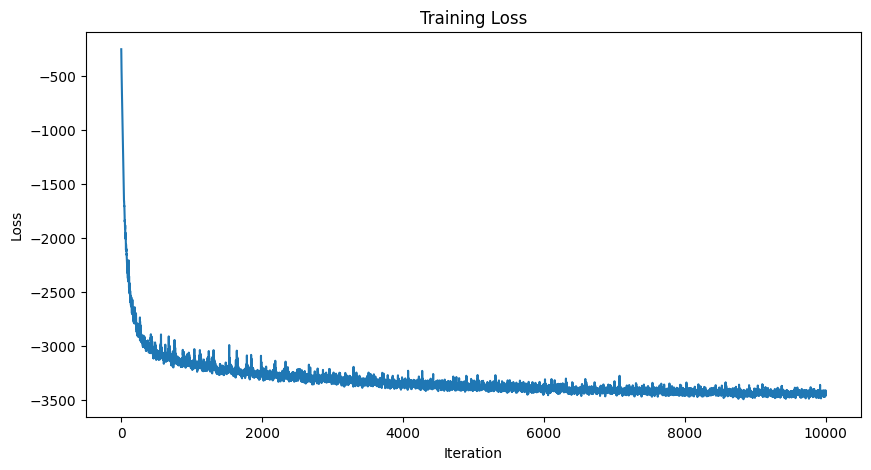

In [55]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


## Evaluation

To evaluate our model, we can just draw samples from our model.

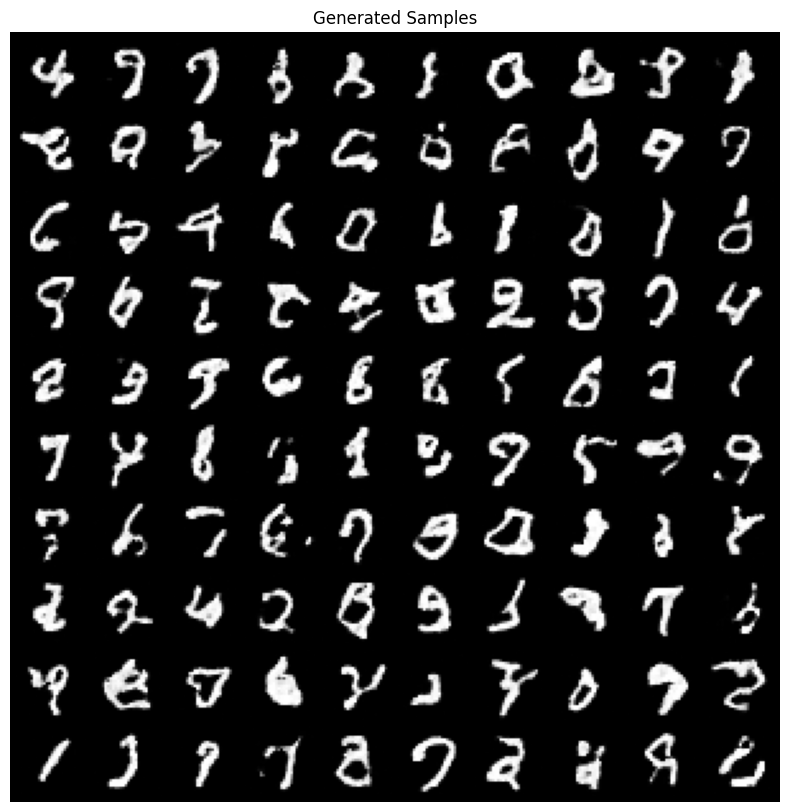

In [56]:
with torch.no_grad():
    # Sample from the base distribution
    x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed

    # To avoid issues with singular matrices, apply small regularization to L and U matrices
    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()


Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [ ]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    masked_image = image.clone()
    # TODO:
    mask # = Single channel(MNIST) square mask

    # suggestion: Sample a random top-left corner for the square

    # Apply the mask. Assume 0 is the mask value

    return masked_image, mask


In [58]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    masked_image = image.clone()

    # Generate random top-left corner of the square
    top = np.random.randint(0, H - mask_size)
    left = np.random.randint(0, W - mask_size)

    # Create the mask
    mask = torch.zeros((H, W))
    mask[top:top+mask_size, left:left+mask_size] = 1.0

    # Apply the mask to the image
    masked_image[:, top:top+mask_size, left:left+mask_size] = 0.0

    return masked_image, mask


In [59]:
# @title Optional random noise mask
def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask


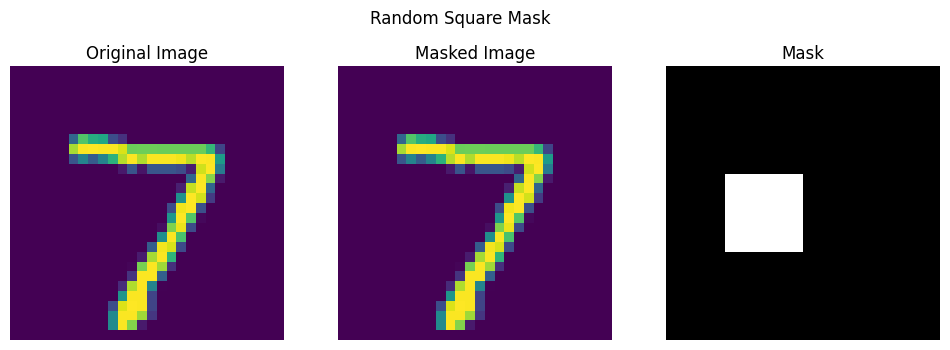

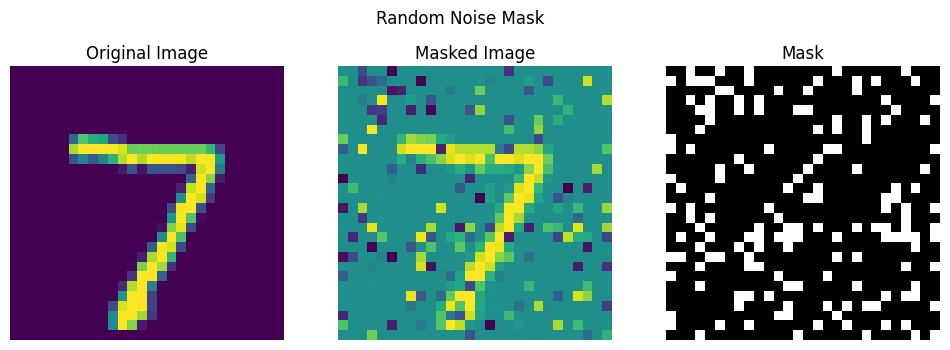

In [70]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.permute(1, 2, 0).cpu().numpy()
    masked = masked_image.permute(1, 2, 0).cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked)
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Example usage
# Assuming `sample_image` is a tensor [C, H, W] from your dataset
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")

In [ ]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # TODO:
    # Initialize the missing pixels to zeros (can also use random noise)
    # Create a tensor that will hold the missing pixels


    # Make missing_pixels a learnable parameter
    missing_pixels = torch.nn.Parameter(missing_pixels)

    # Define optimizer
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels


        # Backpropagation ( model.forward_kld() gives the log prob )


        with torch.no_grad():
          pass
        # clamp the missing pixels to valid range (e.g., [0, 1])


        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")


    return inpainted_image


In [61]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # Initialize the missing pixels to zeros
    missing_pixels = (inpainted_image * mask).detach()  # Extract the missing region
    missing_pixels.requires_grad = True  # Make it learnable

    # Define optimizer
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels
        reconstructed_image = inpainted_image * (1 - mask) + missing_pixels * mask

        # Compute the negative log-likelihood (loss)
        loss = -model.forward_kld(reconstructed_image)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Clamp the missing pixels to a valid range (e.g., [0, 1])
        with torch.no_grad():
            missing_pixels.data.clamp_(0, 1)

        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    # Combine the final reconstructed image
    inpainted_image = inpainted_image * (1 - mask) + missing_pixels * mask
    return inpainted_image.squeeze(0)


In [64]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # Initialize the missing pixels to zeros
    missing_pixels = (inpainted_image * mask).detach()  # Extract the masked region
    missing_pixels.requires_grad = True  # Make it learnable

    # Define optimizer
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels
        reconstructed_image = inpainted_image * (1 - mask) + missing_pixels * mask

        # Compute the negative log-likelihood (loss)
        loss = -model.forward_kld(reconstructed_image)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Clamp the missing pixels to a valid range (e.g., [0, 1])
        with torch.no_grad():
            missing_pixels.data.clamp_(0, 1)

        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    # Combine the final reconstructed image
    inpainted_image = inpainted_image * (1 - mask) + missing_pixels * mask
    return inpainted_image.squeeze(0)


In [66]:
# Example usage with a batch of 4 images

batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.1))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting:  10%|█         | 102/1000 [00:10<01:27, 10.23it/s]

Step [100/1000], Loss: 3591.5354


Inpainting:  20%|██        | 201/1000 [00:19<01:36,  8.31it/s]

Step [200/1000], Loss: 3591.5354


Inpainting:  30%|███       | 301/1000 [00:29<01:06, 10.57it/s]

Step [300/1000], Loss: 3591.5354


Inpainting:  40%|████      | 402/1000 [00:40<00:56, 10.62it/s]

Step [400/1000], Loss: 3591.5354


Inpainting:  50%|█████     | 501/1000 [00:50<00:48, 10.30it/s]

Step [500/1000], Loss: 3591.5354


Inpainting:  60%|██████    | 601/1000 [01:00<00:38, 10.39it/s]

Step [600/1000], Loss: 3591.5354


Inpainting:  70%|███████   | 701/1000 [01:09<00:34,  8.70it/s]

Step [700/1000], Loss: 3591.5354


Inpainting:  80%|████████  | 801/1000 [01:19<00:19, 10.24it/s]

Step [800/1000], Loss: 3591.5354


Inpainting:  90%|█████████ | 901/1000 [01:29<00:08, 11.16it/s]

Step [900/1000], Loss: 3591.5354


Inpainting: 100%|██████████| 1000/1000 [01:39<00:00, 10.01it/s]


Step [1000/1000], Loss: 3591.5354


Inpainting:  10%|█         | 101/1000 [00:10<01:31,  9.83it/s]

Step [100/1000], Loss: -449.8789


Inpainting:  20%|██        | 201/1000 [00:20<01:46,  7.50it/s]

Step [200/1000], Loss: nan


Inpainting:  30%|███       | 301/1000 [00:29<01:04, 10.83it/s]

Step [300/1000], Loss: nan


Inpainting:  40%|████      | 401/1000 [00:40<00:54, 10.90it/s]

Step [400/1000], Loss: nan


Inpainting:  50%|█████     | 502/1000 [00:50<00:45, 10.89it/s]

Step [500/1000], Loss: nan


Inpainting:  60%|██████    | 601/1000 [01:00<00:37, 10.69it/s]

Step [600/1000], Loss: nan


Inpainting:  70%|███████   | 701/1000 [01:09<00:36,  8.14it/s]

Step [700/1000], Loss: nan


Inpainting:  80%|████████  | 802/1000 [01:19<00:18, 10.95it/s]

Step [800/1000], Loss: nan


Inpainting:  90%|█████████ | 901/1000 [01:29<00:09, 10.45it/s]

Step [900/1000], Loss: nan


Inpainting: 100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


Step [1000/1000], Loss: nan


Inpainting:  10%|█         | 101/1000 [00:10<01:23, 10.83it/s]

Step [100/1000], Loss: -708.1165


Inpainting:  20%|██        | 201/1000 [00:19<01:46,  7.51it/s]

Step [200/1000], Loss: -24427.6543


Inpainting:  30%|███       | 301/1000 [00:29<01:03, 10.94it/s]

Step [300/1000], Loss: -32416.0859


Inpainting:  40%|████      | 402/1000 [00:39<00:55, 10.70it/s]

Step [400/1000], Loss: -33185.2734


Inpainting:  50%|█████     | 502/1000 [00:50<00:46, 10.62it/s]

Step [500/1000], Loss: -33039.3906


Inpainting:  60%|██████    | 602/1000 [01:00<00:38, 10.40it/s]

Step [600/1000], Loss: -32140.8906


Inpainting:  70%|███████   | 701/1000 [01:10<00:41,  7.20it/s]

Step [700/1000], Loss: -32767.9180


Inpainting:  80%|████████  | 801/1000 [01:19<00:19, 10.32it/s]

Step [800/1000], Loss: -32890.8711


Inpainting:  90%|█████████ | 901/1000 [01:29<00:09, 10.63it/s]

Step [900/1000], Loss: -33300.6641


Inpainting: 100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


Step [1000/1000], Loss: -32895.2227


Inpainting:  10%|█         | 101/1000 [00:10<01:48,  8.28it/s]

Step [100/1000], Loss: nan


Inpainting:  20%|██        | 201/1000 [00:21<01:18, 10.18it/s]

Step [200/1000], Loss: nan


Inpainting:  30%|███       | 301/1000 [00:30<01:14,  9.35it/s]

Step [300/1000], Loss: nan


Inpainting:  40%|████      | 401/1000 [00:41<00:56, 10.64it/s]

Step [400/1000], Loss: nan


Inpainting:  50%|█████     | 501/1000 [00:51<00:46, 10.73it/s]

Step [500/1000], Loss: nan


Inpainting:  60%|██████    | 602/1000 [01:01<00:36, 10.76it/s]

Step [600/1000], Loss: nan


Inpainting:  70%|███████   | 701/1000 [01:11<00:29,  9.97it/s]

Step [700/1000], Loss: nan


Inpainting:  80%|████████  | 801/1000 [01:20<00:20,  9.71it/s]

Step [800/1000], Loss: nan


Inpainting:  90%|█████████ | 902/1000 [01:31<00:09, 10.79it/s]

Step [900/1000], Loss: nan


Inpainting: 100%|██████████| 1000/1000 [01:40<00:00,  9.90it/s]

Step [1000/1000], Loss: nan


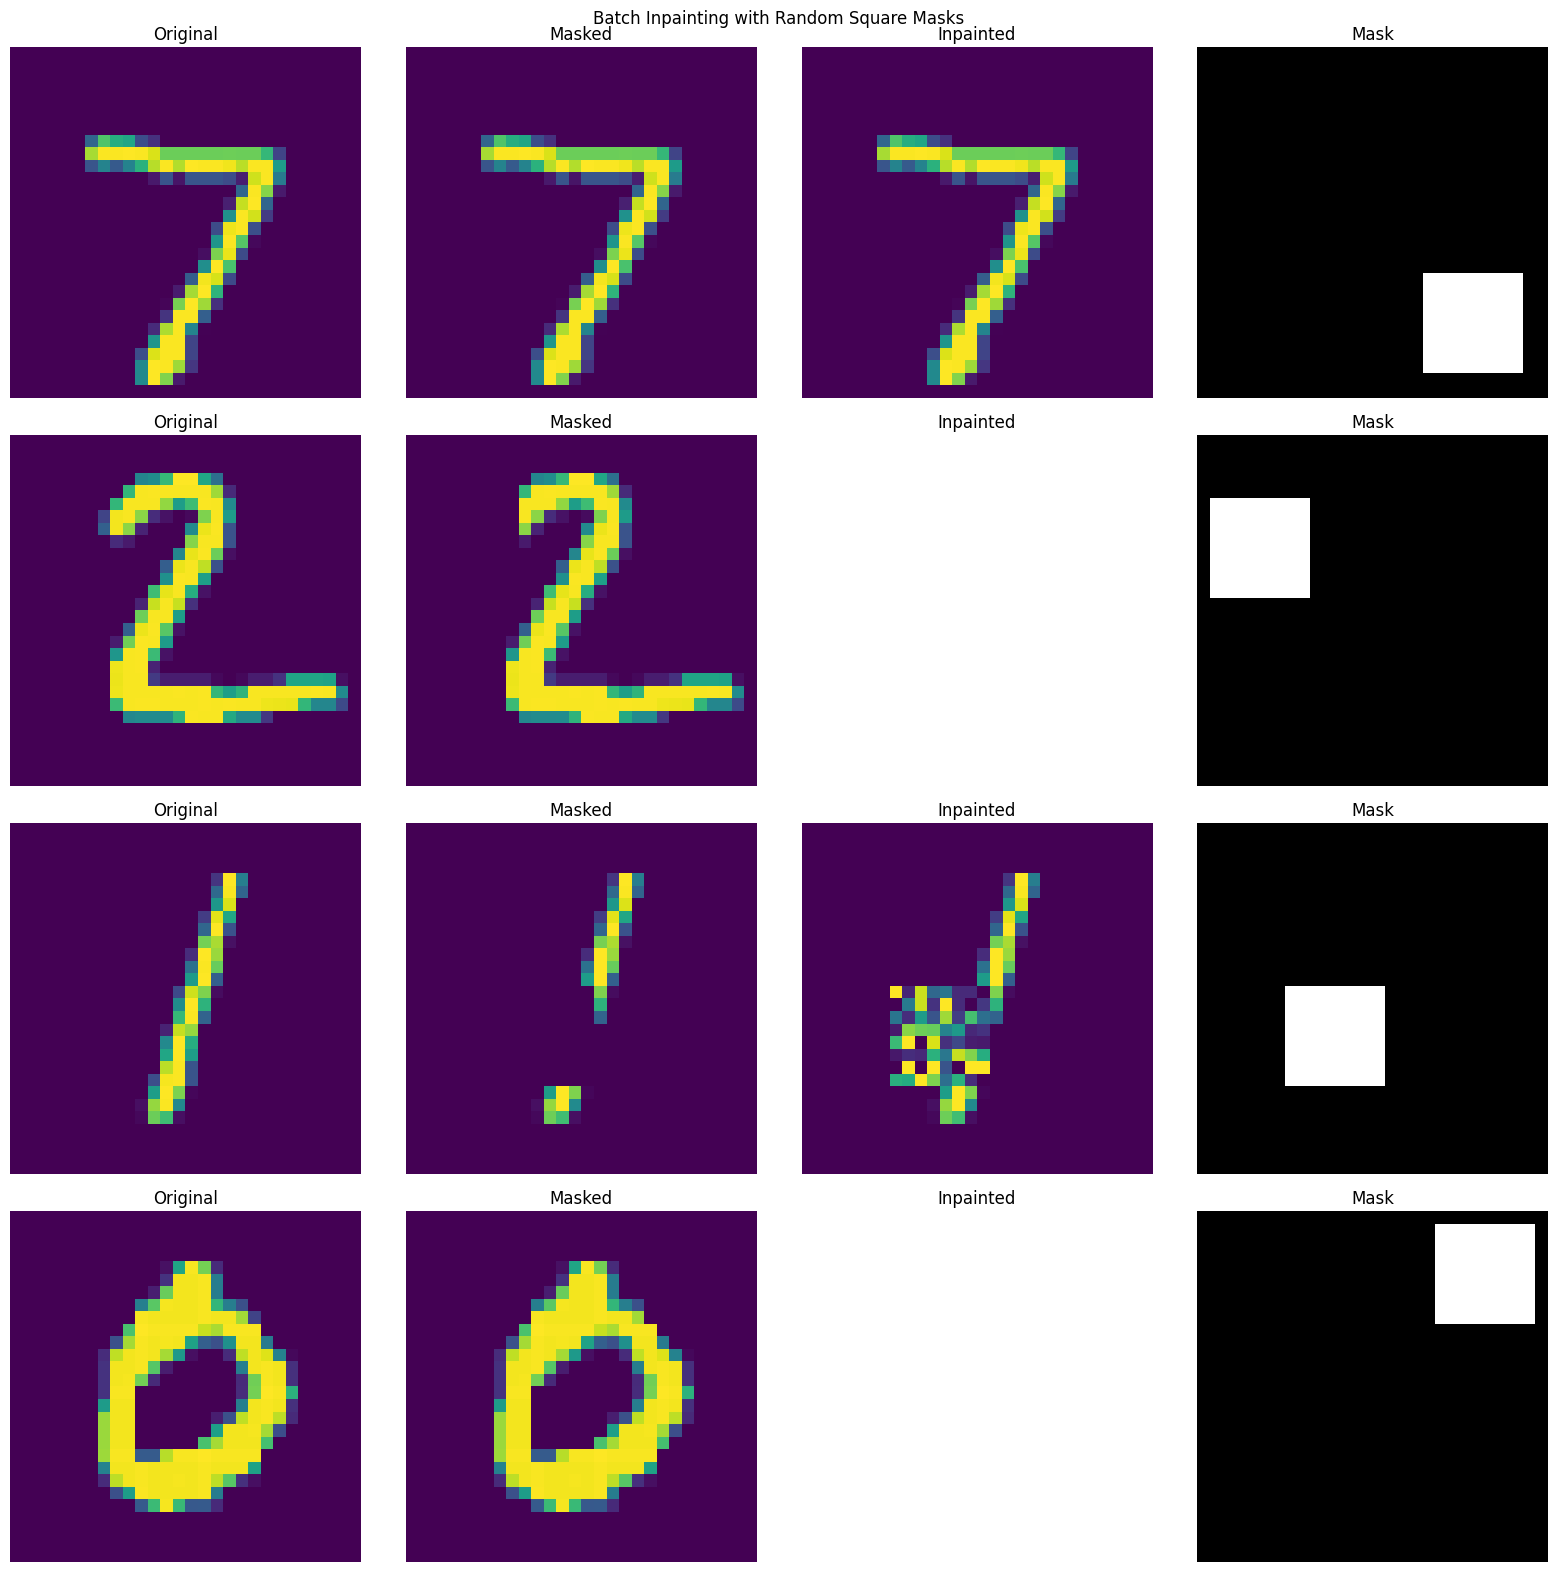

In [67]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")
